In [1]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 

In [12]:
cfg = edict({
    'train_size': 60000,  # 训练集大小
    'test_size': 10000,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 64,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 20,  # 训练次数
    'data_dir_train': os.path.join('E:/DeepLearning/FashionMnist/fashion-mnist', 'train'),
    'data_dir_test': os.path.join('E:/DeepLearning/FashionMnist/fashion-mnist', 'test'),
}) 

In [15]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs, np.float32).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label, np.int32)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


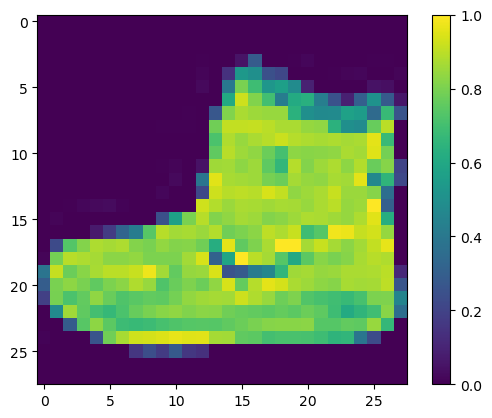

In [16]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0

print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0])  # 一共10类，用0-9的数字表达类别。

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [17]:
# 转换数据类型为Dataset
def create_dataset():
    XY_train = list(zip(train_x, train_y))
    ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
    ds_train = ds_train.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    XY_test = list(zip(test_x, test_y))
    ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
    ds_test = ds_test.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    return ds_train, ds_test 

In [18]:
# 定义卷积神经网络，无正则化
class ForwardFashion(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashion, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [19]:
# 定义卷积神经网络，有正则化
class ForwardFashionRegularization(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionRegularization, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
def train(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(30, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    
    return model

In [21]:
# 训练无正则化的网络
model = train(ForwardFashion)

[WARNING] ME(976:16928,MainProcess):2022-10-17-12:22:57.841.795 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(976:16928,MainProcess):2022-10-17-12:22:57.849.774 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.


============== Starting Training ==============
epoch: 1 step: 1, loss is 2.302593469619751
epoch: 1 step: 2, loss is 2.302518367767334
epoch: 1 step: 3, loss is 2.3025736808776855
epoch: 1 step: 4, loss is 2.301427125930786
epoch: 1 step: 5, loss is 2.3003411293029785
epoch: 1 step: 6, loss is 2.2927796840667725
epoch: 1 step: 7, loss is 2.280794382095337
epoch: 1 step: 8, loss is 2.2729716300964355
epoch: 1 step: 9, loss is 2.2175588607788086
epoch: 1 step: 10, loss is 2.212278366088867
epoch: 1 step: 11, loss is 2.1554458141326904
epoch: 1 step: 12, loss is 2.081629753112793
epoch: 1 step: 13, loss is 1.9350179433822632
epoch: 1 step: 14, loss is 1.789394736289978
epoch: 1 step: 15, loss is 1.4757170677185059
epoch: 1 step: 16, loss is 1.5391600131988525
epoch: 1 step: 17, loss is 1.46890127658844
epoch: 1 step: 18, loss is 1.185867428779602
epoch: 1 step: 19, loss is 1.2983123064041138
epoch: 1 step: 20, loss is 1.4086023569107056
epoch: 1 step: 21, loss is 1.6835355758666992
epoch

epoch: 1 step: 178, loss is 0.6504468321800232
epoch: 1 step: 179, loss is 0.5678136348724365
epoch: 1 step: 180, loss is 0.7147209644317627
epoch: 1 step: 181, loss is 0.4228847622871399
epoch: 1 step: 182, loss is 0.42461490631103516
epoch: 1 step: 183, loss is 0.41137996315956116
epoch: 1 step: 184, loss is 0.47829413414001465
epoch: 1 step: 185, loss is 0.5943102240562439
epoch: 1 step: 186, loss is 0.6106183528900146
epoch: 1 step: 187, loss is 0.5374863147735596
epoch: 1 step: 188, loss is 0.6089520454406738
epoch: 1 step: 189, loss is 0.3814203441143036
epoch: 1 step: 190, loss is 0.5321703553199768
epoch: 1 step: 191, loss is 0.5317269563674927
epoch: 1 step: 192, loss is 0.43546390533447266
epoch: 1 step: 193, loss is 0.42203494906425476
epoch: 1 step: 194, loss is 0.5228715538978577
epoch: 1 step: 195, loss is 0.5024772882461548
epoch: 1 step: 196, loss is 0.5614913105964661
epoch: 1 step: 197, loss is 0.5252940654754639
epoch: 1 step: 198, loss is 0.6673060655593872
epoch: 1

epoch: 1 step: 353, loss is 0.39268094301223755
epoch: 1 step: 354, loss is 0.5106400847434998
epoch: 1 step: 355, loss is 0.29143136739730835
epoch: 1 step: 356, loss is 0.2821182906627655
epoch: 1 step: 357, loss is 0.4611077308654785
epoch: 1 step: 358, loss is 0.3985447883605957
epoch: 1 step: 359, loss is 0.5609055161476135
epoch: 1 step: 360, loss is 0.6536924839019775
epoch: 1 step: 361, loss is 0.5161142349243164
epoch: 1 step: 362, loss is 0.7639474868774414
epoch: 1 step: 363, loss is 0.5071642994880676
epoch: 1 step: 364, loss is 0.3514431118965149
epoch: 1 step: 365, loss is 0.46515437960624695
epoch: 1 step: 366, loss is 0.5030009746551514
epoch: 1 step: 367, loss is 0.5969384908676147
epoch: 1 step: 368, loss is 0.8089406490325928
epoch: 1 step: 369, loss is 0.6737209558486938
epoch: 1 step: 370, loss is 0.4700644314289093
epoch: 1 step: 371, loss is 0.6757851243019104
epoch: 1 step: 372, loss is 0.5688777565956116
epoch: 1 step: 373, loss is 0.38097432255744934
epoch: 1 

epoch: 1 step: 527, loss is 0.4355168342590332
epoch: 1 step: 528, loss is 0.2725103199481964
epoch: 1 step: 529, loss is 0.5031691193580627
epoch: 1 step: 530, loss is 0.3621505796909332
epoch: 1 step: 531, loss is 0.6285059452056885
epoch: 1 step: 532, loss is 0.37161022424697876
epoch: 1 step: 533, loss is 0.3599417209625244
epoch: 1 step: 534, loss is 0.5603554844856262
epoch: 1 step: 535, loss is 0.29883086681365967
epoch: 1 step: 536, loss is 0.587838351726532
epoch: 1 step: 537, loss is 0.4753744602203369
epoch: 1 step: 538, loss is 0.2816147804260254
epoch: 1 step: 539, loss is 0.3785777986049652
epoch: 1 step: 540, loss is 0.5224313139915466
epoch: 1 step: 541, loss is 0.3897934556007385
epoch: 1 step: 542, loss is 0.32851988077163696
epoch: 1 step: 543, loss is 0.4575405418872833
epoch: 1 step: 544, loss is 0.30424022674560547
epoch: 1 step: 545, loss is 0.4272080957889557
epoch: 1 step: 546, loss is 0.4766620397567749
epoch: 1 step: 547, loss is 0.3726661503314972
epoch: 1 s

epoch: 1 step: 701, loss is 0.3393130302429199
epoch: 1 step: 702, loss is 0.4059203565120697
epoch: 1 step: 703, loss is 0.3382461667060852
epoch: 1 step: 704, loss is 0.28876739740371704
epoch: 1 step: 705, loss is 0.2353939265012741
epoch: 1 step: 706, loss is 0.4095781445503235
epoch: 1 step: 707, loss is 0.32695844769477844
epoch: 1 step: 708, loss is 0.3624081015586853
epoch: 1 step: 709, loss is 0.5487909317016602
epoch: 1 step: 710, loss is 0.548498272895813
epoch: 1 step: 711, loss is 0.39077192544937134
epoch: 1 step: 712, loss is 0.611285924911499
epoch: 1 step: 713, loss is 0.33556023240089417
epoch: 1 step: 714, loss is 0.35745275020599365
epoch: 1 step: 715, loss is 0.3464873731136322
epoch: 1 step: 716, loss is 0.4587341248989105
epoch: 1 step: 717, loss is 0.5731801390647888
epoch: 1 step: 718, loss is 0.37046438455581665
epoch: 1 step: 719, loss is 0.4685395061969757
epoch: 1 step: 720, loss is 0.3852262794971466
epoch: 1 step: 721, loss is 0.33229079842567444
epoch: 1

epoch: 1 step: 875, loss is 0.34173545241355896
epoch: 1 step: 876, loss is 0.20142963528633118
epoch: 1 step: 877, loss is 0.273895263671875
epoch: 1 step: 878, loss is 0.378560334444046
epoch: 1 step: 879, loss is 0.4219202697277069
epoch: 1 step: 880, loss is 0.38451337814331055
epoch: 1 step: 881, loss is 0.3315209150314331
epoch: 1 step: 882, loss is 0.4248208999633789
epoch: 1 step: 883, loss is 0.17413415014743805
epoch: 1 step: 884, loss is 0.43697139620780945
epoch: 1 step: 885, loss is 0.32828882336616516
epoch: 1 step: 886, loss is 0.24611517786979675
epoch: 1 step: 887, loss is 0.3903692364692688
epoch: 1 step: 888, loss is 0.39022260904312134
epoch: 1 step: 889, loss is 0.498858779668808
epoch: 1 step: 890, loss is 0.3581293523311615
epoch: 1 step: 891, loss is 0.285839706659317
epoch: 1 step: 892, loss is 0.22906699776649475
epoch: 1 step: 893, loss is 0.29056087136268616
epoch: 1 step: 894, loss is 0.30603060126304626
epoch: 1 step: 895, loss is 0.5100064277648926
epoch:

epoch: 2 step: 114, loss is 0.30786052346229553
epoch: 2 step: 115, loss is 0.32069939374923706
epoch: 2 step: 116, loss is 0.4484564960002899
epoch: 2 step: 117, loss is 0.14284548163414001
epoch: 2 step: 118, loss is 0.39294666051864624
epoch: 2 step: 119, loss is 0.22342100739479065
epoch: 2 step: 120, loss is 0.3345882296562195
epoch: 2 step: 121, loss is 0.45440787076950073
epoch: 2 step: 122, loss is 0.3105141520500183
epoch: 2 step: 123, loss is 0.3192940652370453
epoch: 2 step: 124, loss is 0.33973392844200134
epoch: 2 step: 125, loss is 0.262653648853302
epoch: 2 step: 126, loss is 0.2197512835264206
epoch: 2 step: 127, loss is 0.2770904004573822
epoch: 2 step: 128, loss is 0.28698691725730896
epoch: 2 step: 129, loss is 0.36877021193504333
epoch: 2 step: 130, loss is 0.1418691724538803
epoch: 2 step: 131, loss is 0.48066097497940063
epoch: 2 step: 132, loss is 0.252928227186203
epoch: 2 step: 133, loss is 0.19067257642745972
epoch: 2 step: 134, loss is 0.29342105984687805
epo

epoch: 2 step: 287, loss is 0.28891825675964355
epoch: 2 step: 288, loss is 0.2446306049823761
epoch: 2 step: 289, loss is 0.31870144605636597
epoch: 2 step: 290, loss is 0.38049542903900146
epoch: 2 step: 291, loss is 0.28861355781555176
epoch: 2 step: 292, loss is 0.37821468710899353
epoch: 2 step: 293, loss is 0.3455701768398285
epoch: 2 step: 294, loss is 0.31895285844802856
epoch: 2 step: 295, loss is 0.24744708836078644
epoch: 2 step: 296, loss is 0.3306858539581299
epoch: 2 step: 297, loss is 0.22401604056358337
epoch: 2 step: 298, loss is 0.2037782073020935
epoch: 2 step: 299, loss is 0.3832346498966217
epoch: 2 step: 300, loss is 0.2398628145456314
epoch: 2 step: 301, loss is 0.17701570689678192
epoch: 2 step: 302, loss is 0.27279070019721985
epoch: 2 step: 303, loss is 0.2849946618080139
epoch: 2 step: 304, loss is 0.3759743571281433
epoch: 2 step: 305, loss is 0.15881016850471497
epoch: 2 step: 306, loss is 0.2949570417404175
epoch: 2 step: 307, loss is 0.2954341173171997
ep

epoch: 2 step: 460, loss is 0.32317498326301575
epoch: 2 step: 461, loss is 0.2880496084690094
epoch: 2 step: 462, loss is 0.19588825106620789
epoch: 2 step: 463, loss is 0.2657625377178192
epoch: 2 step: 464, loss is 0.26696908473968506
epoch: 2 step: 465, loss is 0.25414204597473145
epoch: 2 step: 466, loss is 0.26861876249313354
epoch: 2 step: 467, loss is 0.3354898989200592
epoch: 2 step: 468, loss is 0.21759769320487976
epoch: 2 step: 469, loss is 0.48927199840545654
epoch: 2 step: 470, loss is 0.3913348317146301
epoch: 2 step: 471, loss is 0.2689790427684784
epoch: 2 step: 472, loss is 0.3739909529685974
epoch: 2 step: 473, loss is 0.3247342109680176
epoch: 2 step: 474, loss is 0.2759391665458679
epoch: 2 step: 475, loss is 0.2783336937427521
epoch: 2 step: 476, loss is 0.23696167767047882
epoch: 2 step: 477, loss is 0.36463746428489685
epoch: 2 step: 478, loss is 0.3528202772140503
epoch: 2 step: 479, loss is 0.33884933590888977
epoch: 2 step: 480, loss is 0.2799036204814911
epo

epoch: 2 step: 633, loss is 0.20487730205059052
epoch: 2 step: 634, loss is 0.34145206212997437
epoch: 2 step: 635, loss is 0.4403434097766876
epoch: 2 step: 636, loss is 0.33870670199394226
epoch: 2 step: 637, loss is 0.19096562266349792
epoch: 2 step: 638, loss is 0.35385116934776306
epoch: 2 step: 639, loss is 0.24828697741031647
epoch: 2 step: 640, loss is 0.3371331989765167
epoch: 2 step: 641, loss is 0.1767507791519165
epoch: 2 step: 642, loss is 0.2087949961423874
epoch: 2 step: 643, loss is 0.1879092901945114
epoch: 2 step: 644, loss is 0.30735576152801514
epoch: 2 step: 645, loss is 0.14013329148292542
epoch: 2 step: 646, loss is 0.2699846625328064
epoch: 2 step: 647, loss is 0.36216413974761963
epoch: 2 step: 648, loss is 0.2662035822868347
epoch: 2 step: 649, loss is 0.1255786418914795
epoch: 2 step: 650, loss is 0.3680592179298401
epoch: 2 step: 651, loss is 0.09415265917778015
epoch: 2 step: 652, loss is 0.1927170753479004
epoch: 2 step: 653, loss is 0.2354709357023239
epo

epoch: 2 step: 806, loss is 0.31995925307273865
epoch: 2 step: 807, loss is 0.4774962067604065
epoch: 2 step: 808, loss is 0.2499147653579712
epoch: 2 step: 809, loss is 0.2535303831100464
epoch: 2 step: 810, loss is 0.34984755516052246
epoch: 2 step: 811, loss is 0.3882533311843872
epoch: 2 step: 812, loss is 0.3281422555446625
epoch: 2 step: 813, loss is 0.23283232748508453
epoch: 2 step: 814, loss is 0.32471269369125366
epoch: 2 step: 815, loss is 0.30322620272636414
epoch: 2 step: 816, loss is 0.24459443986415863
epoch: 2 step: 817, loss is 0.2655720114707947
epoch: 2 step: 818, loss is 0.27211475372314453
epoch: 2 step: 819, loss is 0.2817833423614502
epoch: 2 step: 820, loss is 0.208547905087471
epoch: 2 step: 821, loss is 0.2970927357673645
epoch: 2 step: 822, loss is 0.1912347376346588
epoch: 2 step: 823, loss is 0.19814272224903107
epoch: 2 step: 824, loss is 0.20647330582141876
epoch: 2 step: 825, loss is 0.095177061855793
epoch: 2 step: 826, loss is 0.31496331095695496
epoch

epoch: 3 step: 43, loss is 0.3281875550746918
epoch: 3 step: 44, loss is 0.23036614060401917
epoch: 3 step: 45, loss is 0.20308369398117065
epoch: 3 step: 46, loss is 0.19022220373153687
epoch: 3 step: 47, loss is 0.1516513228416443
epoch: 3 step: 48, loss is 0.10262922197580338
epoch: 3 step: 49, loss is 0.35099729895591736
epoch: 3 step: 50, loss is 0.1465609222650528
epoch: 3 step: 51, loss is 0.189748615026474
epoch: 3 step: 52, loss is 0.16383710503578186
epoch: 3 step: 53, loss is 0.28487592935562134
epoch: 3 step: 54, loss is 0.29748639464378357
epoch: 3 step: 55, loss is 0.20878736674785614
epoch: 3 step: 56, loss is 0.06803664565086365
epoch: 3 step: 57, loss is 0.21897554397583008
epoch: 3 step: 58, loss is 0.32452619075775146
epoch: 3 step: 59, loss is 0.19628222286701202
epoch: 3 step: 60, loss is 0.295436292886734
epoch: 3 step: 61, loss is 0.18935726583003998
epoch: 3 step: 62, loss is 0.32087740302085876
epoch: 3 step: 63, loss is 0.14353421330451965
epoch: 3 step: 64, l

epoch: 3 step: 217, loss is 0.2422773391008377
epoch: 3 step: 218, loss is 0.3243641257286072
epoch: 3 step: 219, loss is 0.16769197583198547
epoch: 3 step: 220, loss is 0.3712370693683624
epoch: 3 step: 221, loss is 0.3302832245826721
epoch: 3 step: 222, loss is 0.2528115510940552
epoch: 3 step: 223, loss is 0.39192962646484375
epoch: 3 step: 224, loss is 0.32361990213394165
epoch: 3 step: 225, loss is 0.24500501155853271
epoch: 3 step: 226, loss is 0.13656029105186462
epoch: 3 step: 227, loss is 0.1922370344400406
epoch: 3 step: 228, loss is 0.26880258321762085
epoch: 3 step: 229, loss is 0.26922371983528137
epoch: 3 step: 230, loss is 0.3033320903778076
epoch: 3 step: 231, loss is 0.2760904133319855
epoch: 3 step: 232, loss is 0.1905682384967804
epoch: 3 step: 233, loss is 0.18615776300430298
epoch: 3 step: 234, loss is 0.25657474994659424
epoch: 3 step: 235, loss is 0.2594369947910309
epoch: 3 step: 236, loss is 0.48433125019073486
epoch: 3 step: 237, loss is 0.1910281777381897
epo

epoch: 3 step: 390, loss is 0.18155694007873535
epoch: 3 step: 391, loss is 0.41039595007896423
epoch: 3 step: 392, loss is 0.20745772123336792
epoch: 3 step: 393, loss is 0.1784820854663849
epoch: 3 step: 394, loss is 0.2892773151397705
epoch: 3 step: 395, loss is 0.1504744589328766
epoch: 3 step: 396, loss is 0.3387872278690338
epoch: 3 step: 397, loss is 0.2441471666097641
epoch: 3 step: 398, loss is 0.20433473587036133
epoch: 3 step: 399, loss is 0.40718764066696167
epoch: 3 step: 400, loss is 0.2810392379760742
epoch: 3 step: 401, loss is 0.27781471610069275
epoch: 3 step: 402, loss is 0.1710219830274582
epoch: 3 step: 403, loss is 0.31821104884147644
epoch: 3 step: 404, loss is 0.2243339866399765
epoch: 3 step: 405, loss is 0.3623232841491699
epoch: 3 step: 406, loss is 0.15284623205661774
epoch: 3 step: 407, loss is 0.37416133284568787
epoch: 3 step: 408, loss is 0.22626037895679474
epoch: 3 step: 409, loss is 0.2638627588748932
epoch: 3 step: 410, loss is 0.10299115628004074
ep

epoch: 3 step: 562, loss is 0.15446837246418
epoch: 3 step: 563, loss is 0.24790096282958984
epoch: 3 step: 564, loss is 0.30108150839805603
epoch: 3 step: 565, loss is 0.23998552560806274
epoch: 3 step: 566, loss is 0.3535943627357483
epoch: 3 step: 567, loss is 0.2677081525325775
epoch: 3 step: 568, loss is 0.24372735619544983
epoch: 3 step: 569, loss is 0.22429130971431732
epoch: 3 step: 570, loss is 0.386518657207489
epoch: 3 step: 571, loss is 0.2782982289791107
epoch: 3 step: 572, loss is 0.20771412551403046
epoch: 3 step: 573, loss is 0.22882790863513947
epoch: 3 step: 574, loss is 0.24709667265415192
epoch: 3 step: 575, loss is 0.3695167005062103
epoch: 3 step: 576, loss is 0.31655919551849365
epoch: 3 step: 577, loss is 0.3354872465133667
epoch: 3 step: 578, loss is 0.14394694566726685
epoch: 3 step: 579, loss is 0.35384586453437805
epoch: 3 step: 580, loss is 0.21506747603416443
epoch: 3 step: 581, loss is 0.23233947157859802
epoch: 3 step: 582, loss is 0.19394949078559875
ep

epoch: 3 step: 735, loss is 0.11199584603309631
epoch: 3 step: 736, loss is 0.1814562976360321
epoch: 3 step: 737, loss is 0.16991008818149567
epoch: 3 step: 738, loss is 0.42862531542778015
epoch: 3 step: 739, loss is 0.1987995207309723
epoch: 3 step: 740, loss is 0.22865734994411469
epoch: 3 step: 741, loss is 0.22073090076446533
epoch: 3 step: 742, loss is 0.4006754159927368
epoch: 3 step: 743, loss is 0.2506173849105835
epoch: 3 step: 744, loss is 0.2771695852279663
epoch: 3 step: 745, loss is 0.20767027139663696
epoch: 3 step: 746, loss is 0.22068750858306885
epoch: 3 step: 747, loss is 0.1457710713148117
epoch: 3 step: 748, loss is 0.30789557099342346
epoch: 3 step: 749, loss is 0.26703310012817383
epoch: 3 step: 750, loss is 0.12852157652378082
epoch: 3 step: 751, loss is 0.4042782187461853
epoch: 3 step: 752, loss is 0.21809601783752441
epoch: 3 step: 753, loss is 0.3290923535823822
epoch: 3 step: 754, loss is 0.12551717460155487
epoch: 3 step: 755, loss is 0.23740123212337494


epoch: 3 step: 908, loss is 0.19900521636009216
epoch: 3 step: 909, loss is 0.26312577724456787
epoch: 3 step: 910, loss is 0.2352500706911087
epoch: 3 step: 911, loss is 0.2243928164243698
epoch: 3 step: 912, loss is 0.24779993295669556
epoch: 3 step: 913, loss is 0.25201618671417236
epoch: 3 step: 914, loss is 0.233528271317482
epoch: 3 step: 915, loss is 0.1750892996788025
epoch: 3 step: 916, loss is 0.14304645359516144
epoch: 3 step: 917, loss is 0.18399092555046082
epoch: 3 step: 918, loss is 0.1680360585451126
epoch: 3 step: 919, loss is 0.24548554420471191
epoch: 3 step: 920, loss is 0.20112769305706024
epoch: 3 step: 921, loss is 0.3028355836868286
epoch: 3 step: 922, loss is 0.3023183047771454
epoch: 3 step: 923, loss is 0.3125321865081787
epoch: 3 step: 924, loss is 0.2854313552379608
epoch: 3 step: 925, loss is 0.26348885893821716
epoch: 3 step: 926, loss is 0.19524037837982178
epoch: 3 step: 927, loss is 0.3533034026622772
epoch: 3 step: 928, loss is 0.2470637410879135
epoc

epoch: 4 step: 146, loss is 0.285091370344162
epoch: 4 step: 147, loss is 0.19317883253097534
epoch: 4 step: 148, loss is 0.24223749339580536
epoch: 4 step: 149, loss is 0.1205291897058487
epoch: 4 step: 150, loss is 0.20957373082637787
epoch: 4 step: 151, loss is 0.1998528093099594
epoch: 4 step: 152, loss is 0.1755398064851761
epoch: 4 step: 153, loss is 0.25579991936683655
epoch: 4 step: 154, loss is 0.10351505130529404
epoch: 4 step: 155, loss is 0.27954018115997314
epoch: 4 step: 156, loss is 0.2014296054840088
epoch: 4 step: 157, loss is 0.19088004529476166
epoch: 4 step: 158, loss is 0.17715556919574738
epoch: 4 step: 159, loss is 0.16985094547271729
epoch: 4 step: 160, loss is 0.21540971100330353
epoch: 4 step: 161, loss is 0.1735011786222458
epoch: 4 step: 162, loss is 0.1982579082250595
epoch: 4 step: 163, loss is 0.2123638093471527
epoch: 4 step: 164, loss is 0.07154121994972229
epoch: 4 step: 165, loss is 0.3503755033016205
epoch: 4 step: 166, loss is 0.17125503718852997
ep

epoch: 4 step: 319, loss is 0.3156700134277344
epoch: 4 step: 320, loss is 0.2344241440296173
epoch: 4 step: 321, loss is 0.3218613862991333
epoch: 4 step: 322, loss is 0.18648971617221832
epoch: 4 step: 323, loss is 0.10495571792125702
epoch: 4 step: 324, loss is 0.3898410499095917
epoch: 4 step: 325, loss is 0.30378174781799316
epoch: 4 step: 326, loss is 0.13433869183063507
epoch: 4 step: 327, loss is 0.4566611349582672
epoch: 4 step: 328, loss is 0.19467170536518097
epoch: 4 step: 329, loss is 0.16284415125846863
epoch: 4 step: 330, loss is 0.19389913976192474
epoch: 4 step: 331, loss is 0.4073903560638428
epoch: 4 step: 332, loss is 0.11050797998905182
epoch: 4 step: 333, loss is 0.17426100373268127
epoch: 4 step: 334, loss is 0.12917695939540863
epoch: 4 step: 335, loss is 0.27943214774131775
epoch: 4 step: 336, loss is 0.17512641847133636
epoch: 4 step: 337, loss is 0.18912799656391144
epoch: 4 step: 338, loss is 0.16099822521209717
epoch: 4 step: 339, loss is 0.2726952731609344

epoch: 4 step: 492, loss is 0.36978819966316223
epoch: 4 step: 493, loss is 0.343303918838501
epoch: 4 step: 494, loss is 0.10614243149757385
epoch: 4 step: 495, loss is 0.16009612381458282
epoch: 4 step: 496, loss is 0.24185900390148163
epoch: 4 step: 497, loss is 0.1942409873008728
epoch: 4 step: 498, loss is 0.2206696718931198
epoch: 4 step: 499, loss is 0.150003582239151
epoch: 4 step: 500, loss is 0.1625824123620987
epoch: 4 step: 501, loss is 0.1205221638083458
epoch: 4 step: 502, loss is 0.19399394094944
epoch: 4 step: 503, loss is 0.15821655094623566
epoch: 4 step: 504, loss is 0.2796790301799774
epoch: 4 step: 505, loss is 0.2821316421031952
epoch: 4 step: 506, loss is 0.35396498441696167
epoch: 4 step: 507, loss is 0.1351230889558792
epoch: 4 step: 508, loss is 0.21638129651546478
epoch: 4 step: 509, loss is 0.21501895785331726
epoch: 4 step: 510, loss is 0.4482504427433014
epoch: 4 step: 511, loss is 0.07659091055393219
epoch: 4 step: 512, loss is 0.25059542059898376
epoch: 

epoch: 4 step: 665, loss is 0.1337946206331253
epoch: 4 step: 666, loss is 0.1785929650068283
epoch: 4 step: 667, loss is 0.2981879413127899
epoch: 4 step: 668, loss is 0.27655932307243347
epoch: 4 step: 669, loss is 0.18621201813220978
epoch: 4 step: 670, loss is 0.1151672899723053
epoch: 4 step: 671, loss is 0.3100114166736603
epoch: 4 step: 672, loss is 0.13714386522769928
epoch: 4 step: 673, loss is 0.2919139564037323
epoch: 4 step: 674, loss is 0.16851933300495148
epoch: 4 step: 675, loss is 0.20578768849372864
epoch: 4 step: 676, loss is 0.10319651663303375
epoch: 4 step: 677, loss is 0.22182884812355042
epoch: 4 step: 678, loss is 0.34102895855903625
epoch: 4 step: 679, loss is 0.29324519634246826
epoch: 4 step: 680, loss is 0.171977236866951
epoch: 4 step: 681, loss is 0.09083646535873413
epoch: 4 step: 682, loss is 0.17147429287433624
epoch: 4 step: 683, loss is 0.16922375559806824
epoch: 4 step: 684, loss is 0.3095393478870392
epoch: 4 step: 685, loss is 0.16256819665431976
e

epoch: 4 step: 838, loss is 0.29267948865890503
epoch: 4 step: 839, loss is 0.148546501994133
epoch: 4 step: 840, loss is 0.23220908641815186
epoch: 4 step: 841, loss is 0.11387693881988525
epoch: 4 step: 842, loss is 0.3659076988697052
epoch: 4 step: 843, loss is 0.4066146910190582
epoch: 4 step: 844, loss is 0.24083885550498962
epoch: 4 step: 845, loss is 0.2600109279155731
epoch: 4 step: 846, loss is 0.19488120079040527
epoch: 4 step: 847, loss is 0.11561766266822815
epoch: 4 step: 848, loss is 0.38060954213142395
epoch: 4 step: 849, loss is 0.13501796126365662
epoch: 4 step: 850, loss is 0.2719326615333557
epoch: 4 step: 851, loss is 0.16959857940673828
epoch: 4 step: 852, loss is 0.10816137492656708
epoch: 4 step: 853, loss is 0.23077769577503204
epoch: 4 step: 854, loss is 0.17059262096881866
epoch: 4 step: 855, loss is 0.486311674118042
epoch: 4 step: 856, loss is 0.13062332570552826
epoch: 4 step: 857, loss is 0.22276951372623444
epoch: 4 step: 858, loss is 0.16090501844882965


epoch: 5 step: 75, loss is 0.16671030223369598
epoch: 5 step: 76, loss is 0.26328060030937195
epoch: 5 step: 77, loss is 0.1623077094554901
epoch: 5 step: 78, loss is 0.2094089239835739
epoch: 5 step: 79, loss is 0.2073643058538437
epoch: 5 step: 80, loss is 0.061323992908000946
epoch: 5 step: 81, loss is 0.12990011274814606
epoch: 5 step: 82, loss is 0.13162265717983246
epoch: 5 step: 83, loss is 0.1508641093969345
epoch: 5 step: 84, loss is 0.2581482231616974
epoch: 5 step: 85, loss is 0.1660604327917099
epoch: 5 step: 86, loss is 0.23210503160953522
epoch: 5 step: 87, loss is 0.10314619541168213
epoch: 5 step: 88, loss is 0.11269554495811462
epoch: 5 step: 89, loss is 0.07384044677019119
epoch: 5 step: 90, loss is 0.1698334962129593
epoch: 5 step: 91, loss is 0.24175024032592773
epoch: 5 step: 92, loss is 0.11129669845104218
epoch: 5 step: 93, loss is 0.19567300379276276
epoch: 5 step: 94, loss is 0.16602523624897003
epoch: 5 step: 95, loss is 0.14707228541374207
epoch: 5 step: 96, 

epoch: 5 step: 248, loss is 0.21776002645492554
epoch: 5 step: 249, loss is 0.2429591715335846
epoch: 5 step: 250, loss is 0.2830294668674469
epoch: 5 step: 251, loss is 0.10168930888175964
epoch: 5 step: 252, loss is 0.2631848454475403
epoch: 5 step: 253, loss is 0.26106634736061096
epoch: 5 step: 254, loss is 0.0923694521188736
epoch: 5 step: 255, loss is 0.23190078139305115
epoch: 5 step: 256, loss is 0.050587110221385956
epoch: 5 step: 257, loss is 0.11270515620708466
epoch: 5 step: 258, loss is 0.18236105144023895
epoch: 5 step: 259, loss is 0.17294810712337494
epoch: 5 step: 260, loss is 0.27824243903160095
epoch: 5 step: 261, loss is 0.24750228226184845
epoch: 5 step: 262, loss is 0.22156347334384918
epoch: 5 step: 263, loss is 0.07462389767169952
epoch: 5 step: 264, loss is 0.19630219042301178
epoch: 5 step: 265, loss is 0.10576044023036957
epoch: 5 step: 266, loss is 0.12057413160800934
epoch: 5 step: 267, loss is 0.17771032452583313
epoch: 5 step: 268, loss is 0.1298280209302

epoch: 5 step: 420, loss is 0.21836736798286438
epoch: 5 step: 421, loss is 0.22291681170463562
epoch: 5 step: 422, loss is 0.10755565762519836
epoch: 5 step: 423, loss is 0.20992352068424225
epoch: 5 step: 424, loss is 0.1813463568687439
epoch: 5 step: 425, loss is 0.1479446440935135
epoch: 5 step: 426, loss is 0.0608736053109169
epoch: 5 step: 427, loss is 0.17361775040626526
epoch: 5 step: 428, loss is 0.08969000726938248
epoch: 5 step: 429, loss is 0.050539735704660416
epoch: 5 step: 430, loss is 0.13551253080368042
epoch: 5 step: 431, loss is 0.2019822597503662
epoch: 5 step: 432, loss is 0.0476280078291893
epoch: 5 step: 433, loss is 0.32920029759407043
epoch: 5 step: 434, loss is 0.10216342657804489
epoch: 5 step: 435, loss is 0.2946728467941284
epoch: 5 step: 436, loss is 0.18508003652095795
epoch: 5 step: 437, loss is 0.11956498771905899
epoch: 5 step: 438, loss is 0.07618293911218643
epoch: 5 step: 439, loss is 0.18556150794029236
epoch: 5 step: 440, loss is 0.157333478331565

epoch: 5 step: 592, loss is 0.15468457341194153
epoch: 5 step: 593, loss is 0.11606714874505997
epoch: 5 step: 594, loss is 0.1429564207792282
epoch: 5 step: 595, loss is 0.15040519833564758
epoch: 5 step: 596, loss is 0.07692863047122955
epoch: 5 step: 597, loss is 0.14034685492515564
epoch: 5 step: 598, loss is 0.2091480791568756
epoch: 5 step: 599, loss is 0.1047421395778656
epoch: 5 step: 600, loss is 0.17573173344135284
epoch: 5 step: 601, loss is 0.09604417532682419
epoch: 5 step: 602, loss is 0.24472671747207642
epoch: 5 step: 603, loss is 0.28568917512893677
epoch: 5 step: 604, loss is 0.35965755581855774
epoch: 5 step: 605, loss is 0.16747933626174927
epoch: 5 step: 606, loss is 0.15435707569122314
epoch: 5 step: 607, loss is 0.07403671741485596
epoch: 5 step: 608, loss is 0.056173596531152725
epoch: 5 step: 609, loss is 0.17531850934028625
epoch: 5 step: 610, loss is 0.14754585921764374
epoch: 5 step: 611, loss is 0.2896045744419098
epoch: 5 step: 612, loss is 0.2572232186794

epoch: 5 step: 764, loss is 0.09479071199893951
epoch: 5 step: 765, loss is 0.08584948629140854
epoch: 5 step: 766, loss is 0.08110705018043518
epoch: 5 step: 767, loss is 0.250953733921051
epoch: 5 step: 768, loss is 0.13073572516441345
epoch: 5 step: 769, loss is 0.2841523587703705
epoch: 5 step: 770, loss is 0.11198540776968002
epoch: 5 step: 771, loss is 0.1487327665090561
epoch: 5 step: 772, loss is 0.26889678835868835
epoch: 5 step: 773, loss is 0.1611608862876892
epoch: 5 step: 774, loss is 0.17898786067962646
epoch: 5 step: 775, loss is 0.18528926372528076
epoch: 5 step: 776, loss is 0.1858418583869934
epoch: 5 step: 777, loss is 0.21667499840259552
epoch: 5 step: 778, loss is 0.3015953302383423
epoch: 5 step: 779, loss is 0.2968185544013977
epoch: 5 step: 780, loss is 0.10868144035339355
epoch: 5 step: 781, loss is 0.11992944031953812
epoch: 5 step: 782, loss is 0.26364031434059143
epoch: 5 step: 783, loss is 0.16949716210365295
epoch: 5 step: 784, loss is 0.06745510548353195


epoch: 5 step: 936, loss is 0.16123467683792114
epoch: 5 step: 937, loss is 0.12423129379749298
epoch: 6 step: 1, loss is 0.15626408159732819
epoch: 6 step: 2, loss is 0.09854679554700851
epoch: 6 step: 3, loss is 0.04887395352125168
epoch: 6 step: 4, loss is 0.0990520492196083
epoch: 6 step: 5, loss is 0.0580134280025959
epoch: 6 step: 6, loss is 0.2677857577800751
epoch: 6 step: 7, loss is 0.15675479173660278
epoch: 6 step: 8, loss is 0.062142182141542435
epoch: 6 step: 9, loss is 0.19345417618751526
epoch: 6 step: 10, loss is 0.15748944878578186
epoch: 6 step: 11, loss is 0.0832495465874672
epoch: 6 step: 12, loss is 0.10053452104330063
epoch: 6 step: 13, loss is 0.11064879596233368
epoch: 6 step: 14, loss is 0.11091635376214981
epoch: 6 step: 15, loss is 0.11400363594293594
epoch: 6 step: 16, loss is 0.050770703703165054
epoch: 6 step: 17, loss is 0.18473108112812042
epoch: 6 step: 18, loss is 0.11171962320804596
epoch: 6 step: 19, loss is 0.2714492380619049
epoch: 6 step: 20, loss

epoch: 6 step: 173, loss is 0.1282312124967575
epoch: 6 step: 174, loss is 0.13902190327644348
epoch: 6 step: 175, loss is 0.08849787712097168
epoch: 6 step: 176, loss is 0.10186968743801117
epoch: 6 step: 177, loss is 0.17536266148090363
epoch: 6 step: 178, loss is 0.12434233725070953
epoch: 6 step: 179, loss is 0.08008728176355362
epoch: 6 step: 180, loss is 0.10796231776475906
epoch: 6 step: 181, loss is 0.10930681228637695
epoch: 6 step: 182, loss is 0.11735394597053528
epoch: 6 step: 183, loss is 0.15880939364433289
epoch: 6 step: 184, loss is 0.1476885825395584
epoch: 6 step: 185, loss is 0.09023497998714447
epoch: 6 step: 186, loss is 0.10298151522874832
epoch: 6 step: 187, loss is 0.18081337213516235
epoch: 6 step: 188, loss is 0.14218594133853912
epoch: 6 step: 189, loss is 0.11573317646980286
epoch: 6 step: 190, loss is 0.1211671531200409
epoch: 6 step: 191, loss is 0.07066471874713898
epoch: 6 step: 192, loss is 0.11390206217765808
epoch: 6 step: 193, loss is 0.2020474225282

epoch: 6 step: 345, loss is 0.10724955797195435
epoch: 6 step: 346, loss is 0.07877245545387268
epoch: 6 step: 347, loss is 0.19859685003757477
epoch: 6 step: 348, loss is 0.16090154647827148
epoch: 6 step: 349, loss is 0.14244991540908813
epoch: 6 step: 350, loss is 0.23859281837940216
epoch: 6 step: 351, loss is 0.04407937824726105
epoch: 6 step: 352, loss is 0.13582667708396912
epoch: 6 step: 353, loss is 0.167965367436409
epoch: 6 step: 354, loss is 0.14500002562999725
epoch: 6 step: 355, loss is 0.10288581252098083
epoch: 6 step: 356, loss is 0.0948159396648407
epoch: 6 step: 357, loss is 0.18457822501659393
epoch: 6 step: 358, loss is 0.10607576370239258
epoch: 6 step: 359, loss is 0.15809114277362823
epoch: 6 step: 360, loss is 0.05619647353887558
epoch: 6 step: 361, loss is 0.2162548154592514
epoch: 6 step: 362, loss is 0.08465186506509781
epoch: 6 step: 363, loss is 0.19136883318424225
epoch: 6 step: 364, loss is 0.15574267506599426
epoch: 6 step: 365, loss is 0.11564648151397

epoch: 6 step: 517, loss is 0.06307021528482437
epoch: 6 step: 518, loss is 0.1401074230670929
epoch: 6 step: 519, loss is 0.12330612540245056
epoch: 6 step: 520, loss is 0.13974687457084656
epoch: 6 step: 521, loss is 0.2217320054769516
epoch: 6 step: 522, loss is 0.14189843833446503
epoch: 6 step: 523, loss is 0.13940633833408356
epoch: 6 step: 524, loss is 0.08160652220249176
epoch: 6 step: 525, loss is 0.11588028818368912
epoch: 6 step: 526, loss is 0.10474066436290741
epoch: 6 step: 527, loss is 0.2033483237028122
epoch: 6 step: 528, loss is 0.08669006824493408
epoch: 6 step: 529, loss is 0.18729613721370697
epoch: 6 step: 530, loss is 0.19016332924365997
epoch: 6 step: 531, loss is 0.22561733424663544
epoch: 6 step: 532, loss is 0.19491535425186157
epoch: 6 step: 533, loss is 0.14507822692394257
epoch: 6 step: 534, loss is 0.09597854316234589
epoch: 6 step: 535, loss is 0.0954190343618393
epoch: 6 step: 536, loss is 0.12925641238689423
epoch: 6 step: 537, loss is 0.23719561100006

epoch: 6 step: 689, loss is 0.11927655339241028
epoch: 6 step: 690, loss is 0.22245097160339355
epoch: 6 step: 691, loss is 0.15727351605892181
epoch: 6 step: 692, loss is 0.21305066347122192
epoch: 6 step: 693, loss is 0.16445580124855042
epoch: 6 step: 694, loss is 0.12976066768169403
epoch: 6 step: 695, loss is 0.23871973156929016
epoch: 6 step: 696, loss is 0.10238863527774811
epoch: 6 step: 697, loss is 0.08705723285675049
epoch: 6 step: 698, loss is 0.10875850170850754
epoch: 6 step: 699, loss is 0.1326483190059662
epoch: 6 step: 700, loss is 0.1364518404006958
epoch: 6 step: 701, loss is 0.1689913123846054
epoch: 6 step: 702, loss is 0.12251973152160645
epoch: 6 step: 703, loss is 0.29877665638923645
epoch: 6 step: 704, loss is 0.13396230340003967
epoch: 6 step: 705, loss is 0.121793732047081
epoch: 6 step: 706, loss is 0.041439563035964966
epoch: 6 step: 707, loss is 0.12061332911252975
epoch: 6 step: 708, loss is 0.1450735181570053
epoch: 6 step: 709, loss is 0.271617233753204

epoch: 6 step: 861, loss is 0.23242735862731934
epoch: 6 step: 862, loss is 0.07363121211528778
epoch: 6 step: 863, loss is 0.11233935505151749
epoch: 6 step: 864, loss is 0.22710126638412476
epoch: 6 step: 865, loss is 0.17628660798072815
epoch: 6 step: 866, loss is 0.10527888685464859
epoch: 6 step: 867, loss is 0.12725351750850677
epoch: 6 step: 868, loss is 0.15075518190860748
epoch: 6 step: 869, loss is 0.052033681422472
epoch: 6 step: 870, loss is 0.12966671586036682
epoch: 6 step: 871, loss is 0.132864311337471
epoch: 6 step: 872, loss is 0.14947043359279633
epoch: 6 step: 873, loss is 0.05912432819604874
epoch: 6 step: 874, loss is 0.09895174205303192
epoch: 6 step: 875, loss is 0.07836567610502243
epoch: 6 step: 876, loss is 0.04641272500157356
epoch: 6 step: 877, loss is 0.24866047501564026
epoch: 6 step: 878, loss is 0.3190629184246063
epoch: 6 step: 879, loss is 0.04265404865145683
epoch: 6 step: 880, loss is 0.14169329404830933
epoch: 6 step: 881, loss is 0.108687691390514

epoch: 7 step: 98, loss is 0.17465509474277496
epoch: 7 step: 99, loss is 0.053536657243967056
epoch: 7 step: 100, loss is 0.1436724215745926
epoch: 7 step: 101, loss is 0.12180154025554657
epoch: 7 step: 102, loss is 0.05777250975370407
epoch: 7 step: 103, loss is 0.06808682531118393
epoch: 7 step: 104, loss is 0.08700625598430634
epoch: 7 step: 105, loss is 0.05693580582737923
epoch: 7 step: 106, loss is 0.12391119450330734
epoch: 7 step: 107, loss is 0.08651594817638397
epoch: 7 step: 108, loss is 0.11275651305913925
epoch: 7 step: 109, loss is 0.0529850609600544
epoch: 7 step: 110, loss is 0.060792941600084305
epoch: 7 step: 111, loss is 0.08681880682706833
epoch: 7 step: 112, loss is 0.03665085881948471
epoch: 7 step: 113, loss is 0.05740620568394661
epoch: 7 step: 114, loss is 0.09751038998365402
epoch: 7 step: 115, loss is 0.07013333588838577
epoch: 7 step: 116, loss is 0.19659729301929474
epoch: 7 step: 117, loss is 0.19260306656360626
epoch: 7 step: 118, loss is 0.148916274309

epoch: 7 step: 270, loss is 0.07605617493391037
epoch: 7 step: 271, loss is 0.07470551878213882
epoch: 7 step: 272, loss is 0.18648438155651093
epoch: 7 step: 273, loss is 0.16607990860939026
epoch: 7 step: 274, loss is 0.20816011726856232
epoch: 7 step: 275, loss is 0.1529950052499771
epoch: 7 step: 276, loss is 0.07600592076778412
epoch: 7 step: 277, loss is 0.12808233499526978
epoch: 7 step: 278, loss is 0.14923131465911865
epoch: 7 step: 279, loss is 0.1722293198108673
epoch: 7 step: 280, loss is 0.09351908415555954
epoch: 7 step: 281, loss is 0.2520933449268341
epoch: 7 step: 282, loss is 0.1315959244966507
epoch: 7 step: 283, loss is 0.08443086594343185
epoch: 7 step: 284, loss is 0.1921636164188385
epoch: 7 step: 285, loss is 0.04805423319339752
epoch: 7 step: 286, loss is 0.2737678587436676
epoch: 7 step: 287, loss is 0.08961699157953262
epoch: 7 step: 288, loss is 0.06815642863512039
epoch: 7 step: 289, loss is 0.1639920324087143
epoch: 7 step: 290, loss is 0.1545722633600235


epoch: 7 step: 442, loss is 0.014317439869046211
epoch: 7 step: 443, loss is 0.05903153866529465
epoch: 7 step: 444, loss is 0.07182784378528595
epoch: 7 step: 445, loss is 0.18202058970928192
epoch: 7 step: 446, loss is 0.15071925520896912
epoch: 7 step: 447, loss is 0.09150048345327377
epoch: 7 step: 448, loss is 0.10256751626729965
epoch: 7 step: 449, loss is 0.16904081404209137
epoch: 7 step: 450, loss is 0.22197413444519043
epoch: 7 step: 451, loss is 0.05194564536213875
epoch: 7 step: 452, loss is 0.16966326534748077
epoch: 7 step: 453, loss is 0.05517585948109627
epoch: 7 step: 454, loss is 0.13967369496822357
epoch: 7 step: 455, loss is 0.16292493045330048
epoch: 7 step: 456, loss is 0.08558529615402222
epoch: 7 step: 457, loss is 0.0647958442568779
epoch: 7 step: 458, loss is 0.1704847663640976
epoch: 7 step: 459, loss is 0.06137702986598015
epoch: 7 step: 460, loss is 0.16183145344257355
epoch: 7 step: 461, loss is 0.08526361733675003
epoch: 7 step: 462, loss is 0.20104572176

epoch: 7 step: 614, loss is 0.1479784995317459
epoch: 7 step: 615, loss is 0.10709168016910553
epoch: 7 step: 616, loss is 0.10180500149726868
epoch: 7 step: 617, loss is 0.13458526134490967
epoch: 7 step: 618, loss is 0.19621634483337402
epoch: 7 step: 619, loss is 0.06792540103197098
epoch: 7 step: 620, loss is 0.07067716866731644
epoch: 7 step: 621, loss is 0.04098453000187874
epoch: 7 step: 622, loss is 0.1863546520471573
epoch: 7 step: 623, loss is 0.2126261591911316
epoch: 7 step: 624, loss is 0.08258987963199615
epoch: 7 step: 625, loss is 0.08551917225122452
epoch: 7 step: 626, loss is 0.04006831720471382
epoch: 7 step: 627, loss is 0.07162480801343918
epoch: 7 step: 628, loss is 0.23091164231300354
epoch: 7 step: 629, loss is 0.19029147922992706
epoch: 7 step: 630, loss is 0.16116032004356384
epoch: 7 step: 631, loss is 0.03336760774254799
epoch: 7 step: 632, loss is 0.10817406326532364
epoch: 7 step: 633, loss is 0.15590216219425201
epoch: 7 step: 634, loss is 0.0679801404476

epoch: 7 step: 786, loss is 0.15147574245929718
epoch: 7 step: 787, loss is 0.24804767966270447
epoch: 7 step: 788, loss is 0.08951517939567566
epoch: 7 step: 789, loss is 0.1419353038072586
epoch: 7 step: 790, loss is 0.1447301208972931
epoch: 7 step: 791, loss is 0.19163180887699127
epoch: 7 step: 792, loss is 0.2175818383693695
epoch: 7 step: 793, loss is 0.24129073321819305
epoch: 7 step: 794, loss is 0.0980466827750206
epoch: 7 step: 795, loss is 0.04037193953990936
epoch: 7 step: 796, loss is 0.1463468372821808
epoch: 7 step: 797, loss is 0.03418944031000137
epoch: 7 step: 798, loss is 0.29139649868011475
epoch: 7 step: 799, loss is 0.22374263405799866
epoch: 7 step: 800, loss is 0.12467500567436218
epoch: 7 step: 801, loss is 0.1864953339099884
epoch: 7 step: 802, loss is 0.10361653566360474
epoch: 7 step: 803, loss is 0.2039748579263687
epoch: 7 step: 804, loss is 0.08163897693157196
epoch: 7 step: 805, loss is 0.18552516400814056
epoch: 7 step: 806, loss is 0.07198675721883774

epoch: 8 step: 22, loss is 0.06918828189373016
epoch: 8 step: 23, loss is 0.06520018726587296
epoch: 8 step: 24, loss is 0.05882769450545311
epoch: 8 step: 25, loss is 0.0754665806889534
epoch: 8 step: 26, loss is 0.1635696142911911
epoch: 8 step: 27, loss is 0.1167927235364914
epoch: 8 step: 28, loss is 0.03531867265701294
epoch: 8 step: 29, loss is 0.10211361199617386
epoch: 8 step: 30, loss is 0.06799688190221786
epoch: 8 step: 31, loss is 0.13446375727653503
epoch: 8 step: 32, loss is 0.14881229400634766
epoch: 8 step: 33, loss is 0.18057020008563995
epoch: 8 step: 34, loss is 0.05141884833574295
epoch: 8 step: 35, loss is 0.10734857618808746
epoch: 8 step: 36, loss is 0.046522971242666245
epoch: 8 step: 37, loss is 0.07384151220321655
epoch: 8 step: 38, loss is 0.06233711168169975
epoch: 8 step: 39, loss is 0.04616193473339081
epoch: 8 step: 40, loss is 0.0590704046189785
epoch: 8 step: 41, loss is 0.11321515589952469
epoch: 8 step: 42, loss is 0.08056847751140594
epoch: 8 step: 4

epoch: 8 step: 195, loss is 0.045589182525873184
epoch: 8 step: 196, loss is 0.17432859539985657
epoch: 8 step: 197, loss is 0.22488920390605927
epoch: 8 step: 198, loss is 0.13408653438091278
epoch: 8 step: 199, loss is 0.07765311747789383
epoch: 8 step: 200, loss is 0.08270476758480072
epoch: 8 step: 201, loss is 0.04496587812900543
epoch: 8 step: 202, loss is 0.10706090927124023
epoch: 8 step: 203, loss is 0.02758166752755642
epoch: 8 step: 204, loss is 0.05777931585907936
epoch: 8 step: 205, loss is 0.17096875607967377
epoch: 8 step: 206, loss is 0.06917543709278107
epoch: 8 step: 207, loss is 0.09296849370002747
epoch: 8 step: 208, loss is 0.0366920530796051
epoch: 8 step: 209, loss is 0.07472973316907883
epoch: 8 step: 210, loss is 0.07320728898048401
epoch: 8 step: 211, loss is 0.21895626187324524
epoch: 8 step: 212, loss is 0.1967281997203827
epoch: 8 step: 213, loss is 0.12075245380401611
epoch: 8 step: 214, loss is 0.13641253113746643
epoch: 8 step: 215, loss is 0.07651281356

epoch: 8 step: 366, loss is 0.06875403225421906
epoch: 8 step: 367, loss is 0.07590926438570023
epoch: 8 step: 368, loss is 0.08430223166942596
epoch: 8 step: 369, loss is 0.12290115654468536
epoch: 8 step: 370, loss is 0.08792964369058609
epoch: 8 step: 371, loss is 0.10062506049871445
epoch: 8 step: 372, loss is 0.17642584443092346
epoch: 8 step: 373, loss is 0.05860108509659767
epoch: 8 step: 374, loss is 0.04826614633202553
epoch: 8 step: 375, loss is 0.08421412855386734
epoch: 8 step: 376, loss is 0.25628313422203064
epoch: 8 step: 377, loss is 0.12684266269207
epoch: 8 step: 378, loss is 0.05818353220820427
epoch: 8 step: 379, loss is 0.21806414425373077
epoch: 8 step: 380, loss is 0.026176221668720245
epoch: 8 step: 381, loss is 0.15681830048561096
epoch: 8 step: 382, loss is 0.06090911477804184
epoch: 8 step: 383, loss is 0.04521650820970535
epoch: 8 step: 384, loss is 0.1485147327184677
epoch: 8 step: 385, loss is 0.008831876330077648
epoch: 8 step: 386, loss is 0.183482065796

epoch: 8 step: 537, loss is 0.21649891138076782
epoch: 8 step: 538, loss is 0.044487737119197845
epoch: 8 step: 539, loss is 0.04809122160077095
epoch: 8 step: 540, loss is 0.008788716979324818
epoch: 8 step: 541, loss is 0.08811430633068085
epoch: 8 step: 542, loss is 0.22106815874576569
epoch: 8 step: 543, loss is 0.05105292424559593
epoch: 8 step: 544, loss is 0.03052629716694355
epoch: 8 step: 545, loss is 0.13930238783359528
epoch: 8 step: 546, loss is 0.08012359589338303
epoch: 8 step: 547, loss is 0.1316029131412506
epoch: 8 step: 548, loss is 0.224068745970726
epoch: 8 step: 549, loss is 0.042619310319423676
epoch: 8 step: 550, loss is 0.06651820242404938
epoch: 8 step: 551, loss is 0.11015256494283676
epoch: 8 step: 552, loss is 0.0733766108751297
epoch: 8 step: 553, loss is 0.1042068675160408
epoch: 8 step: 554, loss is 0.15454627573490143
epoch: 8 step: 555, loss is 0.1056361272931099
epoch: 8 step: 556, loss is 0.1548064947128296
epoch: 8 step: 557, loss is 0.04979787394404

epoch: 8 step: 709, loss is 0.05161483585834503
epoch: 8 step: 710, loss is 0.03840943053364754
epoch: 8 step: 711, loss is 0.14550918340682983
epoch: 8 step: 712, loss is 0.13812746107578278
epoch: 8 step: 713, loss is 0.18285058438777924
epoch: 8 step: 714, loss is 0.040255673229694366
epoch: 8 step: 715, loss is 0.14353154599666595
epoch: 8 step: 716, loss is 0.07155730575323105
epoch: 8 step: 717, loss is 0.07339423894882202
epoch: 8 step: 718, loss is 0.21581192314624786
epoch: 8 step: 719, loss is 0.14959535002708435
epoch: 8 step: 720, loss is 0.12689396739006042
epoch: 8 step: 721, loss is 0.12971383333206177
epoch: 8 step: 722, loss is 0.09835443645715714
epoch: 8 step: 723, loss is 0.05801081657409668
epoch: 8 step: 724, loss is 0.29404884576797485
epoch: 8 step: 725, loss is 0.10730487108230591
epoch: 8 step: 726, loss is 0.08044587075710297
epoch: 8 step: 727, loss is 0.08808565884828568
epoch: 8 step: 728, loss is 0.1254861056804657
epoch: 8 step: 729, loss is 0.0805570110

epoch: 8 step: 880, loss is 0.05891825631260872
epoch: 8 step: 881, loss is 0.14119207859039307
epoch: 8 step: 882, loss is 0.1431579887866974
epoch: 8 step: 883, loss is 0.05340435728430748
epoch: 8 step: 884, loss is 0.12725332379341125
epoch: 8 step: 885, loss is 0.022045601159334183
epoch: 8 step: 886, loss is 0.0220734104514122
epoch: 8 step: 887, loss is 0.21026892960071564
epoch: 8 step: 888, loss is 0.07004166394472122
epoch: 8 step: 889, loss is 0.10285302251577377
epoch: 8 step: 890, loss is 0.1312815248966217
epoch: 8 step: 891, loss is 0.2013719379901886
epoch: 8 step: 892, loss is 0.023495525121688843
epoch: 8 step: 893, loss is 0.10386736690998077
epoch: 8 step: 894, loss is 0.11196417361497879
epoch: 8 step: 895, loss is 0.2688540816307068
epoch: 8 step: 896, loss is 0.06908564269542694
epoch: 8 step: 897, loss is 0.051434777677059174
epoch: 8 step: 898, loss is 0.0833013653755188
epoch: 8 step: 899, loss is 0.0806732103228569
epoch: 8 step: 900, loss is 0.08282782882452

epoch: 9 step: 117, loss is 0.1464918553829193
epoch: 9 step: 118, loss is 0.09292711317539215
epoch: 9 step: 119, loss is 0.06609567254781723
epoch: 9 step: 120, loss is 0.052896466106176376
epoch: 9 step: 121, loss is 0.050380073487758636
epoch: 9 step: 122, loss is 0.0570341981947422
epoch: 9 step: 123, loss is 0.016069544479250908
epoch: 9 step: 124, loss is 0.06032400578260422
epoch: 9 step: 125, loss is 0.10264425724744797
epoch: 9 step: 126, loss is 0.1439472734928131
epoch: 9 step: 127, loss is 0.07134784013032913
epoch: 9 step: 128, loss is 0.0659731775522232
epoch: 9 step: 129, loss is 0.050222162157297134
epoch: 9 step: 130, loss is 0.03245055302977562
epoch: 9 step: 131, loss is 0.04603943973779678
epoch: 9 step: 132, loss is 0.07414329051971436
epoch: 9 step: 133, loss is 0.020958762615919113
epoch: 9 step: 134, loss is 0.13167688250541687
epoch: 9 step: 135, loss is 0.07421055436134338
epoch: 9 step: 136, loss is 0.03746652230620384
epoch: 9 step: 137, loss is 0.021639226

epoch: 9 step: 288, loss is 0.04252840206027031
epoch: 9 step: 289, loss is 0.069779172539711
epoch: 9 step: 290, loss is 0.16381503641605377
epoch: 9 step: 291, loss is 0.034764643758535385
epoch: 9 step: 292, loss is 0.08947999775409698
epoch: 9 step: 293, loss is 0.09413904696702957
epoch: 9 step: 294, loss is 0.09851763397455215
epoch: 9 step: 295, loss is 0.04866735637187958
epoch: 9 step: 296, loss is 0.09310449659824371
epoch: 9 step: 297, loss is 0.09944546967744827
epoch: 9 step: 298, loss is 0.014246477745473385
epoch: 9 step: 299, loss is 0.10016635060310364
epoch: 9 step: 300, loss is 0.06978576630353928
epoch: 9 step: 301, loss is 0.06466540694236755
epoch: 9 step: 302, loss is 0.07913800328969955
epoch: 9 step: 303, loss is 0.09720336645841599
epoch: 9 step: 304, loss is 0.03013182431459427
epoch: 9 step: 305, loss is 0.11436159163713455
epoch: 9 step: 306, loss is 0.05512396991252899
epoch: 9 step: 307, loss is 0.07311492413282394
epoch: 9 step: 308, loss is 0.1020164489

epoch: 9 step: 459, loss is 0.0438619963824749
epoch: 9 step: 460, loss is 0.034092310816049576
epoch: 9 step: 461, loss is 0.06194818764925003
epoch: 9 step: 462, loss is 0.07472168654203415
epoch: 9 step: 463, loss is 0.137846902012825
epoch: 9 step: 464, loss is 0.12366438657045364
epoch: 9 step: 465, loss is 0.06956416368484497
epoch: 9 step: 466, loss is 0.061627574265003204
epoch: 9 step: 467, loss is 0.056035514920949936
epoch: 9 step: 468, loss is 0.07758064568042755
epoch: 9 step: 469, loss is 0.09768471121788025
epoch: 9 step: 470, loss is 0.060080450028181076
epoch: 9 step: 471, loss is 0.052548598498106
epoch: 9 step: 472, loss is 0.03895755112171173
epoch: 9 step: 473, loss is 0.018222859129309654
epoch: 9 step: 474, loss is 0.023899810388684273
epoch: 9 step: 475, loss is 0.0986572802066803
epoch: 9 step: 476, loss is 0.07153777033090591
epoch: 9 step: 477, loss is 0.07994305342435837
epoch: 9 step: 478, loss is 0.08994413167238235
epoch: 9 step: 479, loss is 0.1726245135

epoch: 9 step: 630, loss is 0.021237079054117203
epoch: 9 step: 631, loss is 0.15388548374176025
epoch: 9 step: 632, loss is 0.09045600146055222
epoch: 9 step: 633, loss is 0.09882191568613052
epoch: 9 step: 634, loss is 0.0659177228808403
epoch: 9 step: 635, loss is 0.0490150973200798
epoch: 9 step: 636, loss is 0.11423034965991974
epoch: 9 step: 637, loss is 0.07468820363283157
epoch: 9 step: 638, loss is 0.036113105714321136
epoch: 9 step: 639, loss is 0.04853476583957672
epoch: 9 step: 640, loss is 0.07332466542720795
epoch: 9 step: 641, loss is 0.19792351126670837
epoch: 9 step: 642, loss is 0.1023525819182396
epoch: 9 step: 643, loss is 0.08775745332241058
epoch: 9 step: 644, loss is 0.15313804149627686
epoch: 9 step: 645, loss is 0.03193367272615433
epoch: 9 step: 646, loss is 0.08699898421764374
epoch: 9 step: 647, loss is 0.10672558844089508
epoch: 9 step: 648, loss is 0.028506945818662643
epoch: 9 step: 649, loss is 0.0423494391143322
epoch: 9 step: 650, loss is 0.10808281600

epoch: 9 step: 801, loss is 0.1604771912097931
epoch: 9 step: 802, loss is 0.06689870357513428
epoch: 9 step: 803, loss is 0.11027104407548904
epoch: 9 step: 804, loss is 0.07300376147031784
epoch: 9 step: 805, loss is 0.1386919617652893
epoch: 9 step: 806, loss is 0.06491923332214355
epoch: 9 step: 807, loss is 0.10281144827604294
epoch: 9 step: 808, loss is 0.03358246386051178
epoch: 9 step: 809, loss is 0.033190011978149414
epoch: 9 step: 810, loss is 0.1304282397031784
epoch: 9 step: 811, loss is 0.07085014134645462
epoch: 9 step: 812, loss is 0.01576683111488819
epoch: 9 step: 813, loss is 0.04301813989877701
epoch: 9 step: 814, loss is 0.08806217461824417
epoch: 9 step: 815, loss is 0.06652840226888657
epoch: 9 step: 816, loss is 0.09763229638338089
epoch: 9 step: 817, loss is 0.04973280057311058
epoch: 9 step: 818, loss is 0.03530590981245041
epoch: 9 step: 819, loss is 0.08718857914209366
epoch: 9 step: 820, loss is 0.020790215581655502
epoch: 9 step: 821, loss is 0.08269663900

epoch: 10 step: 35, loss is 0.044212691485881805
epoch: 10 step: 36, loss is 0.07115833461284637
epoch: 10 step: 37, loss is 0.02590850740671158
epoch: 10 step: 38, loss is 0.04452231526374817
epoch: 10 step: 39, loss is 0.026033001020550728
epoch: 10 step: 40, loss is 0.03918585926294327
epoch: 10 step: 41, loss is 0.0255954060703516
epoch: 10 step: 42, loss is 0.03715462237596512
epoch: 10 step: 43, loss is 0.049927182495594025
epoch: 10 step: 44, loss is 0.0062920106574893
epoch: 10 step: 45, loss is 0.017988938838243484
epoch: 10 step: 46, loss is 0.009000664576888084
epoch: 10 step: 47, loss is 0.039250731468200684
epoch: 10 step: 48, loss is 0.051626045256853104
epoch: 10 step: 49, loss is 0.10390050709247589
epoch: 10 step: 50, loss is 0.028308603912591934
epoch: 10 step: 51, loss is 0.03233665972948074
epoch: 10 step: 52, loss is 0.014419635757803917
epoch: 10 step: 53, loss is 0.027175458148121834
epoch: 10 step: 54, loss is 0.059315118938684464
epoch: 10 step: 55, loss is 0.0

epoch: 10 step: 203, loss is 0.11835820227861404
epoch: 10 step: 204, loss is 0.047549743205308914
epoch: 10 step: 205, loss is 0.06119261682033539
epoch: 10 step: 206, loss is 0.0524771623313427
epoch: 10 step: 207, loss is 0.02495899796485901
epoch: 10 step: 208, loss is 0.06275603920221329
epoch: 10 step: 209, loss is 0.015944551676511765
epoch: 10 step: 210, loss is 0.1329827606678009
epoch: 10 step: 211, loss is 0.007162204012274742
epoch: 10 step: 212, loss is 0.10886703431606293
epoch: 10 step: 213, loss is 0.14462336897850037
epoch: 10 step: 214, loss is 0.027621811255812645
epoch: 10 step: 215, loss is 0.09797696024179459
epoch: 10 step: 216, loss is 0.12217123806476593
epoch: 10 step: 217, loss is 0.021679135039448738
epoch: 10 step: 218, loss is 0.016584737226366997
epoch: 10 step: 219, loss is 0.05074133351445198
epoch: 10 step: 220, loss is 0.06840372085571289
epoch: 10 step: 221, loss is 0.11034786701202393
epoch: 10 step: 222, loss is 0.08649047464132309
epoch: 10 step: 

epoch: 10 step: 370, loss is 0.04592113569378853
epoch: 10 step: 371, loss is 0.04259975627064705
epoch: 10 step: 372, loss is 0.061936795711517334
epoch: 10 step: 373, loss is 0.024400636553764343
epoch: 10 step: 374, loss is 0.07024331390857697
epoch: 10 step: 375, loss is 0.0513797290623188
epoch: 10 step: 376, loss is 0.018219467252492905
epoch: 10 step: 377, loss is 0.07527747005224228
epoch: 10 step: 378, loss is 0.028706442564725876
epoch: 10 step: 379, loss is 0.012965991161763668
epoch: 10 step: 380, loss is 0.02521096169948578
epoch: 10 step: 381, loss is 0.14664122462272644
epoch: 10 step: 382, loss is 0.13783937692642212
epoch: 10 step: 383, loss is 0.03311675041913986
epoch: 10 step: 384, loss is 0.024805326014757156
epoch: 10 step: 385, loss is 0.06199715659022331
epoch: 10 step: 386, loss is 0.017827047035098076
epoch: 10 step: 387, loss is 0.04198535159230232
epoch: 10 step: 388, loss is 0.03213854506611824
epoch: 10 step: 389, loss is 0.035052940249443054
epoch: 10 ste

epoch: 10 step: 537, loss is 0.1884618103504181
epoch: 10 step: 538, loss is 0.03854280337691307
epoch: 10 step: 539, loss is 0.11129989475011826
epoch: 10 step: 540, loss is 0.07050690054893494
epoch: 10 step: 541, loss is 0.05226555094122887
epoch: 10 step: 542, loss is 0.04187706485390663
epoch: 10 step: 543, loss is 0.045643821358680725
epoch: 10 step: 544, loss is 0.16323503851890564
epoch: 10 step: 545, loss is 0.07499884814023972
epoch: 10 step: 546, loss is 0.12590409815311432
epoch: 10 step: 547, loss is 0.10262846946716309
epoch: 10 step: 548, loss is 0.043533213436603546
epoch: 10 step: 549, loss is 0.04364746809005737
epoch: 10 step: 550, loss is 0.05116133764386177
epoch: 10 step: 551, loss is 0.10725229233503342
epoch: 10 step: 552, loss is 0.02825678326189518
epoch: 10 step: 553, loss is 0.03895564004778862
epoch: 10 step: 554, loss is 0.05921977013349533
epoch: 10 step: 555, loss is 0.059587884694337845
epoch: 10 step: 556, loss is 0.04088134318590164
epoch: 10 step: 55

epoch: 10 step: 704, loss is 0.018043145537376404
epoch: 10 step: 705, loss is 0.07716239988803864
epoch: 10 step: 706, loss is 0.13541245460510254
epoch: 10 step: 707, loss is 0.005513607524335384
epoch: 10 step: 708, loss is 0.07108310610055923
epoch: 10 step: 709, loss is 0.04702126979827881
epoch: 10 step: 710, loss is 0.0665794089436531
epoch: 10 step: 711, loss is 0.10661422461271286
epoch: 10 step: 712, loss is 0.11478742957115173
epoch: 10 step: 713, loss is 0.08028934895992279
epoch: 10 step: 714, loss is 0.06646780669689178
epoch: 10 step: 715, loss is 0.14550134539604187
epoch: 10 step: 716, loss is 0.017161721363663673
epoch: 10 step: 717, loss is 0.025642018765211105
epoch: 10 step: 718, loss is 0.024711918085813522
epoch: 10 step: 719, loss is 0.06980268657207489
epoch: 10 step: 720, loss is 0.13103243708610535
epoch: 10 step: 721, loss is 0.1519358605146408
epoch: 10 step: 722, loss is 0.09597694873809814
epoch: 10 step: 723, loss is 0.026838794350624084
epoch: 10 step: 

epoch: 10 step: 871, loss is 0.026710527017712593
epoch: 10 step: 872, loss is 0.11849971860647202
epoch: 10 step: 873, loss is 0.06615476310253143
epoch: 10 step: 874, loss is 0.06149592995643616
epoch: 10 step: 875, loss is 0.1742711216211319
epoch: 10 step: 876, loss is 0.10532413423061371
epoch: 10 step: 877, loss is 0.011833444237709045
epoch: 10 step: 878, loss is 0.02735828422009945
epoch: 10 step: 879, loss is 0.08021838963031769
epoch: 10 step: 880, loss is 0.23131276667118073
epoch: 10 step: 881, loss is 0.06587086617946625
epoch: 10 step: 882, loss is 0.028077807277441025
epoch: 10 step: 883, loss is 0.09000271558761597
epoch: 10 step: 884, loss is 0.1252770870923996
epoch: 10 step: 885, loss is 0.16599033772945404
epoch: 10 step: 886, loss is 0.02231862209737301
epoch: 10 step: 887, loss is 0.08702615648508072
epoch: 10 step: 888, loss is 0.028010934591293335
epoch: 10 step: 889, loss is 0.0504906103014946
epoch: 10 step: 890, loss is 0.12089724093675613
epoch: 10 step: 891

epoch: 11 step: 103, loss is 0.009851833805441856
epoch: 11 step: 104, loss is 0.10237888246774673
epoch: 11 step: 105, loss is 0.0633721724152565
epoch: 11 step: 106, loss is 0.04822337627410889
epoch: 11 step: 107, loss is 0.038282815366983414
epoch: 11 step: 108, loss is 0.021596718579530716
epoch: 11 step: 109, loss is 0.008392537012696266
epoch: 11 step: 110, loss is 0.0073684388771653175
epoch: 11 step: 111, loss is 0.04050451144576073
epoch: 11 step: 112, loss is 0.032822802662849426
epoch: 11 step: 113, loss is 0.032781604677438736
epoch: 11 step: 114, loss is 0.00782371312379837
epoch: 11 step: 115, loss is 0.004452958237379789
epoch: 11 step: 116, loss is 0.06679244339466095
epoch: 11 step: 117, loss is 0.023405954241752625
epoch: 11 step: 118, loss is 0.07003861665725708
epoch: 11 step: 119, loss is 0.0458877868950367
epoch: 11 step: 120, loss is 0.008376570418477058
epoch: 11 step: 121, loss is 0.026028554886579514
epoch: 11 step: 122, loss is 0.08334102481603622
epoch: 11 

epoch: 11 step: 269, loss is 0.06120534986257553
epoch: 11 step: 270, loss is 0.0031012610998004675
epoch: 11 step: 271, loss is 0.0062502287328243256
epoch: 11 step: 272, loss is 0.008768717758357525
epoch: 11 step: 273, loss is 0.012033188715577126
epoch: 11 step: 274, loss is 0.00527618546038866
epoch: 11 step: 275, loss is 0.06512941420078278
epoch: 11 step: 276, loss is 0.12083849310874939
epoch: 11 step: 277, loss is 0.007957023568451405
epoch: 11 step: 278, loss is 0.01312108151614666
epoch: 11 step: 279, loss is 0.0312996432185173
epoch: 11 step: 280, loss is 0.010448910295963287
epoch: 11 step: 281, loss is 0.09186920523643494
epoch: 11 step: 282, loss is 0.01594877429306507
epoch: 11 step: 283, loss is 0.04995737969875336
epoch: 11 step: 284, loss is 0.05723689869046211
epoch: 11 step: 285, loss is 0.10694371908903122
epoch: 11 step: 286, loss is 0.017785724252462387
epoch: 11 step: 287, loss is 0.006605650298297405
epoch: 11 step: 288, loss is 0.0626293271780014
epoch: 11 st

epoch: 11 step: 435, loss is 0.043465934693813324
epoch: 11 step: 436, loss is 0.09315266460180283
epoch: 11 step: 437, loss is 0.04070306196808815
epoch: 11 step: 438, loss is 0.012313355691730976
epoch: 11 step: 439, loss is 0.036679308861494064
epoch: 11 step: 440, loss is 0.081175297498703
epoch: 11 step: 441, loss is 0.023516619578003883
epoch: 11 step: 442, loss is 0.04525841027498245
epoch: 11 step: 443, loss is 0.05069076642394066
epoch: 11 step: 444, loss is 0.05796680971980095
epoch: 11 step: 445, loss is 0.07565786689519882
epoch: 11 step: 446, loss is 0.02034161053597927
epoch: 11 step: 447, loss is 0.054712437093257904
epoch: 11 step: 448, loss is 0.0397171713411808
epoch: 11 step: 449, loss is 0.03328464925289154
epoch: 11 step: 450, loss is 0.029257431626319885
epoch: 11 step: 451, loss is 0.1564822643995285
epoch: 11 step: 452, loss is 0.034810230135917664
epoch: 11 step: 453, loss is 0.046153724193573
epoch: 11 step: 454, loss is 0.021510938182473183
epoch: 11 step: 45

epoch: 11 step: 602, loss is 0.0032723078038543463
epoch: 11 step: 603, loss is 0.019945723935961723
epoch: 11 step: 604, loss is 0.06757914274930954
epoch: 11 step: 605, loss is 0.03841477632522583
epoch: 11 step: 606, loss is 0.06790851801633835
epoch: 11 step: 607, loss is 0.010411150753498077
epoch: 11 step: 608, loss is 0.034185636788606644
epoch: 11 step: 609, loss is 0.03415951877832413
epoch: 11 step: 610, loss is 0.08791440725326538
epoch: 11 step: 611, loss is 0.06149876117706299
epoch: 11 step: 612, loss is 0.03573998808860779
epoch: 11 step: 613, loss is 0.06127789616584778
epoch: 11 step: 614, loss is 0.002011033706367016
epoch: 11 step: 615, loss is 0.013301162049174309
epoch: 11 step: 616, loss is 0.049948107451200485
epoch: 11 step: 617, loss is 0.18138763308525085
epoch: 11 step: 618, loss is 0.054534852504730225
epoch: 11 step: 619, loss is 0.10361740738153458
epoch: 11 step: 620, loss is 0.013439569622278214
epoch: 11 step: 621, loss is 0.09777311980724335
epoch: 11 

epoch: 11 step: 769, loss is 0.03660102188587189
epoch: 11 step: 770, loss is 0.01437405962496996
epoch: 11 step: 771, loss is 0.06054745614528656
epoch: 11 step: 772, loss is 0.057139649987220764
epoch: 11 step: 773, loss is 0.06444182246923447
epoch: 11 step: 774, loss is 0.0291398037225008
epoch: 11 step: 775, loss is 0.009613513946533203
epoch: 11 step: 776, loss is 0.009579823352396488
epoch: 11 step: 777, loss is 0.06757574528455734
epoch: 11 step: 778, loss is 0.022337177768349648
epoch: 11 step: 779, loss is 0.072077177464962
epoch: 11 step: 780, loss is 0.009427516721189022
epoch: 11 step: 781, loss is 0.0634179338812828
epoch: 11 step: 782, loss is 0.13311955332756042
epoch: 11 step: 783, loss is 0.008723764680325985
epoch: 11 step: 784, loss is 0.07344495505094528
epoch: 11 step: 785, loss is 0.04012809693813324
epoch: 11 step: 786, loss is 0.017643611878156662
epoch: 11 step: 787, loss is 0.06307917833328247
epoch: 11 step: 788, loss is 0.09455204010009766
epoch: 11 step: 7

epoch: 11 step: 936, loss is 0.09665458649396896
epoch: 11 step: 937, loss is 0.017351193353533745
epoch: 12 step: 1, loss is 0.014241882599890232
epoch: 12 step: 2, loss is 0.002861477667465806
epoch: 12 step: 3, loss is 0.04467049986124039
epoch: 12 step: 4, loss is 0.016182200983166695
epoch: 12 step: 5, loss is 0.042142096906900406
epoch: 12 step: 6, loss is 0.033737219870090485
epoch: 12 step: 7, loss is 0.07273935526609421
epoch: 12 step: 8, loss is 0.011552057228982449
epoch: 12 step: 9, loss is 0.043004944920539856
epoch: 12 step: 10, loss is 0.007475879043340683
epoch: 12 step: 11, loss is 0.053265977650880814
epoch: 12 step: 12, loss is 0.019031206145882607
epoch: 12 step: 13, loss is 0.009972970001399517
epoch: 12 step: 14, loss is 0.033264268189668655
epoch: 12 step: 15, loss is 0.04472483694553375
epoch: 12 step: 16, loss is 0.03254834562540054
epoch: 12 step: 17, loss is 0.023679818958044052
epoch: 12 step: 18, loss is 0.005753900855779648
epoch: 12 step: 19, loss is 0.06

epoch: 12 step: 167, loss is 0.026984024792909622
epoch: 12 step: 168, loss is 0.02690732851624489
epoch: 12 step: 169, loss is 0.03428696095943451
epoch: 12 step: 170, loss is 0.03847401961684227
epoch: 12 step: 171, loss is 0.014399776235222816
epoch: 12 step: 172, loss is 0.07837914675474167
epoch: 12 step: 173, loss is 0.044503312557935715
epoch: 12 step: 174, loss is 0.012810668908059597
epoch: 12 step: 175, loss is 0.006794213782995939
epoch: 12 step: 176, loss is 0.014609009027481079
epoch: 12 step: 177, loss is 0.004348548129200935
epoch: 12 step: 178, loss is 0.01556325238198042
epoch: 12 step: 179, loss is 0.016510002315044403
epoch: 12 step: 180, loss is 0.022886939346790314
epoch: 12 step: 181, loss is 0.052202921360731125
epoch: 12 step: 182, loss is 0.013328210450708866
epoch: 12 step: 183, loss is 0.004029522184282541
epoch: 12 step: 184, loss is 0.014535645954310894
epoch: 12 step: 185, loss is 0.044387321919202805
epoch: 12 step: 186, loss is 0.04367229342460632
epoch:

epoch: 12 step: 333, loss is 0.026354195550084114
epoch: 12 step: 334, loss is 0.00593265937641263
epoch: 12 step: 335, loss is 0.01121661439538002
epoch: 12 step: 336, loss is 0.0754760354757309
epoch: 12 step: 337, loss is 0.019133921712636948
epoch: 12 step: 338, loss is 0.0038547904696315527
epoch: 12 step: 339, loss is 0.04097813367843628
epoch: 12 step: 340, loss is 0.08846548199653625
epoch: 12 step: 341, loss is 0.017377041280269623
epoch: 12 step: 342, loss is 0.07638775557279587
epoch: 12 step: 343, loss is 0.06868499517440796
epoch: 12 step: 344, loss is 0.01620953343808651
epoch: 12 step: 345, loss is 0.008128033950924873
epoch: 12 step: 346, loss is 0.056020669639110565
epoch: 12 step: 347, loss is 0.07743561267852783
epoch: 12 step: 348, loss is 0.050775472074747086
epoch: 12 step: 349, loss is 0.011466041207313538
epoch: 12 step: 350, loss is 0.09394431114196777
epoch: 12 step: 351, loss is 0.08137636631727219
epoch: 12 step: 352, loss is 0.07702334970235825
epoch: 12 st

epoch: 12 step: 499, loss is 0.015733079984784126
epoch: 12 step: 500, loss is 0.03702281042933464
epoch: 12 step: 501, loss is 0.040522653609514236
epoch: 12 step: 502, loss is 0.09611134231090546
epoch: 12 step: 503, loss is 0.03716970980167389
epoch: 12 step: 504, loss is 0.00802213791757822
epoch: 12 step: 505, loss is 0.04834451526403427
epoch: 12 step: 506, loss is 0.049307890236377716
epoch: 12 step: 507, loss is 0.011411156505346298
epoch: 12 step: 508, loss is 0.032875414937734604
epoch: 12 step: 509, loss is 0.009966113604605198
epoch: 12 step: 510, loss is 0.01780744083225727
epoch: 12 step: 511, loss is 0.012479026801884174
epoch: 12 step: 512, loss is 0.005224813707172871
epoch: 12 step: 513, loss is 0.010620891116559505
epoch: 12 step: 514, loss is 0.07642896473407745
epoch: 12 step: 515, loss is 0.007952803745865822
epoch: 12 step: 516, loss is 0.05231183394789696
epoch: 12 step: 517, loss is 0.04440838843584061
epoch: 12 step: 518, loss is 0.08197330683469772
epoch: 12 

epoch: 12 step: 665, loss is 0.06820236146450043
epoch: 12 step: 666, loss is 0.04101467877626419
epoch: 12 step: 667, loss is 0.044298868626356125
epoch: 12 step: 668, loss is 0.02538994699716568
epoch: 12 step: 669, loss is 0.018035711720585823
epoch: 12 step: 670, loss is 0.04759462550282478
epoch: 12 step: 671, loss is 0.02808820828795433
epoch: 12 step: 672, loss is 0.025103405117988586
epoch: 12 step: 673, loss is 0.01655043289065361
epoch: 12 step: 674, loss is 0.03484821692109108
epoch: 12 step: 675, loss is 0.03560091182589531
epoch: 12 step: 676, loss is 0.05433936044573784
epoch: 12 step: 677, loss is 0.009826092049479485
epoch: 12 step: 678, loss is 0.029904574155807495
epoch: 12 step: 679, loss is 0.05170177295804024
epoch: 12 step: 680, loss is 0.03251131996512413
epoch: 12 step: 681, loss is 0.004717318341135979
epoch: 12 step: 682, loss is 0.006119309924542904
epoch: 12 step: 683, loss is 0.05689135193824768
epoch: 12 step: 684, loss is 0.01370654534548521
epoch: 12 ste

epoch: 12 step: 831, loss is 0.018494725227355957
epoch: 12 step: 832, loss is 0.005911446176469326
epoch: 12 step: 833, loss is 0.00416473438963294
epoch: 12 step: 834, loss is 0.0674159973859787
epoch: 12 step: 835, loss is 0.042509764432907104
epoch: 12 step: 836, loss is 0.0011646200437098742
epoch: 12 step: 837, loss is 0.17282696068286896
epoch: 12 step: 838, loss is 0.03951950743794441
epoch: 12 step: 839, loss is 0.08287732303142548
epoch: 12 step: 840, loss is 0.07413727045059204
epoch: 12 step: 841, loss is 0.02494755946099758
epoch: 12 step: 842, loss is 0.05243874713778496
epoch: 12 step: 843, loss is 0.009334749542176723
epoch: 12 step: 844, loss is 0.0655343234539032
epoch: 12 step: 845, loss is 0.05146922543644905
epoch: 12 step: 846, loss is 0.015064730308949947
epoch: 12 step: 847, loss is 0.06078270450234413
epoch: 12 step: 848, loss is 0.19938631355762482
epoch: 12 step: 849, loss is 0.010164749808609486
epoch: 12 step: 850, loss is 0.027104629203677177
epoch: 12 ste

epoch: 13 step: 62, loss is 0.038765452802181244
epoch: 13 step: 63, loss is 0.0036759015638381243
epoch: 13 step: 64, loss is 0.009483406320214272
epoch: 13 step: 65, loss is 0.017887704074382782
epoch: 13 step: 66, loss is 0.007097711320966482
epoch: 13 step: 67, loss is 0.009388498030602932
epoch: 13 step: 68, loss is 0.008982070721685886
epoch: 13 step: 69, loss is 0.01559100765734911
epoch: 13 step: 70, loss is 0.007271256297826767
epoch: 13 step: 71, loss is 0.003703052643686533
epoch: 13 step: 72, loss is 0.012666601687669754
epoch: 13 step: 73, loss is 0.013833767734467983
epoch: 13 step: 74, loss is 0.02472095564007759
epoch: 13 step: 75, loss is 0.0012001049472019076
epoch: 13 step: 76, loss is 0.003305324586108327
epoch: 13 step: 77, loss is 0.0010997944045811892
epoch: 13 step: 78, loss is 0.005606815218925476
epoch: 13 step: 79, loss is 0.04021713510155678
epoch: 13 step: 80, loss is 0.14025641977787018
epoch: 13 step: 81, loss is 0.02451474964618683
epoch: 13 step: 82, lo

epoch: 13 step: 228, loss is 0.024573083966970444
epoch: 13 step: 229, loss is 0.04761473834514618
epoch: 13 step: 230, loss is 0.06288223713636398
epoch: 13 step: 231, loss is 0.015726126730442047
epoch: 13 step: 232, loss is 0.014422371052205563
epoch: 13 step: 233, loss is 0.021984463557600975
epoch: 13 step: 234, loss is 0.02526351995766163
epoch: 13 step: 235, loss is 0.010038502514362335
epoch: 13 step: 236, loss is 0.001818732125684619
epoch: 13 step: 237, loss is 0.005721263121813536
epoch: 13 step: 238, loss is 0.025870973244309425
epoch: 13 step: 239, loss is 0.0037684328854084015
epoch: 13 step: 240, loss is 0.005042916629463434
epoch: 13 step: 241, loss is 0.09366052597761154
epoch: 13 step: 242, loss is 0.01308892946690321
epoch: 13 step: 243, loss is 0.010822589509189129
epoch: 13 step: 244, loss is 0.0816740021109581
epoch: 13 step: 245, loss is 0.051051199436187744
epoch: 13 step: 246, loss is 0.031395137310028076
epoch: 13 step: 247, loss is 0.04493686556816101
epoch: 

epoch: 13 step: 394, loss is 0.010346967726945877
epoch: 13 step: 395, loss is 0.009048222564160824
epoch: 13 step: 396, loss is 0.06378016620874405
epoch: 13 step: 397, loss is 0.0819440633058548
epoch: 13 step: 398, loss is 0.03060855343937874
epoch: 13 step: 399, loss is 0.0050109270960092545
epoch: 13 step: 400, loss is 0.029156440868973732
epoch: 13 step: 401, loss is 0.009153252467513084
epoch: 13 step: 402, loss is 0.012715904973447323
epoch: 13 step: 403, loss is 0.1307602971792221
epoch: 13 step: 404, loss is 0.10844694077968597
epoch: 13 step: 405, loss is 0.07546839118003845
epoch: 13 step: 406, loss is 0.008769681677222252
epoch: 13 step: 407, loss is 0.048525940626859665
epoch: 13 step: 408, loss is 0.011870218440890312
epoch: 13 step: 409, loss is 0.0175805501639843
epoch: 13 step: 410, loss is 0.06148875504732132
epoch: 13 step: 411, loss is 0.03290069103240967
epoch: 13 step: 412, loss is 0.024029074236750603
epoch: 13 step: 413, loss is 0.019779082387685776
epoch: 13 s

epoch: 13 step: 560, loss is 0.015550535172224045
epoch: 13 step: 561, loss is 0.020413700491189957
epoch: 13 step: 562, loss is 0.051348477602005005
epoch: 13 step: 563, loss is 0.03225710615515709
epoch: 13 step: 564, loss is 0.03910819813609123
epoch: 13 step: 565, loss is 0.03653745353221893
epoch: 13 step: 566, loss is 0.03910824656486511
epoch: 13 step: 567, loss is 0.03909677639603615
epoch: 13 step: 568, loss is 0.011349025182425976
epoch: 13 step: 569, loss is 0.1276405155658722
epoch: 13 step: 570, loss is 0.08713085949420929
epoch: 13 step: 571, loss is 0.017623744904994965
epoch: 13 step: 572, loss is 0.014765900559723377
epoch: 13 step: 573, loss is 0.03470547869801521
epoch: 13 step: 574, loss is 0.010786162689328194
epoch: 13 step: 575, loss is 0.007402653805911541
epoch: 13 step: 576, loss is 0.02977602370083332
epoch: 13 step: 577, loss is 0.018148789182305336
epoch: 13 step: 578, loss is 0.062315985560417175
epoch: 13 step: 579, loss is 0.015101506374776363
epoch: 13 

epoch: 13 step: 726, loss is 0.0071167536079883575
epoch: 13 step: 727, loss is 0.019522836431860924
epoch: 13 step: 728, loss is 0.1022396981716156
epoch: 13 step: 729, loss is 0.011301621794700623
epoch: 13 step: 730, loss is 0.21371543407440186
epoch: 13 step: 731, loss is 0.11180666089057922
epoch: 13 step: 732, loss is 0.06192933768033981
epoch: 13 step: 733, loss is 0.008120396174490452
epoch: 13 step: 734, loss is 0.028674863278865814
epoch: 13 step: 735, loss is 0.029368439689278603
epoch: 13 step: 736, loss is 0.05640653520822525
epoch: 13 step: 737, loss is 0.0038881327491253614
epoch: 13 step: 738, loss is 0.03155279904603958
epoch: 13 step: 739, loss is 0.0056711044162511826
epoch: 13 step: 740, loss is 0.004044777248054743
epoch: 13 step: 741, loss is 0.019276613369584084
epoch: 13 step: 742, loss is 0.08845154196023941
epoch: 13 step: 743, loss is 0.003657745197415352
epoch: 13 step: 744, loss is 0.044760674238204956
epoch: 13 step: 745, loss is 0.0413765013217926
epoch: 

epoch: 13 step: 891, loss is 0.030202435329556465
epoch: 13 step: 892, loss is 0.033044084906578064
epoch: 13 step: 893, loss is 0.016780788078904152
epoch: 13 step: 894, loss is 0.02050936035811901
epoch: 13 step: 895, loss is 0.08168921619653702
epoch: 13 step: 896, loss is 0.051542118191719055
epoch: 13 step: 897, loss is 0.0010011312551796436
epoch: 13 step: 898, loss is 0.001963990507647395
epoch: 13 step: 899, loss is 0.017867548391222954
epoch: 13 step: 900, loss is 0.002930672839283943
epoch: 13 step: 901, loss is 0.01743185520172119
epoch: 13 step: 902, loss is 0.1193113848567009
epoch: 13 step: 903, loss is 0.020820951089262962
epoch: 13 step: 904, loss is 0.034698694944381714
epoch: 13 step: 905, loss is 0.14884702861309052
epoch: 13 step: 906, loss is 0.04317427799105644
epoch: 13 step: 907, loss is 0.020224962383508682
epoch: 13 step: 908, loss is 0.005803780630230904
epoch: 13 step: 909, loss is 0.01009820681065321
epoch: 13 step: 910, loss is 0.0015029702335596085
epoch:

epoch: 14 step: 121, loss is 0.04441742226481438
epoch: 14 step: 122, loss is 0.003765776287764311
epoch: 14 step: 123, loss is 0.010569789446890354
epoch: 14 step: 124, loss is 0.04400050640106201
epoch: 14 step: 125, loss is 0.003140278160572052
epoch: 14 step: 126, loss is 0.0020747934468090534
epoch: 14 step: 127, loss is 0.0016772901872172952
epoch: 14 step: 128, loss is 0.0028686579316854477
epoch: 14 step: 129, loss is 0.024736635386943817
epoch: 14 step: 130, loss is 0.011557255871593952
epoch: 14 step: 131, loss is 0.03529525548219681
epoch: 14 step: 132, loss is 0.013042120262980461
epoch: 14 step: 133, loss is 0.0015560719184577465
epoch: 14 step: 134, loss is 0.06727278977632523
epoch: 14 step: 135, loss is 0.017580950632691383
epoch: 14 step: 136, loss is 0.006142911501228809
epoch: 14 step: 137, loss is 0.016996216028928757
epoch: 14 step: 138, loss is 0.010031122714281082
epoch: 14 step: 139, loss is 0.027926508337259293
epoch: 14 step: 140, loss is 0.03478960320353508
e

epoch: 14 step: 286, loss is 0.00538893835619092
epoch: 14 step: 287, loss is 0.028000367805361748
epoch: 14 step: 288, loss is 0.012818876653909683
epoch: 14 step: 289, loss is 0.0032339333556592464
epoch: 14 step: 290, loss is 0.022427672520279884
epoch: 14 step: 291, loss is 0.0385720357298851
epoch: 14 step: 292, loss is 0.002858729101717472
epoch: 14 step: 293, loss is 0.0025080079212784767
epoch: 14 step: 294, loss is 0.0015889318892732263
epoch: 14 step: 295, loss is 0.005688648670911789
epoch: 14 step: 296, loss is 0.007078083232045174
epoch: 14 step: 297, loss is 0.017257876694202423
epoch: 14 step: 298, loss is 0.08392208069562912
epoch: 14 step: 299, loss is 0.0021505856420844793
epoch: 14 step: 300, loss is 0.0031864852644503117
epoch: 14 step: 301, loss is 0.0017796525498852134
epoch: 14 step: 302, loss is 0.006177127826958895
epoch: 14 step: 303, loss is 0.019294673576951027
epoch: 14 step: 304, loss is 0.009563978761434555
epoch: 14 step: 305, loss is 0.01487009413540363

epoch: 14 step: 451, loss is 0.03870950639247894
epoch: 14 step: 452, loss is 0.005493958480656147
epoch: 14 step: 453, loss is 0.0665895938873291
epoch: 14 step: 454, loss is 0.07765838503837585
epoch: 14 step: 455, loss is 0.02848861552774906
epoch: 14 step: 456, loss is 0.033820804208517075
epoch: 14 step: 457, loss is 0.0035569239407777786
epoch: 14 step: 458, loss is 0.042562924325466156
epoch: 14 step: 459, loss is 0.006813351530581713
epoch: 14 step: 460, loss is 0.00043512872071005404
epoch: 14 step: 461, loss is 0.01269383542239666
epoch: 14 step: 462, loss is 0.005182673688977957
epoch: 14 step: 463, loss is 0.009790305979549885
epoch: 14 step: 464, loss is 0.00979562010616064
epoch: 14 step: 465, loss is 0.013277971185743809
epoch: 14 step: 466, loss is 0.02904827520251274
epoch: 14 step: 467, loss is 0.00532484520226717
epoch: 14 step: 468, loss is 0.019405009225010872
epoch: 14 step: 469, loss is 0.03248388692736626
epoch: 14 step: 470, loss is 0.01799936592578888
epoch: 1

epoch: 14 step: 617, loss is 0.015124128200113773
epoch: 14 step: 618, loss is 0.004589704796671867
epoch: 14 step: 619, loss is 0.005874514579772949
epoch: 14 step: 620, loss is 0.006970492657274008
epoch: 14 step: 621, loss is 0.013799102045595646
epoch: 14 step: 622, loss is 0.06616538763046265
epoch: 14 step: 623, loss is 0.024540433660149574
epoch: 14 step: 624, loss is 0.011108716949820518
epoch: 14 step: 625, loss is 0.01560280378907919
epoch: 14 step: 626, loss is 0.007295362651348114
epoch: 14 step: 627, loss is 0.009681257419288158
epoch: 14 step: 628, loss is 0.05207933485507965
epoch: 14 step: 629, loss is 0.014346487820148468
epoch: 14 step: 630, loss is 0.031605497002601624
epoch: 14 step: 631, loss is 0.056105393916368484
epoch: 14 step: 632, loss is 0.05316672474145889
epoch: 14 step: 633, loss is 0.006694462615996599
epoch: 14 step: 634, loss is 0.02262141741812229
epoch: 14 step: 635, loss is 0.02161780185997486
epoch: 14 step: 636, loss is 0.004444461315870285
epoch:

epoch: 14 step: 783, loss is 0.08927477151155472
epoch: 14 step: 784, loss is 0.011702480725944042
epoch: 14 step: 785, loss is 0.06581911444664001
epoch: 14 step: 786, loss is 0.05426060035824776
epoch: 14 step: 787, loss is 0.07039283215999603
epoch: 14 step: 788, loss is 0.026366721838712692
epoch: 14 step: 789, loss is 0.10527186840772629
epoch: 14 step: 790, loss is 0.0636928603053093
epoch: 14 step: 791, loss is 0.0140761099755764
epoch: 14 step: 792, loss is 0.01035219244658947
epoch: 14 step: 793, loss is 0.11228486895561218
epoch: 14 step: 794, loss is 0.032548729330301285
epoch: 14 step: 795, loss is 0.026370109990239143
epoch: 14 step: 796, loss is 0.03356197476387024
epoch: 14 step: 797, loss is 0.021324703469872475
epoch: 14 step: 798, loss is 0.02939523570239544
epoch: 14 step: 799, loss is 0.020569151267409325
epoch: 14 step: 800, loss is 0.016849184408783913
epoch: 14 step: 801, loss is 0.07489148527383804
epoch: 14 step: 802, loss is 0.011922626756131649
epoch: 14 step

epoch: 15 step: 12, loss is 0.004393836949020624
epoch: 15 step: 13, loss is 0.030960427597165108
epoch: 15 step: 14, loss is 0.007937868125736713
epoch: 15 step: 15, loss is 0.0022091681603342295
epoch: 15 step: 16, loss is 0.018862277269363403
epoch: 15 step: 17, loss is 0.004071480128914118
epoch: 15 step: 18, loss is 0.016216063871979713
epoch: 15 step: 19, loss is 0.007119679823517799
epoch: 15 step: 20, loss is 0.002584242494776845
epoch: 15 step: 21, loss is 0.0027337539941072464
epoch: 15 step: 22, loss is 0.031594570726156235
epoch: 15 step: 23, loss is 0.024205802008509636
epoch: 15 step: 24, loss is 0.039558038115501404
epoch: 15 step: 25, loss is 0.0003462047898210585
epoch: 15 step: 26, loss is 0.03210848569869995
epoch: 15 step: 27, loss is 0.04031853750348091
epoch: 15 step: 28, loss is 0.03286060690879822
epoch: 15 step: 29, loss is 0.0020476263016462326
epoch: 15 step: 30, loss is 0.027957215905189514
epoch: 15 step: 31, loss is 0.004809356760233641
epoch: 15 step: 32,

epoch: 15 step: 179, loss is 0.008431547321379185
epoch: 15 step: 180, loss is 0.0023895236663520336
epoch: 15 step: 181, loss is 0.005353334825485945
epoch: 15 step: 182, loss is 0.006444226484745741
epoch: 15 step: 183, loss is 0.004168333951383829
epoch: 15 step: 184, loss is 0.002081711310893297
epoch: 15 step: 185, loss is 0.002454394241794944
epoch: 15 step: 186, loss is 0.08714472502470016
epoch: 15 step: 187, loss is 0.016249872744083405
epoch: 15 step: 188, loss is 0.016979385167360306
epoch: 15 step: 189, loss is 0.0028720719274133444
epoch: 15 step: 190, loss is 0.0011775633320212364
epoch: 15 step: 191, loss is 0.0009113287669606507
epoch: 15 step: 192, loss is 0.002191011793911457
epoch: 15 step: 193, loss is 0.01253088004887104
epoch: 15 step: 194, loss is 0.010153168812394142
epoch: 15 step: 195, loss is 0.015217674896121025
epoch: 15 step: 196, loss is 0.001621269853785634
epoch: 15 step: 197, loss is 0.08439576625823975
epoch: 15 step: 198, loss is 0.009553547948598862

epoch: 15 step: 344, loss is 0.07382375746965408
epoch: 15 step: 345, loss is 0.009443736635148525
epoch: 15 step: 346, loss is 0.007968246936798096
epoch: 15 step: 347, loss is 0.006017575040459633
epoch: 15 step: 348, loss is 0.00930585153400898
epoch: 15 step: 349, loss is 0.02719515562057495
epoch: 15 step: 350, loss is 0.0026192094665020704
epoch: 15 step: 351, loss is 0.014272093772888184
epoch: 15 step: 352, loss is 0.010834777727723122
epoch: 15 step: 353, loss is 0.045886050909757614
epoch: 15 step: 354, loss is 0.0021424086298793554
epoch: 15 step: 355, loss is 0.020151367411017418
epoch: 15 step: 356, loss is 0.004462048411369324
epoch: 15 step: 357, loss is 0.007904445752501488
epoch: 15 step: 358, loss is 0.010435929521918297
epoch: 15 step: 359, loss is 0.02773493342101574
epoch: 15 step: 360, loss is 0.005237256176769733
epoch: 15 step: 361, loss is 0.0022032642737030983
epoch: 15 step: 362, loss is 0.02529006078839302
epoch: 15 step: 363, loss is 0.0062678805552423
epoc

epoch: 15 step: 509, loss is 0.017170140519738197
epoch: 15 step: 510, loss is 0.012000318616628647
epoch: 15 step: 511, loss is 0.0010187759762629867
epoch: 15 step: 512, loss is 0.03051042929291725
epoch: 15 step: 513, loss is 0.03954917937517166
epoch: 15 step: 514, loss is 0.048410847783088684
epoch: 15 step: 515, loss is 0.035249143838882446
epoch: 15 step: 516, loss is 0.0417947918176651
epoch: 15 step: 517, loss is 0.03976893797516823
epoch: 15 step: 518, loss is 0.007307439111173153
epoch: 15 step: 519, loss is 0.0030925970058888197
epoch: 15 step: 520, loss is 0.03747449070215225
epoch: 15 step: 521, loss is 0.0007425681105814874
epoch: 15 step: 522, loss is 0.0018461612053215504
epoch: 15 step: 523, loss is 0.006180657539516687
epoch: 15 step: 524, loss is 0.0002738966140896082
epoch: 15 step: 525, loss is 0.03121127001941204
epoch: 15 step: 526, loss is 0.003607863327488303
epoch: 15 step: 527, loss is 0.025851640850305557
epoch: 15 step: 528, loss is 0.03123418614268303
epo

epoch: 15 step: 674, loss is 0.05937083810567856
epoch: 15 step: 675, loss is 0.004186232108622789
epoch: 15 step: 676, loss is 0.05060529336333275
epoch: 15 step: 677, loss is 0.0024646741803735495
epoch: 15 step: 678, loss is 0.001218315795995295
epoch: 15 step: 679, loss is 0.1024809181690216
epoch: 15 step: 680, loss is 0.03106306493282318
epoch: 15 step: 681, loss is 0.018125060945749283
epoch: 15 step: 682, loss is 0.03712257370352745
epoch: 15 step: 683, loss is 0.10391745716333389
epoch: 15 step: 684, loss is 0.002331158146262169
epoch: 15 step: 685, loss is 0.013053584843873978
epoch: 15 step: 686, loss is 0.030501428991556168
epoch: 15 step: 687, loss is 0.02148493193089962
epoch: 15 step: 688, loss is 0.052504561841487885
epoch: 15 step: 689, loss is 0.011747447773814201
epoch: 15 step: 690, loss is 0.012059110216796398
epoch: 15 step: 691, loss is 0.007154041901230812
epoch: 15 step: 692, loss is 0.07547249644994736
epoch: 15 step: 693, loss is 0.018270105123519897
epoch: 1

epoch: 15 step: 840, loss is 0.03523993492126465
epoch: 15 step: 841, loss is 0.04471005126833916
epoch: 15 step: 842, loss is 0.005836895201355219
epoch: 15 step: 843, loss is 0.004271925892680883
epoch: 15 step: 844, loss is 0.05856804549694061
epoch: 15 step: 845, loss is 0.016817830502986908
epoch: 15 step: 846, loss is 0.04532286524772644
epoch: 15 step: 847, loss is 0.026169124990701675
epoch: 15 step: 848, loss is 0.04617060720920563
epoch: 15 step: 849, loss is 0.03642580658197403
epoch: 15 step: 850, loss is 0.008745121769607067
epoch: 15 step: 851, loss is 0.008516408503055573
epoch: 15 step: 852, loss is 0.0139166209846735
epoch: 15 step: 853, loss is 0.0060952636413276196
epoch: 15 step: 854, loss is 0.015333008952438831
epoch: 15 step: 855, loss is 0.039969149976968765
epoch: 15 step: 856, loss is 0.06408775597810745
epoch: 15 step: 857, loss is 0.09109840542078018
epoch: 15 step: 858, loss is 0.006461767479777336
epoch: 15 step: 859, loss is 0.020252810791134834
epoch: 15

epoch: 16 step: 71, loss is 0.0025238427333533764
epoch: 16 step: 72, loss is 0.014529382809996605
epoch: 16 step: 73, loss is 0.0044844928197562695
epoch: 16 step: 74, loss is 0.037911828607320786
epoch: 16 step: 75, loss is 0.017845580354332924
epoch: 16 step: 76, loss is 0.011194591410458088
epoch: 16 step: 77, loss is 0.01696736179292202
epoch: 16 step: 78, loss is 0.019167909398674965
epoch: 16 step: 79, loss is 0.007742116693407297
epoch: 16 step: 80, loss is 0.02102503553032875
epoch: 16 step: 81, loss is 0.09176060557365417
epoch: 16 step: 82, loss is 0.003771890187636018
epoch: 16 step: 83, loss is 0.006935157813131809
epoch: 16 step: 84, loss is 0.016544891521334648
epoch: 16 step: 85, loss is 0.0007522449013777077
epoch: 16 step: 86, loss is 0.021334633231163025
epoch: 16 step: 87, loss is 0.015098974108695984
epoch: 16 step: 88, loss is 0.011306382715702057
epoch: 16 step: 89, loss is 0.000900700397323817
epoch: 16 step: 90, loss is 0.08263085037469864
epoch: 16 step: 91, l

epoch: 16 step: 236, loss is 0.0011163465678691864
epoch: 16 step: 237, loss is 0.06516372412443161
epoch: 16 step: 238, loss is 0.04257509484887123
epoch: 16 step: 239, loss is 0.02319158799946308
epoch: 16 step: 240, loss is 0.03102956712245941
epoch: 16 step: 241, loss is 0.01700453646481037
epoch: 16 step: 242, loss is 0.017400655895471573
epoch: 16 step: 243, loss is 0.04352913424372673
epoch: 16 step: 244, loss is 0.0002335123426746577
epoch: 16 step: 245, loss is 0.12956783175468445
epoch: 16 step: 246, loss is 0.0015327123692259192
epoch: 16 step: 247, loss is 0.016519946977496147
epoch: 16 step: 248, loss is 0.07894834876060486
epoch: 16 step: 249, loss is 0.033407554030418396
epoch: 16 step: 250, loss is 0.04058914631605148
epoch: 16 step: 251, loss is 0.038695190101861954
epoch: 16 step: 252, loss is 0.06542349606752396
epoch: 16 step: 253, loss is 0.05037200450897217
epoch: 16 step: 254, loss is 0.015688253566622734
epoch: 16 step: 255, loss is 0.028902273625135422
epoch: 1

epoch: 16 step: 400, loss is 0.001199045218527317
epoch: 16 step: 401, loss is 0.008682086132466793
epoch: 16 step: 402, loss is 0.0034484094940125942
epoch: 16 step: 403, loss is 0.0029185295570641756
epoch: 16 step: 404, loss is 0.010884488001465797
epoch: 16 step: 405, loss is 0.0005338379414752126
epoch: 16 step: 406, loss is 0.0019922591745853424
epoch: 16 step: 407, loss is 0.020830649882555008
epoch: 16 step: 408, loss is 0.057688403874635696
epoch: 16 step: 409, loss is 0.01995062828063965
epoch: 16 step: 410, loss is 0.005936057772487402
epoch: 16 step: 411, loss is 0.006450631655752659
epoch: 16 step: 412, loss is 0.09920739382505417
epoch: 16 step: 413, loss is 0.013464020565152168
epoch: 16 step: 414, loss is 0.000662944104988128
epoch: 16 step: 415, loss is 0.0008920277468860149
epoch: 16 step: 416, loss is 0.015307583846151829
epoch: 16 step: 417, loss is 0.03130751848220825
epoch: 16 step: 418, loss is 0.00314309261739254
epoch: 16 step: 419, loss is 0.009865391999483109

epoch: 16 step: 565, loss is 0.0312797911465168
epoch: 16 step: 566, loss is 0.0028100835625082254
epoch: 16 step: 567, loss is 0.07045923173427582
epoch: 16 step: 568, loss is 0.0037096908781677485
epoch: 16 step: 569, loss is 0.026639873161911964
epoch: 16 step: 570, loss is 0.06020836532115936
epoch: 16 step: 571, loss is 0.02956128679215908
epoch: 16 step: 572, loss is 0.015787318348884583
epoch: 16 step: 573, loss is 0.06424874067306519
epoch: 16 step: 574, loss is 0.008893342688679695
epoch: 16 step: 575, loss is 0.004089762922376394
epoch: 16 step: 576, loss is 0.008734509348869324
epoch: 16 step: 577, loss is 0.09899837523698807
epoch: 16 step: 578, loss is 0.002000445034354925
epoch: 16 step: 579, loss is 0.00855326373130083
epoch: 16 step: 580, loss is 0.011225634254515171
epoch: 16 step: 581, loss is 0.15910008549690247
epoch: 16 step: 582, loss is 0.10539694875478745
epoch: 16 step: 583, loss is 0.0016023438656702638
epoch: 16 step: 584, loss is 0.04747525975108147
epoch: 1

epoch: 16 step: 730, loss is 0.007395964581519365
epoch: 16 step: 731, loss is 0.01121903583407402
epoch: 16 step: 732, loss is 0.02999810501933098
epoch: 16 step: 733, loss is 0.006673169322311878
epoch: 16 step: 734, loss is 0.04236993193626404
epoch: 16 step: 735, loss is 0.00516220647841692
epoch: 16 step: 736, loss is 0.06398428976535797
epoch: 16 step: 737, loss is 0.005648637656122446
epoch: 16 step: 738, loss is 0.06271853297948837
epoch: 16 step: 739, loss is 0.10807790607213974
epoch: 16 step: 740, loss is 0.0010213676141574979
epoch: 16 step: 741, loss is 0.02557871863245964
epoch: 16 step: 742, loss is 0.02600821852684021
epoch: 16 step: 743, loss is 0.006732639856636524
epoch: 16 step: 744, loss is 0.054703112691640854
epoch: 16 step: 745, loss is 0.011087294667959213
epoch: 16 step: 746, loss is 0.0010882210917770863
epoch: 16 step: 747, loss is 0.002601660555228591
epoch: 16 step: 748, loss is 0.1252453476190567
epoch: 16 step: 749, loss is 0.08118906617164612
epoch: 16 

epoch: 16 step: 895, loss is 0.0069759017787873745
epoch: 16 step: 896, loss is 0.00573433842509985
epoch: 16 step: 897, loss is 0.013626948930323124
epoch: 16 step: 898, loss is 0.0028863423503935337
epoch: 16 step: 899, loss is 0.010954156517982483
epoch: 16 step: 900, loss is 0.002985592233017087
epoch: 16 step: 901, loss is 0.0021295908372849226
epoch: 16 step: 902, loss is 0.0010614681523293257
epoch: 16 step: 903, loss is 0.034607768058776855
epoch: 16 step: 904, loss is 0.014211690984666348
epoch: 16 step: 905, loss is 0.0025752303190529346
epoch: 16 step: 906, loss is 0.07364636659622192
epoch: 16 step: 907, loss is 0.01570843532681465
epoch: 16 step: 908, loss is 0.007456854917109013
epoch: 16 step: 909, loss is 0.02210441417992115
epoch: 16 step: 910, loss is 0.01419486291706562
epoch: 16 step: 911, loss is 0.03927525505423546
epoch: 16 step: 912, loss is 0.00433114031329751
epoch: 16 step: 913, loss is 0.02811324968934059
epoch: 16 step: 914, loss is 0.03196973353624344
epoc

epoch: 17 step: 125, loss is 0.003995012957602739
epoch: 17 step: 126, loss is 0.0098370760679245
epoch: 17 step: 127, loss is 0.0013083055382594466
epoch: 17 step: 128, loss is 0.0025617422070354223
epoch: 17 step: 129, loss is 0.002845939015969634
epoch: 17 step: 130, loss is 0.004340574610978365
epoch: 17 step: 131, loss is 0.12817420065402985
epoch: 17 step: 132, loss is 0.0009128227829933167
epoch: 17 step: 133, loss is 0.012771577574312687
epoch: 17 step: 134, loss is 0.0024359833914786577
epoch: 17 step: 135, loss is 0.004632292781025171
epoch: 17 step: 136, loss is 0.009960700757801533
epoch: 17 step: 137, loss is 0.005123209673911333
epoch: 17 step: 138, loss is 0.015416799113154411
epoch: 17 step: 139, loss is 0.014092887751758099
epoch: 17 step: 140, loss is 0.008043625392019749
epoch: 17 step: 141, loss is 0.008695623837411404
epoch: 17 step: 142, loss is 0.05245465412735939
epoch: 17 step: 143, loss is 0.00530351884663105
epoch: 17 step: 144, loss is 0.003114962251856923
e

epoch: 17 step: 290, loss is 0.011158584617078304
epoch: 17 step: 291, loss is 0.0541958287358284
epoch: 17 step: 292, loss is 0.03343508765101433
epoch: 17 step: 293, loss is 0.028690481558442116
epoch: 17 step: 294, loss is 0.007096505723893642
epoch: 17 step: 295, loss is 0.0015171094564720988
epoch: 17 step: 296, loss is 0.016452213749289513
epoch: 17 step: 297, loss is 0.010815175250172615
epoch: 17 step: 298, loss is 0.023800509050488472
epoch: 17 step: 299, loss is 0.013560835272073746
epoch: 17 step: 300, loss is 0.0028326427564024925
epoch: 17 step: 301, loss is 0.005479864776134491
epoch: 17 step: 302, loss is 0.010096689686179161
epoch: 17 step: 303, loss is 0.0026251748204231262
epoch: 17 step: 304, loss is 0.00954100489616394
epoch: 17 step: 305, loss is 0.004537466913461685
epoch: 17 step: 306, loss is 0.01337393093854189
epoch: 17 step: 307, loss is 0.001044640433974564
epoch: 17 step: 308, loss is 0.07259748876094818
epoch: 17 step: 309, loss is 0.019196080043911934
epo

epoch: 17 step: 455, loss is 0.01815325953066349
epoch: 17 step: 456, loss is 0.0029305163770914078
epoch: 17 step: 457, loss is 0.04760979488492012
epoch: 17 step: 458, loss is 0.004685061518102884
epoch: 17 step: 459, loss is 0.0038587080780416727
epoch: 17 step: 460, loss is 0.0015230390708893538
epoch: 17 step: 461, loss is 0.00851348415017128
epoch: 17 step: 462, loss is 0.02696559950709343
epoch: 17 step: 463, loss is 0.10111413151025772
epoch: 17 step: 464, loss is 0.0033266698010265827
epoch: 17 step: 465, loss is 0.0960913598537445
epoch: 17 step: 466, loss is 0.006527329795062542
epoch: 17 step: 467, loss is 0.016641803085803986
epoch: 17 step: 468, loss is 0.0010782195022329688
epoch: 17 step: 469, loss is 0.04605498164892197
epoch: 17 step: 470, loss is 0.015081830322742462
epoch: 17 step: 471, loss is 0.02501627616584301
epoch: 17 step: 472, loss is 0.009651442989706993
epoch: 17 step: 473, loss is 0.024576541036367416
epoch: 17 step: 474, loss is 0.011342338286340237
epoc

epoch: 17 step: 619, loss is 0.011180642992258072
epoch: 17 step: 620, loss is 0.0017105229198932648
epoch: 17 step: 621, loss is 0.004709488246589899
epoch: 17 step: 622, loss is 0.012821856886148453
epoch: 17 step: 623, loss is 0.000410924491006881
epoch: 17 step: 624, loss is 0.024764327332377434
epoch: 17 step: 625, loss is 0.0029004388488829136
epoch: 17 step: 626, loss is 0.0646202564239502
epoch: 17 step: 627, loss is 0.025128791108727455
epoch: 17 step: 628, loss is 0.02672666683793068
epoch: 17 step: 629, loss is 0.008969446644186974
epoch: 17 step: 630, loss is 0.006253355648368597
epoch: 17 step: 631, loss is 0.01640857383608818
epoch: 17 step: 632, loss is 0.02453196793794632
epoch: 17 step: 633, loss is 0.039670180529356
epoch: 17 step: 634, loss is 0.02259047143161297
epoch: 17 step: 635, loss is 0.03841553255915642
epoch: 17 step: 636, loss is 0.0006872753729112446
epoch: 17 step: 637, loss is 0.0005785999237559736
epoch: 17 step: 638, loss is 0.009612047113478184
epoch:

epoch: 17 step: 784, loss is 0.029897307977080345
epoch: 17 step: 785, loss is 0.014073316939175129
epoch: 17 step: 786, loss is 0.011664390563964844
epoch: 17 step: 787, loss is 0.11627066135406494
epoch: 17 step: 788, loss is 0.0031847746577113867
epoch: 17 step: 789, loss is 0.05846903473138809
epoch: 17 step: 790, loss is 0.008628997020423412
epoch: 17 step: 791, loss is 0.07962870597839355
epoch: 17 step: 792, loss is 0.015386665239930153
epoch: 17 step: 793, loss is 0.0005067863967269659
epoch: 17 step: 794, loss is 0.01865820214152336
epoch: 17 step: 795, loss is 0.025875503197312355
epoch: 17 step: 796, loss is 0.005320776253938675
epoch: 17 step: 797, loss is 0.1922454535961151
epoch: 17 step: 798, loss is 0.006676344200968742
epoch: 17 step: 799, loss is 0.020424019545316696
epoch: 17 step: 800, loss is 0.009734898805618286
epoch: 17 step: 801, loss is 0.007237247657030821
epoch: 17 step: 802, loss is 0.05122336372733116
epoch: 17 step: 803, loss is 0.03290236368775368
epoch:

epoch: 18 step: 13, loss is 0.03176915645599365
epoch: 18 step: 14, loss is 0.0007281149155460298
epoch: 18 step: 15, loss is 0.0024156218860298395
epoch: 18 step: 16, loss is 0.0009244746179319918
epoch: 18 step: 17, loss is 0.0318845696747303
epoch: 18 step: 18, loss is 0.004264218732714653
epoch: 18 step: 19, loss is 0.0011591895017772913
epoch: 18 step: 20, loss is 0.012372849509119987
epoch: 18 step: 21, loss is 0.004800464957952499
epoch: 18 step: 22, loss is 0.006061537191271782
epoch: 18 step: 23, loss is 0.01336122490465641
epoch: 18 step: 24, loss is 0.012120060622692108
epoch: 18 step: 25, loss is 0.006151304580271244
epoch: 18 step: 26, loss is 0.04935901239514351
epoch: 18 step: 27, loss is 0.0004743420286104083
epoch: 18 step: 28, loss is 0.0036692405119538307
epoch: 18 step: 29, loss is 0.05670392885804176
epoch: 18 step: 30, loss is 0.03827226907014847
epoch: 18 step: 31, loss is 0.007646703161299229
epoch: 18 step: 32, loss is 0.008234312757849693
epoch: 18 step: 33, l

epoch: 18 step: 180, loss is 0.014576838351786137
epoch: 18 step: 181, loss is 0.02720322087407112
epoch: 18 step: 182, loss is 0.019237030297517776
epoch: 18 step: 183, loss is 0.024226773530244827
epoch: 18 step: 184, loss is 0.0032241935841739178
epoch: 18 step: 185, loss is 0.01951633207499981
epoch: 18 step: 186, loss is 0.015290922485291958
epoch: 18 step: 187, loss is 0.0030248670373111963
epoch: 18 step: 188, loss is 0.028515411540865898
epoch: 18 step: 189, loss is 0.018861887976527214
epoch: 18 step: 190, loss is 0.045946717262268066
epoch: 18 step: 191, loss is 0.021007610484957695
epoch: 18 step: 192, loss is 0.01911165751516819
epoch: 18 step: 193, loss is 0.00527373980730772
epoch: 18 step: 194, loss is 0.030000930652022362
epoch: 18 step: 195, loss is 0.008289122022688389
epoch: 18 step: 196, loss is 0.04674854129552841
epoch: 18 step: 197, loss is 0.05349420756101608
epoch: 18 step: 198, loss is 0.0005502568674273789
epoch: 18 step: 199, loss is 0.008162412792444229
epo

epoch: 18 step: 345, loss is 0.027686653658747673
epoch: 18 step: 346, loss is 0.02117139846086502
epoch: 18 step: 347, loss is 0.011729550547897816
epoch: 18 step: 348, loss is 0.04288077354431152
epoch: 18 step: 349, loss is 0.004072560928761959
epoch: 18 step: 350, loss is 0.028712159022688866
epoch: 18 step: 351, loss is 0.009364768862724304
epoch: 18 step: 352, loss is 0.05356963723897934
epoch: 18 step: 353, loss is 0.008601929992437363
epoch: 18 step: 354, loss is 0.03190917894244194
epoch: 18 step: 355, loss is 0.015241685323417187
epoch: 18 step: 356, loss is 0.009231850504875183
epoch: 18 step: 357, loss is 0.0007734635146334767
epoch: 18 step: 358, loss is 0.01888325996696949
epoch: 18 step: 359, loss is 0.010355165228247643
epoch: 18 step: 360, loss is 0.0010915513848885894
epoch: 18 step: 361, loss is 0.0005005375714972615
epoch: 18 step: 362, loss is 0.010294012725353241
epoch: 18 step: 363, loss is 0.013691136613488197
epoch: 18 step: 364, loss is 0.001818004297092557
ep

epoch: 18 step: 509, loss is 0.0018837603274732828
epoch: 18 step: 510, loss is 0.0025609079748392105
epoch: 18 step: 511, loss is 0.03690400347113609
epoch: 18 step: 512, loss is 0.0013435415457934141
epoch: 18 step: 513, loss is 0.012350421398878098
epoch: 18 step: 514, loss is 0.0024016445968300104
epoch: 18 step: 515, loss is 0.059435054659843445
epoch: 18 step: 516, loss is 0.002362953731790185
epoch: 18 step: 517, loss is 0.0015640375204384327
epoch: 18 step: 518, loss is 0.0038071656599640846
epoch: 18 step: 519, loss is 0.030226994305849075
epoch: 18 step: 520, loss is 0.02578640729188919
epoch: 18 step: 521, loss is 0.025038333609700203
epoch: 18 step: 522, loss is 0.0059081451036036015
epoch: 18 step: 523, loss is 0.004427256993949413
epoch: 18 step: 524, loss is 0.010081508196890354
epoch: 18 step: 525, loss is 0.0059029641561210155
epoch: 18 step: 526, loss is 0.005361551884561777
epoch: 18 step: 527, loss is 0.0038076131604611874
epoch: 18 step: 528, loss is 0.034557264298

epoch: 18 step: 674, loss is 0.0011781903449445963
epoch: 18 step: 675, loss is 0.02212349884212017
epoch: 18 step: 676, loss is 0.09200198203325272
epoch: 18 step: 677, loss is 0.003052875865250826
epoch: 18 step: 678, loss is 0.0003907670616172254
epoch: 18 step: 679, loss is 0.12182315438985825
epoch: 18 step: 680, loss is 0.05951817333698273
epoch: 18 step: 681, loss is 0.025441311299800873
epoch: 18 step: 682, loss is 0.034109070897102356
epoch: 18 step: 683, loss is 0.018846452236175537
epoch: 18 step: 684, loss is 0.031422972679138184
epoch: 18 step: 685, loss is 0.053075987845659256
epoch: 18 step: 686, loss is 0.06319096684455872
epoch: 18 step: 687, loss is 0.0004735876282211393
epoch: 18 step: 688, loss is 0.0008265746873803437
epoch: 18 step: 689, loss is 0.08022236078977585
epoch: 18 step: 690, loss is 0.01753513514995575
epoch: 18 step: 691, loss is 0.005950185935944319
epoch: 18 step: 692, loss is 0.12291010469198227
epoch: 18 step: 693, loss is 0.004435590002685785
epoc

epoch: 18 step: 839, loss is 0.015184820629656315
epoch: 18 step: 840, loss is 0.0033402051776647568
epoch: 18 step: 841, loss is 0.013183142989873886
epoch: 18 step: 842, loss is 0.11662024259567261
epoch: 18 step: 843, loss is 0.010128526017069817
epoch: 18 step: 844, loss is 0.005515669006854296
epoch: 18 step: 845, loss is 0.04394691810011864
epoch: 18 step: 846, loss is 0.04447000101208687
epoch: 18 step: 847, loss is 0.004592022858560085
epoch: 18 step: 848, loss is 0.022155823186039925
epoch: 18 step: 849, loss is 0.022403812035918236
epoch: 18 step: 850, loss is 0.012706815265119076
epoch: 18 step: 851, loss is 0.038305673748254776
epoch: 18 step: 852, loss is 0.0019358987919986248
epoch: 18 step: 853, loss is 0.06665472686290741
epoch: 18 step: 854, loss is 0.056537117809057236
epoch: 18 step: 855, loss is 0.0040001398883759975
epoch: 18 step: 856, loss is 0.034404732286930084
epoch: 18 step: 857, loss is 0.027895644307136536
epoch: 18 step: 858, loss is 0.013448446057736874
e

epoch: 19 step: 68, loss is 0.001052397070452571
epoch: 19 step: 69, loss is 0.0038796619046479464
epoch: 19 step: 70, loss is 0.003056684508919716
epoch: 19 step: 71, loss is 0.000661150726955384
epoch: 19 step: 72, loss is 0.11266593635082245
epoch: 19 step: 73, loss is 8.293264545500278e-05
epoch: 19 step: 74, loss is 0.0030313259921967983
epoch: 19 step: 75, loss is 0.00199284590780735
epoch: 19 step: 76, loss is 0.002798140514642
epoch: 19 step: 77, loss is 0.0002899899263866246
epoch: 19 step: 78, loss is 0.02535530924797058
epoch: 19 step: 79, loss is 0.01068192534148693
epoch: 19 step: 80, loss is 0.0010594138875603676
epoch: 19 step: 81, loss is 0.0049229939468204975
epoch: 19 step: 82, loss is 0.005269159097224474
epoch: 19 step: 83, loss is 0.0173459704965353
epoch: 19 step: 84, loss is 0.014788836240768433
epoch: 19 step: 85, loss is 0.0005317280883900821
epoch: 19 step: 86, loss is 0.004373807460069656
epoch: 19 step: 87, loss is 0.047940295189619064
epoch: 19 step: 88, lo

epoch: 19 step: 232, loss is 0.019599102437496185
epoch: 19 step: 233, loss is 0.0009038486168719828
epoch: 19 step: 234, loss is 0.0024571954272687435
epoch: 19 step: 235, loss is 0.0003633187443483621
epoch: 19 step: 236, loss is 0.0020852084271609783
epoch: 19 step: 237, loss is 0.0021652611903846264
epoch: 19 step: 238, loss is 0.0004378996090963483
epoch: 19 step: 239, loss is 0.005741604603827
epoch: 19 step: 240, loss is 0.0005021935212425888
epoch: 19 step: 241, loss is 0.007187459617853165
epoch: 19 step: 242, loss is 0.007231771480292082
epoch: 19 step: 243, loss is 0.0007635279325768352
epoch: 19 step: 244, loss is 0.005752935539931059
epoch: 19 step: 245, loss is 0.001966774230822921
epoch: 19 step: 246, loss is 0.001444926019757986
epoch: 19 step: 247, loss is 0.0010211553890258074
epoch: 19 step: 248, loss is 0.0007407591911032796
epoch: 19 step: 249, loss is 0.0017685663187876344
epoch: 19 step: 250, loss is 0.007436492945998907
epoch: 19 step: 251, loss is 0.01145611144

epoch: 19 step: 396, loss is 0.046916838735342026
epoch: 19 step: 397, loss is 0.0002394288603682071
epoch: 19 step: 398, loss is 0.00815746933221817
epoch: 19 step: 399, loss is 0.001190731069073081
epoch: 19 step: 400, loss is 0.0003882093878928572
epoch: 19 step: 401, loss is 0.00025292267673648894
epoch: 19 step: 402, loss is 0.0005730089033022523
epoch: 19 step: 403, loss is 0.04435589909553528
epoch: 19 step: 404, loss is 0.0030689912382513285
epoch: 19 step: 405, loss is 0.008396490477025509
epoch: 19 step: 406, loss is 0.002366970293223858
epoch: 19 step: 407, loss is 0.003107490250840783
epoch: 19 step: 408, loss is 0.0021616965532302856
epoch: 19 step: 409, loss is 0.028184479102492332
epoch: 19 step: 410, loss is 0.0008746919338591397
epoch: 19 step: 411, loss is 0.005371773615479469
epoch: 19 step: 412, loss is 0.00030851736664772034
epoch: 19 step: 413, loss is 0.0009761720430105925
epoch: 19 step: 414, loss is 0.04188932105898857
epoch: 19 step: 415, loss is 0.02652785740

epoch: 19 step: 561, loss is 0.008862742222845554
epoch: 19 step: 562, loss is 0.03464833274483681
epoch: 19 step: 563, loss is 0.010752085596323013
epoch: 19 step: 564, loss is 0.004509087651968002
epoch: 19 step: 565, loss is 0.13981322944164276
epoch: 19 step: 566, loss is 0.00843933317810297
epoch: 19 step: 567, loss is 0.011728129349648952
epoch: 19 step: 568, loss is 0.11981254070997238
epoch: 19 step: 569, loss is 0.0011389660649001598
epoch: 19 step: 570, loss is 0.016294293105602264
epoch: 19 step: 571, loss is 0.03919482231140137
epoch: 19 step: 572, loss is 0.00987557414919138
epoch: 19 step: 573, loss is 0.015132520347833633
epoch: 19 step: 574, loss is 7.984812691574916e-05
epoch: 19 step: 575, loss is 0.008144715800881386
epoch: 19 step: 576, loss is 0.004377824254333973
epoch: 19 step: 577, loss is 0.039430733770132065
epoch: 19 step: 578, loss is 0.011707378551363945
epoch: 19 step: 579, loss is 0.011676379479467869
epoch: 19 step: 580, loss is 0.0035622240975499153
epo

epoch: 19 step: 726, loss is 0.006886305753141642
epoch: 19 step: 727, loss is 0.04610290378332138
epoch: 19 step: 728, loss is 0.047841060906648636
epoch: 19 step: 729, loss is 0.002363786334171891
epoch: 19 step: 730, loss is 0.00023568820324726403
epoch: 19 step: 731, loss is 0.0018476509721949697
epoch: 19 step: 732, loss is 0.001133683486841619
epoch: 19 step: 733, loss is 0.01679377444088459
epoch: 19 step: 734, loss is 0.053700730204582214
epoch: 19 step: 735, loss is 0.013724654912948608
epoch: 19 step: 736, loss is 0.023824656382203102
epoch: 19 step: 737, loss is 0.003940112888813019
epoch: 19 step: 738, loss is 0.028641216456890106
epoch: 19 step: 739, loss is 0.0008129143388941884
epoch: 19 step: 740, loss is 0.015188348479568958
epoch: 19 step: 741, loss is 0.02925557643175125
epoch: 19 step: 742, loss is 0.007069749291986227
epoch: 19 step: 743, loss is 0.006485003978013992
epoch: 19 step: 744, loss is 0.06567759066820145
epoch: 19 step: 745, loss is 0.03698355332016945
e

epoch: 19 step: 890, loss is 0.013903540559113026
epoch: 19 step: 891, loss is 0.011154931038618088
epoch: 19 step: 892, loss is 0.0025062712375074625
epoch: 19 step: 893, loss is 0.06783075630664825
epoch: 19 step: 894, loss is 0.03440624848008156
epoch: 19 step: 895, loss is 0.0013642908306792378
epoch: 19 step: 896, loss is 0.02195723168551922
epoch: 19 step: 897, loss is 0.033902280032634735
epoch: 19 step: 898, loss is 0.015570485964417458
epoch: 19 step: 899, loss is 0.021860620006918907
epoch: 19 step: 900, loss is 0.00424942234531045
epoch: 19 step: 901, loss is 0.006333079654723406
epoch: 19 step: 902, loss is 0.00019827352662105113
epoch: 19 step: 903, loss is 0.0034053383860737085
epoch: 19 step: 904, loss is 0.004983216058462858
epoch: 19 step: 905, loss is 0.03098939172923565
epoch: 19 step: 906, loss is 0.04745875298976898
epoch: 19 step: 907, loss is 0.0017134412191808224
epoch: 19 step: 908, loss is 0.0008075495716184378
epoch: 19 step: 909, loss is 0.12434953451156616


epoch: 20 step: 119, loss is 0.004523018840700388
epoch: 20 step: 120, loss is 0.013428829610347748
epoch: 20 step: 121, loss is 0.03506901115179062
epoch: 20 step: 122, loss is 0.03626074641942978
epoch: 20 step: 123, loss is 0.002498251385986805
epoch: 20 step: 124, loss is 0.015261807478964329
epoch: 20 step: 125, loss is 0.04052693396806717
epoch: 20 step: 126, loss is 0.01405202317982912
epoch: 20 step: 127, loss is 0.04840659722685814
epoch: 20 step: 128, loss is 0.0025712361093610525
epoch: 20 step: 129, loss is 0.0009542643674649298
epoch: 20 step: 130, loss is 0.0015768363373354077
epoch: 20 step: 131, loss is 0.09164580702781677
epoch: 20 step: 132, loss is 0.07400791347026825
epoch: 20 step: 133, loss is 0.0005020026001147926
epoch: 20 step: 134, loss is 0.01040656492114067
epoch: 20 step: 135, loss is 0.006305583752691746
epoch: 20 step: 136, loss is 0.031809739768505096
epoch: 20 step: 137, loss is 0.0006520924507640302
epoch: 20 step: 138, loss is 0.0444052517414093
epoch

epoch: 20 step: 283, loss is 0.003401843598112464
epoch: 20 step: 284, loss is 0.00043978297617286444
epoch: 20 step: 285, loss is 0.014417491853237152
epoch: 20 step: 286, loss is 0.020503025501966476
epoch: 20 step: 287, loss is 0.004059487022459507
epoch: 20 step: 288, loss is 0.007839076220989227
epoch: 20 step: 289, loss is 0.03204086050391197
epoch: 20 step: 290, loss is 0.0038395144511014223
epoch: 20 step: 291, loss is 0.0030898465774953365
epoch: 20 step: 292, loss is 0.001458034268580377
epoch: 20 step: 293, loss is 0.01997245103120804
epoch: 20 step: 294, loss is 0.021234072744846344
epoch: 20 step: 295, loss is 0.007136613130569458
epoch: 20 step: 296, loss is 0.021491877734661102
epoch: 20 step: 297, loss is 0.05352627485990524
epoch: 20 step: 298, loss is 0.0048435223288834095
epoch: 20 step: 299, loss is 0.001051968545652926
epoch: 20 step: 300, loss is 0.011651257984340191
epoch: 20 step: 301, loss is 0.0020533534698188305
epoch: 20 step: 302, loss is 0.0114567792043089

epoch: 20 step: 447, loss is 0.022066788747906685
epoch: 20 step: 448, loss is 0.00700032664462924
epoch: 20 step: 449, loss is 0.0004188236780464649
epoch: 20 step: 450, loss is 0.00041456855251453817
epoch: 20 step: 451, loss is 0.03189920634031296
epoch: 20 step: 452, loss is 0.0018050181679427624
epoch: 20 step: 453, loss is 0.07252947241067886
epoch: 20 step: 454, loss is 0.00360247609205544
epoch: 20 step: 455, loss is 0.0002037973899859935
epoch: 20 step: 456, loss is 0.0056958552449941635
epoch: 20 step: 457, loss is 0.00018257460033055395
epoch: 20 step: 458, loss is 0.000889651186298579
epoch: 20 step: 459, loss is 0.013315241783857346
epoch: 20 step: 460, loss is 0.0023260368034243584
epoch: 20 step: 461, loss is 0.0026843983214348555
epoch: 20 step: 462, loss is 0.015267538838088512
epoch: 20 step: 463, loss is 0.004390442743897438
epoch: 20 step: 464, loss is 0.0025423779152333736
epoch: 20 step: 465, loss is 0.005712028127163649
epoch: 20 step: 466, loss is 0.021131927147

epoch: 20 step: 611, loss is 0.01667417772114277
epoch: 20 step: 612, loss is 0.010216131806373596
epoch: 20 step: 613, loss is 0.00989731214940548
epoch: 20 step: 614, loss is 0.0009092803811654449
epoch: 20 step: 615, loss is 0.005278741009533405
epoch: 20 step: 616, loss is 0.0005486256559379399
epoch: 20 step: 617, loss is 0.006458043586462736
epoch: 20 step: 618, loss is 0.0023983391001820564
epoch: 20 step: 619, loss is 0.0014992831274867058
epoch: 20 step: 620, loss is 0.0014684019843116403
epoch: 20 step: 621, loss is 0.010577468201518059
epoch: 20 step: 622, loss is 0.004317118786275387
epoch: 20 step: 623, loss is 0.0007231697090901434
epoch: 20 step: 624, loss is 0.00628100847825408
epoch: 20 step: 625, loss is 0.01151248998939991
epoch: 20 step: 626, loss is 0.0001188436581287533
epoch: 20 step: 627, loss is 0.00034920492907986045
epoch: 20 step: 628, loss is 0.0008125634049065411
epoch: 20 step: 629, loss is 0.0013346263440325856
epoch: 20 step: 630, loss is 0.001578944968

epoch: 20 step: 775, loss is 0.0017707851948216558
epoch: 20 step: 776, loss is 0.0020205972250550985
epoch: 20 step: 777, loss is 0.04260165989398956
epoch: 20 step: 778, loss is 0.0025433884002268314
epoch: 20 step: 779, loss is 0.009411530569195747
epoch: 20 step: 780, loss is 0.00036921686842106283
epoch: 20 step: 781, loss is 0.016315151005983353
epoch: 20 step: 782, loss is 0.03559642657637596
epoch: 20 step: 783, loss is 0.00960406381636858
epoch: 20 step: 784, loss is 0.0009104631608352065
epoch: 20 step: 785, loss is 0.045900858938694
epoch: 20 step: 786, loss is 0.027990905568003654
epoch: 20 step: 787, loss is 0.023501859977841377
epoch: 20 step: 788, loss is 0.07319848239421844
epoch: 20 step: 789, loss is 0.017206206917762756
epoch: 20 step: 790, loss is 0.003760273801162839
epoch: 20 step: 791, loss is 0.01983848586678505
epoch: 20 step: 792, loss is 0.0014770337147638202
epoch: 20 step: 793, loss is 0.054190896451473236
epoch: 20 step: 794, loss is 0.0009462070884183049


epoch: 21 step: 3, loss is 0.002703478094190359
epoch: 21 step: 4, loss is 0.009647578001022339
epoch: 21 step: 5, loss is 0.00014574771921616048
epoch: 21 step: 6, loss is 0.002990277949720621
epoch: 21 step: 7, loss is 0.002639703918248415
epoch: 21 step: 8, loss is 0.012595743872225285
epoch: 21 step: 9, loss is 0.04775068536400795
epoch: 21 step: 10, loss is 0.0033799409866333008
epoch: 21 step: 11, loss is 0.00043433081009425223
epoch: 21 step: 12, loss is 0.0012941044988110662
epoch: 21 step: 13, loss is 0.026495294645428658
epoch: 21 step: 14, loss is 0.0006598379695788026
epoch: 21 step: 15, loss is 0.015814509242773056
epoch: 21 step: 16, loss is 0.011058297008275986
epoch: 21 step: 17, loss is 6.152187415864319e-05
epoch: 21 step: 18, loss is 0.010668186470866203
epoch: 21 step: 19, loss is 0.0035034501925110817
epoch: 21 step: 20, loss is 0.027123240754008293
epoch: 21 step: 21, loss is 0.004379278048872948
epoch: 21 step: 22, loss is 0.00237248744815588
epoch: 21 step: 23, 

epoch: 21 step: 168, loss is 3.086450669798069e-05
epoch: 21 step: 169, loss is 0.029421381652355194
epoch: 21 step: 170, loss is 0.0978831946849823
epoch: 21 step: 171, loss is 0.021700456738471985
epoch: 21 step: 172, loss is 0.009301056154072285
epoch: 21 step: 173, loss is 0.007983099669218063
epoch: 21 step: 174, loss is 0.012171266600489616
epoch: 21 step: 175, loss is 0.0016813939437270164
epoch: 21 step: 176, loss is 0.04236539825797081
epoch: 21 step: 177, loss is 0.03971727192401886
epoch: 21 step: 178, loss is 0.029787497594952583
epoch: 21 step: 179, loss is 0.059003230184316635
epoch: 21 step: 180, loss is 0.001941801980137825
epoch: 21 step: 181, loss is 0.0626300573348999
epoch: 21 step: 182, loss is 0.019692236557602882
epoch: 21 step: 183, loss is 0.00136853929143399
epoch: 21 step: 184, loss is 0.016844749450683594
epoch: 21 step: 185, loss is 0.00290957884863019
epoch: 21 step: 186, loss is 0.000730503408703953
epoch: 21 step: 187, loss is 0.0008862380054779351
epoch

epoch: 21 step: 332, loss is 0.004576666280627251
epoch: 21 step: 333, loss is 0.014952198602259159
epoch: 21 step: 334, loss is 0.003714378923177719
epoch: 21 step: 335, loss is 0.005362344905734062
epoch: 21 step: 336, loss is 0.002551804296672344
epoch: 21 step: 337, loss is 0.0055785225704312325
epoch: 21 step: 338, loss is 0.07054086029529572
epoch: 21 step: 339, loss is 0.0009493759134784341
epoch: 21 step: 340, loss is 0.02908298186957836
epoch: 21 step: 341, loss is 0.07630854099988937
epoch: 21 step: 342, loss is 3.1003772164694965e-05
epoch: 21 step: 343, loss is 0.0007889122352935374
epoch: 21 step: 344, loss is 0.001562035409733653
epoch: 21 step: 345, loss is 0.00047637784155085683
epoch: 21 step: 346, loss is 0.01594408228993416
epoch: 21 step: 347, loss is 0.04370443895459175
epoch: 21 step: 348, loss is 0.001013924484141171
epoch: 21 step: 349, loss is 0.0003750346368178725
epoch: 21 step: 350, loss is 0.025001157075166702
epoch: 21 step: 351, loss is 0.0721762403845787

epoch: 21 step: 496, loss is 0.00239387433975935
epoch: 21 step: 497, loss is 0.15488271415233612
epoch: 21 step: 498, loss is 0.0004659218539018184
epoch: 21 step: 499, loss is 0.0003445350448600948
epoch: 21 step: 500, loss is 0.011572097428143024
epoch: 21 step: 501, loss is 0.04703667759895325
epoch: 21 step: 502, loss is 0.008279845118522644
epoch: 21 step: 503, loss is 0.01930657960474491
epoch: 21 step: 504, loss is 0.04182702302932739
epoch: 21 step: 505, loss is 0.002448530402034521
epoch: 21 step: 506, loss is 0.001450811279937625
epoch: 21 step: 507, loss is 0.0004065762914251536
epoch: 21 step: 508, loss is 0.01940636709332466
epoch: 21 step: 509, loss is 0.02106405422091484
epoch: 21 step: 510, loss is 0.0010533600579947233
epoch: 21 step: 511, loss is 0.0007520874496549368
epoch: 21 step: 512, loss is 0.005461646243929863
epoch: 21 step: 513, loss is 0.05700904130935669
epoch: 21 step: 514, loss is 0.0027852372732013464
epoch: 21 step: 515, loss is 0.03595081344246864
epo

epoch: 21 step: 660, loss is 0.0015970398671925068
epoch: 21 step: 661, loss is 0.01406832505017519
epoch: 21 step: 662, loss is 0.0019319698913022876
epoch: 21 step: 663, loss is 0.008588043972849846
epoch: 21 step: 664, loss is 0.0026813738513737917
epoch: 21 step: 665, loss is 0.006922568194568157
epoch: 21 step: 666, loss is 0.006873915437608957
epoch: 21 step: 667, loss is 0.0006637789774686098
epoch: 21 step: 668, loss is 0.0036496161483228207
epoch: 21 step: 669, loss is 0.0024735666811466217
epoch: 21 step: 670, loss is 0.009800119325518608
epoch: 21 step: 671, loss is 0.0029029587749391794
epoch: 21 step: 672, loss is 0.0005173499812372029
epoch: 21 step: 673, loss is 0.0018983155023306608
epoch: 21 step: 674, loss is 0.0015630583511665463
epoch: 21 step: 675, loss is 0.006800979375839233
epoch: 21 step: 676, loss is 0.0008862743270583451
epoch: 21 step: 677, loss is 0.008037066087126732
epoch: 21 step: 678, loss is 0.0002491569030098617
epoch: 21 step: 679, loss is 0.00298082

epoch: 21 step: 824, loss is 0.003009422682225704
epoch: 21 step: 825, loss is 0.0025305363815277815
epoch: 21 step: 826, loss is 0.007560660596936941
epoch: 21 step: 827, loss is 0.011682011187076569
epoch: 21 step: 828, loss is 0.0033041222486644983
epoch: 21 step: 829, loss is 0.01074288971722126
epoch: 21 step: 830, loss is 0.0035574217326939106
epoch: 21 step: 831, loss is 0.00022396576241590083
epoch: 21 step: 832, loss is 0.0022045415826141834
epoch: 21 step: 833, loss is 0.0051973070949316025
epoch: 21 step: 834, loss is 0.0017822911031544209
epoch: 21 step: 835, loss is 0.005661715753376484
epoch: 21 step: 836, loss is 0.0007264242158271372
epoch: 21 step: 837, loss is 0.0017032601172104478
epoch: 21 step: 838, loss is 0.1521131843328476
epoch: 21 step: 839, loss is 0.015598710626363754
epoch: 21 step: 840, loss is 0.0017663311446085572
epoch: 21 step: 841, loss is 0.004250215366482735
epoch: 21 step: 842, loss is 0.014332952909171581
epoch: 21 step: 843, loss is 0.00714719807

epoch: 22 step: 52, loss is 0.0026992163620889187
epoch: 22 step: 53, loss is 0.017255842685699463
epoch: 22 step: 54, loss is 0.012730282731354237
epoch: 22 step: 55, loss is 0.07210244238376617
epoch: 22 step: 56, loss is 0.004994534887373447
epoch: 22 step: 57, loss is 0.009454876184463501
epoch: 22 step: 58, loss is 0.017715640366077423
epoch: 22 step: 59, loss is 0.0030420476105064154
epoch: 22 step: 60, loss is 0.0020820372737944126
epoch: 22 step: 61, loss is 0.0011111142812296748
epoch: 22 step: 62, loss is 0.0001264184684259817
epoch: 22 step: 63, loss is 0.005215476267039776
epoch: 22 step: 64, loss is 0.005312240682542324
epoch: 22 step: 65, loss is 0.0005000443197786808
epoch: 22 step: 66, loss is 0.00011891056055901572
epoch: 22 step: 67, loss is 0.030458876863121986
epoch: 22 step: 68, loss is 0.022538112476468086
epoch: 22 step: 69, loss is 0.04243508353829384
epoch: 22 step: 70, loss is 0.0005429817829281092
epoch: 22 step: 71, loss is 0.0025164380203932524
epoch: 22 st

epoch: 22 step: 217, loss is 0.07756294310092926
epoch: 22 step: 218, loss is 0.047019798308610916
epoch: 22 step: 219, loss is 0.002912976546213031
epoch: 22 step: 220, loss is 0.016069909557700157
epoch: 22 step: 221, loss is 0.058975476771593094
epoch: 22 step: 222, loss is 0.06777165830135345
epoch: 22 step: 223, loss is 0.009695612825453281
epoch: 22 step: 224, loss is 0.0337047316133976
epoch: 22 step: 225, loss is 0.0005496898083947599
epoch: 22 step: 226, loss is 0.0058862995356321335
epoch: 22 step: 227, loss is 0.013001879677176476
epoch: 22 step: 228, loss is 0.0006283375550992787
epoch: 22 step: 229, loss is 0.04147835448384285
epoch: 22 step: 230, loss is 0.0015685620019212365
epoch: 22 step: 231, loss is 0.029491538181900978
epoch: 22 step: 232, loss is 0.00043373744119890034
epoch: 22 step: 233, loss is 0.0005814858013764024
epoch: 22 step: 234, loss is 0.002557144733145833
epoch: 22 step: 235, loss is 0.00472706975415349
epoch: 22 step: 236, loss is 0.001778490841388702

epoch: 22 step: 381, loss is 0.01856546476483345
epoch: 22 step: 382, loss is 0.0005628553335554898
epoch: 22 step: 383, loss is 7.63217976782471e-05
epoch: 22 step: 384, loss is 0.0035268221981823444
epoch: 22 step: 385, loss is 0.009176032617688179
epoch: 22 step: 386, loss is 0.03838424012064934
epoch: 22 step: 387, loss is 0.02935757488012314
epoch: 22 step: 388, loss is 0.02868126891553402
epoch: 22 step: 389, loss is 0.00018460044520907104
epoch: 22 step: 390, loss is 0.002500642091035843
epoch: 22 step: 391, loss is 0.017205242067575455
epoch: 22 step: 392, loss is 0.0022155591286718845
epoch: 22 step: 393, loss is 0.0015708347782492638
epoch: 22 step: 394, loss is 0.0007365077035501599
epoch: 22 step: 395, loss is 0.003543257713317871
epoch: 22 step: 396, loss is 0.0007520060753449798
epoch: 22 step: 397, loss is 0.001811285619623959
epoch: 22 step: 398, loss is 0.13156819343566895
epoch: 22 step: 399, loss is 0.012249484658241272
epoch: 22 step: 400, loss is 0.0146403275430202

epoch: 22 step: 545, loss is 0.024403005838394165
epoch: 22 step: 546, loss is 0.024287264794111252
epoch: 22 step: 547, loss is 0.003780550789088011
epoch: 22 step: 548, loss is 0.0004134378978051245
epoch: 22 step: 549, loss is 0.07034371048212051
epoch: 22 step: 550, loss is 0.025175029411911964
epoch: 22 step: 551, loss is 0.009119880385696888
epoch: 22 step: 552, loss is 0.00625773286446929
epoch: 22 step: 553, loss is 0.024990743026137352
epoch: 22 step: 554, loss is 0.1613481193780899
epoch: 22 step: 555, loss is 0.0641632229089737
epoch: 22 step: 556, loss is 0.00041157694067806005
epoch: 22 step: 557, loss is 0.0013264742447063327
epoch: 22 step: 558, loss is 0.003049498423933983
epoch: 22 step: 559, loss is 0.00018316731438972056
epoch: 22 step: 560, loss is 0.0001018464972730726
epoch: 22 step: 561, loss is 0.00837038829922676
epoch: 22 step: 562, loss is 0.019344981759786606
epoch: 22 step: 563, loss is 0.013943578116595745
epoch: 22 step: 564, loss is 0.0931440144777298
ep

epoch: 22 step: 709, loss is 0.007343934383243322
epoch: 22 step: 710, loss is 0.006710985209792852
epoch: 22 step: 711, loss is 0.0013104485115036368
epoch: 22 step: 712, loss is 0.026621125638484955
epoch: 22 step: 713, loss is 0.0019013849087059498
epoch: 22 step: 714, loss is 0.0010444611543789506
epoch: 22 step: 715, loss is 0.007645057048648596
epoch: 22 step: 716, loss is 0.01306195929646492
epoch: 22 step: 717, loss is 0.010003919713199139
epoch: 22 step: 718, loss is 0.0013557204511016607
epoch: 22 step: 719, loss is 0.0028595367912203074
epoch: 22 step: 720, loss is 0.012585914693772793
epoch: 22 step: 721, loss is 0.10862646251916885
epoch: 22 step: 722, loss is 0.07391728460788727
epoch: 22 step: 723, loss is 0.0012429371709004045
epoch: 22 step: 724, loss is 0.04098396375775337
epoch: 22 step: 725, loss is 0.024819646030664444
epoch: 22 step: 726, loss is 0.07395437359809875
epoch: 22 step: 727, loss is 0.05477811023592949
epoch: 22 step: 728, loss is 0.019893471151590347


epoch: 22 step: 873, loss is 0.0025117911864072084
epoch: 22 step: 874, loss is 0.027153169736266136
epoch: 22 step: 875, loss is 0.06646072119474411
epoch: 22 step: 876, loss is 0.14773766696453094
epoch: 22 step: 877, loss is 0.03505543991923332
epoch: 22 step: 878, loss is 0.0005910416366532445
epoch: 22 step: 879, loss is 0.016161803156137466
epoch: 22 step: 880, loss is 0.0017181284492835402
epoch: 22 step: 881, loss is 0.0027813503984361887
epoch: 22 step: 882, loss is 0.015000048093497753
epoch: 22 step: 883, loss is 0.003971651662141085
epoch: 22 step: 884, loss is 0.010115642100572586
epoch: 22 step: 885, loss is 0.0006535998545587063
epoch: 22 step: 886, loss is 0.02365904115140438
epoch: 22 step: 887, loss is 0.057154521346092224
epoch: 22 step: 888, loss is 0.039924122393131256
epoch: 22 step: 889, loss is 0.001108668278902769
epoch: 22 step: 890, loss is 0.00130311562679708
epoch: 22 step: 891, loss is 0.024921255186200142
epoch: 22 step: 892, loss is 0.015107928775250912


epoch: 23 step: 102, loss is 0.014679157175123692
epoch: 23 step: 103, loss is 0.0007787860231474042
epoch: 23 step: 104, loss is 0.0011556845856830478
epoch: 23 step: 105, loss is 0.0023506497964262962
epoch: 23 step: 106, loss is 0.00029682632884941995
epoch: 23 step: 107, loss is 0.002906324341893196
epoch: 23 step: 108, loss is 0.006080255378037691
epoch: 23 step: 109, loss is 0.0033901920542120934
epoch: 23 step: 110, loss is 0.00238187238574028
epoch: 23 step: 111, loss is 0.0004043433873448521
epoch: 23 step: 112, loss is 0.003112792270258069
epoch: 23 step: 113, loss is 0.0004224600561428815
epoch: 23 step: 114, loss is 0.003272033529356122
epoch: 23 step: 115, loss is 0.0005372487939894199
epoch: 23 step: 116, loss is 0.0024217539466917515
epoch: 23 step: 117, loss is 0.01872311532497406
epoch: 23 step: 118, loss is 0.016438782215118408
epoch: 23 step: 119, loss is 0.017261989414691925
epoch: 23 step: 120, loss is 0.0005279781180433929
epoch: 23 step: 121, loss is 0.0077974088

epoch: 23 step: 265, loss is 0.0011653926922008395
epoch: 23 step: 266, loss is 0.0007799396989867091
epoch: 23 step: 267, loss is 0.020697439089417458
epoch: 23 step: 268, loss is 0.027392586693167686
epoch: 23 step: 269, loss is 0.00813866313546896
epoch: 23 step: 270, loss is 0.0006502745673060417
epoch: 23 step: 271, loss is 0.012456384487450123
epoch: 23 step: 272, loss is 0.006196372676640749
epoch: 23 step: 273, loss is 0.00012678132043220103
epoch: 23 step: 274, loss is 0.18390707671642303
epoch: 23 step: 275, loss is 0.0024252235889434814
epoch: 23 step: 276, loss is 0.017200514674186707
epoch: 23 step: 277, loss is 0.0006719744415022433
epoch: 23 step: 278, loss is 0.04608888179063797
epoch: 23 step: 279, loss is 0.001710813376121223
epoch: 23 step: 280, loss is 0.000609962735325098
epoch: 23 step: 281, loss is 0.004085599444806576
epoch: 23 step: 282, loss is 0.010824709199368954
epoch: 23 step: 283, loss is 0.00033710995921865106
epoch: 23 step: 284, loss is 0.0025173183530

epoch: 23 step: 428, loss is 0.008042866364121437
epoch: 23 step: 429, loss is 0.0001081718728528358
epoch: 23 step: 430, loss is 0.027899140492081642
epoch: 23 step: 431, loss is 0.006273304112255573
epoch: 23 step: 432, loss is 0.0018185714725404978
epoch: 23 step: 433, loss is 0.0004227914323564619
epoch: 23 step: 434, loss is 0.0006461785524152219
epoch: 23 step: 435, loss is 0.008789933286607265
epoch: 23 step: 436, loss is 0.014636680483818054
epoch: 23 step: 437, loss is 0.009058619849383831
epoch: 23 step: 438, loss is 1.5288211216102354e-05
epoch: 23 step: 439, loss is 0.0014282491756603122
epoch: 23 step: 440, loss is 0.0003660910006146878
epoch: 23 step: 441, loss is 0.004928285256028175
epoch: 23 step: 442, loss is 0.053344108164310455
epoch: 23 step: 443, loss is 0.0003282177203800529
epoch: 23 step: 444, loss is 0.0010501736542209983
epoch: 23 step: 445, loss is 4.284600800019689e-05
epoch: 23 step: 446, loss is 0.038489047437906265
epoch: 23 step: 447, loss is 0.00275469

epoch: 23 step: 591, loss is 0.00027171612600795925
epoch: 23 step: 592, loss is 0.0009972676634788513
epoch: 23 step: 593, loss is 0.0037352154031395912
epoch: 23 step: 594, loss is 0.0031666187569499016
epoch: 23 step: 595, loss is 0.029658054932951927
epoch: 23 step: 596, loss is 5.309269909048453e-05
epoch: 23 step: 597, loss is 0.00012029281060677022
epoch: 23 step: 598, loss is 0.00039029939216561615
epoch: 23 step: 599, loss is 0.0003373391227796674
epoch: 23 step: 600, loss is 0.004073937889188528
epoch: 23 step: 601, loss is 0.007477490231394768
epoch: 23 step: 602, loss is 0.0076395124197006226
epoch: 23 step: 603, loss is 0.07655662298202515
epoch: 23 step: 604, loss is 0.0047194454818964005
epoch: 23 step: 605, loss is 0.005181481596082449
epoch: 23 step: 606, loss is 0.001821448327973485
epoch: 23 step: 607, loss is 3.8236757973209023e-05
epoch: 23 step: 608, loss is 0.0679546445608139
epoch: 23 step: 609, loss is 0.15985260903835297
epoch: 23 step: 610, loss is 0.01197682

epoch: 23 step: 755, loss is 0.016914865002036095
epoch: 23 step: 756, loss is 0.01621323637664318
epoch: 23 step: 757, loss is 0.0002233366685686633
epoch: 23 step: 758, loss is 0.00229933625087142
epoch: 23 step: 759, loss is 0.004805827047675848
epoch: 23 step: 760, loss is 0.0018239339115098119
epoch: 23 step: 761, loss is 0.03969398885965347
epoch: 23 step: 762, loss is 0.01192817185074091
epoch: 23 step: 763, loss is 0.024299398064613342
epoch: 23 step: 764, loss is 0.0006420069839805365
epoch: 23 step: 765, loss is 0.022434581071138382
epoch: 23 step: 766, loss is 0.0016370267840102315
epoch: 23 step: 767, loss is 0.03203345090150833
epoch: 23 step: 768, loss is 0.031962864100933075
epoch: 23 step: 769, loss is 0.22358784079551697
epoch: 23 step: 770, loss is 0.00810365378856659
epoch: 23 step: 771, loss is 0.02328072115778923
epoch: 23 step: 772, loss is 0.00147915817797184
epoch: 23 step: 773, loss is 0.01627771183848381
epoch: 23 step: 774, loss is 0.005817717872560024
epoch:

epoch: 23 step: 919, loss is 0.09573192894458771
epoch: 23 step: 920, loss is 0.0033801780082285404
epoch: 23 step: 921, loss is 0.002085261046886444
epoch: 23 step: 922, loss is 0.0010770863154903054
epoch: 23 step: 923, loss is 0.00013693529763258994
epoch: 23 step: 924, loss is 0.0012317077489569783
epoch: 23 step: 925, loss is 0.00010200538963545114
epoch: 23 step: 926, loss is 0.005430950783193111
epoch: 23 step: 927, loss is 0.003473303746432066
epoch: 23 step: 928, loss is 0.005714569706469774
epoch: 23 step: 929, loss is 0.0007882158970460296
epoch: 23 step: 930, loss is 0.001490121241658926
epoch: 23 step: 931, loss is 0.05946364626288414
epoch: 23 step: 932, loss is 0.0001983056281460449
epoch: 23 step: 933, loss is 0.1622750610113144
epoch: 23 step: 934, loss is 0.01919388584792614
epoch: 23 step: 935, loss is 0.0157675389200449
epoch: 23 step: 936, loss is 0.08482621610164642
epoch: 23 step: 937, loss is 0.008548608981072903
epoch: 24 step: 1, loss is 0.023196320980787277
e

epoch: 24 step: 148, loss is 0.015756018459796906
epoch: 24 step: 149, loss is 0.09675666689872742
epoch: 24 step: 150, loss is 0.0014973533106967807
epoch: 24 step: 151, loss is 0.0008947070455178618
epoch: 24 step: 152, loss is 0.004618948791176081
epoch: 24 step: 153, loss is 0.054702598601579666
epoch: 24 step: 154, loss is 0.004387658089399338
epoch: 24 step: 155, loss is 0.009930960834026337
epoch: 24 step: 156, loss is 0.008162621408700943
epoch: 24 step: 157, loss is 0.025768933817744255
epoch: 24 step: 158, loss is 0.01268089096993208
epoch: 24 step: 159, loss is 0.062057990580797195
epoch: 24 step: 160, loss is 0.0016338557470589876
epoch: 24 step: 161, loss is 0.0011734310537576675
epoch: 24 step: 162, loss is 0.005882504861801863
epoch: 24 step: 163, loss is 0.043128687888383865
epoch: 24 step: 164, loss is 0.004740532487630844
epoch: 24 step: 165, loss is 0.004466830752789974
epoch: 24 step: 166, loss is 0.01804276555776596
epoch: 24 step: 167, loss is 0.00576816825196147


epoch: 24 step: 311, loss is 0.004633394535630941
epoch: 24 step: 312, loss is 0.0005946096498519182
epoch: 24 step: 313, loss is 0.0010683737928047776
epoch: 24 step: 314, loss is 0.0013131157029420137
epoch: 24 step: 315, loss is 0.019432436674833298
epoch: 24 step: 316, loss is 0.0008943708962760866
epoch: 24 step: 317, loss is 0.029951421543955803
epoch: 24 step: 318, loss is 0.026617534458637238
epoch: 24 step: 319, loss is 0.0015973245026543736
epoch: 24 step: 320, loss is 0.0005360866780392826
epoch: 24 step: 321, loss is 0.0010539188515394926
epoch: 24 step: 322, loss is 0.0003894484252668917
epoch: 24 step: 323, loss is 0.00011505910515552387
epoch: 24 step: 324, loss is 0.12359614670276642
epoch: 24 step: 325, loss is 0.02008746936917305
epoch: 24 step: 326, loss is 0.007018284872174263
epoch: 24 step: 327, loss is 0.0029663473833352327
epoch: 24 step: 328, loss is 0.0023026077542454004
epoch: 24 step: 329, loss is 0.0010938168270513415
epoch: 24 step: 330, loss is 0.00139220

epoch: 24 step: 474, loss is 0.008805993013083935
epoch: 24 step: 475, loss is 0.001259436015971005
epoch: 24 step: 476, loss is 0.09451330453157425
epoch: 24 step: 477, loss is 0.056396398693323135
epoch: 24 step: 478, loss is 0.10526344180107117
epoch: 24 step: 479, loss is 0.001296514761634171
epoch: 24 step: 480, loss is 0.0015031853690743446
epoch: 24 step: 481, loss is 0.0017778815235942602
epoch: 24 step: 482, loss is 0.01568714529275894
epoch: 24 step: 483, loss is 0.0022906966041773558
epoch: 24 step: 484, loss is 0.019633041694760323
epoch: 24 step: 485, loss is 0.014406201429665089
epoch: 24 step: 486, loss is 0.09995227307081223
epoch: 24 step: 487, loss is 0.07138287276029587
epoch: 24 step: 488, loss is 0.024203458800911903
epoch: 24 step: 489, loss is 0.004007100127637386
epoch: 24 step: 490, loss is 0.014353282749652863
epoch: 24 step: 491, loss is 0.0760321170091629
epoch: 24 step: 492, loss is 0.09151657670736313
epoch: 24 step: 493, loss is 0.004054082091897726
epoch

epoch: 24 step: 638, loss is 0.0006130116526037455
epoch: 24 step: 639, loss is 0.02388428896665573
epoch: 24 step: 640, loss is 0.01306266151368618
epoch: 24 step: 641, loss is 0.0004154884081799537
epoch: 24 step: 642, loss is 0.0003712959587574005
epoch: 24 step: 643, loss is 0.010629490949213505
epoch: 24 step: 644, loss is 0.06711684167385101
epoch: 24 step: 645, loss is 0.00014241845929063857
epoch: 24 step: 646, loss is 0.011545154266059399
epoch: 24 step: 647, loss is 0.008839664980769157
epoch: 24 step: 648, loss is 0.009969794191420078
epoch: 24 step: 649, loss is 0.03507377207279205
epoch: 24 step: 650, loss is 0.015088068321347237
epoch: 24 step: 651, loss is 1.316250109084649e-05
epoch: 24 step: 652, loss is 0.032188571989536285
epoch: 24 step: 653, loss is 0.005188108421862125
epoch: 24 step: 654, loss is 0.0274253711104393
epoch: 24 step: 655, loss is 0.00024125311756506562
epoch: 24 step: 656, loss is 0.0001503180101281032
epoch: 24 step: 657, loss is 8.307117968797684e

epoch: 24 step: 802, loss is 0.08120527118444443
epoch: 24 step: 803, loss is 0.18672478199005127
epoch: 24 step: 804, loss is 0.039758484810590744
epoch: 24 step: 805, loss is 0.0013512425357475877
epoch: 24 step: 806, loss is 0.001984949456527829
epoch: 24 step: 807, loss is 0.0004702500009443611
epoch: 24 step: 808, loss is 0.0009767544688656926
epoch: 24 step: 809, loss is 0.00581827387213707
epoch: 24 step: 810, loss is 0.0005060613038949668
epoch: 24 step: 811, loss is 0.000971378933172673
epoch: 24 step: 812, loss is 0.0019491601269692183
epoch: 24 step: 813, loss is 0.01715753600001335
epoch: 24 step: 814, loss is 0.052961938083171844
epoch: 24 step: 815, loss is 0.010888362303376198
epoch: 24 step: 816, loss is 0.14709432423114777
epoch: 24 step: 817, loss is 0.0028309207409620285
epoch: 24 step: 818, loss is 0.0005322194192558527
epoch: 24 step: 819, loss is 0.0019435801077634096
epoch: 24 step: 820, loss is 0.11799237877130508
epoch: 24 step: 821, loss is 0.01032210607081651

epoch: 25 step: 30, loss is 0.0010352220851927996
epoch: 25 step: 31, loss is 0.00020354957086965442
epoch: 25 step: 32, loss is 0.000565080379601568
epoch: 25 step: 33, loss is 0.006329337600618601
epoch: 25 step: 34, loss is 0.006933989934623241
epoch: 25 step: 35, loss is 0.007758437190204859
epoch: 25 step: 36, loss is 0.0004468863771762699
epoch: 25 step: 37, loss is 0.0009200174827128649
epoch: 25 step: 38, loss is 0.0071584805846214294
epoch: 25 step: 39, loss is 0.17318764328956604
epoch: 25 step: 40, loss is 0.02857988141477108
epoch: 25 step: 41, loss is 0.0010973603930324316
epoch: 25 step: 42, loss is 0.057233043015003204
epoch: 25 step: 43, loss is 0.001753446296788752
epoch: 25 step: 44, loss is 0.003495684126392007
epoch: 25 step: 45, loss is 0.00031488490640185773
epoch: 25 step: 46, loss is 0.00011084381549153477
epoch: 25 step: 47, loss is 0.04219549521803856
epoch: 25 step: 48, loss is 0.033956293016672134
epoch: 25 step: 49, loss is 0.09871865808963776
epoch: 25 ste

epoch: 25 step: 194, loss is 0.01721241883933544
epoch: 25 step: 195, loss is 0.0007421916234306991
epoch: 25 step: 196, loss is 0.00016787750064395368
epoch: 25 step: 197, loss is 0.002189317485317588
epoch: 25 step: 198, loss is 0.0011466057039797306
epoch: 25 step: 199, loss is 0.0024258990306407213
epoch: 25 step: 200, loss is 0.00018553566769696772
epoch: 25 step: 201, loss is 0.0010117869824171066
epoch: 25 step: 202, loss is 0.0021103082690387964
epoch: 25 step: 203, loss is 0.0007930822903290391
epoch: 25 step: 204, loss is 8.886989235179499e-05
epoch: 25 step: 205, loss is 0.00039819348603487015
epoch: 25 step: 206, loss is 0.026364127174019814
epoch: 25 step: 207, loss is 0.00023155202507041395
epoch: 25 step: 208, loss is 0.09339113533496857
epoch: 25 step: 209, loss is 0.05492781102657318
epoch: 25 step: 210, loss is 0.004435665439814329
epoch: 25 step: 211, loss is 0.020556112751364708
epoch: 25 step: 212, loss is 0.00410980312153697
epoch: 25 step: 213, loss is 0.00022710

epoch: 25 step: 358, loss is 0.00040809655911289155
epoch: 25 step: 359, loss is 0.0042998287826776505
epoch: 25 step: 360, loss is 0.001997543964534998
epoch: 25 step: 361, loss is 0.013788506388664246
epoch: 25 step: 362, loss is 0.013080714270472527
epoch: 25 step: 363, loss is 0.00013484244118444622
epoch: 25 step: 364, loss is 0.0158908199518919
epoch: 25 step: 365, loss is 0.02969694323837757
epoch: 25 step: 366, loss is 0.010888759978115559
epoch: 25 step: 367, loss is 0.0021573228295892477
epoch: 25 step: 368, loss is 0.0219996590167284
epoch: 25 step: 369, loss is 0.016487956047058105
epoch: 25 step: 370, loss is 0.00047498283674940467
epoch: 25 step: 371, loss is 0.0008399192010983825
epoch: 25 step: 372, loss is 0.016455916687846184
epoch: 25 step: 373, loss is 0.0004996418138034642
epoch: 25 step: 374, loss is 0.0028584350366145372
epoch: 25 step: 375, loss is 0.00011055971117457375
epoch: 25 step: 376, loss is 0.0002613876131363213
epoch: 25 step: 377, loss is 0.0241679195

epoch: 25 step: 521, loss is 0.010841053910553455
epoch: 25 step: 522, loss is 0.00018410407938063145
epoch: 25 step: 523, loss is 0.0001338901638519019
epoch: 25 step: 524, loss is 0.0035573600325733423
epoch: 25 step: 525, loss is 0.04023334011435509
epoch: 25 step: 526, loss is 7.055346941342577e-05
epoch: 25 step: 527, loss is 0.001123534282669425
epoch: 25 step: 528, loss is 0.0024521760642528534
epoch: 25 step: 529, loss is 0.0013064945815131068
epoch: 25 step: 530, loss is 0.001047189929522574
epoch: 25 step: 531, loss is 0.005000498611479998
epoch: 25 step: 532, loss is 0.08361877501010895
epoch: 25 step: 533, loss is 0.05304589122533798
epoch: 25 step: 534, loss is 0.01156520564109087
epoch: 25 step: 535, loss is 0.018627576529979706
epoch: 25 step: 536, loss is 0.004853676538914442
epoch: 25 step: 537, loss is 0.0002028434828389436
epoch: 25 step: 538, loss is 0.000766027660574764
epoch: 25 step: 539, loss is 0.005638518370687962
epoch: 25 step: 540, loss is 0.001775217009708

epoch: 25 step: 684, loss is 0.0465637743473053
epoch: 25 step: 685, loss is 0.0564391165971756
epoch: 25 step: 686, loss is 0.002177741378545761
epoch: 25 step: 687, loss is 0.0009156409068964422
epoch: 25 step: 688, loss is 0.0016303949523717165
epoch: 25 step: 689, loss is 0.0532282218337059
epoch: 25 step: 690, loss is 0.0022803498432040215
epoch: 25 step: 691, loss is 0.0021793139167129993
epoch: 25 step: 692, loss is 0.0018912047380581498
epoch: 25 step: 693, loss is 0.0005220974562689662
epoch: 25 step: 694, loss is 0.09350228309631348
epoch: 25 step: 695, loss is 0.05920709669589996
epoch: 25 step: 696, loss is 0.14447486400604248
epoch: 25 step: 697, loss is 0.01409325934946537
epoch: 25 step: 698, loss is 0.0005401722737587988
epoch: 25 step: 699, loss is 0.010327788069844246
epoch: 25 step: 700, loss is 0.0016041573835536838
epoch: 25 step: 701, loss is 0.007585511542856693
epoch: 25 step: 702, loss is 0.0038523490075021982
epoch: 25 step: 703, loss is 0.00875640194863081
ep

epoch: 25 step: 848, loss is 0.0008855668129399419
epoch: 25 step: 849, loss is 0.00412166491150856
epoch: 25 step: 850, loss is 0.034283846616744995
epoch: 25 step: 851, loss is 0.008450083434581757
epoch: 25 step: 852, loss is 0.0009563056519255042
epoch: 25 step: 853, loss is 0.010702104307711124
epoch: 25 step: 854, loss is 0.004482065327465534
epoch: 25 step: 855, loss is 0.04529160261154175
epoch: 25 step: 856, loss is 0.0007946625119075179
epoch: 25 step: 857, loss is 0.06380299478769302
epoch: 25 step: 858, loss is 0.1152978166937828
epoch: 25 step: 859, loss is 0.00020461101667024195
epoch: 25 step: 860, loss is 0.002236110158264637
epoch: 25 step: 861, loss is 0.01629611849784851
epoch: 25 step: 862, loss is 0.03879285603761673
epoch: 25 step: 863, loss is 0.0006623034714721143
epoch: 25 step: 864, loss is 0.0007654789369553328
epoch: 25 step: 865, loss is 0.006260447204113007
epoch: 25 step: 866, loss is 7.405709038721398e-05
epoch: 25 step: 867, loss is 0.013289534486830235

epoch: 26 step: 77, loss is 0.0012163306819275022
epoch: 26 step: 78, loss is 0.004898711107671261
epoch: 26 step: 79, loss is 0.06078346073627472
epoch: 26 step: 80, loss is 0.021230224519968033
epoch: 26 step: 81, loss is 0.0645071491599083
epoch: 26 step: 82, loss is 0.0011647639330476522
epoch: 26 step: 83, loss is 0.0016950486460700631
epoch: 26 step: 84, loss is 0.011237997561693192
epoch: 26 step: 85, loss is 0.001789941219612956
epoch: 26 step: 86, loss is 0.0017586869653314352
epoch: 26 step: 87, loss is 2.7045554816140793e-05
epoch: 26 step: 88, loss is 0.008774449117481709
epoch: 26 step: 89, loss is 0.002547035226598382
epoch: 26 step: 90, loss is 0.02659287303686142
epoch: 26 step: 91, loss is 0.00010661721898941323
epoch: 26 step: 92, loss is 0.04479653760790825
epoch: 26 step: 93, loss is 0.0022712924983352423
epoch: 26 step: 94, loss is 0.0014451700262725353
epoch: 26 step: 95, loss is 0.002124475548043847
epoch: 26 step: 96, loss is 0.00022015075956005603
epoch: 26 ste

epoch: 26 step: 240, loss is 0.02037675306200981
epoch: 26 step: 241, loss is 0.03338131681084633
epoch: 26 step: 242, loss is 0.0317140631377697
epoch: 26 step: 243, loss is 0.00047178706154227257
epoch: 26 step: 244, loss is 0.001338260481134057
epoch: 26 step: 245, loss is 5.087023964733817e-06
epoch: 26 step: 246, loss is 0.07615149021148682
epoch: 26 step: 247, loss is 0.038418252021074295
epoch: 26 step: 248, loss is 0.012466822750866413
epoch: 26 step: 249, loss is 0.005655039567500353
epoch: 26 step: 250, loss is 0.0009683547541499138
epoch: 26 step: 251, loss is 0.00011779071792261675
epoch: 26 step: 252, loss is 0.004115585703402758
epoch: 26 step: 253, loss is 0.03281170502305031
epoch: 26 step: 254, loss is 0.0051573109813034534
epoch: 26 step: 255, loss is 0.005844463594257832
epoch: 26 step: 256, loss is 0.012489529326558113
epoch: 26 step: 257, loss is 0.0002899093960877508
epoch: 26 step: 258, loss is 0.0013840190367773175
epoch: 26 step: 259, loss is 0.0074491989798843

epoch: 26 step: 403, loss is 0.0068838223814964294
epoch: 26 step: 404, loss is 0.0025560418143868446
epoch: 26 step: 405, loss is 0.013447455130517483
epoch: 26 step: 406, loss is 0.018750157207250595
epoch: 26 step: 407, loss is 0.0009019832359626889
epoch: 26 step: 408, loss is 0.007855155505239964
epoch: 26 step: 409, loss is 0.013164172880351543
epoch: 26 step: 410, loss is 0.005422219168394804
epoch: 26 step: 411, loss is 0.0033158655278384686
epoch: 26 step: 412, loss is 0.0013005421496927738
epoch: 26 step: 413, loss is 0.04149790108203888
epoch: 26 step: 414, loss is 0.0005934928776696324
epoch: 26 step: 415, loss is 0.000488409074023366
epoch: 26 step: 416, loss is 0.00040903600165620446
epoch: 26 step: 417, loss is 0.014881647191941738
epoch: 26 step: 418, loss is 0.0013327364576980472
epoch: 26 step: 419, loss is 0.00015018445265013725
epoch: 26 step: 420, loss is 0.00034465634962543845
epoch: 26 step: 421, loss is 0.028953345492482185
epoch: 26 step: 422, loss is 0.0033876

epoch: 26 step: 565, loss is 0.008727572858333588
epoch: 26 step: 566, loss is 0.10162904113531113
epoch: 26 step: 567, loss is 0.0050330194644629955
epoch: 26 step: 568, loss is 0.0006169067928567529
epoch: 26 step: 569, loss is 0.0019246921874582767
epoch: 26 step: 570, loss is 0.011095769703388214
epoch: 26 step: 571, loss is 0.00035348464734852314
epoch: 26 step: 572, loss is 7.186271977843717e-05
epoch: 26 step: 573, loss is 0.00582093233242631
epoch: 26 step: 574, loss is 0.0031351689249277115
epoch: 26 step: 575, loss is 0.0625600665807724
epoch: 26 step: 576, loss is 0.004038234241306782
epoch: 26 step: 577, loss is 0.0006523891934193671
epoch: 26 step: 578, loss is 0.013891476206481457
epoch: 26 step: 579, loss is 0.026298830285668373
epoch: 26 step: 580, loss is 4.6101296902634203e-05
epoch: 26 step: 581, loss is 0.003451244905591011
epoch: 26 step: 582, loss is 0.006492016837000847
epoch: 26 step: 583, loss is 0.011952877044677734
epoch: 26 step: 584, loss is 0.0006531031103

epoch: 26 step: 728, loss is 0.005330553278326988
epoch: 26 step: 729, loss is 0.007783523295074701
epoch: 26 step: 730, loss is 0.0005628681392408907
epoch: 26 step: 731, loss is 0.009646308608353138
epoch: 26 step: 732, loss is 0.005635963752865791
epoch: 26 step: 733, loss is 0.0020704104099422693
epoch: 26 step: 734, loss is 0.08869170397520065
epoch: 26 step: 735, loss is 0.0447273924946785
epoch: 26 step: 736, loss is 0.00017369320266880095
epoch: 26 step: 737, loss is 0.08758369088172913
epoch: 26 step: 738, loss is 0.00015608844114467502
epoch: 26 step: 739, loss is 0.001664143754169345
epoch: 26 step: 740, loss is 0.0012145143700763583
epoch: 26 step: 741, loss is 0.008140438236296177
epoch: 26 step: 742, loss is 0.00833137333393097
epoch: 26 step: 743, loss is 0.0010482920333743095
epoch: 26 step: 744, loss is 0.011438493616878986
epoch: 26 step: 745, loss is 0.002675877884030342
epoch: 26 step: 746, loss is 0.010583953000605106
epoch: 26 step: 747, loss is 0.0017506489530205

epoch: 26 step: 891, loss is 0.00796594563871622
epoch: 26 step: 892, loss is 0.004718117415904999
epoch: 26 step: 893, loss is 0.07814329117536545
epoch: 26 step: 894, loss is 0.03360908851027489
epoch: 26 step: 895, loss is 0.0019541848450899124
epoch: 26 step: 896, loss is 6.354927609208971e-05
epoch: 26 step: 897, loss is 0.004483312368392944
epoch: 26 step: 898, loss is 0.005432839505374432
epoch: 26 step: 899, loss is 0.006664958316832781
epoch: 26 step: 900, loss is 0.01407881174236536
epoch: 26 step: 901, loss is 0.0032717508729547262
epoch: 26 step: 902, loss is 0.0347699373960495
epoch: 26 step: 903, loss is 0.002112559974193573
epoch: 26 step: 904, loss is 0.0019265076844021678
epoch: 26 step: 905, loss is 0.01680494286119938
epoch: 26 step: 906, loss is 0.01672298088669777
epoch: 26 step: 907, loss is 0.01009364239871502
epoch: 26 step: 908, loss is 0.0021539481822401285
epoch: 26 step: 909, loss is 0.004093655850738287
epoch: 26 step: 910, loss is 0.0007005049264989793
epo

epoch: 27 step: 119, loss is 0.009331559762358665
epoch: 27 step: 120, loss is 0.00014144218584988266
epoch: 27 step: 121, loss is 0.001143922097980976
epoch: 27 step: 122, loss is 0.00021150038810446858
epoch: 27 step: 123, loss is 0.004597542807459831
epoch: 27 step: 124, loss is 0.0016109324060380459
epoch: 27 step: 125, loss is 0.0006770684849470854
epoch: 27 step: 126, loss is 8.474038622807711e-05
epoch: 27 step: 127, loss is 0.00012497328862082213
epoch: 27 step: 128, loss is 0.0006189711857587099
epoch: 27 step: 129, loss is 0.0007829996175132692
epoch: 27 step: 130, loss is 2.5079745682887733e-05
epoch: 27 step: 131, loss is 0.0008086799061857164
epoch: 27 step: 132, loss is 0.0013440409675240517
epoch: 27 step: 133, loss is 0.0009672527085058391
epoch: 27 step: 134, loss is 0.0016143375542014837
epoch: 27 step: 135, loss is 0.002065730281174183
epoch: 27 step: 136, loss is 0.0006201338255777955
epoch: 27 step: 137, loss is 0.007319100666791201
epoch: 27 step: 138, loss is 0.0

epoch: 27 step: 281, loss is 0.006531212013214827
epoch: 27 step: 282, loss is 0.00036797707434743643
epoch: 27 step: 283, loss is 0.0017124006990343332
epoch: 27 step: 284, loss is 0.00024201894120778888
epoch: 27 step: 285, loss is 0.04022136330604553
epoch: 27 step: 286, loss is 0.004603971727192402
epoch: 27 step: 287, loss is 0.0005252972478047013
epoch: 27 step: 288, loss is 0.04075520485639572
epoch: 27 step: 289, loss is 0.000188163248822093
epoch: 27 step: 290, loss is 0.008992213755846024
epoch: 27 step: 291, loss is 0.0005189465591683984
epoch: 27 step: 292, loss is 0.046239856630563736
epoch: 27 step: 293, loss is 0.0012612082064151764
epoch: 27 step: 294, loss is 0.05149228870868683
epoch: 27 step: 295, loss is 0.0009573361603543162
epoch: 27 step: 296, loss is 8.904043352231383e-05
epoch: 27 step: 297, loss is 0.00256005534902215
epoch: 27 step: 298, loss is 0.013713708147406578
epoch: 27 step: 299, loss is 0.0014359774067997932
epoch: 27 step: 300, loss is 0.019982881844

epoch: 27 step: 444, loss is 0.16048218309879303
epoch: 27 step: 445, loss is 0.0002931208291556686
epoch: 27 step: 446, loss is 0.003669378347694874
epoch: 27 step: 447, loss is 0.00037421780871227384
epoch: 27 step: 448, loss is 0.021262826398015022
epoch: 27 step: 449, loss is 0.0011168147902935743
epoch: 27 step: 450, loss is 0.004559458699077368
epoch: 27 step: 451, loss is 0.018324244767427444
epoch: 27 step: 452, loss is 0.00808155070990324
epoch: 27 step: 453, loss is 0.1558578908443451
epoch: 27 step: 454, loss is 0.02083556540310383
epoch: 27 step: 455, loss is 0.0028886902146041393
epoch: 27 step: 456, loss is 0.029293512925505638
epoch: 27 step: 457, loss is 0.01879969611763954
epoch: 27 step: 458, loss is 0.11881123483181
epoch: 27 step: 459, loss is 0.05834212526679039
epoch: 27 step: 460, loss is 0.023918280377984047
epoch: 27 step: 461, loss is 0.05213051661849022
epoch: 27 step: 462, loss is 0.0011622788151726127
epoch: 27 step: 463, loss is 0.0054304227232933044
epoch

epoch: 27 step: 608, loss is 0.04298684373497963
epoch: 27 step: 609, loss is 0.059500183910131454
epoch: 27 step: 610, loss is 0.000723930774256587
epoch: 27 step: 611, loss is 0.015078006312251091
epoch: 27 step: 612, loss is 0.00479261064901948
epoch: 27 step: 613, loss is 0.000635778356809169
epoch: 27 step: 614, loss is 0.005146801006048918
epoch: 27 step: 615, loss is 0.00011267387890256941
epoch: 27 step: 616, loss is 0.026712380349636078
epoch: 27 step: 617, loss is 0.013394877314567566
epoch: 27 step: 618, loss is 0.0006249626167118549
epoch: 27 step: 619, loss is 3.010147156601306e-05
epoch: 27 step: 620, loss is 0.002356108045205474
epoch: 27 step: 621, loss is 0.0024095589760690928
epoch: 27 step: 622, loss is 0.0004413889837451279
epoch: 27 step: 623, loss is 0.04290522634983063
epoch: 27 step: 624, loss is 0.0076675103046
epoch: 27 step: 625, loss is 0.00017204383038915694
epoch: 27 step: 626, loss is 0.02260633185505867
epoch: 27 step: 627, loss is 0.01629510708153248
ep

epoch: 27 step: 772, loss is 0.001696653664112091
epoch: 27 step: 773, loss is 0.008921252563595772
epoch: 27 step: 774, loss is 0.0025105951353907585
epoch: 27 step: 775, loss is 0.07540072500705719
epoch: 27 step: 776, loss is 0.0007821584586054087
epoch: 27 step: 777, loss is 0.029018742963671684
epoch: 27 step: 778, loss is 0.0012637288309633732
epoch: 27 step: 779, loss is 0.09189552813768387
epoch: 27 step: 780, loss is 0.12339631468057632
epoch: 27 step: 781, loss is 0.00766507163643837
epoch: 27 step: 782, loss is 0.004893574398010969
epoch: 27 step: 783, loss is 0.050523385405540466
epoch: 27 step: 784, loss is 0.08190744370222092
epoch: 27 step: 785, loss is 0.0005889825988560915
epoch: 27 step: 786, loss is 0.0005761192878708243
epoch: 27 step: 787, loss is 0.1635359525680542
epoch: 27 step: 788, loss is 0.0001512847957201302
epoch: 27 step: 789, loss is 0.0013486829120665789
epoch: 27 step: 790, loss is 0.010251647792756557
epoch: 27 step: 791, loss is 0.017140857875347137


epoch: 27 step: 937, loss is 0.19111144542694092
epoch: 28 step: 1, loss is 0.0025715527590364218
epoch: 28 step: 2, loss is 0.004332168959081173
epoch: 28 step: 3, loss is 0.07186321169137955
epoch: 28 step: 4, loss is 0.0019130005966871977
epoch: 28 step: 5, loss is 0.004499965813010931
epoch: 28 step: 6, loss is 0.0011261340696364641
epoch: 28 step: 7, loss is 0.0014809680869802833
epoch: 28 step: 8, loss is 0.0017228811047971249
epoch: 28 step: 9, loss is 0.0035785790532827377
epoch: 28 step: 10, loss is 0.003950991202145815
epoch: 28 step: 11, loss is 0.0001305858459090814
epoch: 28 step: 12, loss is 0.00025184109108522534
epoch: 28 step: 13, loss is 0.0011288791429251432
epoch: 28 step: 14, loss is 0.009940932504832745
epoch: 28 step: 15, loss is 0.012496249750256538
epoch: 28 step: 16, loss is 0.1580924540758133
epoch: 28 step: 17, loss is 0.07141200453042984
epoch: 28 step: 18, loss is 0.15295253694057465
epoch: 28 step: 19, loss is 0.005915336310863495
epoch: 28 step: 20, loss

epoch: 28 step: 166, loss is 0.036838289350271225
epoch: 28 step: 167, loss is 0.002647633897140622
epoch: 28 step: 168, loss is 0.0031538333278149366
epoch: 28 step: 169, loss is 0.004733161069452763
epoch: 28 step: 170, loss is 0.00012365948350634426
epoch: 28 step: 171, loss is 0.10818469524383545
epoch: 28 step: 172, loss is 0.00039030940388329327
epoch: 28 step: 173, loss is 0.00015439855633303523
epoch: 28 step: 174, loss is 0.0009478338761255145
epoch: 28 step: 175, loss is 0.002025329042226076
epoch: 28 step: 176, loss is 0.031101446598768234
epoch: 28 step: 177, loss is 0.012919665314257145
epoch: 28 step: 178, loss is 0.00042634247802197933
epoch: 28 step: 179, loss is 0.013822141103446484
epoch: 28 step: 180, loss is 0.0005202590837143362
epoch: 28 step: 181, loss is 0.017834624275565147
epoch: 28 step: 182, loss is 0.0035195411182940006
epoch: 28 step: 183, loss is 0.0008105147280730307
epoch: 28 step: 184, loss is 0.00022590692969970405
epoch: 28 step: 185, loss is 0.00107

epoch: 28 step: 329, loss is 0.0004195994697511196
epoch: 28 step: 330, loss is 1.7912458133650944e-05
epoch: 28 step: 331, loss is 0.04218411445617676
epoch: 28 step: 332, loss is 0.0036628686357289553
epoch: 28 step: 333, loss is 0.007292259018868208
epoch: 28 step: 334, loss is 0.0028317973483353853
epoch: 28 step: 335, loss is 0.00015459868882317096
epoch: 28 step: 336, loss is 0.0008707986562512815
epoch: 28 step: 337, loss is 0.008913232013583183
epoch: 28 step: 338, loss is 0.0005348210106603801
epoch: 28 step: 339, loss is 0.1338367909193039
epoch: 28 step: 340, loss is 0.013956040143966675
epoch: 28 step: 341, loss is 0.0008496309164911509
epoch: 28 step: 342, loss is 4.6440214646281675e-05
epoch: 28 step: 343, loss is 0.004256695508956909
epoch: 28 step: 344, loss is 0.000693121284712106
epoch: 28 step: 345, loss is 0.010197659954428673
epoch: 28 step: 346, loss is 0.05638091638684273
epoch: 28 step: 347, loss is 0.0033212616108357906
epoch: 28 step: 348, loss is 0.0532112792

epoch: 28 step: 492, loss is 0.010460651479661465
epoch: 28 step: 493, loss is 0.024565428495407104
epoch: 28 step: 494, loss is 0.0014490779722109437
epoch: 28 step: 495, loss is 0.016583936288952827
epoch: 28 step: 496, loss is 0.02050076238811016
epoch: 28 step: 497, loss is 0.005428708158433437
epoch: 28 step: 498, loss is 0.03978199139237404
epoch: 28 step: 499, loss is 0.027643200010061264
epoch: 28 step: 500, loss is 0.02180906943976879
epoch: 28 step: 501, loss is 0.0005629921797662973
epoch: 28 step: 502, loss is 0.04711359739303589
epoch: 28 step: 503, loss is 0.00039604349876753986
epoch: 28 step: 504, loss is 0.0019237747183069587
epoch: 28 step: 505, loss is 0.010463048703968525
epoch: 28 step: 506, loss is 0.001081689610145986
epoch: 28 step: 507, loss is 0.000732491142116487
epoch: 28 step: 508, loss is 0.01402110606431961
epoch: 28 step: 509, loss is 0.0030497675761580467
epoch: 28 step: 510, loss is 0.005995884537696838
epoch: 28 step: 511, loss is 0.000941215490456670

epoch: 28 step: 655, loss is 0.00048454751959070563
epoch: 28 step: 656, loss is 0.0010001726914197206
epoch: 28 step: 657, loss is 0.0023903108667582273
epoch: 28 step: 658, loss is 0.00040612692828290164
epoch: 28 step: 659, loss is 0.004759017378091812
epoch: 28 step: 660, loss is 0.009553235955536366
epoch: 28 step: 661, loss is 0.0008098629186861217
epoch: 28 step: 662, loss is 0.0005641324096359313
epoch: 28 step: 663, loss is 0.013580580241978168
epoch: 28 step: 664, loss is 0.017328601330518723
epoch: 28 step: 665, loss is 0.01694285310804844
epoch: 28 step: 666, loss is 0.0005939074326306581
epoch: 28 step: 667, loss is 0.0030571382958441973
epoch: 28 step: 668, loss is 6.881502486066893e-05
epoch: 28 step: 669, loss is 0.0015633093426004052
epoch: 28 step: 670, loss is 0.007896475493907928
epoch: 28 step: 671, loss is 0.00014094531070441008
epoch: 28 step: 672, loss is 0.024520570412278175
epoch: 28 step: 673, loss is 0.014176986180245876
epoch: 28 step: 674, loss is 0.000143

epoch: 28 step: 818, loss is 0.00010422910418128595
epoch: 28 step: 819, loss is 0.0014903000555932522
epoch: 28 step: 820, loss is 0.00761434156447649
epoch: 28 step: 821, loss is 0.06446215510368347
epoch: 28 step: 822, loss is 0.00042538237175904214
epoch: 28 step: 823, loss is 0.003370296210050583
epoch: 28 step: 824, loss is 0.007246890105307102
epoch: 28 step: 825, loss is 0.006155879702419043
epoch: 28 step: 826, loss is 0.005961774382740259
epoch: 28 step: 827, loss is 0.005349933169782162
epoch: 28 step: 828, loss is 0.001955767860636115
epoch: 28 step: 829, loss is 0.017295390367507935
epoch: 28 step: 830, loss is 0.010606234893202782
epoch: 28 step: 831, loss is 0.0004945589462295175
epoch: 28 step: 832, loss is 0.0797313004732132
epoch: 28 step: 833, loss is 0.00636897049844265
epoch: 28 step: 834, loss is 0.03877196088433266
epoch: 28 step: 835, loss is 0.00011638014984782785
epoch: 28 step: 836, loss is 0.0003130961558781564
epoch: 28 step: 837, loss is 0.0003105457872152

epoch: 29 step: 45, loss is 0.0023534148931503296
epoch: 29 step: 46, loss is 0.0022178234066814184
epoch: 29 step: 47, loss is 0.0032466973643749952
epoch: 29 step: 48, loss is 0.00363344163633883
epoch: 29 step: 49, loss is 0.000356539327185601
epoch: 29 step: 50, loss is 0.0015296365600079298
epoch: 29 step: 51, loss is 0.0015904917381703854
epoch: 29 step: 52, loss is 0.00026303998311050236
epoch: 29 step: 53, loss is 0.0021878117695450783
epoch: 29 step: 54, loss is 0.0442369319498539
epoch: 29 step: 55, loss is 0.0006966539658606052
epoch: 29 step: 56, loss is 0.0002707093663047999
epoch: 29 step: 57, loss is 0.009881834499537945
epoch: 29 step: 58, loss is 0.001473825890570879
epoch: 29 step: 59, loss is 0.02832530438899994
epoch: 29 step: 60, loss is 0.005963469389826059
epoch: 29 step: 61, loss is 0.00017670050146989524
epoch: 29 step: 62, loss is 0.0014682762557640672
epoch: 29 step: 63, loss is 0.000947770953644067
epoch: 29 step: 64, loss is 0.004064368084073067
epoch: 29 s

epoch: 29 step: 208, loss is 0.00010999265941791236
epoch: 29 step: 209, loss is 0.0002231287508038804
epoch: 29 step: 210, loss is 0.0003653753665275872
epoch: 29 step: 211, loss is 0.00025671126786619425
epoch: 29 step: 212, loss is 0.0002831772726494819
epoch: 29 step: 213, loss is 6.950322131160647e-05
epoch: 29 step: 214, loss is 0.07473635673522949
epoch: 29 step: 215, loss is 0.005247060675173998
epoch: 29 step: 216, loss is 0.0019799217116087675
epoch: 29 step: 217, loss is 0.001258362433873117
epoch: 29 step: 218, loss is 0.0011286108056083322
epoch: 29 step: 219, loss is 0.0016237485688179731
epoch: 29 step: 220, loss is 0.0011702717747539282
epoch: 29 step: 221, loss is 0.0006669969880022109
epoch: 29 step: 222, loss is 0.0016248247120529413
epoch: 29 step: 223, loss is 0.00030680408235639334
epoch: 29 step: 224, loss is 0.0007245328743010759
epoch: 29 step: 225, loss is 0.009646785445511341
epoch: 29 step: 226, loss is 0.05299143120646477
epoch: 29 step: 227, loss is 5.1444

epoch: 29 step: 370, loss is 0.0023946743458509445
epoch: 29 step: 371, loss is 0.006494034081697464
epoch: 29 step: 372, loss is 0.008335611782968044
epoch: 29 step: 373, loss is 8.449641609331593e-05
epoch: 29 step: 374, loss is 3.95034730900079e-05
epoch: 29 step: 375, loss is 0.0014094895450398326
epoch: 29 step: 376, loss is 0.0065426151268184185
epoch: 29 step: 377, loss is 0.006697241682559252
epoch: 29 step: 378, loss is 0.006446368992328644
epoch: 29 step: 379, loss is 4.9350885092280805e-05
epoch: 29 step: 380, loss is 0.00037504167994484305
epoch: 29 step: 381, loss is 0.0002953587973024696
epoch: 29 step: 382, loss is 0.00010139150981558487
epoch: 29 step: 383, loss is 0.0010628406889736652
epoch: 29 step: 384, loss is 0.00037621651426889
epoch: 29 step: 385, loss is 0.007731261663138866
epoch: 29 step: 386, loss is 0.00030138593865558505
epoch: 29 step: 387, loss is 0.0003473322722129524
epoch: 29 step: 388, loss is 9.340985707240179e-05
epoch: 29 step: 389, loss is 0.0001

epoch: 29 step: 533, loss is 1.220060653395194e-06
epoch: 29 step: 534, loss is 0.002996979746967554
epoch: 29 step: 535, loss is 0.007713428698480129
epoch: 29 step: 536, loss is 0.00028746359748765826
epoch: 29 step: 537, loss is 0.0001425161026418209
epoch: 29 step: 538, loss is 0.0016450409311801195
epoch: 29 step: 539, loss is 0.07693933695554733
epoch: 29 step: 540, loss is 6.490466330433264e-05
epoch: 29 step: 541, loss is 0.0017132641514763236
epoch: 29 step: 542, loss is 0.0003960046742577106
epoch: 29 step: 543, loss is 0.011104706674814224
epoch: 29 step: 544, loss is 0.02858705073595047
epoch: 29 step: 545, loss is 0.0031789105851203203
epoch: 29 step: 546, loss is 0.00743506895378232
epoch: 29 step: 547, loss is 0.0008687683148309588
epoch: 29 step: 548, loss is 0.02523922361433506
epoch: 29 step: 549, loss is 0.004256608430296183
epoch: 29 step: 550, loss is 0.00023602336295880377
epoch: 29 step: 551, loss is 0.03346109762787819
epoch: 29 step: 552, loss is 0.000764754251

epoch: 29 step: 696, loss is 0.00021152534463908523
epoch: 29 step: 697, loss is 0.0026581077836453915
epoch: 29 step: 698, loss is 0.001225279993377626
epoch: 29 step: 699, loss is 0.012647849507629871
epoch: 29 step: 700, loss is 0.044612985104322433
epoch: 29 step: 701, loss is 0.014223056845366955
epoch: 29 step: 702, loss is 0.01083403080701828
epoch: 29 step: 703, loss is 0.0030259976629167795
epoch: 29 step: 704, loss is 0.0003891266824211925
epoch: 29 step: 705, loss is 0.005717264022678137
epoch: 29 step: 706, loss is 0.006416642107069492
epoch: 29 step: 707, loss is 0.00020328426035121083
epoch: 29 step: 708, loss is 0.0008597963023930788
epoch: 29 step: 709, loss is 0.22565650939941406
epoch: 29 step: 710, loss is 0.011222505941987038
epoch: 29 step: 711, loss is 0.0008103089057840407
epoch: 29 step: 712, loss is 0.005926789715886116
epoch: 29 step: 713, loss is 0.0014369799755513668
epoch: 29 step: 714, loss is 0.021297652274370193
epoch: 29 step: 715, loss is 0.01119968667

epoch: 29 step: 860, loss is 0.0004608699819073081
epoch: 29 step: 861, loss is 0.0015264090616255999
epoch: 29 step: 862, loss is 0.0011734707513824105
epoch: 29 step: 863, loss is 0.0035283504985272884
epoch: 29 step: 864, loss is 0.020648662000894547
epoch: 29 step: 865, loss is 0.0009343564161099494
epoch: 29 step: 866, loss is 0.030596740543842316
epoch: 29 step: 867, loss is 0.1713133454322815
epoch: 29 step: 868, loss is 0.00018505958723835647
epoch: 29 step: 869, loss is 0.04247079789638519
epoch: 29 step: 870, loss is 0.009908050298690796
epoch: 29 step: 871, loss is 0.048133108764886856
epoch: 29 step: 872, loss is 0.009703888557851315
epoch: 29 step: 873, loss is 0.0009137332672253251
epoch: 29 step: 874, loss is 0.0037025094497948885
epoch: 29 step: 875, loss is 0.0003052988031413406
epoch: 29 step: 876, loss is 0.03141070902347565
epoch: 29 step: 877, loss is 0.00960896722972393
epoch: 29 step: 878, loss is 0.06765328347682953
epoch: 29 step: 879, loss is 0.005322804674506

epoch: 30 step: 88, loss is 0.044437140226364136
epoch: 30 step: 89, loss is 0.00203501433134079
epoch: 30 step: 90, loss is 0.021959280595183372
epoch: 30 step: 91, loss is 0.00038313999539241195
epoch: 30 step: 92, loss is 0.003266892395913601
epoch: 30 step: 93, loss is 0.0003344894794281572
epoch: 30 step: 94, loss is 5.576707189902663e-05
epoch: 30 step: 95, loss is 0.0031489282846450806
epoch: 30 step: 96, loss is 0.007054941263049841
epoch: 30 step: 97, loss is 0.14350874722003937
epoch: 30 step: 98, loss is 0.0003294007037766278
epoch: 30 step: 99, loss is 0.0006037704879418015
epoch: 30 step: 100, loss is 0.00037542800419032574
epoch: 30 step: 101, loss is 0.008791200816631317
epoch: 30 step: 102, loss is 0.0002739546471275389
epoch: 30 step: 103, loss is 0.00659052561968565
epoch: 30 step: 104, loss is 0.00033563977922312915
epoch: 30 step: 105, loss is 0.08670959621667862
epoch: 30 step: 106, loss is 0.0005587904015555978
epoch: 30 step: 107, loss is 0.0033091381192207336
ep

epoch: 30 step: 251, loss is 0.0007885865052230656
epoch: 30 step: 252, loss is 0.03660927340388298
epoch: 30 step: 253, loss is 0.0009274156764149666
epoch: 30 step: 254, loss is 0.00027667611720971763
epoch: 30 step: 255, loss is 0.003212135285139084
epoch: 30 step: 256, loss is 0.002041370142251253
epoch: 30 step: 257, loss is 0.0008767656399868429
epoch: 30 step: 258, loss is 0.008096928708255291
epoch: 30 step: 259, loss is 0.00037258892552927136
epoch: 30 step: 260, loss is 0.00858019944280386
epoch: 30 step: 261, loss is 0.01771230809390545
epoch: 30 step: 262, loss is 0.0006189304986037314
epoch: 30 step: 263, loss is 0.00034427884384058416
epoch: 30 step: 264, loss is 0.020460575819015503
epoch: 30 step: 265, loss is 0.0014431413728743792
epoch: 30 step: 266, loss is 0.05852309986948967
epoch: 30 step: 267, loss is 0.0029993108473718166
epoch: 30 step: 268, loss is 0.0007843631319701672
epoch: 30 step: 269, loss is 0.016206059604883194
epoch: 30 step: 270, loss is 0.0007061092

epoch: 30 step: 414, loss is 0.00250641000457108
epoch: 30 step: 415, loss is 0.015949402004480362
epoch: 30 step: 416, loss is 0.004269372206181288
epoch: 30 step: 417, loss is 8.407199493376538e-05
epoch: 30 step: 418, loss is 7.806793291820213e-05
epoch: 30 step: 419, loss is 0.05934890732169151
epoch: 30 step: 420, loss is 0.0004196512163616717
epoch: 30 step: 421, loss is 0.00032747609657235444
epoch: 30 step: 422, loss is 0.000751179235521704
epoch: 30 step: 423, loss is 0.007272996474057436
epoch: 30 step: 424, loss is 0.041463445872068405
epoch: 30 step: 425, loss is 0.00048531583161093295
epoch: 30 step: 426, loss is 0.13748261332511902
epoch: 30 step: 427, loss is 8.592692029196769e-05
epoch: 30 step: 428, loss is 0.006251935847103596
epoch: 30 step: 429, loss is 0.0008457114454358816
epoch: 30 step: 430, loss is 0.00023703502665739506
epoch: 30 step: 431, loss is 0.01227433979511261
epoch: 30 step: 432, loss is 0.014489603228867054
epoch: 30 step: 433, loss is 0.027255496010

epoch: 30 step: 576, loss is 0.005256393924355507
epoch: 30 step: 577, loss is 0.0005084361764602363
epoch: 30 step: 578, loss is 0.009257693774998188
epoch: 30 step: 579, loss is 0.00035441675572656095
epoch: 30 step: 580, loss is 0.0004831133410334587
epoch: 30 step: 581, loss is 0.000514625571668148
epoch: 30 step: 582, loss is 5.776029502158053e-05
epoch: 30 step: 583, loss is 0.0036611068062484264
epoch: 30 step: 584, loss is 0.0006127713713794947
epoch: 30 step: 585, loss is 0.003733211662620306
epoch: 30 step: 586, loss is 0.001117455423809588
epoch: 30 step: 587, loss is 0.00245374976657331
epoch: 30 step: 588, loss is 0.0013709592167288065
epoch: 30 step: 589, loss is 0.04416253790259361
epoch: 30 step: 590, loss is 0.0008086228044703603
epoch: 30 step: 591, loss is 0.000400249584345147
epoch: 30 step: 592, loss is 0.004016280174255371
epoch: 30 step: 593, loss is 0.0019338297424837947
epoch: 30 step: 594, loss is 6.728658263455145e-06
epoch: 30 step: 595, loss is 0.0003610216

epoch: 30 step: 739, loss is 1.0466923413332552e-05
epoch: 30 step: 740, loss is 0.013067751191556454
epoch: 30 step: 741, loss is 0.07603862136602402
epoch: 30 step: 742, loss is 0.0029842674266546965
epoch: 30 step: 743, loss is 0.020189695060253143
epoch: 30 step: 744, loss is 0.003110442776232958
epoch: 30 step: 745, loss is 0.004513409920036793
epoch: 30 step: 746, loss is 0.00020698229491245002
epoch: 30 step: 747, loss is 0.0007221922860480845
epoch: 30 step: 748, loss is 0.03605898469686508
epoch: 30 step: 749, loss is 0.003280260134488344
epoch: 30 step: 750, loss is 0.0008573494269512594
epoch: 30 step: 751, loss is 0.046227820217609406
epoch: 30 step: 752, loss is 0.0003540769685059786
epoch: 30 step: 753, loss is 0.14635305106639862
epoch: 30 step: 754, loss is 0.0008952078642323613
epoch: 30 step: 755, loss is 0.0005030051106587052
epoch: 30 step: 756, loss is 0.0006375200464390218
epoch: 30 step: 757, loss is 0.005459276959300041
epoch: 30 step: 758, loss is 0.00233321706

epoch: 30 step: 902, loss is 3.0695562600158155e-05
epoch: 30 step: 903, loss is 0.0001827430387493223
epoch: 30 step: 904, loss is 0.002842371352016926
epoch: 30 step: 905, loss is 0.0021341030951589346
epoch: 30 step: 906, loss is 0.0014678253792226315
epoch: 30 step: 907, loss is 0.0010442659258842468
epoch: 30 step: 908, loss is 0.06872071325778961
epoch: 30 step: 909, loss is 0.0664169192314148
epoch: 30 step: 910, loss is 6.110593676567078e-05
epoch: 30 step: 911, loss is 0.001797516830265522
epoch: 30 step: 912, loss is 0.02126471884548664
epoch: 30 step: 913, loss is 0.008459141477942467
epoch: 30 step: 914, loss is 0.0030407060403376818
epoch: 30 step: 915, loss is 0.04405921325087547
epoch: 30 step: 916, loss is 0.0041778977029025555
epoch: 30 step: 917, loss is 0.001317957416176796
epoch: 30 step: 918, loss is 0.016028542071580887
epoch: 30 step: 919, loss is 0.0013336619595065713
epoch: 30 step: 920, loss is 0.0011687525548040867
epoch: 30 step: 921, loss is 0.0487669557332

In [22]:
# 训练有正则化的网络
model = train(ForwardFashionRegularization)

[WARNING] ME(976:16928,MainProcess):2022-10-17-15:34:11.682.364 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(976:16928,MainProcess):2022-10-17-15:34:11.686.353 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.


============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3020575046539307
epoch: 1 step: 2, loss is 2.2959277629852295
epoch: 1 step: 3, loss is 2.270437479019165
epoch: 1 step: 4, loss is 2.2471110820770264
epoch: 1 step: 5, loss is 2.215440273284912
epoch: 1 step: 6, loss is 2.1484062671661377
epoch: 1 step: 7, loss is 2.1010899543762207
epoch: 1 step: 8, loss is 2.102116346359253
epoch: 1 step: 9, loss is 2.079498767852783
epoch: 1 step: 10, loss is 1.9992653131484985
epoch: 1 step: 11, loss is 2.046281576156616
epoch: 1 step: 12, loss is 1.9494364261627197
epoch: 1 step: 13, loss is 1.9238234758377075
epoch: 1 step: 14, loss is 1.9068684577941895
epoch: 1 step: 15, loss is 1.8079833984375
epoch: 1 step: 16, loss is 1.8377723693847656
epoch: 1 step: 17, loss is 1.7819052934646606
epoch: 1 step: 18, loss is 1.7726539373397827
epoch: 1 step: 19, loss is 1.7068630456924438
epoch: 1 step: 20, loss is 1.7907772064208984
epoch: 1 step: 21, loss is 1.6517536640167236
epo

epoch: 1 step: 178, loss is 0.5739101767539978
epoch: 1 step: 179, loss is 0.9628711938858032
epoch: 1 step: 180, loss is 0.7320249676704407
epoch: 1 step: 181, loss is 0.5804867148399353
epoch: 1 step: 182, loss is 0.6623972654342651
epoch: 1 step: 183, loss is 0.625049352645874
epoch: 1 step: 184, loss is 0.536794126033783
epoch: 1 step: 185, loss is 0.651915431022644
epoch: 1 step: 186, loss is 0.7575166821479797
epoch: 1 step: 187, loss is 0.5233355164527893
epoch: 1 step: 188, loss is 0.5399340987205505
epoch: 1 step: 189, loss is 0.4971890151500702
epoch: 1 step: 190, loss is 0.7932783365249634
epoch: 1 step: 191, loss is 0.5257493257522583
epoch: 1 step: 192, loss is 0.6126594543457031
epoch: 1 step: 193, loss is 0.5642991065979004
epoch: 1 step: 194, loss is 0.45970454812049866
epoch: 1 step: 195, loss is 0.503703236579895
epoch: 1 step: 196, loss is 0.5663501620292664
epoch: 1 step: 197, loss is 0.48719021677970886
epoch: 1 step: 198, loss is 0.6425681710243225
epoch: 1 step: 

epoch: 1 step: 353, loss is 0.5668156743049622
epoch: 1 step: 354, loss is 0.491837739944458
epoch: 1 step: 355, loss is 0.5132758617401123
epoch: 1 step: 356, loss is 0.846571683883667
epoch: 1 step: 357, loss is 0.4751027226448059
epoch: 1 step: 358, loss is 0.40613603591918945
epoch: 1 step: 359, loss is 0.41987040638923645
epoch: 1 step: 360, loss is 0.4707048237323761
epoch: 1 step: 361, loss is 0.5014020204544067
epoch: 1 step: 362, loss is 0.43136343359947205
epoch: 1 step: 363, loss is 0.4850411117076874
epoch: 1 step: 364, loss is 0.4233570694923401
epoch: 1 step: 365, loss is 0.5141554474830627
epoch: 1 step: 366, loss is 0.49821627140045166
epoch: 1 step: 367, loss is 0.681929886341095
epoch: 1 step: 368, loss is 0.5799787044525146
epoch: 1 step: 369, loss is 0.6660873889923096
epoch: 1 step: 370, loss is 0.5828636288642883
epoch: 1 step: 371, loss is 0.4214351773262024
epoch: 1 step: 372, loss is 0.5088115334510803
epoch: 1 step: 373, loss is 0.5978075861930847
epoch: 1 ste

epoch: 1 step: 527, loss is 0.36357244849205017
epoch: 1 step: 528, loss is 0.3586622178554535
epoch: 1 step: 529, loss is 0.6570996046066284
epoch: 1 step: 530, loss is 0.3096027076244354
epoch: 1 step: 531, loss is 0.4932595491409302
epoch: 1 step: 532, loss is 0.3583742082118988
epoch: 1 step: 533, loss is 0.5004245638847351
epoch: 1 step: 534, loss is 0.5437094569206238
epoch: 1 step: 535, loss is 0.45809414982795715
epoch: 1 step: 536, loss is 0.5736086964607239
epoch: 1 step: 537, loss is 0.46904879808425903
epoch: 1 step: 538, loss is 0.5442205667495728
epoch: 1 step: 539, loss is 0.3767048418521881
epoch: 1 step: 540, loss is 0.483156681060791
epoch: 1 step: 541, loss is 0.30563274025917053
epoch: 1 step: 542, loss is 0.4302496016025543
epoch: 1 step: 543, loss is 0.3609115779399872
epoch: 1 step: 544, loss is 0.37889364361763
epoch: 1 step: 545, loss is 0.41686341166496277
epoch: 1 step: 546, loss is 0.47295114398002625
epoch: 1 step: 547, loss is 0.39677101373672485
epoch: 1 

epoch: 1 step: 701, loss is 0.40543293952941895
epoch: 1 step: 702, loss is 0.49000081419944763
epoch: 1 step: 703, loss is 0.4052189588546753
epoch: 1 step: 704, loss is 0.3366502523422241
epoch: 1 step: 705, loss is 0.4906873404979706
epoch: 1 step: 706, loss is 0.5041311383247375
epoch: 1 step: 707, loss is 0.3905191719532013
epoch: 1 step: 708, loss is 0.5570642948150635
epoch: 1 step: 709, loss is 0.350538432598114
epoch: 1 step: 710, loss is 0.45304742455482483
epoch: 1 step: 711, loss is 0.43168342113494873
epoch: 1 step: 712, loss is 0.4929145276546478
epoch: 1 step: 713, loss is 0.3489239513874054
epoch: 1 step: 714, loss is 0.4281541109085083
epoch: 1 step: 715, loss is 0.394607812166214
epoch: 1 step: 716, loss is 0.433147132396698
epoch: 1 step: 717, loss is 0.45436346530914307
epoch: 1 step: 718, loss is 0.3684645891189575
epoch: 1 step: 719, loss is 0.47534307837486267
epoch: 1 step: 720, loss is 0.3347966969013214
epoch: 1 step: 721, loss is 0.3432063162326813
epoch: 1 s

epoch: 1 step: 875, loss is 0.4249420464038849
epoch: 1 step: 876, loss is 0.47879281640052795
epoch: 1 step: 877, loss is 0.4209090769290924
epoch: 1 step: 878, loss is 0.2728094756603241
epoch: 1 step: 879, loss is 0.4162726402282715
epoch: 1 step: 880, loss is 0.45873817801475525
epoch: 1 step: 881, loss is 0.18939855694770813
epoch: 1 step: 882, loss is 0.35699909925460815
epoch: 1 step: 883, loss is 0.5137500762939453
epoch: 1 step: 884, loss is 0.3313716650009155
epoch: 1 step: 885, loss is 0.39545395970344543
epoch: 1 step: 886, loss is 0.5135388970375061
epoch: 1 step: 887, loss is 0.3727049231529236
epoch: 1 step: 888, loss is 0.36531201004981995
epoch: 1 step: 889, loss is 0.5238115191459656
epoch: 1 step: 890, loss is 0.4129818081855774
epoch: 1 step: 891, loss is 0.33113059401512146
epoch: 1 step: 892, loss is 0.25259536504745483
epoch: 1 step: 893, loss is 0.43133243918418884
epoch: 1 step: 894, loss is 0.4292902946472168
epoch: 1 step: 895, loss is 0.3108732998371124
epoc

epoch: 2 step: 114, loss is 0.4855712056159973
epoch: 2 step: 115, loss is 0.3735593855381012
epoch: 2 step: 116, loss is 0.27426958084106445
epoch: 2 step: 117, loss is 0.43392783403396606
epoch: 2 step: 118, loss is 0.4379482865333557
epoch: 2 step: 119, loss is 0.2891845405101776
epoch: 2 step: 120, loss is 0.47043997049331665
epoch: 2 step: 121, loss is 0.45258012413978577
epoch: 2 step: 122, loss is 0.43045008182525635
epoch: 2 step: 123, loss is 0.3610682487487793
epoch: 2 step: 124, loss is 0.4141820967197418
epoch: 2 step: 125, loss is 0.32444021105766296
epoch: 2 step: 126, loss is 0.3212859332561493
epoch: 2 step: 127, loss is 0.36694639921188354
epoch: 2 step: 128, loss is 0.36446449160575867
epoch: 2 step: 129, loss is 0.22493284940719604
epoch: 2 step: 130, loss is 0.31727465987205505
epoch: 2 step: 131, loss is 0.37591007351875305
epoch: 2 step: 132, loss is 0.22015275061130524
epoch: 2 step: 133, loss is 0.41291674971580505
epoch: 2 step: 134, loss is 0.2482990026473999


epoch: 2 step: 287, loss is 0.39873015880584717
epoch: 2 step: 288, loss is 0.6546134948730469
epoch: 2 step: 289, loss is 0.3979221284389496
epoch: 2 step: 290, loss is 0.3588189482688904
epoch: 2 step: 291, loss is 0.18578514456748962
epoch: 2 step: 292, loss is 0.6867704391479492
epoch: 2 step: 293, loss is 0.19628022611141205
epoch: 2 step: 294, loss is 0.35377851128578186
epoch: 2 step: 295, loss is 0.4318379759788513
epoch: 2 step: 296, loss is 0.2560542821884155
epoch: 2 step: 297, loss is 0.23827339708805084
epoch: 2 step: 298, loss is 0.28362932801246643
epoch: 2 step: 299, loss is 0.3649062514305115
epoch: 2 step: 300, loss is 0.41305872797966003
epoch: 2 step: 301, loss is 0.30514654517173767
epoch: 2 step: 302, loss is 0.46334561705589294
epoch: 2 step: 303, loss is 0.3956323266029358
epoch: 2 step: 304, loss is 0.3549453616142273
epoch: 2 step: 305, loss is 0.443012535572052
epoch: 2 step: 306, loss is 0.34031936526298523
epoch: 2 step: 307, loss is 0.5406596064567566
epoc

epoch: 2 step: 460, loss is 0.39095401763916016
epoch: 2 step: 461, loss is 0.32313084602355957
epoch: 2 step: 462, loss is 0.23160547018051147
epoch: 2 step: 463, loss is 0.3135536313056946
epoch: 2 step: 464, loss is 0.376579225063324
epoch: 2 step: 465, loss is 0.34495723247528076
epoch: 2 step: 466, loss is 0.4704046845436096
epoch: 2 step: 467, loss is 0.22831326723098755
epoch: 2 step: 468, loss is 0.3752172291278839
epoch: 2 step: 469, loss is 0.244810089468956
epoch: 2 step: 470, loss is 0.4417979121208191
epoch: 2 step: 471, loss is 0.5367746949195862
epoch: 2 step: 472, loss is 0.38505277037620544
epoch: 2 step: 473, loss is 0.3224544823169708
epoch: 2 step: 474, loss is 0.3311709463596344
epoch: 2 step: 475, loss is 0.2666621506214142
epoch: 2 step: 476, loss is 0.38221046328544617
epoch: 2 step: 477, loss is 0.6716350317001343
epoch: 2 step: 478, loss is 0.24465809762477875
epoch: 2 step: 479, loss is 0.5099154710769653
epoch: 2 step: 480, loss is 0.2347104251384735
epoch: 

epoch: 2 step: 634, loss is 0.2599236071109772
epoch: 2 step: 635, loss is 0.27541807293891907
epoch: 2 step: 636, loss is 0.2769947350025177
epoch: 2 step: 637, loss is 0.3560505509376526
epoch: 2 step: 638, loss is 0.2683679759502411
epoch: 2 step: 639, loss is 0.2580550014972687
epoch: 2 step: 640, loss is 0.343746542930603
epoch: 2 step: 641, loss is 0.45247310400009155
epoch: 2 step: 642, loss is 0.38232100009918213
epoch: 2 step: 643, loss is 0.2927717864513397
epoch: 2 step: 644, loss is 0.37552785873413086
epoch: 2 step: 645, loss is 0.44048938155174255
epoch: 2 step: 646, loss is 0.35825932025909424
epoch: 2 step: 647, loss is 0.2862756848335266
epoch: 2 step: 648, loss is 0.33495721220970154
epoch: 2 step: 649, loss is 0.5383672118186951
epoch: 2 step: 650, loss is 0.4304417371749878
epoch: 2 step: 651, loss is 0.42057859897613525
epoch: 2 step: 652, loss is 0.21897529065608978
epoch: 2 step: 653, loss is 0.3935851752758026
epoch: 2 step: 654, loss is 0.2767520844936371
epoch

epoch: 2 step: 807, loss is 0.314948707818985
epoch: 2 step: 808, loss is 0.5265882611274719
epoch: 2 step: 809, loss is 0.32384514808654785
epoch: 2 step: 810, loss is 0.3685707747936249
epoch: 2 step: 811, loss is 0.28134414553642273
epoch: 2 step: 812, loss is 0.24806714057922363
epoch: 2 step: 813, loss is 0.23192676901817322
epoch: 2 step: 814, loss is 0.2624775171279907
epoch: 2 step: 815, loss is 0.25942477583885193
epoch: 2 step: 816, loss is 0.34383389353752136
epoch: 2 step: 817, loss is 0.3982951045036316
epoch: 2 step: 818, loss is 0.19359628856182098
epoch: 2 step: 819, loss is 0.3131364583969116
epoch: 2 step: 820, loss is 0.2488168627023697
epoch: 2 step: 821, loss is 0.1975231170654297
epoch: 2 step: 822, loss is 0.39673107862472534
epoch: 2 step: 823, loss is 0.6304240226745605
epoch: 2 step: 824, loss is 0.34198012948036194
epoch: 2 step: 825, loss is 0.33650317788124084
epoch: 2 step: 826, loss is 0.4938197731971741
epoch: 2 step: 827, loss is 0.2900207042694092
epoc

epoch: 3 step: 44, loss is 0.39957135915756226
epoch: 3 step: 45, loss is 0.21206431090831757
epoch: 3 step: 46, loss is 0.3745015859603882
epoch: 3 step: 47, loss is 0.2627873718738556
epoch: 3 step: 48, loss is 0.28054940700531006
epoch: 3 step: 49, loss is 0.3913600444793701
epoch: 3 step: 50, loss is 0.2901451289653778
epoch: 3 step: 51, loss is 0.3088644742965698
epoch: 3 step: 52, loss is 0.35081005096435547
epoch: 3 step: 53, loss is 0.33570948243141174
epoch: 3 step: 54, loss is 0.21311961114406586
epoch: 3 step: 55, loss is 0.36071842908859253
epoch: 3 step: 56, loss is 0.1928371638059616
epoch: 3 step: 57, loss is 0.3441823124885559
epoch: 3 step: 58, loss is 0.37202897667884827
epoch: 3 step: 59, loss is 0.670971155166626
epoch: 3 step: 60, loss is 0.3251420855522156
epoch: 3 step: 61, loss is 0.3910447061061859
epoch: 3 step: 62, loss is 0.42907804250717163
epoch: 3 step: 63, loss is 0.29436662793159485
epoch: 3 step: 64, loss is 0.36618804931640625
epoch: 3 step: 65, loss 

epoch: 3 step: 218, loss is 0.5027405023574829
epoch: 3 step: 219, loss is 0.2981896996498108
epoch: 3 step: 220, loss is 0.5011388659477234
epoch: 3 step: 221, loss is 0.38452568650245667
epoch: 3 step: 222, loss is 0.5984476208686829
epoch: 3 step: 223, loss is 0.42390263080596924
epoch: 3 step: 224, loss is 0.3864898383617401
epoch: 3 step: 225, loss is 0.288906991481781
epoch: 3 step: 226, loss is 0.33111077547073364
epoch: 3 step: 227, loss is 0.32812440395355225
epoch: 3 step: 228, loss is 0.4499489367008209
epoch: 3 step: 229, loss is 0.459261417388916
epoch: 3 step: 230, loss is 0.2229900062084198
epoch: 3 step: 231, loss is 0.3052486181259155
epoch: 3 step: 232, loss is 0.3708348274230957
epoch: 3 step: 233, loss is 0.326323539018631
epoch: 3 step: 234, loss is 0.24393230676651
epoch: 3 step: 235, loss is 0.2920920252799988
epoch: 3 step: 236, loss is 0.2721587121486664
epoch: 3 step: 237, loss is 0.2835961878299713
epoch: 3 step: 238, loss is 0.5345540046691895
epoch: 3 step:

epoch: 3 step: 391, loss is 0.43887123465538025
epoch: 3 step: 392, loss is 0.3046364188194275
epoch: 3 step: 393, loss is 0.1328948736190796
epoch: 3 step: 394, loss is 0.3282029926776886
epoch: 3 step: 395, loss is 0.24090953171253204
epoch: 3 step: 396, loss is 0.2928512394428253
epoch: 3 step: 397, loss is 0.5237994194030762
epoch: 3 step: 398, loss is 0.3228336274623871
epoch: 3 step: 399, loss is 0.2145594358444214
epoch: 3 step: 400, loss is 0.38697293400764465
epoch: 3 step: 401, loss is 0.21035121381282806
epoch: 3 step: 402, loss is 0.4016563594341278
epoch: 3 step: 403, loss is 0.43746334314346313
epoch: 3 step: 404, loss is 0.26413437724113464
epoch: 3 step: 405, loss is 0.35911643505096436
epoch: 3 step: 406, loss is 0.4297383725643158
epoch: 3 step: 407, loss is 0.23365312814712524
epoch: 3 step: 408, loss is 0.28782713413238525
epoch: 3 step: 409, loss is 0.2851578891277313
epoch: 3 step: 410, loss is 0.47048264741897583
epoch: 3 step: 411, loss is 0.28270241618156433
ep

epoch: 3 step: 564, loss is 0.30792027711868286
epoch: 3 step: 565, loss is 0.24948309361934662
epoch: 3 step: 566, loss is 0.3951968252658844
epoch: 3 step: 567, loss is 0.4109402000904083
epoch: 3 step: 568, loss is 0.17692802846431732
epoch: 3 step: 569, loss is 0.3589220941066742
epoch: 3 step: 570, loss is 0.4448026120662689
epoch: 3 step: 571, loss is 0.35909706354141235
epoch: 3 step: 572, loss is 0.3480193614959717
epoch: 3 step: 573, loss is 0.3148958683013916
epoch: 3 step: 574, loss is 0.3104117810726166
epoch: 3 step: 575, loss is 0.35182246565818787
epoch: 3 step: 576, loss is 0.4005732238292694
epoch: 3 step: 577, loss is 0.38091418147087097
epoch: 3 step: 578, loss is 0.20403848588466644
epoch: 3 step: 579, loss is 0.3103158175945282
epoch: 3 step: 580, loss is 0.594942569732666
epoch: 3 step: 581, loss is 0.2687641680240631
epoch: 3 step: 582, loss is 0.34464019536972046
epoch: 3 step: 583, loss is 0.32931214570999146
epoch: 3 step: 584, loss is 0.3899204134941101
epoch

epoch: 3 step: 737, loss is 0.18735307455062866
epoch: 3 step: 738, loss is 0.4103342890739441
epoch: 3 step: 739, loss is 0.5078719258308411
epoch: 3 step: 740, loss is 0.1886492520570755
epoch: 3 step: 741, loss is 0.4711654782295227
epoch: 3 step: 742, loss is 0.35298481583595276
epoch: 3 step: 743, loss is 0.20058634877204895
epoch: 3 step: 744, loss is 0.4175543189048767
epoch: 3 step: 745, loss is 0.509734570980072
epoch: 3 step: 746, loss is 0.19522646069526672
epoch: 3 step: 747, loss is 0.3044140636920929
epoch: 3 step: 748, loss is 0.33885106444358826
epoch: 3 step: 749, loss is 0.2618260979652405
epoch: 3 step: 750, loss is 0.2878541052341461
epoch: 3 step: 751, loss is 0.27165687084198
epoch: 3 step: 752, loss is 0.25503844022750854
epoch: 3 step: 753, loss is 0.36863234639167786
epoch: 3 step: 754, loss is 0.5617479681968689
epoch: 3 step: 755, loss is 0.472552090883255
epoch: 3 step: 756, loss is 0.25954580307006836
epoch: 3 step: 757, loss is 0.3284464478492737
epoch: 3 

epoch: 3 step: 910, loss is 0.14996519684791565
epoch: 3 step: 911, loss is 0.2135004997253418
epoch: 3 step: 912, loss is 0.328684002161026
epoch: 3 step: 913, loss is 0.18346050381660461
epoch: 3 step: 914, loss is 0.3493434488773346
epoch: 3 step: 915, loss is 0.37822425365448
epoch: 3 step: 916, loss is 0.2460351288318634
epoch: 3 step: 917, loss is 0.329639732837677
epoch: 3 step: 918, loss is 0.5078805685043335
epoch: 3 step: 919, loss is 0.1891084611415863
epoch: 3 step: 920, loss is 0.2521187961101532
epoch: 3 step: 921, loss is 0.3657037317752838
epoch: 3 step: 922, loss is 0.3169117569923401
epoch: 3 step: 923, loss is 0.43627074360847473
epoch: 3 step: 924, loss is 0.3633313775062561
epoch: 3 step: 925, loss is 0.1964511126279831
epoch: 3 step: 926, loss is 0.18860745429992676
epoch: 3 step: 927, loss is 0.18368493020534515
epoch: 3 step: 928, loss is 0.3992023766040802
epoch: 3 step: 929, loss is 0.32914626598358154
epoch: 3 step: 930, loss is 0.34936732053756714
epoch: 3 s

epoch: 4 step: 149, loss is 0.4594081938266754
epoch: 4 step: 150, loss is 0.2015649825334549
epoch: 4 step: 151, loss is 0.3284342586994171
epoch: 4 step: 152, loss is 0.1836741715669632
epoch: 4 step: 153, loss is 0.49282994866371155
epoch: 4 step: 154, loss is 0.3264402151107788
epoch: 4 step: 155, loss is 0.4004000723361969
epoch: 4 step: 156, loss is 0.37820523977279663
epoch: 4 step: 157, loss is 0.5047531127929688
epoch: 4 step: 158, loss is 0.35960930585861206
epoch: 4 step: 159, loss is 0.22085867822170258
epoch: 4 step: 160, loss is 0.2529674768447876
epoch: 4 step: 161, loss is 0.2516072988510132
epoch: 4 step: 162, loss is 0.19054628908634186
epoch: 4 step: 163, loss is 0.3918745219707489
epoch: 4 step: 164, loss is 0.4230611026287079
epoch: 4 step: 165, loss is 0.584324061870575
epoch: 4 step: 166, loss is 0.42512062191963196
epoch: 4 step: 167, loss is 0.2711329162120819
epoch: 4 step: 168, loss is 0.25073450803756714
epoch: 4 step: 169, loss is 0.1438521444797516
epoch: 

epoch: 4 step: 322, loss is 0.2727571427822113
epoch: 4 step: 323, loss is 0.3298380374908447
epoch: 4 step: 324, loss is 0.2043389081954956
epoch: 4 step: 325, loss is 0.5854949951171875
epoch: 4 step: 326, loss is 0.2525472342967987
epoch: 4 step: 327, loss is 0.18343015015125275
epoch: 4 step: 328, loss is 0.4278421700000763
epoch: 4 step: 329, loss is 0.3425677716732025
epoch: 4 step: 330, loss is 0.6058075428009033
epoch: 4 step: 331, loss is 0.5105103850364685
epoch: 4 step: 332, loss is 0.3646988272666931
epoch: 4 step: 333, loss is 0.30494409799575806
epoch: 4 step: 334, loss is 0.5810359716415405
epoch: 4 step: 335, loss is 0.3565882742404938
epoch: 4 step: 336, loss is 0.42793479561805725
epoch: 4 step: 337, loss is 0.12620232999324799
epoch: 4 step: 338, loss is 0.2786051332950592
epoch: 4 step: 339, loss is 0.2835036516189575
epoch: 4 step: 340, loss is 0.19205069541931152
epoch: 4 step: 341, loss is 0.5288515686988831
epoch: 4 step: 342, loss is 0.32006558775901794
epoch: 

epoch: 4 step: 495, loss is 0.43267714977264404
epoch: 4 step: 496, loss is 0.15409135818481445
epoch: 4 step: 497, loss is 0.23554983735084534
epoch: 4 step: 498, loss is 0.26656442880630493
epoch: 4 step: 499, loss is 0.2824877202510834
epoch: 4 step: 500, loss is 0.3233281970024109
epoch: 4 step: 501, loss is 0.23141206800937653
epoch: 4 step: 502, loss is 0.3253532350063324
epoch: 4 step: 503, loss is 0.38113704323768616
epoch: 4 step: 504, loss is 0.3609831631183624
epoch: 4 step: 505, loss is 0.4044967293739319
epoch: 4 step: 506, loss is 0.435028612613678
epoch: 4 step: 507, loss is 0.24818205833435059
epoch: 4 step: 508, loss is 0.38367003202438354
epoch: 4 step: 509, loss is 0.2632783353328705
epoch: 4 step: 510, loss is 0.3305470645427704
epoch: 4 step: 511, loss is 0.3266236484050751
epoch: 4 step: 512, loss is 0.2412426471710205
epoch: 4 step: 513, loss is 0.2601301968097687
epoch: 4 step: 514, loss is 0.27928614616394043
epoch: 4 step: 515, loss is 0.33925536274909973
epoc

epoch: 4 step: 668, loss is 0.3093714118003845
epoch: 4 step: 669, loss is 0.2689692974090576
epoch: 4 step: 670, loss is 0.2826887369155884
epoch: 4 step: 671, loss is 0.22977904975414276
epoch: 4 step: 672, loss is 0.29143455624580383
epoch: 4 step: 673, loss is 0.17224973440170288
epoch: 4 step: 674, loss is 0.22500494122505188
epoch: 4 step: 675, loss is 0.2594369053840637
epoch: 4 step: 676, loss is 0.3850959539413452
epoch: 4 step: 677, loss is 0.28591832518577576
epoch: 4 step: 678, loss is 0.44587385654449463
epoch: 4 step: 679, loss is 0.2507525682449341
epoch: 4 step: 680, loss is 0.2532302737236023
epoch: 4 step: 681, loss is 0.3771146833896637
epoch: 4 step: 682, loss is 0.38268229365348816
epoch: 4 step: 683, loss is 0.22950664162635803
epoch: 4 step: 684, loss is 0.3660602569580078
epoch: 4 step: 685, loss is 0.2313184291124344
epoch: 4 step: 686, loss is 0.20430323481559753
epoch: 4 step: 687, loss is 0.22567841410636902
epoch: 4 step: 688, loss is 0.37712526321411133
ep

epoch: 4 step: 841, loss is 0.4382418990135193
epoch: 4 step: 842, loss is 0.466104656457901
epoch: 4 step: 843, loss is 0.3627440631389618
epoch: 4 step: 844, loss is 0.11873463541269302
epoch: 4 step: 845, loss is 0.19561925530433655
epoch: 4 step: 846, loss is 0.5021103620529175
epoch: 4 step: 847, loss is 0.19409799575805664
epoch: 4 step: 848, loss is 0.2988431751728058
epoch: 4 step: 849, loss is 0.3616444766521454
epoch: 4 step: 850, loss is 0.1588088870048523
epoch: 4 step: 851, loss is 0.24455326795578003
epoch: 4 step: 852, loss is 0.23801599442958832
epoch: 4 step: 853, loss is 0.2821873128414154
epoch: 4 step: 854, loss is 0.1728438287973404
epoch: 4 step: 855, loss is 0.35320693254470825
epoch: 4 step: 856, loss is 0.4113214313983917
epoch: 4 step: 857, loss is 0.29141947627067566
epoch: 4 step: 858, loss is 0.21964377164840698
epoch: 4 step: 859, loss is 0.32651013135910034
epoch: 4 step: 860, loss is 0.2381737381219864
epoch: 4 step: 861, loss is 0.3115319609642029
epoch

epoch: 5 step: 79, loss is 0.2843163013458252
epoch: 5 step: 80, loss is 0.3401626944541931
epoch: 5 step: 81, loss is 0.37253934144973755
epoch: 5 step: 82, loss is 0.24927420914173126
epoch: 5 step: 83, loss is 0.3033277094364166
epoch: 5 step: 84, loss is 0.2230941355228424
epoch: 5 step: 85, loss is 0.2364571988582611
epoch: 5 step: 86, loss is 0.1392773538827896
epoch: 5 step: 87, loss is 0.2528080642223358
epoch: 5 step: 88, loss is 0.2751740515232086
epoch: 5 step: 89, loss is 0.2758752703666687
epoch: 5 step: 90, loss is 0.3446830213069916
epoch: 5 step: 91, loss is 0.2714076042175293
epoch: 5 step: 92, loss is 0.24398981034755707
epoch: 5 step: 93, loss is 0.2409992516040802
epoch: 5 step: 94, loss is 0.19718989729881287
epoch: 5 step: 95, loss is 0.25060924887657166
epoch: 5 step: 96, loss is 0.23341584205627441
epoch: 5 step: 97, loss is 0.3341614603996277
epoch: 5 step: 98, loss is 0.2991800010204315
epoch: 5 step: 99, loss is 0.398720920085907
epoch: 5 step: 100, loss is 0

epoch: 5 step: 252, loss is 0.17458245158195496
epoch: 5 step: 253, loss is 0.40572458505630493
epoch: 5 step: 254, loss is 0.34559252858161926
epoch: 5 step: 255, loss is 0.20173101127147675
epoch: 5 step: 256, loss is 0.29500412940979004
epoch: 5 step: 257, loss is 0.3537522852420807
epoch: 5 step: 258, loss is 0.30527207255363464
epoch: 5 step: 259, loss is 0.16431254148483276
epoch: 5 step: 260, loss is 0.2659025192260742
epoch: 5 step: 261, loss is 0.20439830422401428
epoch: 5 step: 262, loss is 0.2895868718624115
epoch: 5 step: 263, loss is 0.4206766188144684
epoch: 5 step: 264, loss is 0.3763093054294586
epoch: 5 step: 265, loss is 0.37197625637054443
epoch: 5 step: 266, loss is 0.19418318569660187
epoch: 5 step: 267, loss is 0.2958119809627533
epoch: 5 step: 268, loss is 0.2703532874584198
epoch: 5 step: 269, loss is 0.2312433272600174
epoch: 5 step: 270, loss is 0.24690470099449158
epoch: 5 step: 271, loss is 0.1586257964372635
epoch: 5 step: 272, loss is 0.18363919854164124
e

epoch: 5 step: 425, loss is 0.31888794898986816
epoch: 5 step: 426, loss is 0.19560320675373077
epoch: 5 step: 427, loss is 0.18222638964653015
epoch: 5 step: 428, loss is 0.2942287027835846
epoch: 5 step: 429, loss is 0.26765120029449463
epoch: 5 step: 430, loss is 0.23384273052215576
epoch: 5 step: 431, loss is 0.1854502558708191
epoch: 5 step: 432, loss is 0.31250494718551636
epoch: 5 step: 433, loss is 0.29073774814605713
epoch: 5 step: 434, loss is 0.288560688495636
epoch: 5 step: 435, loss is 0.264373242855072
epoch: 5 step: 436, loss is 0.20809273421764374
epoch: 5 step: 437, loss is 0.25766655802726746
epoch: 5 step: 438, loss is 0.24858519434928894
epoch: 5 step: 439, loss is 0.24939747154712677
epoch: 5 step: 440, loss is 0.18206681311130524
epoch: 5 step: 441, loss is 0.25523531436920166
epoch: 5 step: 442, loss is 0.20133505761623383
epoch: 5 step: 443, loss is 0.26627546548843384
epoch: 5 step: 444, loss is 0.30655646324157715
epoch: 5 step: 445, loss is 0.2719310224056244

epoch: 5 step: 598, loss is 0.33959445357322693
epoch: 5 step: 599, loss is 0.20687371492385864
epoch: 5 step: 600, loss is 0.33155858516693115
epoch: 5 step: 601, loss is 0.42306557297706604
epoch: 5 step: 602, loss is 0.26432549953460693
epoch: 5 step: 603, loss is 0.2990751266479492
epoch: 5 step: 604, loss is 0.23550447821617126
epoch: 5 step: 605, loss is 0.19830197095870972
epoch: 5 step: 606, loss is 0.2965407073497772
epoch: 5 step: 607, loss is 0.2636435329914093
epoch: 5 step: 608, loss is 0.29200172424316406
epoch: 5 step: 609, loss is 0.2748754620552063
epoch: 5 step: 610, loss is 0.3943950831890106
epoch: 5 step: 611, loss is 0.38430193066596985
epoch: 5 step: 612, loss is 0.35372689366340637
epoch: 5 step: 613, loss is 0.2519541382789612
epoch: 5 step: 614, loss is 0.3630121052265167
epoch: 5 step: 615, loss is 0.21115778386592865
epoch: 5 step: 616, loss is 0.43028339743614197
epoch: 5 step: 617, loss is 0.30146050453186035
epoch: 5 step: 618, loss is 0.30661988258361816

epoch: 5 step: 771, loss is 0.2114519476890564
epoch: 5 step: 772, loss is 0.4347813129425049
epoch: 5 step: 773, loss is 0.5037981271743774
epoch: 5 step: 774, loss is 0.3673665225505829
epoch: 5 step: 775, loss is 0.22157591581344604
epoch: 5 step: 776, loss is 0.3012271821498871
epoch: 5 step: 777, loss is 0.3737848401069641
epoch: 5 step: 778, loss is 0.2806227207183838
epoch: 5 step: 779, loss is 0.3362438678741455
epoch: 5 step: 780, loss is 0.2816333770751953
epoch: 5 step: 781, loss is 0.3806457221508026
epoch: 5 step: 782, loss is 0.3122747540473938
epoch: 5 step: 783, loss is 0.2629421055316925
epoch: 5 step: 784, loss is 0.2857827842235565
epoch: 5 step: 785, loss is 0.1880592405796051
epoch: 5 step: 786, loss is 0.34674930572509766
epoch: 5 step: 787, loss is 0.33448755741119385
epoch: 5 step: 788, loss is 0.3173184394836426
epoch: 5 step: 789, loss is 0.3095746636390686
epoch: 5 step: 790, loss is 0.31684255599975586
epoch: 5 step: 791, loss is 0.26999691128730774
epoch: 5

epoch: 6 step: 7, loss is 0.19962432980537415
epoch: 6 step: 8, loss is 0.41758766770362854
epoch: 6 step: 9, loss is 0.24215951561927795
epoch: 6 step: 10, loss is 0.4403962790966034
epoch: 6 step: 11, loss is 0.34088319540023804
epoch: 6 step: 12, loss is 0.231570765376091
epoch: 6 step: 13, loss is 0.32540905475616455
epoch: 6 step: 14, loss is 0.4368092119693756
epoch: 6 step: 15, loss is 0.2966567277908325
epoch: 6 step: 16, loss is 0.2991069257259369
epoch: 6 step: 17, loss is 0.3249894380569458
epoch: 6 step: 18, loss is 0.3304615318775177
epoch: 6 step: 19, loss is 0.3546273112297058
epoch: 6 step: 20, loss is 0.1967175304889679
epoch: 6 step: 21, loss is 0.22686421871185303
epoch: 6 step: 22, loss is 0.17669618129730225
epoch: 6 step: 23, loss is 0.3006737232208252
epoch: 6 step: 24, loss is 0.2556793987751007
epoch: 6 step: 25, loss is 0.1500983089208603
epoch: 6 step: 26, loss is 0.27708858251571655
epoch: 6 step: 27, loss is 0.28465571999549866
epoch: 6 step: 28, loss is 0.

epoch: 6 step: 182, loss is 0.19192944467067719
epoch: 6 step: 183, loss is 0.2680366337299347
epoch: 6 step: 184, loss is 0.16808244585990906
epoch: 6 step: 185, loss is 0.2523323595523834
epoch: 6 step: 186, loss is 0.18454599380493164
epoch: 6 step: 187, loss is 0.39720532298088074
epoch: 6 step: 188, loss is 0.25150376558303833
epoch: 6 step: 189, loss is 0.23028455674648285
epoch: 6 step: 190, loss is 0.24881181120872498
epoch: 6 step: 191, loss is 0.1573181301355362
epoch: 6 step: 192, loss is 0.24748586118221283
epoch: 6 step: 193, loss is 0.2717606723308563
epoch: 6 step: 194, loss is 0.4505194127559662
epoch: 6 step: 195, loss is 0.20338988304138184
epoch: 6 step: 196, loss is 0.4384313225746155
epoch: 6 step: 197, loss is 0.3051632344722748
epoch: 6 step: 198, loss is 0.20528264343738556
epoch: 6 step: 199, loss is 0.28040632605552673
epoch: 6 step: 200, loss is 0.22421404719352722
epoch: 6 step: 201, loss is 0.15944796800613403
epoch: 6 step: 202, loss is 0.3074195086956024


epoch: 6 step: 355, loss is 0.28397586941719055
epoch: 6 step: 356, loss is 0.2847908139228821
epoch: 6 step: 357, loss is 0.25499075651168823
epoch: 6 step: 358, loss is 0.2305368036031723
epoch: 6 step: 359, loss is 0.1756095290184021
epoch: 6 step: 360, loss is 0.3948567509651184
epoch: 6 step: 361, loss is 0.32200106978416443
epoch: 6 step: 362, loss is 0.4561414122581482
epoch: 6 step: 363, loss is 0.2258729785680771
epoch: 6 step: 364, loss is 0.18764348328113556
epoch: 6 step: 365, loss is 0.2942863702774048
epoch: 6 step: 366, loss is 0.37029120326042175
epoch: 6 step: 367, loss is 0.43741491436958313
epoch: 6 step: 368, loss is 0.28761276602745056
epoch: 6 step: 369, loss is 0.2182549387216568
epoch: 6 step: 370, loss is 0.2048179656267166
epoch: 6 step: 371, loss is 0.3556663393974304
epoch: 6 step: 372, loss is 0.24149595201015472
epoch: 6 step: 373, loss is 0.19380390644073486
epoch: 6 step: 374, loss is 0.1492191106081009
epoch: 6 step: 375, loss is 0.31677311658859253
epo

epoch: 6 step: 528, loss is 0.20509257912635803
epoch: 6 step: 529, loss is 0.1799536645412445
epoch: 6 step: 530, loss is 0.1940285861492157
epoch: 6 step: 531, loss is 0.22961381077766418
epoch: 6 step: 532, loss is 0.3802911937236786
epoch: 6 step: 533, loss is 0.27555933594703674
epoch: 6 step: 534, loss is 0.20324240624904633
epoch: 6 step: 535, loss is 0.30747976899147034
epoch: 6 step: 536, loss is 0.4714473783969879
epoch: 6 step: 537, loss is 0.43654704093933105
epoch: 6 step: 538, loss is 0.29634830355644226
epoch: 6 step: 539, loss is 0.33062946796417236
epoch: 6 step: 540, loss is 0.16979101300239563
epoch: 6 step: 541, loss is 0.2764090895652771
epoch: 6 step: 542, loss is 0.2971978187561035
epoch: 6 step: 543, loss is 0.23573040962219238
epoch: 6 step: 544, loss is 0.19368934631347656
epoch: 6 step: 545, loss is 0.28001680970191956
epoch: 6 step: 546, loss is 0.2586539685726166
epoch: 6 step: 547, loss is 0.16970984637737274
epoch: 6 step: 548, loss is 0.252196729183197
e

epoch: 6 step: 701, loss is 0.1568451225757599
epoch: 6 step: 702, loss is 0.3112524151802063
epoch: 6 step: 703, loss is 0.26457837224006653
epoch: 6 step: 704, loss is 0.2881013751029968
epoch: 6 step: 705, loss is 0.3454343378543854
epoch: 6 step: 706, loss is 0.3321487605571747
epoch: 6 step: 707, loss is 0.25411731004714966
epoch: 6 step: 708, loss is 0.31773388385772705
epoch: 6 step: 709, loss is 0.22968821227550507
epoch: 6 step: 710, loss is 0.33325034379959106
epoch: 6 step: 711, loss is 0.26871970295906067
epoch: 6 step: 712, loss is 0.21730077266693115
epoch: 6 step: 713, loss is 0.21536268293857574
epoch: 6 step: 714, loss is 0.22685998678207397
epoch: 6 step: 715, loss is 0.2760245203971863
epoch: 6 step: 716, loss is 0.16210712492465973
epoch: 6 step: 717, loss is 0.4092198312282562
epoch: 6 step: 718, loss is 0.32478755712509155
epoch: 6 step: 719, loss is 0.33604490756988525
epoch: 6 step: 720, loss is 0.17555689811706543
epoch: 6 step: 721, loss is 0.4811100959777832


epoch: 6 step: 874, loss is 0.5018686056137085
epoch: 6 step: 875, loss is 0.37974944710731506
epoch: 6 step: 876, loss is 0.3135624825954437
epoch: 6 step: 877, loss is 0.2851647138595581
epoch: 6 step: 878, loss is 0.1874663382768631
epoch: 6 step: 879, loss is 0.19883495569229126
epoch: 6 step: 880, loss is 0.3059294521808624
epoch: 6 step: 881, loss is 0.3130832612514496
epoch: 6 step: 882, loss is 0.33354446291923523
epoch: 6 step: 883, loss is 0.2930728793144226
epoch: 6 step: 884, loss is 0.2080177366733551
epoch: 6 step: 885, loss is 0.22399573028087616
epoch: 6 step: 886, loss is 0.23268015682697296
epoch: 6 step: 887, loss is 0.24507537484169006
epoch: 6 step: 888, loss is 0.27036020159721375
epoch: 6 step: 889, loss is 0.3379732370376587
epoch: 6 step: 890, loss is 0.1460483968257904
epoch: 6 step: 891, loss is 0.3167801797389984
epoch: 6 step: 892, loss is 0.23326651751995087
epoch: 6 step: 893, loss is 0.22018671035766602
epoch: 6 step: 894, loss is 0.38161197304725647
epo

epoch: 7 step: 112, loss is 0.36193642020225525
epoch: 7 step: 113, loss is 0.306232213973999
epoch: 7 step: 114, loss is 0.170233353972435
epoch: 7 step: 115, loss is 0.17667505145072937
epoch: 7 step: 116, loss is 0.31257733702659607
epoch: 7 step: 117, loss is 0.1471719890832901
epoch: 7 step: 118, loss is 0.28032809495925903
epoch: 7 step: 119, loss is 0.23460371792316437
epoch: 7 step: 120, loss is 0.18164129555225372
epoch: 7 step: 121, loss is 0.2422477900981903
epoch: 7 step: 122, loss is 0.20561492443084717
epoch: 7 step: 123, loss is 0.19170475006103516
epoch: 7 step: 124, loss is 0.25933095812797546
epoch: 7 step: 125, loss is 0.20782029628753662
epoch: 7 step: 126, loss is 0.17924636602401733
epoch: 7 step: 127, loss is 0.284610390663147
epoch: 7 step: 128, loss is 0.33747589588165283
epoch: 7 step: 129, loss is 0.21583113074302673
epoch: 7 step: 130, loss is 0.26974669098854065
epoch: 7 step: 131, loss is 0.19318938255310059
epoch: 7 step: 132, loss is 0.31026288866996765


epoch: 7 step: 285, loss is 0.2932371497154236
epoch: 7 step: 286, loss is 0.394745409488678
epoch: 7 step: 287, loss is 0.3082491457462311
epoch: 7 step: 288, loss is 0.09836651384830475
epoch: 7 step: 289, loss is 0.18168330192565918
epoch: 7 step: 290, loss is 0.13461828231811523
epoch: 7 step: 291, loss is 0.26452720165252686
epoch: 7 step: 292, loss is 0.31289687752723694
epoch: 7 step: 293, loss is 0.25276365876197815
epoch: 7 step: 294, loss is 0.3799450099468231
epoch: 7 step: 295, loss is 0.38176968693733215
epoch: 7 step: 296, loss is 0.37839725613594055
epoch: 7 step: 297, loss is 0.4419184625148773
epoch: 7 step: 298, loss is 0.13419778645038605
epoch: 7 step: 299, loss is 0.26336944103240967
epoch: 7 step: 300, loss is 0.27224868535995483
epoch: 7 step: 301, loss is 0.16255512833595276
epoch: 7 step: 302, loss is 0.28043848276138306
epoch: 7 step: 303, loss is 0.25831764936447144
epoch: 7 step: 304, loss is 0.29156294465065
epoch: 7 step: 305, loss is 0.25102803111076355
e

epoch: 7 step: 458, loss is 0.172139510512352
epoch: 7 step: 459, loss is 0.2223537415266037
epoch: 7 step: 460, loss is 0.3283699154853821
epoch: 7 step: 461, loss is 0.14007337391376495
epoch: 7 step: 462, loss is 0.43105876445770264
epoch: 7 step: 463, loss is 0.23366111516952515
epoch: 7 step: 464, loss is 0.24647128582000732
epoch: 7 step: 465, loss is 0.3848806619644165
epoch: 7 step: 466, loss is 0.2815723717212677
epoch: 7 step: 467, loss is 0.2579341530799866
epoch: 7 step: 468, loss is 0.5578879117965698
epoch: 7 step: 469, loss is 0.1735679656267166
epoch: 7 step: 470, loss is 0.1443067342042923
epoch: 7 step: 471, loss is 0.16936367750167847
epoch: 7 step: 472, loss is 0.36231642961502075
epoch: 7 step: 473, loss is 0.1855449676513672
epoch: 7 step: 474, loss is 0.19288776814937592
epoch: 7 step: 475, loss is 0.30648142099380493
epoch: 7 step: 476, loss is 0.32815229892730713
epoch: 7 step: 477, loss is 0.3320271968841553
epoch: 7 step: 478, loss is 0.317411333322525
epoch:

epoch: 7 step: 630, loss is 0.29810863733291626
epoch: 7 step: 631, loss is 0.31681129336357117
epoch: 7 step: 632, loss is 0.19844481348991394
epoch: 7 step: 633, loss is 0.27870696783065796
epoch: 7 step: 634, loss is 0.29864513874053955
epoch: 7 step: 635, loss is 0.2436162531375885
epoch: 7 step: 636, loss is 0.19633755087852478
epoch: 7 step: 637, loss is 0.29648876190185547
epoch: 7 step: 638, loss is 0.29983004927635193
epoch: 7 step: 639, loss is 0.31562092900276184
epoch: 7 step: 640, loss is 0.3270750343799591
epoch: 7 step: 641, loss is 0.24801184237003326
epoch: 7 step: 642, loss is 0.2712160646915436
epoch: 7 step: 643, loss is 0.44847455620765686
epoch: 7 step: 644, loss is 0.30710458755493164
epoch: 7 step: 645, loss is 0.33030006289482117
epoch: 7 step: 646, loss is 0.37364599108695984
epoch: 7 step: 647, loss is 0.3194163143634796
epoch: 7 step: 648, loss is 0.37947505712509155
epoch: 7 step: 649, loss is 0.16179491579532623
epoch: 7 step: 650, loss is 0.11840885132551

epoch: 7 step: 803, loss is 0.22601477801799774
epoch: 7 step: 804, loss is 0.14380167424678802
epoch: 7 step: 805, loss is 0.2030664086341858
epoch: 7 step: 806, loss is 0.1348385363817215
epoch: 7 step: 807, loss is 0.19807834923267365
epoch: 7 step: 808, loss is 0.2591035068035126
epoch: 7 step: 809, loss is 0.20244364440441132
epoch: 7 step: 810, loss is 0.15904586017131805
epoch: 7 step: 811, loss is 0.24038594961166382
epoch: 7 step: 812, loss is 0.1923745572566986
epoch: 7 step: 813, loss is 0.2532673478126526
epoch: 7 step: 814, loss is 0.23210273683071136
epoch: 7 step: 815, loss is 0.22946366667747498
epoch: 7 step: 816, loss is 0.12748214602470398
epoch: 7 step: 817, loss is 0.1483374834060669
epoch: 7 step: 818, loss is 0.22136801481246948
epoch: 7 step: 819, loss is 0.19790217280387878
epoch: 7 step: 820, loss is 0.2935441732406616
epoch: 7 step: 821, loss is 0.21409612894058228
epoch: 7 step: 822, loss is 0.286017507314682
epoch: 7 step: 823, loss is 0.2391103357076645
ep

epoch: 8 step: 40, loss is 0.19696681201457977
epoch: 8 step: 41, loss is 0.2244076281785965
epoch: 8 step: 42, loss is 0.258249431848526
epoch: 8 step: 43, loss is 0.25601500272750854
epoch: 8 step: 44, loss is 0.23416215181350708
epoch: 8 step: 45, loss is 0.16399557888507843
epoch: 8 step: 46, loss is 0.2973495423793793
epoch: 8 step: 47, loss is 0.4184816777706146
epoch: 8 step: 48, loss is 0.05319974198937416
epoch: 8 step: 49, loss is 0.36156514286994934
epoch: 8 step: 50, loss is 0.25038784742355347
epoch: 8 step: 51, loss is 0.14887458086013794
epoch: 8 step: 52, loss is 0.23753362894058228
epoch: 8 step: 53, loss is 0.393351286649704
epoch: 8 step: 54, loss is 0.2768442928791046
epoch: 8 step: 55, loss is 0.21098531782627106
epoch: 8 step: 56, loss is 0.3437165319919586
epoch: 8 step: 57, loss is 0.2301282286643982
epoch: 8 step: 58, loss is 0.333539217710495
epoch: 8 step: 59, loss is 0.17501848936080933
epoch: 8 step: 60, loss is 0.23370739817619324
epoch: 8 step: 61, loss i

epoch: 8 step: 214, loss is 0.15355564653873444
epoch: 8 step: 215, loss is 0.15298807621002197
epoch: 8 step: 216, loss is 0.3157864809036255
epoch: 8 step: 217, loss is 0.26799893379211426
epoch: 8 step: 218, loss is 0.42821699380874634
epoch: 8 step: 219, loss is 0.23522934317588806
epoch: 8 step: 220, loss is 0.2234382927417755
epoch: 8 step: 221, loss is 0.21824082732200623
epoch: 8 step: 222, loss is 0.12020068615674973
epoch: 8 step: 223, loss is 0.25686249136924744
epoch: 8 step: 224, loss is 0.31396251916885376
epoch: 8 step: 225, loss is 0.17454901337623596
epoch: 8 step: 226, loss is 0.26593512296676636
epoch: 8 step: 227, loss is 0.24651499092578888
epoch: 8 step: 228, loss is 0.17510530352592468
epoch: 8 step: 229, loss is 0.2631870210170746
epoch: 8 step: 230, loss is 0.3544836640357971
epoch: 8 step: 231, loss is 0.28910157084465027
epoch: 8 step: 232, loss is 0.1449057012796402
epoch: 8 step: 233, loss is 0.34730568528175354
epoch: 8 step: 234, loss is 0.215171903371810

epoch: 8 step: 386, loss is 0.23914749920368195
epoch: 8 step: 387, loss is 0.18025527894496918
epoch: 8 step: 388, loss is 0.3520638644695282
epoch: 8 step: 389, loss is 0.2903960049152374
epoch: 8 step: 390, loss is 0.40496668219566345
epoch: 8 step: 391, loss is 0.2306620329618454
epoch: 8 step: 392, loss is 0.39562609791755676
epoch: 8 step: 393, loss is 0.16623681783676147
epoch: 8 step: 394, loss is 0.23223133385181427
epoch: 8 step: 395, loss is 0.2386358082294464
epoch: 8 step: 396, loss is 0.13498607277870178
epoch: 8 step: 397, loss is 0.18425728380680084
epoch: 8 step: 398, loss is 0.36590540409088135
epoch: 8 step: 399, loss is 0.24311710894107819
epoch: 8 step: 400, loss is 0.22207872569561005
epoch: 8 step: 401, loss is 0.3796074092388153
epoch: 8 step: 402, loss is 0.20473045110702515
epoch: 8 step: 403, loss is 0.18984541296958923
epoch: 8 step: 404, loss is 0.11942987143993378
epoch: 8 step: 405, loss is 0.2481568604707718
epoch: 8 step: 406, loss is 0.2214133888483047

epoch: 8 step: 559, loss is 0.1464182585477829
epoch: 8 step: 560, loss is 0.32616615295410156
epoch: 8 step: 561, loss is 0.2061329483985901
epoch: 8 step: 562, loss is 0.3337840735912323
epoch: 8 step: 563, loss is 0.1998959183692932
epoch: 8 step: 564, loss is 0.18489763140678406
epoch: 8 step: 565, loss is 0.15053719282150269
epoch: 8 step: 566, loss is 0.12711165845394135
epoch: 8 step: 567, loss is 0.20243939757347107
epoch: 8 step: 568, loss is 0.3137407898902893
epoch: 8 step: 569, loss is 0.21526551246643066
epoch: 8 step: 570, loss is 0.17533960938453674
epoch: 8 step: 571, loss is 0.29780107736587524
epoch: 8 step: 572, loss is 0.27765288949012756
epoch: 8 step: 573, loss is 0.25717654824256897
epoch: 8 step: 574, loss is 0.41180506348609924
epoch: 8 step: 575, loss is 0.21326477825641632
epoch: 8 step: 576, loss is 0.1365118771791458
epoch: 8 step: 577, loss is 0.42122429609298706
epoch: 8 step: 578, loss is 0.22546131908893585
epoch: 8 step: 579, loss is 0.2388104200363159

epoch: 8 step: 732, loss is 0.22117938101291656
epoch: 8 step: 733, loss is 0.2779478132724762
epoch: 8 step: 734, loss is 0.14940659701824188
epoch: 8 step: 735, loss is 0.46119916439056396
epoch: 8 step: 736, loss is 0.1619080752134323
epoch: 8 step: 737, loss is 0.2569669783115387
epoch: 8 step: 738, loss is 0.19989429414272308
epoch: 8 step: 739, loss is 0.30284497141838074
epoch: 8 step: 740, loss is 0.45311883091926575
epoch: 8 step: 741, loss is 0.30811357498168945
epoch: 8 step: 742, loss is 0.25388848781585693
epoch: 8 step: 743, loss is 0.18135438859462738
epoch: 8 step: 744, loss is 0.7014870643615723
epoch: 8 step: 745, loss is 0.28889375925064087
epoch: 8 step: 746, loss is 0.2904600501060486
epoch: 8 step: 747, loss is 0.2827965319156647
epoch: 8 step: 748, loss is 0.26619645953178406
epoch: 8 step: 749, loss is 0.23235076665878296
epoch: 8 step: 750, loss is 0.2698807716369629
epoch: 8 step: 751, loss is 0.487506240606308
epoch: 8 step: 752, loss is 0.3857971131801605
ep

epoch: 8 step: 905, loss is 0.2030855119228363
epoch: 8 step: 906, loss is 0.16944265365600586
epoch: 8 step: 907, loss is 0.24276308715343475
epoch: 8 step: 908, loss is 0.17030097544193268
epoch: 8 step: 909, loss is 0.26797521114349365
epoch: 8 step: 910, loss is 0.1365896314382553
epoch: 8 step: 911, loss is 0.15507279336452484
epoch: 8 step: 912, loss is 0.31782326102256775
epoch: 8 step: 913, loss is 0.16945485770702362
epoch: 8 step: 914, loss is 0.3875490725040436
epoch: 8 step: 915, loss is 0.1185343936085701
epoch: 8 step: 916, loss is 0.38542497158050537
epoch: 8 step: 917, loss is 0.19322822988033295
epoch: 8 step: 918, loss is 0.17417781054973602
epoch: 8 step: 919, loss is 0.26682940125465393
epoch: 8 step: 920, loss is 0.15852971374988556
epoch: 8 step: 921, loss is 0.21772845089435577
epoch: 8 step: 922, loss is 0.2732081115245819
epoch: 8 step: 923, loss is 0.2104831337928772
epoch: 8 step: 924, loss is 0.2346148043870926
epoch: 8 step: 925, loss is 0.4112517237663269


epoch: 9 step: 143, loss is 0.1862039864063263
epoch: 9 step: 144, loss is 0.2684853672981262
epoch: 9 step: 145, loss is 0.443285197019577
epoch: 9 step: 146, loss is 0.3002888262271881
epoch: 9 step: 147, loss is 0.3445533812046051
epoch: 9 step: 148, loss is 0.48199039697647095
epoch: 9 step: 149, loss is 0.37548089027404785
epoch: 9 step: 150, loss is 0.2453869879245758
epoch: 9 step: 151, loss is 0.218944251537323
epoch: 9 step: 152, loss is 0.2849881947040558
epoch: 9 step: 153, loss is 0.22624637186527252
epoch: 9 step: 154, loss is 0.1683015674352646
epoch: 9 step: 155, loss is 0.16892041265964508
epoch: 9 step: 156, loss is 0.2459648698568344
epoch: 9 step: 157, loss is 0.19793406128883362
epoch: 9 step: 158, loss is 0.2744006812572479
epoch: 9 step: 159, loss is 0.25447240471839905
epoch: 9 step: 160, loss is 0.20595945417881012
epoch: 9 step: 161, loss is 0.23872019350528717
epoch: 9 step: 162, loss is 0.14247292280197144
epoch: 9 step: 163, loss is 0.34387707710266113
epoch

epoch: 9 step: 316, loss is 0.29139938950538635
epoch: 9 step: 317, loss is 0.27535510063171387
epoch: 9 step: 318, loss is 0.135218545794487
epoch: 9 step: 319, loss is 0.2196638286113739
epoch: 9 step: 320, loss is 0.2718560993671417
epoch: 9 step: 321, loss is 0.38959774374961853
epoch: 9 step: 322, loss is 0.30796921253204346
epoch: 9 step: 323, loss is 0.27074939012527466
epoch: 9 step: 324, loss is 0.3317231833934784
epoch: 9 step: 325, loss is 0.3304101824760437
epoch: 9 step: 326, loss is 0.20538178086280823
epoch: 9 step: 327, loss is 0.2045964002609253
epoch: 9 step: 328, loss is 0.11660339683294296
epoch: 9 step: 329, loss is 0.1702445149421692
epoch: 9 step: 330, loss is 0.207632377743721
epoch: 9 step: 331, loss is 0.3394051790237427
epoch: 9 step: 332, loss is 0.3196006417274475
epoch: 9 step: 333, loss is 0.3542557954788208
epoch: 9 step: 334, loss is 0.21461039781570435
epoch: 9 step: 335, loss is 0.14395642280578613
epoch: 9 step: 336, loss is 0.25446245074272156
epoch

epoch: 9 step: 489, loss is 0.3192078471183777
epoch: 9 step: 490, loss is 0.303997278213501
epoch: 9 step: 491, loss is 0.4537597894668579
epoch: 9 step: 492, loss is 0.39608797430992126
epoch: 9 step: 493, loss is 0.2191459983587265
epoch: 9 step: 494, loss is 0.28333520889282227
epoch: 9 step: 495, loss is 0.23544463515281677
epoch: 9 step: 496, loss is 0.28385090827941895
epoch: 9 step: 497, loss is 0.11860369890928268
epoch: 9 step: 498, loss is 0.1679431051015854
epoch: 9 step: 499, loss is 0.219611257314682
epoch: 9 step: 500, loss is 0.33561116456985474
epoch: 9 step: 501, loss is 0.24287386238574982
epoch: 9 step: 502, loss is 0.3683142364025116
epoch: 9 step: 503, loss is 0.3033781349658966
epoch: 9 step: 504, loss is 0.13525600731372833
epoch: 9 step: 505, loss is 0.375522643327713
epoch: 9 step: 506, loss is 0.5172765851020813
epoch: 9 step: 507, loss is 0.17576928436756134
epoch: 9 step: 508, loss is 0.5093207955360413
epoch: 9 step: 509, loss is 0.28538089990615845
epoch:

epoch: 9 step: 662, loss is 0.20520669221878052
epoch: 9 step: 663, loss is 0.32153868675231934
epoch: 9 step: 664, loss is 0.24024370312690735
epoch: 9 step: 665, loss is 0.36948078870773315
epoch: 9 step: 666, loss is 0.22225545346736908
epoch: 9 step: 667, loss is 0.23596706986427307
epoch: 9 step: 668, loss is 0.3285062909126282
epoch: 9 step: 669, loss is 0.20377789437770844
epoch: 9 step: 670, loss is 0.18480125069618225
epoch: 9 step: 671, loss is 0.27260836958885193
epoch: 9 step: 672, loss is 0.10981456935405731
epoch: 9 step: 673, loss is 0.28774121403694153
epoch: 9 step: 674, loss is 0.2549000382423401
epoch: 9 step: 675, loss is 0.20620878040790558
epoch: 9 step: 676, loss is 0.18951626121997833
epoch: 9 step: 677, loss is 0.09809902310371399
epoch: 9 step: 678, loss is 0.3048485815525055
epoch: 9 step: 679, loss is 0.26001185178756714
epoch: 9 step: 680, loss is 0.38615819811820984
epoch: 9 step: 681, loss is 0.22473689913749695
epoch: 9 step: 682, loss is 0.1492760032415

epoch: 9 step: 835, loss is 0.3513236343860626
epoch: 9 step: 836, loss is 0.2857147753238678
epoch: 9 step: 837, loss is 0.2664714753627777
epoch: 9 step: 838, loss is 0.14050692319869995
epoch: 9 step: 839, loss is 0.12721717357635498
epoch: 9 step: 840, loss is 0.15199483931064606
epoch: 9 step: 841, loss is 0.33360961079597473
epoch: 9 step: 842, loss is 0.29177048802375793
epoch: 9 step: 843, loss is 0.43748709559440613
epoch: 9 step: 844, loss is 0.4104095697402954
epoch: 9 step: 845, loss is 0.23897099494934082
epoch: 9 step: 846, loss is 0.27677008509635925
epoch: 9 step: 847, loss is 0.28598615527153015
epoch: 9 step: 848, loss is 0.1462894082069397
epoch: 9 step: 849, loss is 0.2137603610754013
epoch: 9 step: 850, loss is 0.3018180727958679
epoch: 9 step: 851, loss is 0.26346439123153687
epoch: 9 step: 852, loss is 0.11069026589393616
epoch: 9 step: 853, loss is 0.1361929178237915
epoch: 9 step: 854, loss is 0.17561492323875427
epoch: 9 step: 855, loss is 0.18259482085704803


epoch: 10 step: 71, loss is 0.25063973665237427
epoch: 10 step: 72, loss is 0.24296002089977264
epoch: 10 step: 73, loss is 0.10300888121128082
epoch: 10 step: 74, loss is 0.3207348585128784
epoch: 10 step: 75, loss is 0.33996856212615967
epoch: 10 step: 76, loss is 0.17150309681892395
epoch: 10 step: 77, loss is 0.07491655647754669
epoch: 10 step: 78, loss is 0.22631169855594635
epoch: 10 step: 79, loss is 0.3942926824092865
epoch: 10 step: 80, loss is 0.14336010813713074
epoch: 10 step: 81, loss is 0.16827519237995148
epoch: 10 step: 82, loss is 0.2909912168979645
epoch: 10 step: 83, loss is 0.3243221044540405
epoch: 10 step: 84, loss is 0.21841071546077728
epoch: 10 step: 85, loss is 0.11570320278406143
epoch: 10 step: 86, loss is 0.4693261682987213
epoch: 10 step: 87, loss is 0.15519529581069946
epoch: 10 step: 88, loss is 0.32569149136543274
epoch: 10 step: 89, loss is 0.22993876039981842
epoch: 10 step: 90, loss is 0.19193758070468903
epoch: 10 step: 91, loss is 0.168776661157608

epoch: 10 step: 241, loss is 0.3244207501411438
epoch: 10 step: 242, loss is 0.25061866641044617
epoch: 10 step: 243, loss is 0.29347342252731323
epoch: 10 step: 244, loss is 0.32425442337989807
epoch: 10 step: 245, loss is 0.2255689948797226
epoch: 10 step: 246, loss is 0.2709229588508606
epoch: 10 step: 247, loss is 0.23205134272575378
epoch: 10 step: 248, loss is 0.14276346564292908
epoch: 10 step: 249, loss is 0.3968142867088318
epoch: 10 step: 250, loss is 0.21134060621261597
epoch: 10 step: 251, loss is 0.2618772089481354
epoch: 10 step: 252, loss is 0.16801699995994568
epoch: 10 step: 253, loss is 0.15831121802330017
epoch: 10 step: 254, loss is 0.40692827105522156
epoch: 10 step: 255, loss is 0.24424852430820465
epoch: 10 step: 256, loss is 0.4436035752296448
epoch: 10 step: 257, loss is 0.1898389309644699
epoch: 10 step: 258, loss is 0.32347026467323303
epoch: 10 step: 259, loss is 0.18304955959320068
epoch: 10 step: 260, loss is 0.32455363869667053
epoch: 10 step: 261, loss i

epoch: 10 step: 410, loss is 0.16335564851760864
epoch: 10 step: 411, loss is 0.22141551971435547
epoch: 10 step: 412, loss is 0.20829692482948303
epoch: 10 step: 413, loss is 0.30295515060424805
epoch: 10 step: 414, loss is 0.25119540095329285
epoch: 10 step: 415, loss is 0.22026054561138153
epoch: 10 step: 416, loss is 0.1361279934644699
epoch: 10 step: 417, loss is 0.19730201363563538
epoch: 10 step: 418, loss is 0.19860537350177765
epoch: 10 step: 419, loss is 0.1996711790561676
epoch: 10 step: 420, loss is 0.28413644433021545
epoch: 10 step: 421, loss is 0.2791549563407898
epoch: 10 step: 422, loss is 0.2343595325946808
epoch: 10 step: 423, loss is 0.17719729244709015
epoch: 10 step: 424, loss is 0.21295660734176636
epoch: 10 step: 425, loss is 0.1235504224896431
epoch: 10 step: 426, loss is 0.33709031343460083
epoch: 10 step: 427, loss is 0.15880389511585236
epoch: 10 step: 428, loss is 0.08935346454381943
epoch: 10 step: 429, loss is 0.16019394993782043
epoch: 10 step: 430, loss

epoch: 10 step: 579, loss is 0.24633167684078217
epoch: 10 step: 580, loss is 0.3238714039325714
epoch: 10 step: 581, loss is 0.2592178285121918
epoch: 10 step: 582, loss is 0.21626339852809906
epoch: 10 step: 583, loss is 0.20984356105327606
epoch: 10 step: 584, loss is 0.4120357036590576
epoch: 10 step: 585, loss is 0.15417194366455078
epoch: 10 step: 586, loss is 0.29564905166625977
epoch: 10 step: 587, loss is 0.4471205174922943
epoch: 10 step: 588, loss is 0.20980511605739594
epoch: 10 step: 589, loss is 0.1827305257320404
epoch: 10 step: 590, loss is 0.35740426182746887
epoch: 10 step: 591, loss is 0.3861498236656189
epoch: 10 step: 592, loss is 0.33015137910842896
epoch: 10 step: 593, loss is 0.2656235694885254
epoch: 10 step: 594, loss is 0.2826642692089081
epoch: 10 step: 595, loss is 0.23537060618400574
epoch: 10 step: 596, loss is 0.25388622283935547
epoch: 10 step: 597, loss is 0.14185336232185364
epoch: 10 step: 598, loss is 0.17595632374286652
epoch: 10 step: 599, loss is

epoch: 10 step: 748, loss is 0.2434123307466507
epoch: 10 step: 749, loss is 0.14854592084884644
epoch: 10 step: 750, loss is 0.29855355620384216
epoch: 10 step: 751, loss is 0.21553707122802734
epoch: 10 step: 752, loss is 0.3171338140964508
epoch: 10 step: 753, loss is 0.24405771493911743
epoch: 10 step: 754, loss is 0.34424522519111633
epoch: 10 step: 755, loss is 0.26552194356918335
epoch: 10 step: 756, loss is 0.20684470236301422
epoch: 10 step: 757, loss is 0.1798526644706726
epoch: 10 step: 758, loss is 0.15037226676940918
epoch: 10 step: 759, loss is 0.2634177803993225
epoch: 10 step: 760, loss is 0.3651840090751648
epoch: 10 step: 761, loss is 0.1698567271232605
epoch: 10 step: 762, loss is 0.15299198031425476
epoch: 10 step: 763, loss is 0.20430339872837067
epoch: 10 step: 764, loss is 0.32207638025283813
epoch: 10 step: 765, loss is 0.07334572076797485
epoch: 10 step: 766, loss is 0.16630427539348602
epoch: 10 step: 767, loss is 0.24606484174728394
epoch: 10 step: 768, loss 

epoch: 10 step: 917, loss is 0.2907615900039673
epoch: 10 step: 918, loss is 0.3063797354698181
epoch: 10 step: 919, loss is 0.1911890208721161
epoch: 10 step: 920, loss is 0.1821565181016922
epoch: 10 step: 921, loss is 0.21848315000534058
epoch: 10 step: 922, loss is 0.146575927734375
epoch: 10 step: 923, loss is 0.4841615557670593
epoch: 10 step: 924, loss is 0.2965717017650604
epoch: 10 step: 925, loss is 0.12778306007385254
epoch: 10 step: 926, loss is 0.20887650549411774
epoch: 10 step: 927, loss is 0.308943510055542
epoch: 10 step: 928, loss is 0.2847990095615387
epoch: 10 step: 929, loss is 0.3112887442111969
epoch: 10 step: 930, loss is 0.11922211199998856
epoch: 10 step: 931, loss is 0.16137591004371643
epoch: 10 step: 932, loss is 0.1359390765428543
epoch: 10 step: 933, loss is 0.15726780891418457
epoch: 10 step: 934, loss is 0.26958155632019043
epoch: 10 step: 935, loss is 0.3804449737071991
epoch: 10 step: 936, loss is 0.2129313200712204
epoch: 10 step: 937, loss is 0.2716

epoch: 11 step: 151, loss is 0.20298680663108826
epoch: 11 step: 152, loss is 0.23534582555294037
epoch: 11 step: 153, loss is 0.2356501817703247
epoch: 11 step: 154, loss is 0.16495709121227264
epoch: 11 step: 155, loss is 0.21007372438907623
epoch: 11 step: 156, loss is 0.2314024567604065
epoch: 11 step: 157, loss is 0.29093876481056213
epoch: 11 step: 158, loss is 0.26816150546073914
epoch: 11 step: 159, loss is 0.2352868914604187
epoch: 11 step: 160, loss is 0.37987208366394043
epoch: 11 step: 161, loss is 0.25635015964508057
epoch: 11 step: 162, loss is 0.10151740163564682
epoch: 11 step: 163, loss is 0.23683586716651917
epoch: 11 step: 164, loss is 0.3363671898841858
epoch: 11 step: 165, loss is 0.1868164986371994
epoch: 11 step: 166, loss is 0.24825170636177063
epoch: 11 step: 167, loss is 0.32723432779312134
epoch: 11 step: 168, loss is 0.30885955691337585
epoch: 11 step: 169, loss is 0.2745840549468994
epoch: 11 step: 170, loss is 0.23416218161582947
epoch: 11 step: 171, loss 

epoch: 11 step: 320, loss is 0.32378289103507996
epoch: 11 step: 321, loss is 0.23056937754154205
epoch: 11 step: 322, loss is 0.1795586347579956
epoch: 11 step: 323, loss is 0.366504043340683
epoch: 11 step: 324, loss is 0.20613965392112732
epoch: 11 step: 325, loss is 0.42370671033859253
epoch: 11 step: 326, loss is 0.2501322329044342
epoch: 11 step: 327, loss is 0.24955138564109802
epoch: 11 step: 328, loss is 0.19953666627407074
epoch: 11 step: 329, loss is 0.25661033391952515
epoch: 11 step: 330, loss is 0.21238066256046295
epoch: 11 step: 331, loss is 0.12449460476636887
epoch: 11 step: 332, loss is 0.23191319406032562
epoch: 11 step: 333, loss is 0.19770939648151398
epoch: 11 step: 334, loss is 0.2760572135448456
epoch: 11 step: 335, loss is 0.29626286029815674
epoch: 11 step: 336, loss is 0.2782624065876007
epoch: 11 step: 337, loss is 0.2785361111164093
epoch: 11 step: 338, loss is 0.2842846214771271
epoch: 11 step: 339, loss is 0.3083437979221344
epoch: 11 step: 340, loss is 

epoch: 11 step: 489, loss is 0.2623797059059143
epoch: 11 step: 490, loss is 0.2185833901166916
epoch: 11 step: 491, loss is 0.29822874069213867
epoch: 11 step: 492, loss is 0.22811046242713928
epoch: 11 step: 493, loss is 0.1964731365442276
epoch: 11 step: 494, loss is 0.4024004638195038
epoch: 11 step: 495, loss is 0.14471325278282166
epoch: 11 step: 496, loss is 0.28988489508628845
epoch: 11 step: 497, loss is 0.19361326098442078
epoch: 11 step: 498, loss is 0.15470056235790253
epoch: 11 step: 499, loss is 0.30158987641334534
epoch: 11 step: 500, loss is 0.23236083984375
epoch: 11 step: 501, loss is 0.3859204053878784
epoch: 11 step: 502, loss is 0.2740105092525482
epoch: 11 step: 503, loss is 0.1317906230688095
epoch: 11 step: 504, loss is 0.13157963752746582
epoch: 11 step: 505, loss is 0.3041607737541199
epoch: 11 step: 506, loss is 0.1386745572090149
epoch: 11 step: 507, loss is 0.20130673050880432
epoch: 11 step: 508, loss is 0.3246914744377136
epoch: 11 step: 509, loss is 0.36

epoch: 11 step: 658, loss is 0.21436333656311035
epoch: 11 step: 659, loss is 0.2725476920604706
epoch: 11 step: 660, loss is 0.29578202962875366
epoch: 11 step: 661, loss is 0.32280147075653076
epoch: 11 step: 662, loss is 0.14203879237174988
epoch: 11 step: 663, loss is 0.32393330335617065
epoch: 11 step: 664, loss is 0.18503111600875854
epoch: 11 step: 665, loss is 0.26330143213272095
epoch: 11 step: 666, loss is 0.3009363114833832
epoch: 11 step: 667, loss is 0.19631598889827728
epoch: 11 step: 668, loss is 0.1686640977859497
epoch: 11 step: 669, loss is 0.3505370020866394
epoch: 11 step: 670, loss is 0.36620065569877625
epoch: 11 step: 671, loss is 0.18999333679676056
epoch: 11 step: 672, loss is 0.2521118223667145
epoch: 11 step: 673, loss is 0.14437033236026764
epoch: 11 step: 674, loss is 0.1822851002216339
epoch: 11 step: 675, loss is 0.2309296727180481
epoch: 11 step: 676, loss is 0.22252970933914185
epoch: 11 step: 677, loss is 0.1883167326450348
epoch: 11 step: 678, loss is

epoch: 11 step: 827, loss is 0.17068015038967133
epoch: 11 step: 828, loss is 0.20617887377738953
epoch: 11 step: 829, loss is 0.2283099889755249
epoch: 11 step: 830, loss is 0.24058790504932404
epoch: 11 step: 831, loss is 0.3218994438648224
epoch: 11 step: 832, loss is 0.24840623140335083
epoch: 11 step: 833, loss is 0.2975784242153168
epoch: 11 step: 834, loss is 0.23981821537017822
epoch: 11 step: 835, loss is 0.22870850563049316
epoch: 11 step: 836, loss is 0.25124937295913696
epoch: 11 step: 837, loss is 0.10628604143857956
epoch: 11 step: 838, loss is 0.24950115382671356
epoch: 11 step: 839, loss is 0.4499764144420624
epoch: 11 step: 840, loss is 0.16510669887065887
epoch: 11 step: 841, loss is 0.22878065705299377
epoch: 11 step: 842, loss is 0.1486949324607849
epoch: 11 step: 843, loss is 0.2790050208568573
epoch: 11 step: 844, loss is 0.3029625117778778
epoch: 11 step: 845, loss is 0.15978506207466125
epoch: 11 step: 846, loss is 0.28254780173301697
epoch: 11 step: 847, loss i

epoch: 12 step: 61, loss is 0.3242381811141968
epoch: 12 step: 62, loss is 0.2820858657360077
epoch: 12 step: 63, loss is 0.35216960310935974
epoch: 12 step: 64, loss is 0.20012694597244263
epoch: 12 step: 65, loss is 0.24336101114749908
epoch: 12 step: 66, loss is 0.1866612285375595
epoch: 12 step: 67, loss is 0.23269346356391907
epoch: 12 step: 68, loss is 0.14935408532619476
epoch: 12 step: 69, loss is 0.14634111523628235
epoch: 12 step: 70, loss is 0.17699196934700012
epoch: 12 step: 71, loss is 0.15543155372142792
epoch: 12 step: 72, loss is 0.19722943007946014
epoch: 12 step: 73, loss is 0.32257065176963806
epoch: 12 step: 74, loss is 0.3362855613231659
epoch: 12 step: 75, loss is 0.2656077742576599
epoch: 12 step: 76, loss is 0.13888537883758545
epoch: 12 step: 77, loss is 0.17814891040325165
epoch: 12 step: 78, loss is 0.28995537757873535
epoch: 12 step: 79, loss is 0.08435241132974625
epoch: 12 step: 80, loss is 0.24129758775234222
epoch: 12 step: 81, loss is 0.256598562002182

epoch: 12 step: 231, loss is 0.18498535454273224
epoch: 12 step: 232, loss is 0.266301691532135
epoch: 12 step: 233, loss is 0.13468381762504578
epoch: 12 step: 234, loss is 0.28426623344421387
epoch: 12 step: 235, loss is 0.1455117017030716
epoch: 12 step: 236, loss is 0.23766572773456573
epoch: 12 step: 237, loss is 0.23162595927715302
epoch: 12 step: 238, loss is 0.1911800503730774
epoch: 12 step: 239, loss is 0.2652413547039032
epoch: 12 step: 240, loss is 0.2433975636959076
epoch: 12 step: 241, loss is 0.18841181695461273
epoch: 12 step: 242, loss is 0.16754403710365295
epoch: 12 step: 243, loss is 0.4717305898666382
epoch: 12 step: 244, loss is 0.3359363079071045
epoch: 12 step: 245, loss is 0.12793734669685364
epoch: 12 step: 246, loss is 0.22114433348178864
epoch: 12 step: 247, loss is 0.1456836760044098
epoch: 12 step: 248, loss is 0.2878769636154175
epoch: 12 step: 249, loss is 0.41745951771736145
epoch: 12 step: 250, loss is 0.20979437232017517
epoch: 12 step: 251, loss is 0

epoch: 12 step: 400, loss is 0.21506176888942719
epoch: 12 step: 401, loss is 0.25214865803718567
epoch: 12 step: 402, loss is 0.16832014918327332
epoch: 12 step: 403, loss is 0.29879769682884216
epoch: 12 step: 404, loss is 0.18438056111335754
epoch: 12 step: 405, loss is 0.1610919088125229
epoch: 12 step: 406, loss is 0.1262674182653427
epoch: 12 step: 407, loss is 0.2422967553138733
epoch: 12 step: 408, loss is 0.21637466549873352
epoch: 12 step: 409, loss is 0.20636789500713348
epoch: 12 step: 410, loss is 0.23680123686790466
epoch: 12 step: 411, loss is 0.2903233766555786
epoch: 12 step: 412, loss is 0.27764827013015747
epoch: 12 step: 413, loss is 0.1728779673576355
epoch: 12 step: 414, loss is 0.13277457654476166
epoch: 12 step: 415, loss is 0.18939641118049622
epoch: 12 step: 416, loss is 0.22437337040901184
epoch: 12 step: 417, loss is 0.31290313601493835
epoch: 12 step: 418, loss is 0.3273870348930359
epoch: 12 step: 419, loss is 0.4470139741897583
epoch: 12 step: 420, loss i

epoch: 12 step: 569, loss is 0.10008087754249573
epoch: 12 step: 570, loss is 0.1678885966539383
epoch: 12 step: 571, loss is 0.1568831354379654
epoch: 12 step: 572, loss is 0.1403583288192749
epoch: 12 step: 573, loss is 0.1829088181257248
epoch: 12 step: 574, loss is 0.484506219625473
epoch: 12 step: 575, loss is 0.2004510760307312
epoch: 12 step: 576, loss is 0.16725841164588928
epoch: 12 step: 577, loss is 0.197671577334404
epoch: 12 step: 578, loss is 0.24291226267814636
epoch: 12 step: 579, loss is 0.32579052448272705
epoch: 12 step: 580, loss is 0.16704706847667694
epoch: 12 step: 581, loss is 0.2530340254306793
epoch: 12 step: 582, loss is 0.12840710580348969
epoch: 12 step: 583, loss is 0.19350731372833252
epoch: 12 step: 584, loss is 0.3005003333091736
epoch: 12 step: 585, loss is 0.3031623661518097
epoch: 12 step: 586, loss is 0.21303565800189972
epoch: 12 step: 587, loss is 0.06620123982429504
epoch: 12 step: 588, loss is 0.40833422541618347
epoch: 12 step: 589, loss is 0.2

epoch: 12 step: 738, loss is 0.15601079165935516
epoch: 12 step: 739, loss is 0.11478915065526962
epoch: 12 step: 740, loss is 0.37410828471183777
epoch: 12 step: 741, loss is 0.3001139760017395
epoch: 12 step: 742, loss is 0.13105706870555878
epoch: 12 step: 743, loss is 0.26668569445610046
epoch: 12 step: 744, loss is 0.20471732318401337
epoch: 12 step: 745, loss is 0.2739972770214081
epoch: 12 step: 746, loss is 0.18741901218891144
epoch: 12 step: 747, loss is 0.16536442935466766
epoch: 12 step: 748, loss is 0.14288155734539032
epoch: 12 step: 749, loss is 0.17083953320980072
epoch: 12 step: 750, loss is 0.23837824165821075
epoch: 12 step: 751, loss is 0.16601403057575226
epoch: 12 step: 752, loss is 0.1411268264055252
epoch: 12 step: 753, loss is 0.22363397479057312
epoch: 12 step: 754, loss is 0.26713448762893677
epoch: 12 step: 755, loss is 0.3287099301815033
epoch: 12 step: 756, loss is 0.2521488666534424
epoch: 12 step: 757, loss is 0.19115224480628967
epoch: 12 step: 758, loss

epoch: 12 step: 907, loss is 0.25746098160743713
epoch: 12 step: 908, loss is 0.2713579833507538
epoch: 12 step: 909, loss is 0.217890202999115
epoch: 12 step: 910, loss is 0.275422602891922
epoch: 12 step: 911, loss is 0.13072557747364044
epoch: 12 step: 912, loss is 0.28743085265159607
epoch: 12 step: 913, loss is 0.2879578471183777
epoch: 12 step: 914, loss is 0.1366807520389557
epoch: 12 step: 915, loss is 0.2728795111179352
epoch: 12 step: 916, loss is 0.12466078996658325
epoch: 12 step: 917, loss is 0.30829307436943054
epoch: 12 step: 918, loss is 0.21941907703876495
epoch: 12 step: 919, loss is 0.1317654252052307
epoch: 12 step: 920, loss is 0.4161103069782257
epoch: 12 step: 921, loss is 0.17737337946891785
epoch: 12 step: 922, loss is 0.32840514183044434
epoch: 12 step: 923, loss is 0.26445597410202026
epoch: 12 step: 924, loss is 0.14611013233661652
epoch: 12 step: 925, loss is 0.1389838606119156
epoch: 12 step: 926, loss is 0.2565055787563324
epoch: 12 step: 927, loss is 0.1

epoch: 13 step: 141, loss is 0.17719972133636475
epoch: 13 step: 142, loss is 0.18343091011047363
epoch: 13 step: 143, loss is 0.26198357343673706
epoch: 13 step: 144, loss is 0.22756464779376984
epoch: 13 step: 145, loss is 0.21271221339702606
epoch: 13 step: 146, loss is 0.19597271084785461
epoch: 13 step: 147, loss is 0.3003205358982086
epoch: 13 step: 148, loss is 0.07531522959470749
epoch: 13 step: 149, loss is 0.16967099905014038
epoch: 13 step: 150, loss is 0.20849764347076416
epoch: 13 step: 151, loss is 0.3879322409629822
epoch: 13 step: 152, loss is 0.14414064586162567
epoch: 13 step: 153, loss is 0.25120046734809875
epoch: 13 step: 154, loss is 0.2190326303243637
epoch: 13 step: 155, loss is 0.15626868605613708
epoch: 13 step: 156, loss is 0.18923354148864746
epoch: 13 step: 157, loss is 0.22138847410678864
epoch: 13 step: 158, loss is 0.23030231893062592
epoch: 13 step: 159, loss is 0.16931793093681335
epoch: 13 step: 160, loss is 0.26421329379081726
epoch: 13 step: 161, lo

epoch: 13 step: 310, loss is 0.3464913070201874
epoch: 13 step: 311, loss is 0.19474701583385468
epoch: 13 step: 312, loss is 0.3756848871707916
epoch: 13 step: 313, loss is 0.1758752018213272
epoch: 13 step: 314, loss is 0.17144162952899933
epoch: 13 step: 315, loss is 0.27066290378570557
epoch: 13 step: 316, loss is 0.23873527348041534
epoch: 13 step: 317, loss is 0.19353002309799194
epoch: 13 step: 318, loss is 0.19624176621437073
epoch: 13 step: 319, loss is 0.20625662803649902
epoch: 13 step: 320, loss is 0.1638152301311493
epoch: 13 step: 321, loss is 0.3910757899284363
epoch: 13 step: 322, loss is 0.17479877173900604
epoch: 13 step: 323, loss is 0.22350873053073883
epoch: 13 step: 324, loss is 0.29041728377342224
epoch: 13 step: 325, loss is 0.2278541773557663
epoch: 13 step: 326, loss is 0.21959125995635986
epoch: 13 step: 327, loss is 0.1923951506614685
epoch: 13 step: 328, loss is 0.3189029097557068
epoch: 13 step: 329, loss is 0.168975830078125
epoch: 13 step: 330, loss is 0

epoch: 13 step: 479, loss is 0.19854727387428284
epoch: 13 step: 480, loss is 0.30108389258384705
epoch: 13 step: 481, loss is 0.10574430227279663
epoch: 13 step: 482, loss is 0.15614166855812073
epoch: 13 step: 483, loss is 0.15295834839344025
epoch: 13 step: 484, loss is 0.21322406828403473
epoch: 13 step: 485, loss is 0.2025202363729477
epoch: 13 step: 486, loss is 0.23725134134292603
epoch: 13 step: 487, loss is 0.10042551159858704
epoch: 13 step: 488, loss is 0.19215127825737
epoch: 13 step: 489, loss is 0.22429399192333221
epoch: 13 step: 490, loss is 0.2514701783657074
epoch: 13 step: 491, loss is 0.2738265097141266
epoch: 13 step: 492, loss is 0.24117408692836761
epoch: 13 step: 493, loss is 0.20583604276180267
epoch: 13 step: 494, loss is 0.15445668995380402
epoch: 13 step: 495, loss is 0.10830762982368469
epoch: 13 step: 496, loss is 0.16306822001934052
epoch: 13 step: 497, loss is 0.2071739286184311
epoch: 13 step: 498, loss is 0.14826104044914246
epoch: 13 step: 499, loss i

epoch: 13 step: 648, loss is 0.44002678990364075
epoch: 13 step: 649, loss is 0.2998642325401306
epoch: 13 step: 650, loss is 0.1917559951543808
epoch: 13 step: 651, loss is 0.28180041909217834
epoch: 13 step: 652, loss is 0.19624783098697662
epoch: 13 step: 653, loss is 0.6053094267845154
epoch: 13 step: 654, loss is 0.332500159740448
epoch: 13 step: 655, loss is 0.14901413023471832
epoch: 13 step: 656, loss is 0.22680094838142395
epoch: 13 step: 657, loss is 0.18638597428798676
epoch: 13 step: 658, loss is 0.31877562403678894
epoch: 13 step: 659, loss is 0.17425400018692017
epoch: 13 step: 660, loss is 0.40630146861076355
epoch: 13 step: 661, loss is 0.2521759867668152
epoch: 13 step: 662, loss is 0.08703697472810745
epoch: 13 step: 663, loss is 0.36040011048316956
epoch: 13 step: 664, loss is 0.13805317878723145
epoch: 13 step: 665, loss is 0.2099713236093521
epoch: 13 step: 666, loss is 0.1852409392595291
epoch: 13 step: 667, loss is 0.32700738310813904
epoch: 13 step: 668, loss is

epoch: 13 step: 817, loss is 0.22444747388362885
epoch: 13 step: 818, loss is 0.23468750715255737
epoch: 13 step: 819, loss is 0.13781704008579254
epoch: 13 step: 820, loss is 0.23746944963932037
epoch: 13 step: 821, loss is 0.23501484096050262
epoch: 13 step: 822, loss is 0.44194790720939636
epoch: 13 step: 823, loss is 0.19975392520427704
epoch: 13 step: 824, loss is 0.10142811387777328
epoch: 13 step: 825, loss is 0.19348564743995667
epoch: 13 step: 826, loss is 0.3116493225097656
epoch: 13 step: 827, loss is 0.2165980488061905
epoch: 13 step: 828, loss is 0.21153871715068817
epoch: 13 step: 829, loss is 0.14393991231918335
epoch: 13 step: 830, loss is 0.09396843612194061
epoch: 13 step: 831, loss is 0.29745131731033325
epoch: 13 step: 832, loss is 0.23907703161239624
epoch: 13 step: 833, loss is 0.19106055796146393
epoch: 13 step: 834, loss is 0.209344744682312
epoch: 13 step: 835, loss is 0.14192692935466766
epoch: 13 step: 836, loss is 0.36787304282188416
epoch: 13 step: 837, los

epoch: 14 step: 50, loss is 0.10620865225791931
epoch: 14 step: 51, loss is 0.17957139015197754
epoch: 14 step: 52, loss is 0.1468513011932373
epoch: 14 step: 53, loss is 0.20930978655815125
epoch: 14 step: 54, loss is 0.1880977600812912
epoch: 14 step: 55, loss is 0.3132176995277405
epoch: 14 step: 56, loss is 0.21056179702281952
epoch: 14 step: 57, loss is 0.28286296129226685
epoch: 14 step: 58, loss is 0.3639794588088989
epoch: 14 step: 59, loss is 0.32295772433280945
epoch: 14 step: 60, loss is 0.20850136876106262
epoch: 14 step: 61, loss is 0.18464970588684082
epoch: 14 step: 62, loss is 0.1356142908334732
epoch: 14 step: 63, loss is 0.2523699104785919
epoch: 14 step: 64, loss is 0.260760635137558
epoch: 14 step: 65, loss is 0.21126064658164978
epoch: 14 step: 66, loss is 0.24752211570739746
epoch: 14 step: 67, loss is 0.1340515911579132
epoch: 14 step: 68, loss is 0.3643249273300171
epoch: 14 step: 69, loss is 0.22579555213451385
epoch: 14 step: 70, loss is 0.13245898485183716
ep

epoch: 14 step: 220, loss is 0.1908576786518097
epoch: 14 step: 221, loss is 0.39632999897003174
epoch: 14 step: 222, loss is 0.3442418575286865
epoch: 14 step: 223, loss is 0.24441388249397278
epoch: 14 step: 224, loss is 0.19575704634189606
epoch: 14 step: 225, loss is 0.21958030760288239
epoch: 14 step: 226, loss is 0.19086435437202454
epoch: 14 step: 227, loss is 0.33164289593696594
epoch: 14 step: 228, loss is 0.17093834280967712
epoch: 14 step: 229, loss is 0.18178921937942505
epoch: 14 step: 230, loss is 0.20880183577537537
epoch: 14 step: 231, loss is 0.18880808353424072
epoch: 14 step: 232, loss is 0.1652604639530182
epoch: 14 step: 233, loss is 0.19272401928901672
epoch: 14 step: 234, loss is 0.2744244337081909
epoch: 14 step: 235, loss is 0.17457084357738495
epoch: 14 step: 236, loss is 0.23462441563606262
epoch: 14 step: 237, loss is 0.20954810082912445
epoch: 14 step: 238, loss is 0.2547343075275421
epoch: 14 step: 239, loss is 0.22816449403762817
epoch: 14 step: 240, loss

epoch: 14 step: 389, loss is 0.18673980236053467
epoch: 14 step: 390, loss is 0.4497230052947998
epoch: 14 step: 391, loss is 0.1760566532611847
epoch: 14 step: 392, loss is 0.18515169620513916
epoch: 14 step: 393, loss is 0.11360133439302444
epoch: 14 step: 394, loss is 0.280783474445343
epoch: 14 step: 395, loss is 0.22986768186092377
epoch: 14 step: 396, loss is 0.17378337681293488
epoch: 14 step: 397, loss is 0.17600786685943604
epoch: 14 step: 398, loss is 0.19170242547988892
epoch: 14 step: 399, loss is 0.12385710328817368
epoch: 14 step: 400, loss is 0.11885803192853928
epoch: 14 step: 401, loss is 0.36739158630371094
epoch: 14 step: 402, loss is 0.23250819742679596
epoch: 14 step: 403, loss is 0.18519604206085205
epoch: 14 step: 404, loss is 0.2962712347507477
epoch: 14 step: 405, loss is 0.19494576752185822
epoch: 14 step: 406, loss is 0.12482578307390213
epoch: 14 step: 407, loss is 0.16890864074230194
epoch: 14 step: 408, loss is 0.2861481010913849
epoch: 14 step: 409, loss 

epoch: 14 step: 558, loss is 0.22086302936077118
epoch: 14 step: 559, loss is 0.28525757789611816
epoch: 14 step: 560, loss is 0.3333936333656311
epoch: 14 step: 561, loss is 0.21179670095443726
epoch: 14 step: 562, loss is 0.2716073989868164
epoch: 14 step: 563, loss is 0.22531628608703613
epoch: 14 step: 564, loss is 0.2063847780227661
epoch: 14 step: 565, loss is 0.18593379855155945
epoch: 14 step: 566, loss is 0.20524747669696808
epoch: 14 step: 567, loss is 0.15854887664318085
epoch: 14 step: 568, loss is 0.27991271018981934
epoch: 14 step: 569, loss is 0.20422452688217163
epoch: 14 step: 570, loss is 0.23205658793449402
epoch: 14 step: 571, loss is 0.07466153055429459
epoch: 14 step: 572, loss is 0.2861090302467346
epoch: 14 step: 573, loss is 0.1903700977563858
epoch: 14 step: 574, loss is 0.2963976562023163
epoch: 14 step: 575, loss is 0.16954275965690613
epoch: 14 step: 576, loss is 0.21818500757217407
epoch: 14 step: 577, loss is 0.28739139437675476
epoch: 14 step: 578, loss 

epoch: 14 step: 727, loss is 0.18114958703517914
epoch: 14 step: 728, loss is 0.16524438560009003
epoch: 14 step: 729, loss is 0.25983425974845886
epoch: 14 step: 730, loss is 0.3406074643135071
epoch: 14 step: 731, loss is 0.2961357831954956
epoch: 14 step: 732, loss is 0.1374041885137558
epoch: 14 step: 733, loss is 0.07997876405715942
epoch: 14 step: 734, loss is 0.17250747978687286
epoch: 14 step: 735, loss is 0.20784924924373627
epoch: 14 step: 736, loss is 0.5244014859199524
epoch: 14 step: 737, loss is 0.14266079664230347
epoch: 14 step: 738, loss is 0.347515344619751
epoch: 14 step: 739, loss is 0.2846734821796417
epoch: 14 step: 740, loss is 0.29585787653923035
epoch: 14 step: 741, loss is 0.1360335499048233
epoch: 14 step: 742, loss is 0.23607297241687775
epoch: 14 step: 743, loss is 0.164976567029953
epoch: 14 step: 744, loss is 0.3901163935661316
epoch: 14 step: 745, loss is 0.2099069207906723
epoch: 14 step: 746, loss is 0.2273082286119461
epoch: 14 step: 747, loss is 0.10

epoch: 14 step: 896, loss is 0.14802737534046173
epoch: 14 step: 897, loss is 0.2826751172542572
epoch: 14 step: 898, loss is 0.09339600056409836
epoch: 14 step: 899, loss is 0.20711952447891235
epoch: 14 step: 900, loss is 0.17419318854808807
epoch: 14 step: 901, loss is 0.2586999833583832
epoch: 14 step: 902, loss is 0.12758904695510864
epoch: 14 step: 903, loss is 0.3663446009159088
epoch: 14 step: 904, loss is 0.26952654123306274
epoch: 14 step: 905, loss is 0.2270115315914154
epoch: 14 step: 906, loss is 0.2822210490703583
epoch: 14 step: 907, loss is 0.3202124536037445
epoch: 14 step: 908, loss is 0.22938120365142822
epoch: 14 step: 909, loss is 0.2609001100063324
epoch: 14 step: 910, loss is 0.15242034196853638
epoch: 14 step: 911, loss is 0.2974207103252411
epoch: 14 step: 912, loss is 0.1547081172466278
epoch: 14 step: 913, loss is 0.27119582891464233
epoch: 14 step: 914, loss is 0.14978179335594177
epoch: 14 step: 915, loss is 0.29114291071891785
epoch: 14 step: 916, loss is 

epoch: 15 step: 130, loss is 0.14167389273643494
epoch: 15 step: 131, loss is 0.2609287202358246
epoch: 15 step: 132, loss is 0.1013503447175026
epoch: 15 step: 133, loss is 0.1803518384695053
epoch: 15 step: 134, loss is 0.13675746321678162
epoch: 15 step: 135, loss is 0.21718406677246094
epoch: 15 step: 136, loss is 0.18920926749706268
epoch: 15 step: 137, loss is 0.20821912586688995
epoch: 15 step: 138, loss is 0.23180551826953888
epoch: 15 step: 139, loss is 0.12690280377864838
epoch: 15 step: 140, loss is 0.25395336747169495
epoch: 15 step: 141, loss is 0.09941399842500687
epoch: 15 step: 142, loss is 0.18614459037780762
epoch: 15 step: 143, loss is 0.21978874504566193
epoch: 15 step: 144, loss is 0.23965641856193542
epoch: 15 step: 145, loss is 0.14137420058250427
epoch: 15 step: 146, loss is 0.24393221735954285
epoch: 15 step: 147, loss is 0.264970064163208
epoch: 15 step: 148, loss is 0.24502646923065186
epoch: 15 step: 149, loss is 0.12589730322360992
epoch: 15 step: 150, loss

epoch: 15 step: 299, loss is 0.2113656997680664
epoch: 15 step: 300, loss is 0.24668091535568237
epoch: 15 step: 301, loss is 0.31473276019096375
epoch: 15 step: 302, loss is 0.24604877829551697
epoch: 15 step: 303, loss is 0.33151963353157043
epoch: 15 step: 304, loss is 0.30777066946029663
epoch: 15 step: 305, loss is 0.30953261256217957
epoch: 15 step: 306, loss is 0.2438775897026062
epoch: 15 step: 307, loss is 0.13794244825839996
epoch: 15 step: 308, loss is 0.3424838185310364
epoch: 15 step: 309, loss is 0.25651195645332336
epoch: 15 step: 310, loss is 0.11479609459638596
epoch: 15 step: 311, loss is 0.14628295600414276
epoch: 15 step: 312, loss is 0.25626516342163086
epoch: 15 step: 313, loss is 0.44483649730682373
epoch: 15 step: 314, loss is 0.16894792020320892
epoch: 15 step: 315, loss is 0.1498190462589264
epoch: 15 step: 316, loss is 0.3543480634689331
epoch: 15 step: 317, loss is 0.12023791670799255
epoch: 15 step: 318, loss is 0.18896764516830444
epoch: 15 step: 319, loss

epoch: 15 step: 468, loss is 0.1451328992843628
epoch: 15 step: 469, loss is 0.31029894948005676
epoch: 15 step: 470, loss is 0.24381598830223083
epoch: 15 step: 471, loss is 0.16185753047466278
epoch: 15 step: 472, loss is 0.17463964223861694
epoch: 15 step: 473, loss is 0.1907048225402832
epoch: 15 step: 474, loss is 0.09162726253271103
epoch: 15 step: 475, loss is 0.30527693033218384
epoch: 15 step: 476, loss is 0.3931741714477539
epoch: 15 step: 477, loss is 0.2809813320636749
epoch: 15 step: 478, loss is 0.2074619084596634
epoch: 15 step: 479, loss is 0.10036677122116089
epoch: 15 step: 480, loss is 0.28518548607826233
epoch: 15 step: 481, loss is 0.21797066926956177
epoch: 15 step: 482, loss is 0.1403023898601532
epoch: 15 step: 483, loss is 0.15349620580673218
epoch: 15 step: 484, loss is 0.25139063596725464
epoch: 15 step: 485, loss is 0.17180214822292328
epoch: 15 step: 486, loss is 0.28235316276550293
epoch: 15 step: 487, loss is 0.1563994288444519
epoch: 15 step: 488, loss i

epoch: 15 step: 637, loss is 0.14499354362487793
epoch: 15 step: 638, loss is 0.1866208016872406
epoch: 15 step: 639, loss is 0.21112409234046936
epoch: 15 step: 640, loss is 0.1788666546344757
epoch: 15 step: 641, loss is 0.30194756388664246
epoch: 15 step: 642, loss is 0.19434557855129242
epoch: 15 step: 643, loss is 0.2967132031917572
epoch: 15 step: 644, loss is 0.1656007468700409
epoch: 15 step: 645, loss is 0.33238887786865234
epoch: 15 step: 646, loss is 0.3402945399284363
epoch: 15 step: 647, loss is 0.2889018952846527
epoch: 15 step: 648, loss is 0.2064853012561798
epoch: 15 step: 649, loss is 0.16782836616039276
epoch: 15 step: 650, loss is 0.22216114401817322
epoch: 15 step: 651, loss is 0.2521030306816101
epoch: 15 step: 652, loss is 0.13988998532295227
epoch: 15 step: 653, loss is 0.19654697179794312
epoch: 15 step: 654, loss is 0.13382548093795776
epoch: 15 step: 655, loss is 0.1989755928516388
epoch: 15 step: 656, loss is 0.20438314974308014
epoch: 15 step: 657, loss is 

epoch: 15 step: 806, loss is 0.2842065691947937
epoch: 15 step: 807, loss is 0.21831658482551575
epoch: 15 step: 808, loss is 0.26635459065437317
epoch: 15 step: 809, loss is 0.126353457570076
epoch: 15 step: 810, loss is 0.37559348344802856
epoch: 15 step: 811, loss is 0.34258875250816345
epoch: 15 step: 812, loss is 0.21916253864765167
epoch: 15 step: 813, loss is 0.1886589527130127
epoch: 15 step: 814, loss is 0.19685113430023193
epoch: 15 step: 815, loss is 0.22686170041561127
epoch: 15 step: 816, loss is 0.15067945420742035
epoch: 15 step: 817, loss is 0.1328217089176178
epoch: 15 step: 818, loss is 0.29181531071662903
epoch: 15 step: 819, loss is 0.42299845814704895
epoch: 15 step: 820, loss is 0.2560749351978302
epoch: 15 step: 821, loss is 0.18261229991912842
epoch: 15 step: 822, loss is 0.10341072827577591
epoch: 15 step: 823, loss is 0.3346097767353058
epoch: 15 step: 824, loss is 0.19196613132953644
epoch: 15 step: 825, loss is 0.21407543122768402
epoch: 15 step: 826, loss i

epoch: 16 step: 39, loss is 0.20337225496768951
epoch: 16 step: 40, loss is 0.2496507316827774
epoch: 16 step: 41, loss is 0.2567736804485321
epoch: 16 step: 42, loss is 0.16625720262527466
epoch: 16 step: 43, loss is 0.1789812594652176
epoch: 16 step: 44, loss is 0.24857455492019653
epoch: 16 step: 45, loss is 0.2553771138191223
epoch: 16 step: 46, loss is 0.11220365762710571
epoch: 16 step: 47, loss is 0.1946474015712738
epoch: 16 step: 48, loss is 0.10622334480285645
epoch: 16 step: 49, loss is 0.30661460757255554
epoch: 16 step: 50, loss is 0.2625378370285034
epoch: 16 step: 51, loss is 0.3140002489089966
epoch: 16 step: 52, loss is 0.21368202567100525
epoch: 16 step: 53, loss is 0.15401093661785126
epoch: 16 step: 54, loss is 0.3789121210575104
epoch: 16 step: 55, loss is 0.14291155338287354
epoch: 16 step: 56, loss is 0.3501603305339813
epoch: 16 step: 57, loss is 0.18910805881023407
epoch: 16 step: 58, loss is 0.19391925632953644
epoch: 16 step: 59, loss is 0.3318769633769989
ep

epoch: 16 step: 209, loss is 0.22329500317573547
epoch: 16 step: 210, loss is 0.15848778188228607
epoch: 16 step: 211, loss is 0.09242098033428192
epoch: 16 step: 212, loss is 0.15593291819095612
epoch: 16 step: 213, loss is 0.27677029371261597
epoch: 16 step: 214, loss is 0.17715218663215637
epoch: 16 step: 215, loss is 0.1169077605009079
epoch: 16 step: 216, loss is 0.15421746671199799
epoch: 16 step: 217, loss is 0.19684261083602905
epoch: 16 step: 218, loss is 0.3335508704185486
epoch: 16 step: 219, loss is 0.3580986261367798
epoch: 16 step: 220, loss is 0.12496428191661835
epoch: 16 step: 221, loss is 0.25795090198516846
epoch: 16 step: 222, loss is 0.22556190192699432
epoch: 16 step: 223, loss is 0.19955740869045258
epoch: 16 step: 224, loss is 0.14793537557125092
epoch: 16 step: 225, loss is 0.17852653563022614
epoch: 16 step: 226, loss is 0.08012112230062485
epoch: 16 step: 227, loss is 0.0888228639960289
epoch: 16 step: 228, loss is 0.18001356720924377
epoch: 16 step: 229, los

epoch: 16 step: 378, loss is 0.21994522213935852
epoch: 16 step: 379, loss is 0.2854273021221161
epoch: 16 step: 380, loss is 0.0775209292769432
epoch: 16 step: 381, loss is 0.26719212532043457
epoch: 16 step: 382, loss is 0.2766355574131012
epoch: 16 step: 383, loss is 0.2068883180618286
epoch: 16 step: 384, loss is 0.12808160483837128
epoch: 16 step: 385, loss is 0.16132858395576477
epoch: 16 step: 386, loss is 0.250654935836792
epoch: 16 step: 387, loss is 0.2576035261154175
epoch: 16 step: 388, loss is 0.21859915554523468
epoch: 16 step: 389, loss is 0.1355179101228714
epoch: 16 step: 390, loss is 0.2990058660507202
epoch: 16 step: 391, loss is 0.2866419851779938
epoch: 16 step: 392, loss is 0.15641628205776215
epoch: 16 step: 393, loss is 0.24321012198925018
epoch: 16 step: 394, loss is 0.13036295771598816
epoch: 16 step: 395, loss is 0.1288638859987259
epoch: 16 step: 396, loss is 0.18017040193080902
epoch: 16 step: 397, loss is 0.08816798031330109
epoch: 16 step: 398, loss is 0.

epoch: 16 step: 547, loss is 0.25509676337242126
epoch: 16 step: 548, loss is 0.2132309526205063
epoch: 16 step: 549, loss is 0.3127261996269226
epoch: 16 step: 550, loss is 0.12990771234035492
epoch: 16 step: 551, loss is 0.13374559581279755
epoch: 16 step: 552, loss is 0.12299515306949615
epoch: 16 step: 553, loss is 0.34317323565483093
epoch: 16 step: 554, loss is 0.3507857024669647
epoch: 16 step: 555, loss is 0.16395840048789978
epoch: 16 step: 556, loss is 0.15594153106212616
epoch: 16 step: 557, loss is 0.19102849066257477
epoch: 16 step: 558, loss is 0.20276926457881927
epoch: 16 step: 559, loss is 0.3162689805030823
epoch: 16 step: 560, loss is 0.16700375080108643
epoch: 16 step: 561, loss is 0.19935910403728485
epoch: 16 step: 562, loss is 0.17371240258216858
epoch: 16 step: 563, loss is 0.24268996715545654
epoch: 16 step: 564, loss is 0.14881044626235962
epoch: 16 step: 565, loss is 0.10824602097272873
epoch: 16 step: 566, loss is 0.24992837011814117
epoch: 16 step: 567, los

epoch: 16 step: 716, loss is 0.20348580181598663
epoch: 16 step: 717, loss is 0.2077246606349945
epoch: 16 step: 718, loss is 0.17466749250888824
epoch: 16 step: 719, loss is 0.17490074038505554
epoch: 16 step: 720, loss is 0.08931650966405869
epoch: 16 step: 721, loss is 0.19737111032009125
epoch: 16 step: 722, loss is 0.18134371936321259
epoch: 16 step: 723, loss is 0.12565477192401886
epoch: 16 step: 724, loss is 0.23894521594047546
epoch: 16 step: 725, loss is 0.12926866114139557
epoch: 16 step: 726, loss is 0.15619024634361267
epoch: 16 step: 727, loss is 0.19593310356140137
epoch: 16 step: 728, loss is 0.24213892221450806
epoch: 16 step: 729, loss is 0.3170269727706909
epoch: 16 step: 730, loss is 0.18300014734268188
epoch: 16 step: 731, loss is 0.27502110600471497
epoch: 16 step: 732, loss is 0.33062100410461426
epoch: 16 step: 733, loss is 0.20045185089111328
epoch: 16 step: 734, loss is 0.24808922410011292
epoch: 16 step: 735, loss is 0.14944520592689514
epoch: 16 step: 736, l

epoch: 16 step: 885, loss is 0.24264965951442719
epoch: 16 step: 886, loss is 0.12133143097162247
epoch: 16 step: 887, loss is 0.09033965319395065
epoch: 16 step: 888, loss is 0.14661140739917755
epoch: 16 step: 889, loss is 0.24399133026599884
epoch: 16 step: 890, loss is 0.21441759169101715
epoch: 16 step: 891, loss is 0.20698282122612
epoch: 16 step: 892, loss is 0.22798015177249908
epoch: 16 step: 893, loss is 0.2375199943780899
epoch: 16 step: 894, loss is 0.2176860272884369
epoch: 16 step: 895, loss is 0.16450656950473785
epoch: 16 step: 896, loss is 0.31415730714797974
epoch: 16 step: 897, loss is 0.1972377598285675
epoch: 16 step: 898, loss is 0.32578814029693604
epoch: 16 step: 899, loss is 0.26936012506484985
epoch: 16 step: 900, loss is 0.2922040522098541
epoch: 16 step: 901, loss is 0.24985285103321075
epoch: 16 step: 902, loss is 0.3217376172542572
epoch: 16 step: 903, loss is 0.12232539057731628
epoch: 16 step: 904, loss is 0.42499521374702454
epoch: 16 step: 905, loss is

epoch: 17 step: 119, loss is 0.15396025776863098
epoch: 17 step: 120, loss is 0.2972187399864197
epoch: 17 step: 121, loss is 0.2420356571674347
epoch: 17 step: 122, loss is 0.16038642823696136
epoch: 17 step: 123, loss is 0.12658356130123138
epoch: 17 step: 124, loss is 0.2052866667509079
epoch: 17 step: 125, loss is 0.3371700942516327
epoch: 17 step: 126, loss is 0.3267610967159271
epoch: 17 step: 127, loss is 0.21102504432201385
epoch: 17 step: 128, loss is 0.16957420110702515
epoch: 17 step: 129, loss is 0.14574021100997925
epoch: 17 step: 130, loss is 0.27942126989364624
epoch: 17 step: 131, loss is 0.2011931985616684
epoch: 17 step: 132, loss is 0.2955053150653839
epoch: 17 step: 133, loss is 0.3251972198486328
epoch: 17 step: 134, loss is 0.07759441435337067
epoch: 17 step: 135, loss is 0.24856910109519958
epoch: 17 step: 136, loss is 0.24961289763450623
epoch: 17 step: 137, loss is 0.14693614840507507
epoch: 17 step: 138, loss is 0.2357531636953354
epoch: 17 step: 139, loss is 

epoch: 17 step: 288, loss is 0.17009980976581573
epoch: 17 step: 289, loss is 0.2939286231994629
epoch: 17 step: 290, loss is 0.28148844838142395
epoch: 17 step: 291, loss is 0.23725490272045135
epoch: 17 step: 292, loss is 0.1328306645154953
epoch: 17 step: 293, loss is 0.1257808953523636
epoch: 17 step: 294, loss is 0.3175874650478363
epoch: 17 step: 295, loss is 0.34722909331321716
epoch: 17 step: 296, loss is 0.2684916853904724
epoch: 17 step: 297, loss is 0.29947829246520996
epoch: 17 step: 298, loss is 0.29440832138061523
epoch: 17 step: 299, loss is 0.09339464455842972
epoch: 17 step: 300, loss is 0.09760187566280365
epoch: 17 step: 301, loss is 0.08040348440408707
epoch: 17 step: 302, loss is 0.06996643543243408
epoch: 17 step: 303, loss is 0.18603330850601196
epoch: 17 step: 304, loss is 0.17075809836387634
epoch: 17 step: 305, loss is 0.12171278148889542
epoch: 17 step: 306, loss is 0.19919776916503906
epoch: 17 step: 307, loss is 0.16360214352607727
epoch: 17 step: 308, loss

epoch: 17 step: 457, loss is 0.17757494747638702
epoch: 17 step: 458, loss is 0.28947317600250244
epoch: 17 step: 459, loss is 0.12218251824378967
epoch: 17 step: 460, loss is 0.2786915898323059
epoch: 17 step: 461, loss is 0.3096903860569
epoch: 17 step: 462, loss is 0.22296278178691864
epoch: 17 step: 463, loss is 0.1579035520553589
epoch: 17 step: 464, loss is 0.22642859816551208
epoch: 17 step: 465, loss is 0.1533263623714447
epoch: 17 step: 466, loss is 0.12604479491710663
epoch: 17 step: 467, loss is 0.2378561943769455
epoch: 17 step: 468, loss is 0.3083355724811554
epoch: 17 step: 469, loss is 0.33300721645355225
epoch: 17 step: 470, loss is 0.10152208060026169
epoch: 17 step: 471, loss is 0.11781657487154007
epoch: 17 step: 472, loss is 0.11798744648694992
epoch: 17 step: 473, loss is 0.336534321308136
epoch: 17 step: 474, loss is 0.3061909079551697
epoch: 17 step: 475, loss is 0.20050659775733948
epoch: 17 step: 476, loss is 0.10337419807910919
epoch: 17 step: 477, loss is 0.1

epoch: 17 step: 626, loss is 0.16900725662708282
epoch: 17 step: 627, loss is 0.14489486813545227
epoch: 17 step: 628, loss is 0.2335244119167328
epoch: 17 step: 629, loss is 0.19666078686714172
epoch: 17 step: 630, loss is 0.22808779776096344
epoch: 17 step: 631, loss is 0.10040028393268585
epoch: 17 step: 632, loss is 0.35541027784347534
epoch: 17 step: 633, loss is 0.1552802473306656
epoch: 17 step: 634, loss is 0.12694485485553741
epoch: 17 step: 635, loss is 0.06693483889102936
epoch: 17 step: 636, loss is 0.2300419956445694
epoch: 17 step: 637, loss is 0.1498817801475525
epoch: 17 step: 638, loss is 0.20256780087947845
epoch: 17 step: 639, loss is 0.15376035869121552
epoch: 17 step: 640, loss is 0.10908748209476471
epoch: 17 step: 641, loss is 0.1485338807106018
epoch: 17 step: 642, loss is 0.1369384378194809
epoch: 17 step: 643, loss is 0.09296435862779617
epoch: 17 step: 644, loss is 0.17129060626029968
epoch: 17 step: 645, loss is 0.3482360243797302
epoch: 17 step: 646, loss i

epoch: 17 step: 795, loss is 0.28732430934906006
epoch: 17 step: 796, loss is 0.20310336351394653
epoch: 17 step: 797, loss is 0.1106712743639946
epoch: 17 step: 798, loss is 0.1943947672843933
epoch: 17 step: 799, loss is 0.24251236021518707
epoch: 17 step: 800, loss is 0.10111772269010544
epoch: 17 step: 801, loss is 0.22681571543216705
epoch: 17 step: 802, loss is 0.49995285272598267
epoch: 17 step: 803, loss is 0.23988664150238037
epoch: 17 step: 804, loss is 0.13435672223567963
epoch: 17 step: 805, loss is 0.2800385355949402
epoch: 17 step: 806, loss is 0.2390832155942917
epoch: 17 step: 807, loss is 0.1450609415769577
epoch: 17 step: 808, loss is 0.2815203368663788
epoch: 17 step: 809, loss is 0.3070763945579529
epoch: 17 step: 810, loss is 0.20100726187229156
epoch: 17 step: 811, loss is 0.14840558171272278
epoch: 17 step: 812, loss is 0.2560453712940216
epoch: 17 step: 813, loss is 0.09030025452375412
epoch: 17 step: 814, loss is 0.2737305164337158
epoch: 17 step: 815, loss is 

epoch: 18 step: 28, loss is 0.24911795556545258
epoch: 18 step: 29, loss is 0.17935287952423096
epoch: 18 step: 30, loss is 0.18151503801345825
epoch: 18 step: 31, loss is 0.1724679321050644
epoch: 18 step: 32, loss is 0.2689536511898041
epoch: 18 step: 33, loss is 0.28208625316619873
epoch: 18 step: 34, loss is 0.26554906368255615
epoch: 18 step: 35, loss is 0.18083950877189636
epoch: 18 step: 36, loss is 0.19734211266040802
epoch: 18 step: 37, loss is 0.1609724462032318
epoch: 18 step: 38, loss is 0.23571065068244934
epoch: 18 step: 39, loss is 0.11324154585599899
epoch: 18 step: 40, loss is 0.17687281966209412
epoch: 18 step: 41, loss is 0.13473083078861237
epoch: 18 step: 42, loss is 0.2641414999961853
epoch: 18 step: 43, loss is 0.22066497802734375
epoch: 18 step: 44, loss is 0.1826595515012741
epoch: 18 step: 45, loss is 0.16361939907073975
epoch: 18 step: 46, loss is 0.19814734160900116
epoch: 18 step: 47, loss is 0.23789815604686737
epoch: 18 step: 48, loss is 0.277987360954284

epoch: 18 step: 198, loss is 0.20299400389194489
epoch: 18 step: 199, loss is 0.14955531060695648
epoch: 18 step: 200, loss is 0.11934999376535416
epoch: 18 step: 201, loss is 0.10841972380876541
epoch: 18 step: 202, loss is 0.25361883640289307
epoch: 18 step: 203, loss is 0.13823743164539337
epoch: 18 step: 204, loss is 0.278925359249115
epoch: 18 step: 205, loss is 0.19927743077278137
epoch: 18 step: 206, loss is 0.2949158847332001
epoch: 18 step: 207, loss is 0.2742035984992981
epoch: 18 step: 208, loss is 0.22121025621891022
epoch: 18 step: 209, loss is 0.31104734539985657
epoch: 18 step: 210, loss is 0.281656950712204
epoch: 18 step: 211, loss is 0.12345650792121887
epoch: 18 step: 212, loss is 0.26433253288269043
epoch: 18 step: 213, loss is 0.18042483925819397
epoch: 18 step: 214, loss is 0.18949930369853973
epoch: 18 step: 215, loss is 0.11421962082386017
epoch: 18 step: 216, loss is 0.16353099048137665
epoch: 18 step: 217, loss is 0.16305819153785706
epoch: 18 step: 218, loss 

epoch: 18 step: 367, loss is 0.23351481556892395
epoch: 18 step: 368, loss is 0.1191798597574234
epoch: 18 step: 369, loss is 0.05366046354174614
epoch: 18 step: 370, loss is 0.33892878890037537
epoch: 18 step: 371, loss is 0.15336358547210693
epoch: 18 step: 372, loss is 0.1389889270067215
epoch: 18 step: 373, loss is 0.22471973299980164
epoch: 18 step: 374, loss is 0.10815054923295975
epoch: 18 step: 375, loss is 0.39205074310302734
epoch: 18 step: 376, loss is 0.1665339171886444
epoch: 18 step: 377, loss is 0.1725313514471054
epoch: 18 step: 378, loss is 0.13939981162548065
epoch: 18 step: 379, loss is 0.18279117345809937
epoch: 18 step: 380, loss is 0.3231049180030823
epoch: 18 step: 381, loss is 0.19801101088523865
epoch: 18 step: 382, loss is 0.09055671840906143
epoch: 18 step: 383, loss is 0.26986491680145264
epoch: 18 step: 384, loss is 0.25065284967422485
epoch: 18 step: 385, loss is 0.28386473655700684
epoch: 18 step: 386, loss is 0.41711291670799255
epoch: 18 step: 387, loss

epoch: 18 step: 536, loss is 0.31480321288108826
epoch: 18 step: 537, loss is 0.18745839595794678
epoch: 18 step: 538, loss is 0.16107463836669922
epoch: 18 step: 539, loss is 0.1329924762248993
epoch: 18 step: 540, loss is 0.20670582354068756
epoch: 18 step: 541, loss is 0.1691247522830963
epoch: 18 step: 542, loss is 0.14742602407932281
epoch: 18 step: 543, loss is 0.2921745777130127
epoch: 18 step: 544, loss is 0.19227507710456848
epoch: 18 step: 545, loss is 0.16514183580875397
epoch: 18 step: 546, loss is 0.2564856708049774
epoch: 18 step: 547, loss is 0.25656887888908386
epoch: 18 step: 548, loss is 0.2749464213848114
epoch: 18 step: 549, loss is 0.26763081550598145
epoch: 18 step: 550, loss is 0.12548521161079407
epoch: 18 step: 551, loss is 0.16549012064933777
epoch: 18 step: 552, loss is 0.17574171721935272
epoch: 18 step: 553, loss is 0.1270226538181305
epoch: 18 step: 554, loss is 0.4497283399105072
epoch: 18 step: 555, loss is 0.36184102296829224
epoch: 18 step: 556, loss i

epoch: 18 step: 705, loss is 0.22799152135849
epoch: 18 step: 706, loss is 0.27819788455963135
epoch: 18 step: 707, loss is 0.10877754539251328
epoch: 18 step: 708, loss is 0.2837958037853241
epoch: 18 step: 709, loss is 0.094541534781456
epoch: 18 step: 710, loss is 0.1837284415960312
epoch: 18 step: 711, loss is 0.209581196308136
epoch: 18 step: 712, loss is 0.10544834285974503
epoch: 18 step: 713, loss is 0.13185183703899384
epoch: 18 step: 714, loss is 0.2625528872013092
epoch: 18 step: 715, loss is 0.2783266305923462
epoch: 18 step: 716, loss is 0.40925168991088867
epoch: 18 step: 717, loss is 0.12318889796733856
epoch: 18 step: 718, loss is 0.2847548723220825
epoch: 18 step: 719, loss is 0.31700992584228516
epoch: 18 step: 720, loss is 0.11646202206611633
epoch: 18 step: 721, loss is 0.30579498410224915
epoch: 18 step: 722, loss is 0.14906294643878937
epoch: 18 step: 723, loss is 0.13877247273921967
epoch: 18 step: 724, loss is 0.2061699777841568
epoch: 18 step: 725, loss is 0.19

epoch: 18 step: 874, loss is 0.10107909888029099
epoch: 18 step: 875, loss is 0.23454876244068146
epoch: 18 step: 876, loss is 0.1473700851202011
epoch: 18 step: 877, loss is 0.15601582825183868
epoch: 18 step: 878, loss is 0.1732129603624344
epoch: 18 step: 879, loss is 0.19987709820270538
epoch: 18 step: 880, loss is 0.25514766573905945
epoch: 18 step: 881, loss is 0.3657871186733246
epoch: 18 step: 882, loss is 0.2028437703847885
epoch: 18 step: 883, loss is 0.1608356237411499
epoch: 18 step: 884, loss is 0.1374121606349945
epoch: 18 step: 885, loss is 0.15790420770645142
epoch: 18 step: 886, loss is 0.3294159173965454
epoch: 18 step: 887, loss is 0.23393240571022034
epoch: 18 step: 888, loss is 0.1360907405614853
epoch: 18 step: 889, loss is 0.31380853056907654
epoch: 18 step: 890, loss is 0.10620813071727753
epoch: 18 step: 891, loss is 0.1274166852235794
epoch: 18 step: 892, loss is 0.22253239154815674
epoch: 18 step: 893, loss is 0.10933458060026169
epoch: 18 step: 894, loss is 

epoch: 19 step: 108, loss is 0.177288219332695
epoch: 19 step: 109, loss is 0.2834245562553406
epoch: 19 step: 110, loss is 0.06994792819023132
epoch: 19 step: 111, loss is 0.2580631971359253
epoch: 19 step: 112, loss is 0.40549859404563904
epoch: 19 step: 113, loss is 0.25120899081230164
epoch: 19 step: 114, loss is 0.17767828702926636
epoch: 19 step: 115, loss is 0.10737854242324829
epoch: 19 step: 116, loss is 0.15445579588413239
epoch: 19 step: 117, loss is 0.36014723777770996
epoch: 19 step: 118, loss is 0.22529931366443634
epoch: 19 step: 119, loss is 0.1608247607946396
epoch: 19 step: 120, loss is 0.13333581387996674
epoch: 19 step: 121, loss is 0.33201053738594055
epoch: 19 step: 122, loss is 0.17500589787960052
epoch: 19 step: 123, loss is 0.22490404546260834
epoch: 19 step: 124, loss is 0.14285524189472198
epoch: 19 step: 125, loss is 0.39507177472114563
epoch: 19 step: 126, loss is 0.3174470067024231
epoch: 19 step: 127, loss is 0.16255687177181244
epoch: 19 step: 128, loss 

epoch: 19 step: 277, loss is 0.1900581419467926
epoch: 19 step: 278, loss is 0.13900057971477509
epoch: 19 step: 279, loss is 0.22057156264781952
epoch: 19 step: 280, loss is 0.18296033143997192
epoch: 19 step: 281, loss is 0.1588880568742752
epoch: 19 step: 282, loss is 0.10361025482416153
epoch: 19 step: 283, loss is 0.2927739918231964
epoch: 19 step: 284, loss is 0.15640608966350555
epoch: 19 step: 285, loss is 0.1969802975654602
epoch: 19 step: 286, loss is 0.12834839522838593
epoch: 19 step: 287, loss is 0.232215017080307
epoch: 19 step: 288, loss is 0.19115647673606873
epoch: 19 step: 289, loss is 0.242949441075325
epoch: 19 step: 290, loss is 0.2768002152442932
epoch: 19 step: 291, loss is 0.16220933198928833
epoch: 19 step: 292, loss is 0.1813565045595169
epoch: 19 step: 293, loss is 0.18176797032356262
epoch: 19 step: 294, loss is 0.17392227053642273
epoch: 19 step: 295, loss is 0.2680158019065857
epoch: 19 step: 296, loss is 0.20666423439979553
epoch: 19 step: 297, loss is 0.

epoch: 19 step: 446, loss is 0.19182924926280975
epoch: 19 step: 447, loss is 0.1848025918006897
epoch: 19 step: 448, loss is 0.24339520931243896
epoch: 19 step: 449, loss is 0.3590787947177887
epoch: 19 step: 450, loss is 0.12587077915668488
epoch: 19 step: 451, loss is 0.17833518981933594
epoch: 19 step: 452, loss is 0.2971174418926239
epoch: 19 step: 453, loss is 0.29932069778442383
epoch: 19 step: 454, loss is 0.2364066243171692
epoch: 19 step: 455, loss is 0.27083325386047363
epoch: 19 step: 456, loss is 0.36335092782974243
epoch: 19 step: 457, loss is 0.2514805495738983
epoch: 19 step: 458, loss is 0.35617077350616455
epoch: 19 step: 459, loss is 0.24774622917175293
epoch: 19 step: 460, loss is 0.1832972913980484
epoch: 19 step: 461, loss is 0.20057325065135956
epoch: 19 step: 462, loss is 0.14473776519298553
epoch: 19 step: 463, loss is 0.130679190158844
epoch: 19 step: 464, loss is 0.16110149025917053
epoch: 19 step: 465, loss is 0.2804372012615204
epoch: 19 step: 466, loss is 

epoch: 19 step: 615, loss is 0.23184223473072052
epoch: 19 step: 616, loss is 0.22713911533355713
epoch: 19 step: 617, loss is 0.21773502230644226
epoch: 19 step: 618, loss is 0.14265191555023193
epoch: 19 step: 619, loss is 0.17476043105125427
epoch: 19 step: 620, loss is 0.1003790870308876
epoch: 19 step: 621, loss is 0.09790598601102829
epoch: 19 step: 622, loss is 0.12178698182106018
epoch: 19 step: 623, loss is 0.2585434913635254
epoch: 19 step: 624, loss is 0.1937248706817627
epoch: 19 step: 625, loss is 0.28161054849624634
epoch: 19 step: 626, loss is 0.19238978624343872
epoch: 19 step: 627, loss is 0.3285013437271118
epoch: 19 step: 628, loss is 0.3554741144180298
epoch: 19 step: 629, loss is 0.24910832941532135
epoch: 19 step: 630, loss is 0.2500060200691223
epoch: 19 step: 631, loss is 0.16751669347286224
epoch: 19 step: 632, loss is 0.22474916279315948
epoch: 19 step: 633, loss is 0.13734495639801025
epoch: 19 step: 634, loss is 0.24971361458301544
epoch: 19 step: 635, loss 

epoch: 19 step: 784, loss is 0.15640264749526978
epoch: 19 step: 785, loss is 0.21868589520454407
epoch: 19 step: 786, loss is 0.11289592832326889
epoch: 19 step: 787, loss is 0.2459077537059784
epoch: 19 step: 788, loss is 0.15549437701702118
epoch: 19 step: 789, loss is 0.24177145957946777
epoch: 19 step: 790, loss is 0.15286926925182343
epoch: 19 step: 791, loss is 0.34035131335258484
epoch: 19 step: 792, loss is 0.15524466335773468
epoch: 19 step: 793, loss is 0.21538753807544708
epoch: 19 step: 794, loss is 0.20098185539245605
epoch: 19 step: 795, loss is 0.23088572919368744
epoch: 19 step: 796, loss is 0.22937053442001343
epoch: 19 step: 797, loss is 0.3690548241138458
epoch: 19 step: 798, loss is 0.21490883827209473
epoch: 19 step: 799, loss is 0.13343404233455658
epoch: 19 step: 800, loss is 0.22135381400585175
epoch: 19 step: 801, loss is 0.28777503967285156
epoch: 19 step: 802, loss is 0.25393104553222656
epoch: 19 step: 803, loss is 0.23790596425533295
epoch: 19 step: 804, l

epoch: 20 step: 16, loss is 0.1542109102010727
epoch: 20 step: 17, loss is 0.1599046289920807
epoch: 20 step: 18, loss is 0.14623519778251648
epoch: 20 step: 19, loss is 0.3109564185142517
epoch: 20 step: 20, loss is 0.3356126844882965
epoch: 20 step: 21, loss is 0.3383311331272125
epoch: 20 step: 22, loss is 0.19301337003707886
epoch: 20 step: 23, loss is 0.1526690572500229
epoch: 20 step: 24, loss is 0.09113431721925735
epoch: 20 step: 25, loss is 0.16113820672035217
epoch: 20 step: 26, loss is 0.23646551370620728
epoch: 20 step: 27, loss is 0.2565914988517761
epoch: 20 step: 28, loss is 0.08178877085447311
epoch: 20 step: 29, loss is 0.3961317539215088
epoch: 20 step: 30, loss is 0.2930240035057068
epoch: 20 step: 31, loss is 0.10371274501085281
epoch: 20 step: 32, loss is 0.18809406459331512
epoch: 20 step: 33, loss is 0.20928163826465607
epoch: 20 step: 34, loss is 0.11962421238422394
epoch: 20 step: 35, loss is 0.20639412105083466
epoch: 20 step: 36, loss is 0.16340701282024384
e

epoch: 20 step: 187, loss is 0.1899355947971344
epoch: 20 step: 188, loss is 0.19177977740764618
epoch: 20 step: 189, loss is 0.258516401052475
epoch: 20 step: 190, loss is 0.16534556448459625
epoch: 20 step: 191, loss is 0.19440799951553345
epoch: 20 step: 192, loss is 0.2581714391708374
epoch: 20 step: 193, loss is 0.1703418642282486
epoch: 20 step: 194, loss is 0.23502953350543976
epoch: 20 step: 195, loss is 0.27248838543891907
epoch: 20 step: 196, loss is 0.1438731700181961
epoch: 20 step: 197, loss is 0.15541289746761322
epoch: 20 step: 198, loss is 0.20086254179477692
epoch: 20 step: 199, loss is 0.2740343511104584
epoch: 20 step: 200, loss is 0.1798502653837204
epoch: 20 step: 201, loss is 0.08334249258041382
epoch: 20 step: 202, loss is 0.07859847694635391
epoch: 20 step: 203, loss is 0.20682060718536377
epoch: 20 step: 204, loss is 0.2308502048254013
epoch: 20 step: 205, loss is 0.407939612865448
epoch: 20 step: 206, loss is 0.20136511325836182
epoch: 20 step: 207, loss is 0.

epoch: 20 step: 356, loss is 0.1312430053949356
epoch: 20 step: 357, loss is 0.19877731800079346
epoch: 20 step: 358, loss is 0.1465897411108017
epoch: 20 step: 359, loss is 0.10509432107210159
epoch: 20 step: 360, loss is 0.2549262046813965
epoch: 20 step: 361, loss is 0.23978960514068604
epoch: 20 step: 362, loss is 0.2101033329963684
epoch: 20 step: 363, loss is 0.23790231347084045
epoch: 20 step: 364, loss is 0.29880648851394653
epoch: 20 step: 365, loss is 0.19502952694892883
epoch: 20 step: 366, loss is 0.31676051020622253
epoch: 20 step: 367, loss is 0.30631959438323975
epoch: 20 step: 368, loss is 0.24504008889198303
epoch: 20 step: 369, loss is 0.3675306737422943
epoch: 20 step: 370, loss is 0.1378633677959442
epoch: 20 step: 371, loss is 0.18404270708560944
epoch: 20 step: 372, loss is 0.21606044471263885
epoch: 20 step: 373, loss is 0.1419268101453781
epoch: 20 step: 374, loss is 0.2032841145992279
epoch: 20 step: 375, loss is 0.1509770154953003
epoch: 20 step: 376, loss is 

epoch: 20 step: 525, loss is 0.27305930852890015
epoch: 20 step: 526, loss is 0.25348034501075745
epoch: 20 step: 527, loss is 0.25934624671936035
epoch: 20 step: 528, loss is 0.19867688417434692
epoch: 20 step: 529, loss is 0.3199078440666199
epoch: 20 step: 530, loss is 0.3198760747909546
epoch: 20 step: 531, loss is 0.28331008553504944
epoch: 20 step: 532, loss is 0.1741936206817627
epoch: 20 step: 533, loss is 0.24306713044643402
epoch: 20 step: 534, loss is 0.11610626429319382
epoch: 20 step: 535, loss is 0.18775801360607147
epoch: 20 step: 536, loss is 0.2520580291748047
epoch: 20 step: 537, loss is 0.24466446042060852
epoch: 20 step: 538, loss is 0.2946176528930664
epoch: 20 step: 539, loss is 0.1530374437570572
epoch: 20 step: 540, loss is 0.2879236042499542
epoch: 20 step: 541, loss is 0.2480158805847168
epoch: 20 step: 542, loss is 0.39970293641090393
epoch: 20 step: 543, loss is 0.28775280714035034
epoch: 20 step: 544, loss is 0.3590456545352936
epoch: 20 step: 545, loss is 

epoch: 20 step: 694, loss is 0.2882804274559021
epoch: 20 step: 695, loss is 0.2531603276729584
epoch: 20 step: 696, loss is 0.1020985096693039
epoch: 20 step: 697, loss is 0.2148064523935318
epoch: 20 step: 698, loss is 0.20092128217220306
epoch: 20 step: 699, loss is 0.22735323011875153
epoch: 20 step: 700, loss is 0.21169088780879974
epoch: 20 step: 701, loss is 0.3699912130832672
epoch: 20 step: 702, loss is 0.4163155257701874
epoch: 20 step: 703, loss is 0.24771833419799805
epoch: 20 step: 704, loss is 0.22581632435321808
epoch: 20 step: 705, loss is 0.20595687627792358
epoch: 20 step: 706, loss is 0.18170961737632751
epoch: 20 step: 707, loss is 0.0764392539858818
epoch: 20 step: 708, loss is 0.12022455781698227
epoch: 20 step: 709, loss is 0.30532124638557434
epoch: 20 step: 710, loss is 0.09168373793363571
epoch: 20 step: 711, loss is 0.1575678288936615
epoch: 20 step: 712, loss is 0.2916749119758606
epoch: 20 step: 713, loss is 0.1120418980717659
epoch: 20 step: 714, loss is 0

epoch: 20 step: 863, loss is 0.13380558788776398
epoch: 20 step: 864, loss is 0.25417450070381165
epoch: 20 step: 865, loss is 0.38421082496643066
epoch: 20 step: 866, loss is 0.26057636737823486
epoch: 20 step: 867, loss is 0.0717705562710762
epoch: 20 step: 868, loss is 0.1357269436120987
epoch: 20 step: 869, loss is 0.21545615792274475
epoch: 20 step: 870, loss is 0.17535558342933655
epoch: 20 step: 871, loss is 0.22533318400382996
epoch: 20 step: 872, loss is 0.14385370910167694
epoch: 20 step: 873, loss is 0.153976172208786
epoch: 20 step: 874, loss is 0.10033123195171356
epoch: 20 step: 875, loss is 0.20957453548908234
epoch: 20 step: 876, loss is 0.35087525844573975
epoch: 20 step: 877, loss is 0.2926742434501648
epoch: 20 step: 878, loss is 0.36059460043907166
epoch: 20 step: 879, loss is 0.22376948595046997
epoch: 20 step: 880, loss is 0.14189745485782623
epoch: 20 step: 881, loss is 0.20516371726989746
epoch: 20 step: 882, loss is 0.3206746280193329
epoch: 20 step: 883, loss 

epoch: 21 step: 97, loss is 0.19255562126636505
epoch: 21 step: 98, loss is 0.12925635278224945
epoch: 21 step: 99, loss is 0.17297881841659546
epoch: 21 step: 100, loss is 0.30484819412231445
epoch: 21 step: 101, loss is 0.15232113003730774
epoch: 21 step: 102, loss is 0.13471318781375885
epoch: 21 step: 103, loss is 0.24499373137950897
epoch: 21 step: 104, loss is 0.356336385011673
epoch: 21 step: 105, loss is 0.16899622976779938
epoch: 21 step: 106, loss is 0.2403637170791626
epoch: 21 step: 107, loss is 0.1954294890165329
epoch: 21 step: 108, loss is 0.3688697814941406
epoch: 21 step: 109, loss is 0.19909483194351196
epoch: 21 step: 110, loss is 0.262160986661911
epoch: 21 step: 111, loss is 0.17736037075519562
epoch: 21 step: 112, loss is 0.15598228573799133
epoch: 21 step: 113, loss is 0.14686214923858643
epoch: 21 step: 114, loss is 0.23935334384441376
epoch: 21 step: 115, loss is 0.1679028570652008
epoch: 21 step: 116, loss is 0.14657016098499298
epoch: 21 step: 117, loss is 0.

epoch: 21 step: 266, loss is 0.18651503324508667
epoch: 21 step: 267, loss is 0.13341081142425537
epoch: 21 step: 268, loss is 0.16661781072616577
epoch: 21 step: 269, loss is 0.18789245188236237
epoch: 21 step: 270, loss is 0.177987203001976
epoch: 21 step: 271, loss is 0.16798794269561768
epoch: 21 step: 272, loss is 0.18379342555999756
epoch: 21 step: 273, loss is 0.052895694971084595
epoch: 21 step: 274, loss is 0.11795929074287415
epoch: 21 step: 275, loss is 0.13837122917175293
epoch: 21 step: 276, loss is 0.2593223452568054
epoch: 21 step: 277, loss is 0.18193106353282928
epoch: 21 step: 278, loss is 0.15552620589733124
epoch: 21 step: 279, loss is 0.17915432155132294
epoch: 21 step: 280, loss is 0.17713510990142822
epoch: 21 step: 281, loss is 0.07897646725177765
epoch: 21 step: 282, loss is 0.12044043093919754
epoch: 21 step: 283, loss is 0.23651401698589325
epoch: 21 step: 284, loss is 0.08959770202636719
epoch: 21 step: 285, loss is 0.14206385612487793
epoch: 21 step: 286, l

epoch: 21 step: 435, loss is 0.08830215781927109
epoch: 21 step: 436, loss is 0.19117377698421478
epoch: 21 step: 437, loss is 0.09600688517093658
epoch: 21 step: 438, loss is 0.24832135438919067
epoch: 21 step: 439, loss is 0.2613929212093353
epoch: 21 step: 440, loss is 0.06862357258796692
epoch: 21 step: 441, loss is 0.2786790728569031
epoch: 21 step: 442, loss is 0.1669723391532898
epoch: 21 step: 443, loss is 0.08313491940498352
epoch: 21 step: 444, loss is 0.3616102933883667
epoch: 21 step: 445, loss is 0.07748203724622726
epoch: 21 step: 446, loss is 0.3126221001148224
epoch: 21 step: 447, loss is 0.27334675192832947
epoch: 21 step: 448, loss is 0.2758161425590515
epoch: 21 step: 449, loss is 0.18926896154880524
epoch: 21 step: 450, loss is 0.18221107125282288
epoch: 21 step: 451, loss is 0.22412364184856415
epoch: 21 step: 452, loss is 0.1679762601852417
epoch: 21 step: 453, loss is 0.1420963704586029
epoch: 21 step: 454, loss is 0.1475445032119751
epoch: 21 step: 455, loss is 

epoch: 21 step: 604, loss is 0.16418984532356262
epoch: 21 step: 605, loss is 0.043032363057136536
epoch: 21 step: 606, loss is 0.1635850965976715
epoch: 21 step: 607, loss is 0.1981486678123474
epoch: 21 step: 608, loss is 0.13318967819213867
epoch: 21 step: 609, loss is 0.18221935629844666
epoch: 21 step: 610, loss is 0.23645442724227905
epoch: 21 step: 611, loss is 0.1669079214334488
epoch: 21 step: 612, loss is 0.14769606292247772
epoch: 21 step: 613, loss is 0.09373875707387924
epoch: 21 step: 614, loss is 0.36031752824783325
epoch: 21 step: 615, loss is 0.3236905336380005
epoch: 21 step: 616, loss is 0.2721298933029175
epoch: 21 step: 617, loss is 0.19239704310894012
epoch: 21 step: 618, loss is 0.19940884411334991
epoch: 21 step: 619, loss is 0.2654324471950531
epoch: 21 step: 620, loss is 0.2360619753599167
epoch: 21 step: 621, loss is 0.29991060495376587
epoch: 21 step: 622, loss is 0.20426127314567566
epoch: 21 step: 623, loss is 0.23093168437480927
epoch: 21 step: 624, loss 

epoch: 21 step: 773, loss is 0.20629461109638214
epoch: 21 step: 774, loss is 0.17224521934986115
epoch: 21 step: 775, loss is 0.23131582140922546
epoch: 21 step: 776, loss is 0.10139933228492737
epoch: 21 step: 777, loss is 0.2600109279155731
epoch: 21 step: 778, loss is 0.15702258050441742
epoch: 21 step: 779, loss is 0.2505941689014435
epoch: 21 step: 780, loss is 0.2570365369319916
epoch: 21 step: 781, loss is 0.2111545354127884
epoch: 21 step: 782, loss is 0.10466859489679337
epoch: 21 step: 783, loss is 0.30274224281311035
epoch: 21 step: 784, loss is 0.1786966174840927
epoch: 21 step: 785, loss is 0.07749032229185104
epoch: 21 step: 786, loss is 0.16144345700740814
epoch: 21 step: 787, loss is 0.2257399559020996
epoch: 21 step: 788, loss is 0.21330665051937103
epoch: 21 step: 789, loss is 0.24055063724517822
epoch: 21 step: 790, loss is 0.17563144862651825
epoch: 21 step: 791, loss is 0.3741598129272461
epoch: 21 step: 792, loss is 0.13233411312103271
epoch: 21 step: 793, loss i

epoch: 22 step: 5, loss is 0.09637968242168427
epoch: 22 step: 6, loss is 0.19519616663455963
epoch: 22 step: 7, loss is 0.32794684171676636
epoch: 22 step: 8, loss is 0.14438271522521973
epoch: 22 step: 9, loss is 0.29591116309165955
epoch: 22 step: 10, loss is 0.09306128323078156
epoch: 22 step: 11, loss is 0.22248625755310059
epoch: 22 step: 12, loss is 0.17326503992080688
epoch: 22 step: 13, loss is 0.15249192714691162
epoch: 22 step: 14, loss is 0.09466717392206192
epoch: 22 step: 15, loss is 0.1623508185148239
epoch: 22 step: 16, loss is 0.23623399436473846
epoch: 22 step: 17, loss is 0.23594297468662262
epoch: 22 step: 18, loss is 0.07098069041967392
epoch: 22 step: 19, loss is 0.20373007655143738
epoch: 22 step: 20, loss is 0.18539342284202576
epoch: 22 step: 21, loss is 0.16167587041854858
epoch: 22 step: 22, loss is 0.21840038895606995
epoch: 22 step: 23, loss is 0.13527293503284454
epoch: 22 step: 24, loss is 0.1568736732006073
epoch: 22 step: 25, loss is 0.10513731837272644

epoch: 22 step: 176, loss is 0.19115489721298218
epoch: 22 step: 177, loss is 0.16239604353904724
epoch: 22 step: 178, loss is 0.16352693736553192
epoch: 22 step: 179, loss is 0.16988341510295868
epoch: 22 step: 180, loss is 0.32109734416007996
epoch: 22 step: 181, loss is 0.22255001962184906
epoch: 22 step: 182, loss is 0.25386860966682434
epoch: 22 step: 183, loss is 0.1360635608434677
epoch: 22 step: 184, loss is 0.35472121834754944
epoch: 22 step: 185, loss is 0.1989772468805313
epoch: 22 step: 186, loss is 0.1790403127670288
epoch: 22 step: 187, loss is 0.07679615169763565
epoch: 22 step: 188, loss is 0.22110743820667267
epoch: 22 step: 189, loss is 0.24419048428535461
epoch: 22 step: 190, loss is 0.18093381822109222
epoch: 22 step: 191, loss is 0.1873592734336853
epoch: 22 step: 192, loss is 0.33138903975486755
epoch: 22 step: 193, loss is 0.25069087743759155
epoch: 22 step: 194, loss is 0.2033787965774536
epoch: 22 step: 195, loss is 0.22818079590797424
epoch: 22 step: 196, loss

epoch: 22 step: 345, loss is 0.10146104544401169
epoch: 22 step: 346, loss is 0.43175262212753296
epoch: 22 step: 347, loss is 0.15712983906269073
epoch: 22 step: 348, loss is 0.27170127630233765
epoch: 22 step: 349, loss is 0.14370578527450562
epoch: 22 step: 350, loss is 0.3699832558631897
epoch: 22 step: 351, loss is 0.2536769509315491
epoch: 22 step: 352, loss is 0.21514348685741425
epoch: 22 step: 353, loss is 0.289915531873703
epoch: 22 step: 354, loss is 0.2698154151439667
epoch: 22 step: 355, loss is 0.15712809562683105
epoch: 22 step: 356, loss is 0.20047523081302643
epoch: 22 step: 357, loss is 0.14781233668327332
epoch: 22 step: 358, loss is 0.10012540221214294
epoch: 22 step: 359, loss is 0.2111445665359497
epoch: 22 step: 360, loss is 0.30452898144721985
epoch: 22 step: 361, loss is 0.17312657833099365
epoch: 22 step: 362, loss is 0.23080359399318695
epoch: 22 step: 363, loss is 0.2865457832813263
epoch: 22 step: 364, loss is 0.10570800304412842
epoch: 22 step: 365, loss i

epoch: 22 step: 514, loss is 0.23777121305465698
epoch: 22 step: 515, loss is 0.06560899317264557
epoch: 22 step: 516, loss is 0.11664288491010666
epoch: 22 step: 517, loss is 0.055227089673280716
epoch: 22 step: 518, loss is 0.2464095801115036
epoch: 22 step: 519, loss is 0.17531609535217285
epoch: 22 step: 520, loss is 0.1998538225889206
epoch: 22 step: 521, loss is 0.1658003181219101
epoch: 22 step: 522, loss is 0.23555110394954681
epoch: 22 step: 523, loss is 0.17262804508209229
epoch: 22 step: 524, loss is 0.15606589615345
epoch: 22 step: 525, loss is 0.09051766246557236
epoch: 22 step: 526, loss is 0.07309281826019287
epoch: 22 step: 527, loss is 0.07489094883203506
epoch: 22 step: 528, loss is 0.29265472292900085
epoch: 22 step: 529, loss is 0.04630427435040474
epoch: 22 step: 530, loss is 0.16640086472034454
epoch: 22 step: 531, loss is 0.13576436042785645
epoch: 22 step: 532, loss is 0.24133287370204926
epoch: 22 step: 533, loss is 0.29711484909057617
epoch: 22 step: 534, loss

epoch: 22 step: 683, loss is 0.12470468133687973
epoch: 22 step: 684, loss is 0.42712369561195374
epoch: 22 step: 685, loss is 0.19885343313217163
epoch: 22 step: 686, loss is 0.133092999458313
epoch: 22 step: 687, loss is 0.2471717894077301
epoch: 22 step: 688, loss is 0.13032497465610504
epoch: 22 step: 689, loss is 0.2245129644870758
epoch: 22 step: 690, loss is 0.12964333593845367
epoch: 22 step: 691, loss is 0.10346944630146027
epoch: 22 step: 692, loss is 0.21250467002391815
epoch: 22 step: 693, loss is 0.13094761967658997
epoch: 22 step: 694, loss is 0.2711327373981476
epoch: 22 step: 695, loss is 0.22349858283996582
epoch: 22 step: 696, loss is 0.22691725194454193
epoch: 22 step: 697, loss is 0.18597465753555298
epoch: 22 step: 698, loss is 0.10818373411893845
epoch: 22 step: 699, loss is 0.2402350753545761
epoch: 22 step: 700, loss is 0.2768600881099701
epoch: 22 step: 701, loss is 0.16042084991931915
epoch: 22 step: 702, loss is 0.30609411001205444
epoch: 22 step: 703, loss i

epoch: 22 step: 852, loss is 0.20822633802890778
epoch: 22 step: 853, loss is 0.1956772357225418
epoch: 22 step: 854, loss is 0.20680712163448334
epoch: 22 step: 855, loss is 0.20017226040363312
epoch: 22 step: 856, loss is 0.15653397142887115
epoch: 22 step: 857, loss is 0.5234708786010742
epoch: 22 step: 858, loss is 0.20315173268318176
epoch: 22 step: 859, loss is 0.23087725043296814
epoch: 22 step: 860, loss is 0.2518165409564972
epoch: 22 step: 861, loss is 0.10512147843837738
epoch: 22 step: 862, loss is 0.1717822253704071
epoch: 22 step: 863, loss is 0.17178428173065186
epoch: 22 step: 864, loss is 0.17155925929546356
epoch: 22 step: 865, loss is 0.13790155947208405
epoch: 22 step: 866, loss is 0.17801067233085632
epoch: 22 step: 867, loss is 0.1532866507768631
epoch: 22 step: 868, loss is 0.1843831092119217
epoch: 22 step: 869, loss is 0.24178555607795715
epoch: 22 step: 870, loss is 0.13732922077178955
epoch: 22 step: 871, loss is 0.07616004347801208
epoch: 22 step: 872, loss 

epoch: 23 step: 86, loss is 0.302580326795578
epoch: 23 step: 87, loss is 0.21876852214336395
epoch: 23 step: 88, loss is 0.24941325187683105
epoch: 23 step: 89, loss is 0.20304112136363983
epoch: 23 step: 90, loss is 0.1493915617465973
epoch: 23 step: 91, loss is 0.19261984527111053
epoch: 23 step: 92, loss is 0.2533280551433563
epoch: 23 step: 93, loss is 0.23553626239299774
epoch: 23 step: 94, loss is 0.08387278020381927
epoch: 23 step: 95, loss is 0.13921132683753967
epoch: 23 step: 96, loss is 0.3377484083175659
epoch: 23 step: 97, loss is 0.17671626806259155
epoch: 23 step: 98, loss is 0.25453758239746094
epoch: 23 step: 99, loss is 0.1145486906170845
epoch: 23 step: 100, loss is 0.14493541419506073
epoch: 23 step: 101, loss is 0.16071900725364685
epoch: 23 step: 102, loss is 0.19265815615653992
epoch: 23 step: 103, loss is 0.15843459963798523
epoch: 23 step: 104, loss is 0.18871648609638214
epoch: 23 step: 105, loss is 0.12806275486946106
epoch: 23 step: 106, loss is 0.228918299

epoch: 23 step: 255, loss is 0.1865474432706833
epoch: 23 step: 256, loss is 0.0986270010471344
epoch: 23 step: 257, loss is 0.10462116450071335
epoch: 23 step: 258, loss is 0.09532430022954941
epoch: 23 step: 259, loss is 0.16374148428440094
epoch: 23 step: 260, loss is 0.14480409026145935
epoch: 23 step: 261, loss is 0.18451184034347534
epoch: 23 step: 262, loss is 0.23866046965122223
epoch: 23 step: 263, loss is 0.23459024727344513
epoch: 23 step: 264, loss is 0.23651523888111115
epoch: 23 step: 265, loss is 0.16997452080249786
epoch: 23 step: 266, loss is 0.13862581551074982
epoch: 23 step: 267, loss is 0.19604890048503876
epoch: 23 step: 268, loss is 0.0732521340250969
epoch: 23 step: 269, loss is 0.29888278245925903
epoch: 23 step: 270, loss is 0.3043319880962372
epoch: 23 step: 271, loss is 0.22841587662696838
epoch: 23 step: 272, loss is 0.15097767114639282
epoch: 23 step: 273, loss is 0.09818831086158752
epoch: 23 step: 274, loss is 0.1374957114458084
epoch: 23 step: 275, loss

epoch: 23 step: 424, loss is 0.21284906566143036
epoch: 23 step: 425, loss is 0.23915383219718933
epoch: 23 step: 426, loss is 0.20228002965450287
epoch: 23 step: 427, loss is 0.19898834824562073
epoch: 23 step: 428, loss is 0.11524409800767899
epoch: 23 step: 429, loss is 0.18975616991519928
epoch: 23 step: 430, loss is 0.18472521007061005
epoch: 23 step: 431, loss is 0.15464237332344055
epoch: 23 step: 432, loss is 0.11494391411542892
epoch: 23 step: 433, loss is 0.229139044880867
epoch: 23 step: 434, loss is 0.15984539687633514
epoch: 23 step: 435, loss is 0.16634270548820496
epoch: 23 step: 436, loss is 0.2408275008201599
epoch: 23 step: 437, loss is 0.2175016701221466
epoch: 23 step: 438, loss is 0.1617308408021927
epoch: 23 step: 439, loss is 0.19415979087352753
epoch: 23 step: 440, loss is 0.12104837596416473
epoch: 23 step: 441, loss is 0.2516862154006958
epoch: 23 step: 442, loss is 0.15399402379989624
epoch: 23 step: 443, loss is 0.17299948632717133
epoch: 23 step: 444, loss 

epoch: 23 step: 593, loss is 0.12443314492702484
epoch: 23 step: 594, loss is 0.3685563802719116
epoch: 23 step: 595, loss is 0.29212653636932373
epoch: 23 step: 596, loss is 0.09733722358942032
epoch: 23 step: 597, loss is 0.0976557657122612
epoch: 23 step: 598, loss is 0.11470669507980347
epoch: 23 step: 599, loss is 0.17289572954177856
epoch: 23 step: 600, loss is 0.08517765253782272
epoch: 23 step: 601, loss is 0.20891259610652924
epoch: 23 step: 602, loss is 0.2234044224023819
epoch: 23 step: 603, loss is 0.2730720341205597
epoch: 23 step: 604, loss is 0.32494956254959106
epoch: 23 step: 605, loss is 0.20669014751911163
epoch: 23 step: 606, loss is 0.19066579639911652
epoch: 23 step: 607, loss is 0.1452927589416504
epoch: 23 step: 608, loss is 0.18553470075130463
epoch: 23 step: 609, loss is 0.14065317809581757
epoch: 23 step: 610, loss is 0.19362246990203857
epoch: 23 step: 611, loss is 0.15433526039123535
epoch: 23 step: 612, loss is 0.16155555844306946
epoch: 23 step: 613, loss

epoch: 23 step: 762, loss is 0.15318842232227325
epoch: 23 step: 763, loss is 0.4417768716812134
epoch: 23 step: 764, loss is 0.20256806910037994
epoch: 23 step: 765, loss is 0.34920650720596313
epoch: 23 step: 766, loss is 0.3224632143974304
epoch: 23 step: 767, loss is 0.37953755259513855
epoch: 23 step: 768, loss is 0.33790409564971924
epoch: 23 step: 769, loss is 0.36721864342689514
epoch: 23 step: 770, loss is 0.24673347175121307
epoch: 23 step: 771, loss is 0.06519965827465057
epoch: 23 step: 772, loss is 0.14949238300323486
epoch: 23 step: 773, loss is 0.15615318715572357
epoch: 23 step: 774, loss is 0.15366540849208832
epoch: 23 step: 775, loss is 0.14221060276031494
epoch: 23 step: 776, loss is 0.11136063933372498
epoch: 23 step: 777, loss is 0.15721122920513153
epoch: 23 step: 778, loss is 0.18500402569770813
epoch: 23 step: 779, loss is 0.13889165222644806
epoch: 23 step: 780, loss is 0.11066749691963196
epoch: 23 step: 781, loss is 0.15934044122695923
epoch: 23 step: 782, l

epoch: 23 step: 931, loss is 0.1289234310388565
epoch: 23 step: 932, loss is 0.128112331032753
epoch: 23 step: 933, loss is 0.21765251457691193
epoch: 23 step: 934, loss is 0.1465362161397934
epoch: 23 step: 935, loss is 0.20562447607517242
epoch: 23 step: 936, loss is 0.13202115893363953
epoch: 23 step: 937, loss is 0.1986387073993683
epoch: 24 step: 1, loss is 0.1313672512769699
epoch: 24 step: 2, loss is 0.18838383257389069
epoch: 24 step: 3, loss is 0.19317638874053955
epoch: 24 step: 4, loss is 0.24046601355075836
epoch: 24 step: 5, loss is 0.22318688035011292
epoch: 24 step: 6, loss is 0.18371088802814484
epoch: 24 step: 7, loss is 0.2847539186477661
epoch: 24 step: 8, loss is 0.15444353222846985
epoch: 24 step: 9, loss is 0.1400718092918396
epoch: 24 step: 10, loss is 0.22032244503498077
epoch: 24 step: 11, loss is 0.08797523379325867
epoch: 24 step: 12, loss is 0.1474125236272812
epoch: 24 step: 13, loss is 0.13613903522491455
epoch: 24 step: 14, loss is 0.13375873863697052
epo

epoch: 24 step: 165, loss is 0.17502941191196442
epoch: 24 step: 166, loss is 0.1972533017396927
epoch: 24 step: 167, loss is 0.1364096701145172
epoch: 24 step: 168, loss is 0.33916065096855164
epoch: 24 step: 169, loss is 0.13237296044826508
epoch: 24 step: 170, loss is 0.2900203466415405
epoch: 24 step: 171, loss is 0.189308762550354
epoch: 24 step: 172, loss is 0.15428614616394043
epoch: 24 step: 173, loss is 0.1436336487531662
epoch: 24 step: 174, loss is 0.19258731603622437
epoch: 24 step: 175, loss is 0.23798251152038574
epoch: 24 step: 176, loss is 0.270682156085968
epoch: 24 step: 177, loss is 0.1875843107700348
epoch: 24 step: 178, loss is 0.3226527273654938
epoch: 24 step: 179, loss is 0.10844636708498001
epoch: 24 step: 180, loss is 0.14432844519615173
epoch: 24 step: 181, loss is 0.2585684657096863
epoch: 24 step: 182, loss is 0.10096193850040436
epoch: 24 step: 183, loss is 0.10670047253370285
epoch: 24 step: 184, loss is 0.35608845949172974
epoch: 24 step: 185, loss is 0.

epoch: 24 step: 334, loss is 0.09242790192365646
epoch: 24 step: 335, loss is 0.1905534416437149
epoch: 24 step: 336, loss is 0.3966340720653534
epoch: 24 step: 337, loss is 0.16199176013469696
epoch: 24 step: 338, loss is 0.12184365838766098
epoch: 24 step: 339, loss is 0.17567181587219238
epoch: 24 step: 340, loss is 0.24270270764827728
epoch: 24 step: 341, loss is 0.15141598880290985
epoch: 24 step: 342, loss is 0.20417284965515137
epoch: 24 step: 343, loss is 0.12607069313526154
epoch: 24 step: 344, loss is 0.15160956978797913
epoch: 24 step: 345, loss is 0.28768864274024963
epoch: 24 step: 346, loss is 0.13990578055381775
epoch: 24 step: 347, loss is 0.13427023589611053
epoch: 24 step: 348, loss is 0.30499324202537537
epoch: 24 step: 349, loss is 0.08235745131969452
epoch: 24 step: 350, loss is 0.2585431933403015
epoch: 24 step: 351, loss is 0.25300824642181396
epoch: 24 step: 352, loss is 0.11185821890830994
epoch: 24 step: 353, loss is 0.07322019338607788
epoch: 24 step: 354, lo

epoch: 24 step: 503, loss is 0.1387791484594345
epoch: 24 step: 504, loss is 0.15651828050613403
epoch: 24 step: 505, loss is 0.15798906981945038
epoch: 24 step: 506, loss is 0.2837618291378021
epoch: 24 step: 507, loss is 0.1460440307855606
epoch: 24 step: 508, loss is 0.20433540642261505
epoch: 24 step: 509, loss is 0.1448899358510971
epoch: 24 step: 510, loss is 0.24992495775222778
epoch: 24 step: 511, loss is 0.19814133644104004
epoch: 24 step: 512, loss is 0.10230317711830139
epoch: 24 step: 513, loss is 0.26519888639450073
epoch: 24 step: 514, loss is 0.15190334618091583
epoch: 24 step: 515, loss is 0.11540216207504272
epoch: 24 step: 516, loss is 0.18883857131004333
epoch: 24 step: 517, loss is 0.2518520951271057
epoch: 24 step: 518, loss is 0.2756664454936981
epoch: 24 step: 519, loss is 0.07251369953155518
epoch: 24 step: 520, loss is 0.2096424102783203
epoch: 24 step: 521, loss is 0.13360027968883514
epoch: 24 step: 522, loss is 0.16379888355731964
epoch: 24 step: 523, loss i

epoch: 24 step: 672, loss is 0.1705729365348816
epoch: 24 step: 673, loss is 0.05531397461891174
epoch: 24 step: 674, loss is 0.09337200969457626
epoch: 24 step: 675, loss is 0.28651177883148193
epoch: 24 step: 676, loss is 0.26001712679862976
epoch: 24 step: 677, loss is 0.24584615230560303
epoch: 24 step: 678, loss is 0.21853497624397278
epoch: 24 step: 679, loss is 0.1822478026151657
epoch: 24 step: 680, loss is 0.2173747718334198
epoch: 24 step: 681, loss is 0.1572403907775879
epoch: 24 step: 682, loss is 0.26830437779426575
epoch: 24 step: 683, loss is 0.2554384469985962
epoch: 24 step: 684, loss is 0.26205331087112427
epoch: 24 step: 685, loss is 0.19606913626194
epoch: 24 step: 686, loss is 0.1753617376089096
epoch: 24 step: 687, loss is 0.14735300838947296
epoch: 24 step: 688, loss is 0.1748056560754776
epoch: 24 step: 689, loss is 0.2187766134738922
epoch: 24 step: 690, loss is 0.2524181008338928
epoch: 24 step: 691, loss is 0.3052734434604645
epoch: 24 step: 692, loss is 0.24

epoch: 24 step: 841, loss is 0.2217133790254593
epoch: 24 step: 842, loss is 0.16253431141376495
epoch: 24 step: 843, loss is 0.2779846787452698
epoch: 24 step: 844, loss is 0.10298371315002441
epoch: 24 step: 845, loss is 0.3361699879169464
epoch: 24 step: 846, loss is 0.08083748072385788
epoch: 24 step: 847, loss is 0.14768843352794647
epoch: 24 step: 848, loss is 0.25639453530311584
epoch: 24 step: 849, loss is 0.15060777962207794
epoch: 24 step: 850, loss is 0.23002572357654572
epoch: 24 step: 851, loss is 0.12490157783031464
epoch: 24 step: 852, loss is 0.13322077691555023
epoch: 24 step: 853, loss is 0.24901174008846283
epoch: 24 step: 854, loss is 0.13430295884609222
epoch: 24 step: 855, loss is 0.2302769422531128
epoch: 24 step: 856, loss is 0.2630464732646942
epoch: 24 step: 857, loss is 0.20344597101211548
epoch: 24 step: 858, loss is 0.1435364931821823
epoch: 24 step: 859, loss is 0.11074836552143097
epoch: 24 step: 860, loss is 0.13916637003421783
epoch: 24 step: 861, loss 

epoch: 25 step: 75, loss is 0.15913020074367523
epoch: 25 step: 76, loss is 0.15652996301651
epoch: 25 step: 77, loss is 0.027178244665265083
epoch: 25 step: 78, loss is 0.17729966342449188
epoch: 25 step: 79, loss is 0.2329685091972351
epoch: 25 step: 80, loss is 0.10994891077280045
epoch: 25 step: 81, loss is 0.308835506439209
epoch: 25 step: 82, loss is 0.327875018119812
epoch: 25 step: 83, loss is 0.2899133265018463
epoch: 25 step: 84, loss is 0.08980308473110199
epoch: 25 step: 85, loss is 0.17168381810188293
epoch: 25 step: 86, loss is 0.18813925981521606
epoch: 25 step: 87, loss is 0.28264203667640686
epoch: 25 step: 88, loss is 0.11588034778833389
epoch: 25 step: 89, loss is 0.17426814138889313
epoch: 25 step: 90, loss is 0.18990503251552582
epoch: 25 step: 91, loss is 0.07740569114685059
epoch: 25 step: 92, loss is 0.12520664930343628
epoch: 25 step: 93, loss is 0.3592694401741028
epoch: 25 step: 94, loss is 0.23873727023601532
epoch: 25 step: 95, loss is 0.2128201127052307
ep

epoch: 25 step: 244, loss is 0.2765815556049347
epoch: 25 step: 245, loss is 0.198255717754364
epoch: 25 step: 246, loss is 0.12533053755760193
epoch: 25 step: 247, loss is 0.33112001419067383
epoch: 25 step: 248, loss is 0.0698968693614006
epoch: 25 step: 249, loss is 0.3253015875816345
epoch: 25 step: 250, loss is 0.15597231686115265
epoch: 25 step: 251, loss is 0.13189974427223206
epoch: 25 step: 252, loss is 0.11938020586967468
epoch: 25 step: 253, loss is 0.2066422700881958
epoch: 25 step: 254, loss is 0.1734878569841385
epoch: 25 step: 255, loss is 0.09637133032083511
epoch: 25 step: 256, loss is 0.25589829683303833
epoch: 25 step: 257, loss is 0.18888726830482483
epoch: 25 step: 258, loss is 0.19407998025417328
epoch: 25 step: 259, loss is 0.16197066009044647
epoch: 25 step: 260, loss is 0.20670050382614136
epoch: 25 step: 261, loss is 0.15964609384536743
epoch: 25 step: 262, loss is 0.2544020414352417
epoch: 25 step: 263, loss is 0.111028291285038
epoch: 25 step: 264, loss is 0

epoch: 25 step: 413, loss is 0.13375411927700043
epoch: 25 step: 414, loss is 0.1779402494430542
epoch: 25 step: 415, loss is 0.23072712123394012
epoch: 25 step: 416, loss is 0.15422898530960083
epoch: 25 step: 417, loss is 0.161322221159935
epoch: 25 step: 418, loss is 0.2565828263759613
epoch: 25 step: 419, loss is 0.2336786687374115
epoch: 25 step: 420, loss is 0.36814984679222107
epoch: 25 step: 421, loss is 0.21042858064174652
epoch: 25 step: 422, loss is 0.23252610862255096
epoch: 25 step: 423, loss is 0.12190530449151993
epoch: 25 step: 424, loss is 0.19306029379367828
epoch: 25 step: 425, loss is 0.21387915313243866
epoch: 25 step: 426, loss is 0.2143055498600006
epoch: 25 step: 427, loss is 0.20102062821388245
epoch: 25 step: 428, loss is 0.1248200461268425
epoch: 25 step: 429, loss is 0.06426946818828583
epoch: 25 step: 430, loss is 0.09609098732471466
epoch: 25 step: 431, loss is 0.1819898635149002
epoch: 25 step: 432, loss is 0.18467985093593597
epoch: 25 step: 433, loss is

epoch: 25 step: 582, loss is 0.1981125771999359
epoch: 25 step: 583, loss is 0.11545029282569885
epoch: 25 step: 584, loss is 0.16986598074436188
epoch: 25 step: 585, loss is 0.19154444336891174
epoch: 25 step: 586, loss is 0.11791512370109558
epoch: 25 step: 587, loss is 0.17200051248073578
epoch: 25 step: 588, loss is 0.24318069219589233
epoch: 25 step: 589, loss is 0.09801448881626129
epoch: 25 step: 590, loss is 0.11021221429109573
epoch: 25 step: 591, loss is 0.21972794830799103
epoch: 25 step: 592, loss is 0.10625947266817093
epoch: 25 step: 593, loss is 0.1984557956457138
epoch: 25 step: 594, loss is 0.12185803055763245
epoch: 25 step: 595, loss is 0.08801349252462387
epoch: 25 step: 596, loss is 0.2985738515853882
epoch: 25 step: 597, loss is 0.2085297405719757
epoch: 25 step: 598, loss is 0.1354038119316101
epoch: 25 step: 599, loss is 0.18856650590896606
epoch: 25 step: 600, loss is 0.3290725648403168
epoch: 25 step: 601, loss is 0.2886592447757721
epoch: 25 step: 602, loss i

epoch: 25 step: 751, loss is 0.15132024884223938
epoch: 25 step: 752, loss is 0.15940967202186584
epoch: 25 step: 753, loss is 0.24246621131896973
epoch: 25 step: 754, loss is 0.12743927538394928
epoch: 25 step: 755, loss is 0.1259322166442871
epoch: 25 step: 756, loss is 0.2575836479663849
epoch: 25 step: 757, loss is 0.15971507132053375
epoch: 25 step: 758, loss is 0.2777426242828369
epoch: 25 step: 759, loss is 0.22889451682567596
epoch: 25 step: 760, loss is 0.145362988114357
epoch: 25 step: 761, loss is 0.2692185640335083
epoch: 25 step: 762, loss is 0.25732117891311646
epoch: 25 step: 763, loss is 0.16804690659046173
epoch: 25 step: 764, loss is 0.221744567155838
epoch: 25 step: 765, loss is 0.21393510699272156
epoch: 25 step: 766, loss is 0.2333424836397171
epoch: 25 step: 767, loss is 0.08428815007209778
epoch: 25 step: 768, loss is 0.2967396676540375
epoch: 25 step: 769, loss is 0.2809414565563202
epoch: 25 step: 770, loss is 0.23214146494865417
epoch: 25 step: 771, loss is 0.

epoch: 25 step: 920, loss is 0.13674701750278473
epoch: 25 step: 921, loss is 0.08911062777042389
epoch: 25 step: 922, loss is 0.21937327086925507
epoch: 25 step: 923, loss is 0.19759400188922882
epoch: 25 step: 924, loss is 0.18180732429027557
epoch: 25 step: 925, loss is 0.13800261914730072
epoch: 25 step: 926, loss is 0.148002028465271
epoch: 25 step: 927, loss is 0.24207068979740143
epoch: 25 step: 928, loss is 0.21938765048980713
epoch: 25 step: 929, loss is 0.11655918508768082
epoch: 25 step: 930, loss is 0.181284561753273
epoch: 25 step: 931, loss is 0.0635111853480339
epoch: 25 step: 932, loss is 0.15831156075000763
epoch: 25 step: 933, loss is 0.15626958012580872
epoch: 25 step: 934, loss is 0.12646254897117615
epoch: 25 step: 935, loss is 0.1967221051454544
epoch: 25 step: 936, loss is 0.18095459043979645
epoch: 25 step: 937, loss is 0.11199978739023209
epoch: 26 step: 1, loss is 0.16327273845672607
epoch: 26 step: 2, loss is 0.25314122438430786
epoch: 26 step: 3, loss is 0.1

epoch: 26 step: 154, loss is 0.12360892444849014
epoch: 26 step: 155, loss is 0.11372866481542587
epoch: 26 step: 156, loss is 0.31357064843177795
epoch: 26 step: 157, loss is 0.16107134521007538
epoch: 26 step: 158, loss is 0.20936870574951172
epoch: 26 step: 159, loss is 0.08354812860488892
epoch: 26 step: 160, loss is 0.2759802043437958
epoch: 26 step: 161, loss is 0.19653530418872833
epoch: 26 step: 162, loss is 0.23957353830337524
epoch: 26 step: 163, loss is 0.2021232396364212
epoch: 26 step: 164, loss is 0.21760469675064087
epoch: 26 step: 165, loss is 0.15868720412254333
epoch: 26 step: 166, loss is 0.11008314043283463
epoch: 26 step: 167, loss is 0.1725776493549347
epoch: 26 step: 168, loss is 0.19584523141384125
epoch: 26 step: 169, loss is 0.16672900319099426
epoch: 26 step: 170, loss is 0.1455078274011612
epoch: 26 step: 171, loss is 0.24718187749385834
epoch: 26 step: 172, loss is 0.09481336921453476
epoch: 26 step: 173, loss is 0.20457828044891357
epoch: 26 step: 174, los

epoch: 26 step: 323, loss is 0.1013830155134201
epoch: 26 step: 324, loss is 0.23263485729694366
epoch: 26 step: 325, loss is 0.15710823237895966
epoch: 26 step: 326, loss is 0.28868380188941956
epoch: 26 step: 327, loss is 0.10251224786043167
epoch: 26 step: 328, loss is 0.258931964635849
epoch: 26 step: 329, loss is 0.14155790209770203
epoch: 26 step: 330, loss is 0.22120818495750427
epoch: 26 step: 331, loss is 0.13951125741004944
epoch: 26 step: 332, loss is 0.18537649512290955
epoch: 26 step: 333, loss is 0.15875208377838135
epoch: 26 step: 334, loss is 0.07182350009679794
epoch: 26 step: 335, loss is 0.26696330308914185
epoch: 26 step: 336, loss is 0.16336333751678467
epoch: 26 step: 337, loss is 0.17828349769115448
epoch: 26 step: 338, loss is 0.12490570545196533
epoch: 26 step: 339, loss is 0.10373694449663162
epoch: 26 step: 340, loss is 0.2137106955051422
epoch: 26 step: 341, loss is 0.24413347244262695
epoch: 26 step: 342, loss is 0.1842721849679947
epoch: 26 step: 343, loss

epoch: 26 step: 492, loss is 0.13641862571239471
epoch: 26 step: 493, loss is 0.13471385836601257
epoch: 26 step: 494, loss is 0.2456073760986328
epoch: 26 step: 495, loss is 0.09279249608516693
epoch: 26 step: 496, loss is 0.163707435131073
epoch: 26 step: 497, loss is 0.30815064907073975
epoch: 26 step: 498, loss is 0.15647578239440918
epoch: 26 step: 499, loss is 0.15563656389713287
epoch: 26 step: 500, loss is 0.07701588422060013
epoch: 26 step: 501, loss is 0.11778362095355988
epoch: 26 step: 502, loss is 0.11566286534070969
epoch: 26 step: 503, loss is 0.11922671645879745
epoch: 26 step: 504, loss is 0.13815239071846008
epoch: 26 step: 505, loss is 0.2307332456111908
epoch: 26 step: 506, loss is 0.2849161624908447
epoch: 26 step: 507, loss is 0.17256757616996765
epoch: 26 step: 508, loss is 0.2006353735923767
epoch: 26 step: 509, loss is 0.2284853160381317
epoch: 26 step: 510, loss is 0.18904490768909454
epoch: 26 step: 511, loss is 0.15092867612838745
epoch: 26 step: 512, loss i

epoch: 26 step: 661, loss is 0.16470757126808167
epoch: 26 step: 662, loss is 0.1438511162996292
epoch: 26 step: 663, loss is 0.20173689723014832
epoch: 26 step: 664, loss is 0.2298266440629959
epoch: 26 step: 665, loss is 0.1314515918493271
epoch: 26 step: 666, loss is 0.16431047022342682
epoch: 26 step: 667, loss is 0.13318733870983124
epoch: 26 step: 668, loss is 0.14786551892757416
epoch: 26 step: 669, loss is 0.2895081341266632
epoch: 26 step: 670, loss is 0.2189784049987793
epoch: 26 step: 671, loss is 0.16558952629566193
epoch: 26 step: 672, loss is 0.12494902312755585
epoch: 26 step: 673, loss is 0.1340022087097168
epoch: 26 step: 674, loss is 0.1645946353673935
epoch: 26 step: 675, loss is 0.24344882369041443
epoch: 26 step: 676, loss is 0.3643760085105896
epoch: 26 step: 677, loss is 0.3218739628791809
epoch: 26 step: 678, loss is 0.2226567268371582
epoch: 26 step: 679, loss is 0.21459078788757324
epoch: 26 step: 680, loss is 0.20199212431907654
epoch: 26 step: 681, loss is 0

epoch: 26 step: 830, loss is 0.33248671889305115
epoch: 26 step: 831, loss is 0.1354508101940155
epoch: 26 step: 832, loss is 0.17726227641105652
epoch: 26 step: 833, loss is 0.24740895628929138
epoch: 26 step: 834, loss is 0.22185967862606049
epoch: 26 step: 835, loss is 0.0984756201505661
epoch: 26 step: 836, loss is 0.2830509543418884
epoch: 26 step: 837, loss is 0.1557149738073349
epoch: 26 step: 838, loss is 0.25938230752944946
epoch: 26 step: 839, loss is 0.16156966984272003
epoch: 26 step: 840, loss is 0.2535150945186615
epoch: 26 step: 841, loss is 0.2499767392873764
epoch: 26 step: 842, loss is 0.37000736594200134
epoch: 26 step: 843, loss is 0.13818985223770142
epoch: 26 step: 844, loss is 0.1617455780506134
epoch: 26 step: 845, loss is 0.23126251995563507
epoch: 26 step: 846, loss is 0.2019934356212616
epoch: 26 step: 847, loss is 0.35529541969299316
epoch: 26 step: 848, loss is 0.11973277479410172
epoch: 26 step: 849, loss is 0.10151301324367523
epoch: 26 step: 850, loss is

epoch: 27 step: 64, loss is 0.09025715291500092
epoch: 27 step: 65, loss is 0.23450878262519836
epoch: 27 step: 66, loss is 0.09151476621627808
epoch: 27 step: 67, loss is 0.1796572357416153
epoch: 27 step: 68, loss is 0.36610013246536255
epoch: 27 step: 69, loss is 0.11305199563503265
epoch: 27 step: 70, loss is 0.2345924824476242
epoch: 27 step: 71, loss is 0.11291895806789398
epoch: 27 step: 72, loss is 0.23169195652008057
epoch: 27 step: 73, loss is 0.3940156102180481
epoch: 27 step: 74, loss is 0.30375832319259644
epoch: 27 step: 75, loss is 0.21480704843997955
epoch: 27 step: 76, loss is 0.18090879917144775
epoch: 27 step: 77, loss is 0.12202414125204086
epoch: 27 step: 78, loss is 0.11415062844753265
epoch: 27 step: 79, loss is 0.27741217613220215
epoch: 27 step: 80, loss is 0.18794982135295868
epoch: 27 step: 81, loss is 0.12543892860412598
epoch: 27 step: 82, loss is 0.16688337922096252
epoch: 27 step: 83, loss is 0.11507517844438553
epoch: 27 step: 84, loss is 0.3458907008171

epoch: 27 step: 233, loss is 0.22107252478599548
epoch: 27 step: 234, loss is 0.20380741357803345
epoch: 27 step: 235, loss is 0.2244311273097992
epoch: 27 step: 236, loss is 0.07562510669231415
epoch: 27 step: 237, loss is 0.18939810991287231
epoch: 27 step: 238, loss is 0.19326676428318024
epoch: 27 step: 239, loss is 0.2912245988845825
epoch: 27 step: 240, loss is 0.19503095746040344
epoch: 27 step: 241, loss is 0.19068515300750732
epoch: 27 step: 242, loss is 0.23599804937839508
epoch: 27 step: 243, loss is 0.25105607509613037
epoch: 27 step: 244, loss is 0.1505831778049469
epoch: 27 step: 245, loss is 0.33866459131240845
epoch: 27 step: 246, loss is 0.08314745128154755
epoch: 27 step: 247, loss is 0.15475033223628998
epoch: 27 step: 248, loss is 0.18628467619419098
epoch: 27 step: 249, loss is 0.16030126810073853
epoch: 27 step: 250, loss is 0.16034629940986633
epoch: 27 step: 251, loss is 0.23422543704509735
epoch: 27 step: 252, loss is 0.2467866688966751
epoch: 27 step: 253, los

epoch: 27 step: 402, loss is 0.10795161873102188
epoch: 27 step: 403, loss is 0.11472199112176895
epoch: 27 step: 404, loss is 0.1453007310628891
epoch: 27 step: 405, loss is 0.1899668127298355
epoch: 27 step: 406, loss is 0.13820220530033112
epoch: 27 step: 407, loss is 0.24265286326408386
epoch: 27 step: 408, loss is 0.36530736088752747
epoch: 27 step: 409, loss is 0.16375361382961273
epoch: 27 step: 410, loss is 0.24159230291843414
epoch: 27 step: 411, loss is 0.23807230591773987
epoch: 27 step: 412, loss is 0.18934543430805206
epoch: 27 step: 413, loss is 0.2149229347705841
epoch: 27 step: 414, loss is 0.19925031065940857
epoch: 27 step: 415, loss is 0.240997776389122
epoch: 27 step: 416, loss is 0.1394856721162796
epoch: 27 step: 417, loss is 0.22337794303894043
epoch: 27 step: 418, loss is 0.17345987260341644
epoch: 27 step: 419, loss is 0.23708267509937286
epoch: 27 step: 420, loss is 0.17193211615085602
epoch: 27 step: 421, loss is 0.13034945726394653
epoch: 27 step: 422, loss 

epoch: 27 step: 571, loss is 0.18135298788547516
epoch: 27 step: 572, loss is 0.13126695156097412
epoch: 27 step: 573, loss is 0.3237254321575165
epoch: 27 step: 574, loss is 0.1972169429063797
epoch: 27 step: 575, loss is 0.12415763735771179
epoch: 27 step: 576, loss is 0.10790478438138962
epoch: 27 step: 577, loss is 0.34152182936668396
epoch: 27 step: 578, loss is 0.10520881414413452
epoch: 27 step: 579, loss is 0.10974220931529999
epoch: 27 step: 580, loss is 0.07425446063280106
epoch: 27 step: 581, loss is 0.30332404375076294
epoch: 27 step: 582, loss is 0.15095126628875732
epoch: 27 step: 583, loss is 0.21418237686157227
epoch: 27 step: 584, loss is 0.1757401078939438
epoch: 27 step: 585, loss is 0.15028375387191772
epoch: 27 step: 586, loss is 0.08261612802743912
epoch: 27 step: 587, loss is 0.23003628849983215
epoch: 27 step: 588, loss is 0.08322475850582123
epoch: 27 step: 589, loss is 0.10059870034456253
epoch: 27 step: 590, loss is 0.24453207850456238
epoch: 27 step: 591, lo

epoch: 27 step: 740, loss is 0.2121714949607849
epoch: 27 step: 741, loss is 0.3167750835418701
epoch: 27 step: 742, loss is 0.27453872561454773
epoch: 27 step: 743, loss is 0.2685103416442871
epoch: 27 step: 744, loss is 0.15041998028755188
epoch: 27 step: 745, loss is 0.1347280740737915
epoch: 27 step: 746, loss is 0.18870367109775543
epoch: 27 step: 747, loss is 0.11557646840810776
epoch: 27 step: 748, loss is 0.16082443296909332
epoch: 27 step: 749, loss is 0.07518145442008972
epoch: 27 step: 750, loss is 0.13345561921596527
epoch: 27 step: 751, loss is 0.16106995940208435
epoch: 27 step: 752, loss is 0.19964049756526947
epoch: 27 step: 753, loss is 0.27608522772789
epoch: 27 step: 754, loss is 0.12945720553398132
epoch: 27 step: 755, loss is 0.11839038133621216
epoch: 27 step: 756, loss is 0.13207469880580902
epoch: 27 step: 757, loss is 0.21433661878108978
epoch: 27 step: 758, loss is 0.06858721375465393
epoch: 27 step: 759, loss is 0.22100883722305298
epoch: 27 step: 760, loss i

epoch: 27 step: 909, loss is 0.2107521891593933
epoch: 27 step: 910, loss is 0.12504833936691284
epoch: 27 step: 911, loss is 0.46866950392723083
epoch: 27 step: 912, loss is 0.2411549836397171
epoch: 27 step: 913, loss is 0.2611743211746216
epoch: 27 step: 914, loss is 0.16132885217666626
epoch: 27 step: 915, loss is 0.319461464881897
epoch: 27 step: 916, loss is 0.1025390475988388
epoch: 27 step: 917, loss is 0.1618848592042923
epoch: 27 step: 918, loss is 0.1246882900595665
epoch: 27 step: 919, loss is 0.278004914522171
epoch: 27 step: 920, loss is 0.1585734635591507
epoch: 27 step: 921, loss is 0.25715193152427673
epoch: 27 step: 922, loss is 0.22151999175548553
epoch: 27 step: 923, loss is 0.24889187514781952
epoch: 27 step: 924, loss is 0.09745312482118607
epoch: 27 step: 925, loss is 0.1353176385164261
epoch: 27 step: 926, loss is 0.16296537220478058
epoch: 27 step: 927, loss is 0.1453414261341095
epoch: 27 step: 928, loss is 0.14858682453632355
epoch: 27 step: 929, loss is 0.24

epoch: 28 step: 143, loss is 0.14640003442764282
epoch: 28 step: 144, loss is 0.09523318707942963
epoch: 28 step: 145, loss is 0.09225983917713165
epoch: 28 step: 146, loss is 0.15059776604175568
epoch: 28 step: 147, loss is 0.24711473286151886
epoch: 28 step: 148, loss is 0.13338418304920197
epoch: 28 step: 149, loss is 0.159481018781662
epoch: 28 step: 150, loss is 0.0683114230632782
epoch: 28 step: 151, loss is 0.1047094538807869
epoch: 28 step: 152, loss is 0.13153016567230225
epoch: 28 step: 153, loss is 0.2278723567724228
epoch: 28 step: 154, loss is 0.2210874706506729
epoch: 28 step: 155, loss is 0.1137186735868454
epoch: 28 step: 156, loss is 0.1300169825553894
epoch: 28 step: 157, loss is 0.21520543098449707
epoch: 28 step: 158, loss is 0.1025785282254219
epoch: 28 step: 159, loss is 0.3412646949291229
epoch: 28 step: 160, loss is 0.13865095376968384
epoch: 28 step: 161, loss is 0.23781123757362366
epoch: 28 step: 162, loss is 0.08715994656085968
epoch: 28 step: 163, loss is 0

epoch: 28 step: 312, loss is 0.11288460344076157
epoch: 28 step: 313, loss is 0.06635037809610367
epoch: 28 step: 314, loss is 0.14285467565059662
epoch: 28 step: 315, loss is 0.24491508305072784
epoch: 28 step: 316, loss is 0.11405351758003235
epoch: 28 step: 317, loss is 0.10958349704742432
epoch: 28 step: 318, loss is 0.13862620294094086
epoch: 28 step: 319, loss is 0.046120185405015945
epoch: 28 step: 320, loss is 0.22027122974395752
epoch: 28 step: 321, loss is 0.2621104419231415
epoch: 28 step: 322, loss is 0.17811881005764008
epoch: 28 step: 323, loss is 0.11989861726760864
epoch: 28 step: 324, loss is 0.21241717040538788
epoch: 28 step: 325, loss is 0.2159273475408554
epoch: 28 step: 326, loss is 0.2031749188899994
epoch: 28 step: 327, loss is 0.08621186017990112
epoch: 28 step: 328, loss is 0.13382543623447418
epoch: 28 step: 329, loss is 0.29636529088020325
epoch: 28 step: 330, loss is 0.2286611646413803
epoch: 28 step: 331, loss is 0.16787688434123993
epoch: 28 step: 332, lo

epoch: 28 step: 481, loss is 0.11758127808570862
epoch: 28 step: 482, loss is 0.16507472097873688
epoch: 28 step: 483, loss is 0.09638077765703201
epoch: 28 step: 484, loss is 0.335614413022995
epoch: 28 step: 485, loss is 0.17903056740760803
epoch: 28 step: 486, loss is 0.2013406753540039
epoch: 28 step: 487, loss is 0.16967712342739105
epoch: 28 step: 488, loss is 0.06712248176336288
epoch: 28 step: 489, loss is 0.23546981811523438
epoch: 28 step: 490, loss is 0.21289263665676117
epoch: 28 step: 491, loss is 0.2282019704580307
epoch: 28 step: 492, loss is 0.09763404726982117
epoch: 28 step: 493, loss is 0.255596786737442
epoch: 28 step: 494, loss is 0.23095932602882385
epoch: 28 step: 495, loss is 0.18592332303524017
epoch: 28 step: 496, loss is 0.27962934970855713
epoch: 28 step: 497, loss is 0.19402118027210236
epoch: 28 step: 498, loss is 0.10034261643886566
epoch: 28 step: 499, loss is 0.182461217045784
epoch: 28 step: 500, loss is 0.34270453453063965
epoch: 28 step: 501, loss is

epoch: 28 step: 650, loss is 0.1469852775335312
epoch: 28 step: 651, loss is 0.17719583213329315
epoch: 28 step: 652, loss is 0.1266920417547226
epoch: 28 step: 653, loss is 0.1100926622748375
epoch: 28 step: 654, loss is 0.15792270004749298
epoch: 28 step: 655, loss is 0.12534844875335693
epoch: 28 step: 656, loss is 0.1862863302230835
epoch: 28 step: 657, loss is 0.1579664647579193
epoch: 28 step: 658, loss is 0.1851082295179367
epoch: 28 step: 659, loss is 0.05502502620220184
epoch: 28 step: 660, loss is 0.17607514560222626
epoch: 28 step: 661, loss is 0.06006304919719696
epoch: 28 step: 662, loss is 0.1853414922952652
epoch: 28 step: 663, loss is 0.08145393431186676
epoch: 28 step: 664, loss is 0.26277339458465576
epoch: 28 step: 665, loss is 0.17541906237602234
epoch: 28 step: 666, loss is 0.2176206260919571
epoch: 28 step: 667, loss is 0.17480884492397308
epoch: 28 step: 668, loss is 0.14514566957950592
epoch: 28 step: 669, loss is 0.15049861371517181
epoch: 28 step: 670, loss is

epoch: 28 step: 819, loss is 0.17069116234779358
epoch: 28 step: 820, loss is 0.11372848600149155
epoch: 28 step: 821, loss is 0.1712290346622467
epoch: 28 step: 822, loss is 0.20439594984054565
epoch: 28 step: 823, loss is 0.08072435110807419
epoch: 28 step: 824, loss is 0.13183309137821198
epoch: 28 step: 825, loss is 0.24207830429077148
epoch: 28 step: 826, loss is 0.18247529864311218
epoch: 28 step: 827, loss is 0.14095140993595123
epoch: 28 step: 828, loss is 0.17484287917613983
epoch: 28 step: 829, loss is 0.5503209233283997
epoch: 28 step: 830, loss is 0.18259501457214355
epoch: 28 step: 831, loss is 0.23830842971801758
epoch: 28 step: 832, loss is 0.13459736108779907
epoch: 28 step: 833, loss is 0.1594267189502716
epoch: 28 step: 834, loss is 0.19872203469276428
epoch: 28 step: 835, loss is 0.1427837610244751
epoch: 28 step: 836, loss is 0.19830574095249176
epoch: 28 step: 837, loss is 0.11906394362449646
epoch: 28 step: 838, loss is 0.16817136108875275
epoch: 28 step: 839, los

epoch: 29 step: 52, loss is 0.23473280668258667
epoch: 29 step: 53, loss is 0.45145148038864136
epoch: 29 step: 54, loss is 0.15709343552589417
epoch: 29 step: 55, loss is 0.21438495814800262
epoch: 29 step: 56, loss is 0.16006052494049072
epoch: 29 step: 57, loss is 0.3028917610645294
epoch: 29 step: 58, loss is 0.2650129795074463
epoch: 29 step: 59, loss is 0.12898649275302887
epoch: 29 step: 60, loss is 0.1862933188676834
epoch: 29 step: 61, loss is 0.06865314394235611
epoch: 29 step: 62, loss is 0.42110833525657654
epoch: 29 step: 63, loss is 0.2075892686843872
epoch: 29 step: 64, loss is 0.1879858672618866
epoch: 29 step: 65, loss is 0.15969626605510712
epoch: 29 step: 66, loss is 0.030393268913030624
epoch: 29 step: 67, loss is 0.19256728887557983
epoch: 29 step: 68, loss is 0.23352192342281342
epoch: 29 step: 69, loss is 0.29606378078460693
epoch: 29 step: 70, loss is 0.145423024892807
epoch: 29 step: 71, loss is 0.25870099663734436
epoch: 29 step: 72, loss is 0.2813464999198913

epoch: 29 step: 222, loss is 0.20835529267787933
epoch: 29 step: 223, loss is 0.14540991187095642
epoch: 29 step: 224, loss is 0.10605456680059433
epoch: 29 step: 225, loss is 0.1960834115743637
epoch: 29 step: 226, loss is 0.1995401233434677
epoch: 29 step: 227, loss is 0.09049076586961746
epoch: 29 step: 228, loss is 0.20742182433605194
epoch: 29 step: 229, loss is 0.22411756217479706
epoch: 29 step: 230, loss is 0.09418772906064987
epoch: 29 step: 231, loss is 0.3158789277076721
epoch: 29 step: 232, loss is 0.0685841292142868
epoch: 29 step: 233, loss is 0.13084912300109863
epoch: 29 step: 234, loss is 0.12591375410556793
epoch: 29 step: 235, loss is 0.17423155903816223
epoch: 29 step: 236, loss is 0.09990929067134857
epoch: 29 step: 237, loss is 0.15168894827365875
epoch: 29 step: 238, loss is 0.161089688539505
epoch: 29 step: 239, loss is 0.1261214315891266
epoch: 29 step: 240, loss is 0.08757910132408142
epoch: 29 step: 241, loss is 0.24751882255077362
epoch: 29 step: 242, loss i

epoch: 29 step: 391, loss is 0.19862397015094757
epoch: 29 step: 392, loss is 0.23486876487731934
epoch: 29 step: 393, loss is 0.2199545055627823
epoch: 29 step: 394, loss is 0.24897874891757965
epoch: 29 step: 395, loss is 0.16108766198158264
epoch: 29 step: 396, loss is 0.08257444947957993
epoch: 29 step: 397, loss is 0.07266468554735184
epoch: 29 step: 398, loss is 0.1932956874370575
epoch: 29 step: 399, loss is 0.13284772634506226
epoch: 29 step: 400, loss is 0.13195930421352386
epoch: 29 step: 401, loss is 0.26557597517967224
epoch: 29 step: 402, loss is 0.11277078092098236
epoch: 29 step: 403, loss is 0.1799292117357254
epoch: 29 step: 404, loss is 0.15565067529678345
epoch: 29 step: 405, loss is 0.2159615010023117
epoch: 29 step: 406, loss is 0.19074217975139618
epoch: 29 step: 407, loss is 0.12632453441619873
epoch: 29 step: 408, loss is 0.1892567276954651
epoch: 29 step: 409, loss is 0.2607806622982025
epoch: 29 step: 410, loss is 0.16382598876953125
epoch: 29 step: 411, loss 

epoch: 29 step: 560, loss is 0.16242238879203796
epoch: 29 step: 561, loss is 0.17299625277519226
epoch: 29 step: 562, loss is 0.17357514798641205
epoch: 29 step: 563, loss is 0.1732015162706375
epoch: 29 step: 564, loss is 0.09922537952661514
epoch: 29 step: 565, loss is 0.12132004648447037
epoch: 29 step: 566, loss is 0.34008580446243286
epoch: 29 step: 567, loss is 0.17489409446716309
epoch: 29 step: 568, loss is 0.26822176575660706
epoch: 29 step: 569, loss is 0.13104434311389923
epoch: 29 step: 570, loss is 0.1386292576789856
epoch: 29 step: 571, loss is 0.1515514850616455
epoch: 29 step: 572, loss is 0.2923068106174469
epoch: 29 step: 573, loss is 0.14182020723819733
epoch: 29 step: 574, loss is 0.15340346097946167
epoch: 29 step: 575, loss is 0.22193722426891327
epoch: 29 step: 576, loss is 0.11308539658784866
epoch: 29 step: 577, loss is 0.10322178155183792
epoch: 29 step: 578, loss is 0.20151196420192719
epoch: 29 step: 579, loss is 0.19724926352500916
epoch: 29 step: 580, los

epoch: 29 step: 729, loss is 0.15490978956222534
epoch: 29 step: 730, loss is 0.2966940104961395
epoch: 29 step: 731, loss is 0.1147289127111435
epoch: 29 step: 732, loss is 0.14434555172920227
epoch: 29 step: 733, loss is 0.22466669976711273
epoch: 29 step: 734, loss is 0.26713404059410095
epoch: 29 step: 735, loss is 0.14175239205360413
epoch: 29 step: 736, loss is 0.1639576405286789
epoch: 29 step: 737, loss is 0.1524723619222641
epoch: 29 step: 738, loss is 0.14130276441574097
epoch: 29 step: 739, loss is 0.11989231407642365
epoch: 29 step: 740, loss is 0.32562100887298584
epoch: 29 step: 741, loss is 0.099363312125206
epoch: 29 step: 742, loss is 0.11354336142539978
epoch: 29 step: 743, loss is 0.20150873064994812
epoch: 29 step: 744, loss is 0.23042850196361542
epoch: 29 step: 745, loss is 0.11043336242437363
epoch: 29 step: 746, loss is 0.1772139072418213
epoch: 29 step: 747, loss is 0.21138063073158264
epoch: 29 step: 748, loss is 0.1167592778801918
epoch: 29 step: 749, loss is

epoch: 29 step: 898, loss is 0.06072795391082764
epoch: 29 step: 899, loss is 0.2622710168361664
epoch: 29 step: 900, loss is 0.14470019936561584
epoch: 29 step: 901, loss is 0.2605525255203247
epoch: 29 step: 902, loss is 0.13769549131393433
epoch: 29 step: 903, loss is 0.237093985080719
epoch: 29 step: 904, loss is 0.30848434567451477
epoch: 29 step: 905, loss is 0.1509820967912674
epoch: 29 step: 906, loss is 0.16389252245426178
epoch: 29 step: 907, loss is 0.10835587978363037
epoch: 29 step: 908, loss is 0.113388791680336
epoch: 29 step: 909, loss is 0.055745888501405716
epoch: 29 step: 910, loss is 0.25379976630210876
epoch: 29 step: 911, loss is 0.17552214860916138
epoch: 29 step: 912, loss is 0.34794968366622925
epoch: 29 step: 913, loss is 0.2086026519536972
epoch: 29 step: 914, loss is 0.09426085650920868
epoch: 29 step: 915, loss is 0.15353117883205414
epoch: 29 step: 916, loss is 0.11299394071102142
epoch: 29 step: 917, loss is 0.0377248115837574
epoch: 29 step: 918, loss is

epoch: 30 step: 132, loss is 0.24195735156536102
epoch: 30 step: 133, loss is 0.24265198409557343
epoch: 30 step: 134, loss is 0.1108856275677681
epoch: 30 step: 135, loss is 0.20370131731033325
epoch: 30 step: 136, loss is 0.12101294845342636
epoch: 30 step: 137, loss is 0.22584259510040283
epoch: 30 step: 138, loss is 0.1915004849433899
epoch: 30 step: 139, loss is 0.13406464457511902
epoch: 30 step: 140, loss is 0.15826532244682312
epoch: 30 step: 141, loss is 0.25889909267425537
epoch: 30 step: 142, loss is 0.0792749673128128
epoch: 30 step: 143, loss is 0.12536415457725525
epoch: 30 step: 144, loss is 0.2699068486690521
epoch: 30 step: 145, loss is 0.2619282007217407
epoch: 30 step: 146, loss is 0.16648796200752258
epoch: 30 step: 147, loss is 0.1353272795677185
epoch: 30 step: 148, loss is 0.17451295256614685
epoch: 30 step: 149, loss is 0.141383096575737
epoch: 30 step: 150, loss is 0.17472994327545166
epoch: 30 step: 151, loss is 0.20676399767398834
epoch: 30 step: 152, loss is

epoch: 30 step: 301, loss is 0.06543045490980148
epoch: 30 step: 302, loss is 0.3479171395301819
epoch: 30 step: 303, loss is 0.20122405886650085
epoch: 30 step: 304, loss is 0.19912339746952057
epoch: 30 step: 305, loss is 0.24487744271755219
epoch: 30 step: 306, loss is 0.1631651669740677
epoch: 30 step: 307, loss is 0.26557087898254395
epoch: 30 step: 308, loss is 0.1447194367647171
epoch: 30 step: 309, loss is 0.12081962078809738
epoch: 30 step: 310, loss is 0.0678950846195221
epoch: 30 step: 311, loss is 0.40182438492774963
epoch: 30 step: 312, loss is 0.30873215198516846
epoch: 30 step: 313, loss is 0.23193980753421783
epoch: 30 step: 314, loss is 0.13281477987766266
epoch: 30 step: 315, loss is 0.31518658995628357
epoch: 30 step: 316, loss is 0.2510995864868164
epoch: 30 step: 317, loss is 0.11819493025541306
epoch: 30 step: 318, loss is 0.1855703890323639
epoch: 30 step: 319, loss is 0.224757120013237
epoch: 30 step: 320, loss is 0.19722336530685425
epoch: 30 step: 321, loss is

epoch: 30 step: 470, loss is 0.16969309747219086
epoch: 30 step: 471, loss is 0.32558760046958923
epoch: 30 step: 472, loss is 0.1272761970758438
epoch: 30 step: 473, loss is 0.2571641206741333
epoch: 30 step: 474, loss is 0.1395614892244339
epoch: 30 step: 475, loss is 0.12096191942691803
epoch: 30 step: 476, loss is 0.27604585886001587
epoch: 30 step: 477, loss is 0.29039090871810913
epoch: 30 step: 478, loss is 0.22297491133213043
epoch: 30 step: 479, loss is 0.2545216381549835
epoch: 30 step: 480, loss is 0.19148540496826172
epoch: 30 step: 481, loss is 0.23026323318481445
epoch: 30 step: 482, loss is 0.09782706946134567
epoch: 30 step: 483, loss is 0.08878938853740692
epoch: 30 step: 484, loss is 0.06936423480510712
epoch: 30 step: 485, loss is 0.33720654249191284
epoch: 30 step: 486, loss is 0.26551759243011475
epoch: 30 step: 487, loss is 0.12087727338075638
epoch: 30 step: 488, loss is 0.1929580122232437
epoch: 30 step: 489, loss is 0.49237754940986633
epoch: 30 step: 490, loss

epoch: 30 step: 639, loss is 0.29848724603652954
epoch: 30 step: 640, loss is 0.29144856333732605
epoch: 30 step: 641, loss is 0.11730506271123886
epoch: 30 step: 642, loss is 0.2586931884288788
epoch: 30 step: 643, loss is 0.10290531814098358
epoch: 30 step: 644, loss is 0.07177738845348358
epoch: 30 step: 645, loss is 0.10894771665334702
epoch: 30 step: 646, loss is 0.26516193151474
epoch: 30 step: 647, loss is 0.6175287365913391
epoch: 30 step: 648, loss is 0.12875816226005554
epoch: 30 step: 649, loss is 0.24264751374721527
epoch: 30 step: 650, loss is 0.1318909376859665
epoch: 30 step: 651, loss is 0.09340154379606247
epoch: 30 step: 652, loss is 0.1084824651479721
epoch: 30 step: 653, loss is 0.16849872469902039
epoch: 30 step: 654, loss is 0.1815970540046692
epoch: 30 step: 655, loss is 0.04860140383243561
epoch: 30 step: 656, loss is 0.13952285051345825
epoch: 30 step: 657, loss is 0.17767944931983948
epoch: 30 step: 658, loss is 0.24131356179714203
epoch: 30 step: 659, loss is

epoch: 30 step: 808, loss is 0.15616655349731445
epoch: 30 step: 809, loss is 0.09150039404630661
epoch: 30 step: 810, loss is 0.08175072818994522
epoch: 30 step: 811, loss is 0.12727351486682892
epoch: 30 step: 812, loss is 0.13065160810947418
epoch: 30 step: 813, loss is 0.195331409573555
epoch: 30 step: 814, loss is 0.11336877942085266
epoch: 30 step: 815, loss is 0.059319861233234406
epoch: 30 step: 816, loss is 0.1643156111240387
epoch: 30 step: 817, loss is 0.16097499430179596
epoch: 30 step: 818, loss is 0.1798807829618454
epoch: 30 step: 819, loss is 0.09549110382795334
epoch: 30 step: 820, loss is 0.24602602422237396
epoch: 30 step: 821, loss is 0.11077821999788284
epoch: 30 step: 822, loss is 0.2537757158279419
epoch: 30 step: 823, loss is 0.18531133234500885
epoch: 30 step: 824, loss is 0.22618046402931213
epoch: 30 step: 825, loss is 0.19398938119411469
epoch: 30 step: 826, loss is 0.07294584810733795
epoch: 30 step: 827, loss is 0.11266694962978363
epoch: 30 step: 828, los

In [23]:
# 预测
ds_test, _ = create_dataset()
test_ = ds_test.create_dict_iterator(output_numpy=True).__next__()
predictions = model.predict(Tensor(test_['x']))
predictions = predictions.asnumpy()
for i in range(15):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    print('第' + str(i) + '个sample预测结果：', p_list.index(max(p_list)), '   真实结果：', test_['y'][i])

[WARNING] ME(976:16928,MainProcess):2022-10-17-16:47:50.328.189 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(976:16928,MainProcess):2022-10-17-16:47:50.362.462 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.


第0个sample预测结果： 6    真实结果： 6
第1个sample预测结果： 8    真实结果： 8
第2个sample预测结果： 2    真实结果： 2
第3个sample预测结果： 7    真实结果： 7
第4个sample预测结果： 9    真实结果： 9
第5个sample预测结果： 2    真实结果： 2
第6个sample预测结果： 0    真实结果： 6
第7个sample预测结果： 2    真实结果： 2
第8个sample预测结果： 1    真实结果： 1
第9个sample预测结果： 7    真实结果： 7
第10个sample预测结果： 4    真实结果： 4
第11个sample预测结果： 6    真实结果： 6
第12个sample预测结果： 8    真实结果： 8
第13个sample预测结果： 0    真实结果： 0
第14个sample预测结果： 5    真实结果： 5


In [25]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为红色；错：标签为蓝色
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
    # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 显示对应标签的格式，样式
    plt.xlabel('{},{:2.0f}% ({})'.format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]), color=color)
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

import numpy as np
def softmax_np(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x/np.sum(exp_x)
    return softmax_x

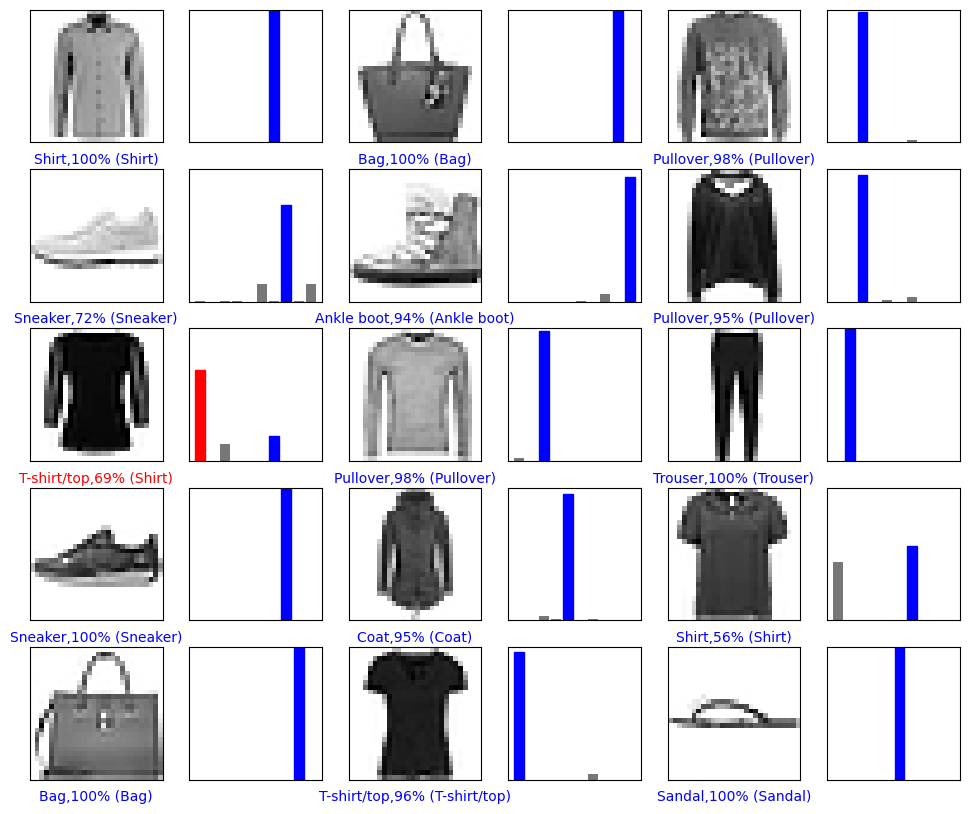

In [26]:
# 预测15个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]
    pred_np_ = softmax_np(pred_np_)
    plot_image(pred_np_, test_['y'][i], test_['x'][i, 0, ...])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(pred_np_, test_['y'][i])
plt.show() 